# Imports 

In [3]:
import re
import spacy
import pickle
import statistics
import joblib
import requests, uuid, json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from langdetect import detect
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk import download, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, RSLPStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Data Import

In [6]:
airbnb_df_train = pd.read_excel('./1.data_raw/train.xlsx')
airbnb_df_test = pd.read_excel('./1.data_raw/test.xlsx')
airbnb_df_train_reviews = pd.read_excel('./1.data_raw/train_reviews.xlsx')
airbnb_df_test_reviews = pd.read_excel('./1.data_raw/test_reviews.xlsx')
pd.options.display.max_colwidth = 50

# First Data Exploration

In [3]:
airbnb_df_train.shape

(12496, 4)

In [4]:
airbnb_df_train_reviews.shape

(721402, 2)

# First Approach

## Language Detection

In [5]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'Unknown'

### Language detection for reviews

In [415]:
airbnb_df_train.loc[airbnb_df_train["host_about"]==":)"]

,index,description,host_about,unlisted
584,585,Brand new Studio right in the heart of Lisbon....,:),0
1565,1566,"In der Natur, Abseits des Trubels von Ericeira...",:),0
2094,2095,Modern and fully equipped Apartment - 100 mete...,:),0
4234,4235,"In der Natur, Abseits des Trubels von Ericeira...",:),0
5335,5336,Charming Apartment in Cascais Historic Area.<b...,:),0
5955,5956,Brand new Studio right in the heart of Lisbon....,:),0
6422,6423,Small studio and warm suite.<br />This studio ...,:),0
12353,12354,Small studio with a nice view over the city.<b...,:),0


In [8]:
airbnb_df_train_reviews["lang_comments"] = airbnb_df_train_reviews["comments"].apply(detect_language)

In [ ]:
airbnb_df_train_reviews

,index,comments,lang_comments
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en
...,...,...,...
721397,12494,"We had a good time, the apartment has a great ...",en
721398,12494,Great apartment in very central location. The ...,en
721399,12494,"We are Airbnb Super Hosts too, so trust me, Li...",en
721400,12494,We had a lovely stay at this apartment. Sofia ...,en


### Language detection for desc/host_about

In [ ]:
airbnb_df_train["lang_desc"] = airbnb_df_train["description"].apply(detect_language)

In [ ]:
airbnb_df_train["lang_host"] = airbnb_df_train["host_about"].apply(detect_language)

In [ ]:
airbnb_df_train

,index,description,host_about,unlisted,lang_desc,lang_host
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr
...,...,...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0,en,en
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,en,en
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,pt,pt


## Import detected data

In [4]:
df_train_detected = pd.read_csv("./2.data_detected/airbnb_df_train_detected.csv", index_col="index",).drop("Unnamed: 0",axis=1)
df_train_reviews_detected = pd.read_csv("./2.data_detected/airbnb_df_train__reviews_detected.csv", index_col="index").drop("Unnamed: 0",axis=1)

### Count number of different Languages

In [20]:
df_train_detected["lang_desc"].value_counts()[0:5]

lang_desc
en    10204
pt     1844
fr      155
da      124
de       87
Name: count, dtype: int64

In [19]:
df_train_detected["lang_host"].value_counts()[0:5]

lang_host
en         8904
pt         2522
fr          267
es          171
Unknown     131
Name: count, dtype: int64

In [18]:
df_train_reviews_detected["lang_comments"].value_counts()[0:5]

lang_comments
en    461863
fr    107069
pt     45680
es     38674
de     28546
Name: count, dtype: int64

In [9]:
def create_df(df, df_review, language):

    columns_to_drop = ['lang_desc', 'lang_host']
    
    df = df[(df['lang_desc'] == language) & (df['lang_host'] == language)]
    df_review = df_review[df_review['lang_comments'] == language]
    grouped_reviews = df_review.groupby('index')['comments'].apply(lambda x: ''.join(str(x))).reset_index()
    merged_df = pd.merge(df, grouped_reviews, on='index', how='left')
    merged_df = merged_df.drop(columns=columns_to_drop)
    merged_df = merged_df[["index",	"description", "host_about", "comments", "unlisted"]]

    return merged_df

## join all English host_about/desc with English comments

In [10]:
merged_df_english = create_df(df_train_detected, df_train_reviews_detected, "en")

In [1]:
# Seems like NaN values is a good indication if a flat is getting listed again or not.
# Makes sense in real life context, because flats that dont have visitors are more likly to be unlisted in the future.

## Preprocessing English

In [11]:
def preprocessing_eng(row, tokenize, stop, lemmatize, stemmertize):
    updates = []
    
    for j in tqdm(row):
        
        text = j
        
        #LOWERCASE TEXT
        text = str(text).lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub('<[^>]+>', ' ', text)
        text = re.sub("[^a-zA-Z]"," ", text )

        

        if tokenize:
            tokens = word_tokenize(text)
            text = " ".join(tokens)
        
        #REMOVE STOPWORDS
        if stop:
            stop_eng = set(stopwords.words('english'))
            text = " ".join([word for word in text.split() if word not in stop_eng])
        
        #Lemmatize
        if lemmatize:
            lemma_eng = WordNetLemmatizer()
            text = " ".join(lemma_eng.lemmatize(word) for word in text.split())
            
        
        #Stemming
        if stemmertize:
            stemmer_eng = SnowballStemmer('english')
            text = " ".join(stemmer_eng.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [13]:
download('wordnet')
download('stopwords')
download('punkt')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_english[columns_to_apply] = merged_df_english[columns_to_apply].astype(str).apply(lambda row: preprocessing_eng(row=row,
                                                                                                                        tokenize=True,
                                                                                                                        stop=True,
                                                                                                                        lemmatize = True, 
                                                                                                                        stemmertize = False
                                                                                                                        )
                                                                                            )

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leoal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leoal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leoal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 8206/8206 [00:09<00:00, 822.66it/s] 


In [15]:
merged_df_english.to_csv("./3.data_train/merged_df_english.csv")

In [8]:
merged_df_english = pd.read_csv("./3.data_train/merged_df_english.csv").drop(["Unnamed: 0", "index"],axis=1)

In [9]:
merged_df_english

,description,host_about,comments,unlisted
0,trafaria house cozy familiar villa facility ne...,social person liking communicate reading trave...,NaN,1
1,important response covid property extended cle...,hi homing company develops activity tourism pr...,NaN,0
2,home rent traveling perfect vacation without c...,globe trotter portuguese nationality german fa...,NaN,1
3,find tranquility meticulously curated lifestyl...,travel lot love x originally israel currently ...,index shani helpful throughout process accommo...,0
4,charming apartment one bedroom double bed doub...,isabel helder portuguese parent three wonderfu...,index great little space lovely host clean w c...,0
...,...,...,...,...
8201,feel home wherever choose live blueground love...,blueground global proptech company several tho...,NaN,1
8202,cat bairro alto cozy apartment lisbon city cen...,travelling one favorite hobby already visited ...,index happy find place com great stay lisbon a...,0
8203,beautifully located heart lisbon historic cent...,founded travel enthusiast like bnbird want con...,index nice place nice location easy communicat...,0
8204,enjoy eakfast sleek kitchen freestanding knott...,portugal love dance travel x pleasure welcome ...,index lovely stay lisbon apartm liliana apartm...,0


## join all French host_about/desc with French comments

In [16]:
merged_df_french = create_df(df_train_detected, df_train_reviews_detected, "fr")

In [17]:
merged_df_french

,index,description,host_about,comments,unlisted
0,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,index\n5 Un très bel appartement avec une m...,0
1,189,"Hostel dans maison de ville , location possibl...",Maison typique avec trois chambres individuell...,NaN,0
2,192,"Appartement très chaleureux, avec beaucoup de ...","Je suis teresa, novice dans le domaines de la ...","index\n192 Appartement spacieux et propre, ...",0
3,301,Chambre double tout confort dans grande maison...,Couple de français installé au Portugal où nou...,index\n301 Tout d’abord une très belle prop...,0
4,329,Situé au pied du Panthéon dans le quartier de ...,Romain et moi sommes un couple qui sommes tomb...,index\n329 Appartement très bien situé dans...,1
...,...,...,...,...,...
100,11799,Appartement de 2 pièces entièrement rénové se ...,"Bonjour, je m’appelle Leo, un français d’origi...",index\n11799 Accueil très chaleureux de Ped...,0
101,11878,Chambre sexy in-love. Chambre avec de nombreux...,"Avec mon mari Dominique, nous vous proposons à...",NaN,0
102,11997,Ce logement affiche un style résolument unique...,j'aime les paisagem la montagne et tout qui c'...,NaN,1
103,12210,Jolie maison typique portugaise et entièrement...,Christophe & Lila marié . Trois enfants,index\n12210 Nous avons passé un très bon d...,0


## Preprocessing French

In [18]:
#!pip3 -m spacy download fr_core_news_md

In [12]:
def preprocessing_fr(row, tokenize, stop, lemmatize, stemmertize):
    updates = []
    
    for j in tqdm(row):
        
        text = j
        
        #LOWERCASE TEXT
        text = str(text).lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        if tokenize:
            tokens = word_tokenize(text, language="french")
            text = " ".join(tokens)
 
        #REMOVE STOPWORDS
        if stop:
            stop_fr = set(stopwords.words('french'))
            text = " ".join([word for word in text.split() if word not in stop_fr])
        

        #Lemmatize
        if lemmatize:
            lemma_fr = spacy.load("fr_core_news_md")
            doc = lemma_fr(text)
            #for word in doc:
            text = " ".join(i.lemma_ for i in doc)
        
        #Stemming
        if stemmertize:
            stemmer_fr = SnowballStemmer('french')
            stem_doc = stemmer_fr(text)
            for word in stem_doc:
                text = " ".join(stemmer_fr.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [20]:
download('wordnet')
download('stopwords')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_french[columns_to_apply] = merged_df_french[columns_to_apply].astype(str).apply(lambda x: preprocessing_fr(row=x,
                                                                                                                     tokenize=True,
                                                                                                                     stop=True,
                                                                                                                     lemmatize = True, 
                                                                                                                     stemmertize = False
                                                                                                                    )
                                                                                         )

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leoal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leoal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 105/105 [02:22<00:00,  1.36s/it]


In [22]:
merged_df_french.to_csv("./3.data_train/merged_df_french.csv")

In [27]:
merged_df_french = pd.read_csv("./3.data_train/merged_df_french.csv").drop(["Unnamed: 0", "index"],axis=1)

In [28]:
merged_df_french

,description,host_about,comments,unlisted
0,joli appartement bordure mer min avoir pied pl...,famille deux enfant an habit pendant plusieurs...,index tr bel appartement magnifique voir appar...,0
1,hostel maison ville location possible chame in...,maison typique trois chame individuel r servab...,NaN,0
2,appartement tr chaleureux beaucoup luminosit b...,teresa novice domaine location esp r apparteme...,index appartement spacieux propre situ quelqu ...,0
3,chame double tout confort grand maison terrain...,couple fran ais install portugal o cr maison h...,index tout abord tr bel propri name dtyp object,0
4,situ pied panth quartier alfamer venir journer...,romain couple tomb sou charm colmar lisbonn e ...,index appartement tr bien situ quartier appart...,1
...,...,...,...,...
100,appartement pi enti rement r nov situer quarti...,bonjour appeler leo fran ais origine chinois m...,index accueil tr chaleureux pedro ami leo exce...,0
101,chame sexy in lover chame nomeux miroir plafon...,mari dominiqu proposer deux capital escapade r...,NaN,0
102,logement affiche style r solument unique magni...,aimer paisagem montagne tout loisir,NaN,1
103,joli maison typique portugais enti rement cl t...,christophe lila mari trois enfant,index pass tr bon ce joli name dtyp object,0


## join all Portuguese host_about/desc with Portuguese comments'

In [47]:
merged_df_pt = create_df(df_train_detected, df_train_reviews_detected, "pt")

In [96]:
merged_df_pt

,description,host_about,comments,unlisted,Concatenated_Text
index,,,,,
13,propriet rio receber hospede pessoalmente hosp...,fa quest receber hospede sintar casa,NaN,0,NaN
34,simplifique Espa tranquilo localizar central q...,olar carlar prazer receb los alojamentar bem v...,NaN,1,NaN
64,apartamento compor suite sala tv kitchenette a...,apaixonar Portugal,NaN,1,NaN
67,apartamento est decorar extremo bom gosto comb...,pessoa otimista viver vida alegrio entusiasmo ...,NaN,0,NaN
87,ptimo espa exterior ideal gostar desfrutar ar ...,nome c tia nascer crescir sintro Vila cora apa...,NaN,1,NaN
...,...,...,...,...,...
12457,casa aconchegante familiar timar condi es pert...,bom pessoa,index excelente localizar bom reo excelente i ...,0,casa aconchegante familiar timar condi es pert...
12461,bem vir Lisboa charmoso apartamento ficar bair...,ano assistente social forma h ano decidir dedi...,index excelente apartamento agradecimento espe...,0,bem vir Lisboa charmoso apartamento ficar bair...
12470,apartamento pessoa quarto sala terra m s cadei...,chamar margarer gostar mar praia sol Portugal ...,index querer passar dia sitio clamo casa mt be...,0,apartamento pessoa quarto sala terra m s cadei...


## Preprocessing Portuguese

In [25]:
#!python -m spacy download pt_core_news_sm

In [13]:
def preprocessing_pt(row, tokenize, stop, lemmatize, stemmertize):
    updates = []
    
    for j in tqdm(row):
        
        text = j
        
        #LOWERCASE TEXT
        text = str(text).lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)

        if tokenize:
            tokens = word_tokenize(text, language="portuguese")
            text = " ".join(tokens)
            
        #REMOVE STOPWORDS
        if stop:
            stop_pt = set(stopwords.words('portuguese'))
            text = " ".join([word for word in text.split() if word not in stop_pt])
            
        #Lemmatize
        if lemmatize:
            lemma_pt = spacy.load("pt_core_news_sm")
            doc = lemma_pt(text)
            text = " ".join(i.lemma_ for i in doc)
        
        #Stemming
        if stemmertize:
            stemmer_pt = RSLPStemmer()
            stem_doc = stemmer_pt(text)
            for word in stem_doc:
                text = " ".join(stemmer_pt.stem(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [ ]:
merged_df_pt.head()

In [ ]:
download('wordnet')
download('stopwords')
columns_to_apply = ['description', 'host_about', 'comments']
merged_df_pt[columns_to_apply] = merged_df_pt[columns_to_apply].astype(str).apply(lambda row: preprocessing_pt(row=row,
                                                                                                             tokenize=True,
                                                                                                             stop=True,
                                                                                                             lemmatize = True, 
                                                                                                             stemmertize = False
                                                                                                            )
                                                                                )

In [64]:
merged_df_pt.to_csv("./3.data_train/merged_df_pt.csv")

In [29]:
merged_df_pt = pd.read_csv("./3.data_train/merged_df_pt.csv").drop(["Unnamed: 0","index"],axis=1)

In [30]:
merged_df_pt

,description,host_about,comments,unlisted
0,propriet rio receber hospede pessoalmente hosp...,fa quest receber hospede sintar casa,NaN,0
1,simplifique Espa tranquilo localizar central q...,olar carlar prazer receb los alojamentar bem v...,NaN,1
2,apartamento compor suite sala tv kitchenette a...,apaixonar Portugal,NaN,1
3,apartamento est decorar extremo bom gosto comb...,pessoa otimista viver vida alegrio entusiasmo ...,NaN,0
4,ptimo espa exterior ideal gostar desfrutar ar ...,nome c tia nascer crescir sintro Vila cora apa...,NaN,1
...,...,...,...,...
1084,casa aconchegante familiar timar condi es pert...,bom pessoa,index excelente localizar bom reo excelente i ...,0
1085,bem vir Lisboa charmoso apartamento ficar bair...,ano assistente social forma h ano decidir dedi...,index excelente apartamento agradecimento espe...,0
1086,apartamento pessoa quarto sala terra m s cadei...,chamar margarer gostar mar praia sol Portugal ...,index querer passar dia sitio clamo casa mt be...,0
1087,apartamento zona calmo Lisboa pr ximo Centro c...,apartamento simples charme sala Sof s wi fi gr...,NaN,0


## TF - IDF, Train and Evaluation of Estimators

In [11]:
def create_target(df):
    # Concatenate text columns into a single column
    df['Concatenated_Text'] = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']

    #separate features and taget
    X = df['Concatenated_Text'].astype(str)
    y = df['unlisted'].astype(int)

    return X, y

In [39]:
def custom_fit_evaluate(X,y,estimator):
    tfidf = TfidfVectorizer()
    precision_avg = []
    recall_avg = []
    f1_avg = []
    accuracy_avg = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in skf.split(X, y):
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        
        x_train_tfidf = tfidf.fit_transform(x_train)
        x_val_tfidf = tfidf.transform(x_val)

        estimator.fit(x_train_tfidf,y_train)
        
        y_pred = estimator.predict(x_val_tfidf)

        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        accuracy = accuracy_score(y_val, y_pred)


        precision_avg.append(precision)
        recall_avg.append(recall)
        f1_avg.append(f1)
        accuracy_avg.append(accuracy)
    
    precision_avg = statistics.mean(precision_avg)
    recall_avg = statistics.mean(recall_avg)
    f1_avg = statistics.mean(f1_avg)
    accuracy_avg = statistics.mean(accuracy_avg)

    classes = np.unique(np.concatenate((y_val, y_pred)))

    # Create a confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

    return precision_avg, recall_avg, f1_avg, accuracy_avg

In [40]:
X_eng, y_eng = create_target(merged_df_english)

In [41]:
rf_classifier_eng = RandomForestClassifier()

In [42]:
modelknn_word_eng = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

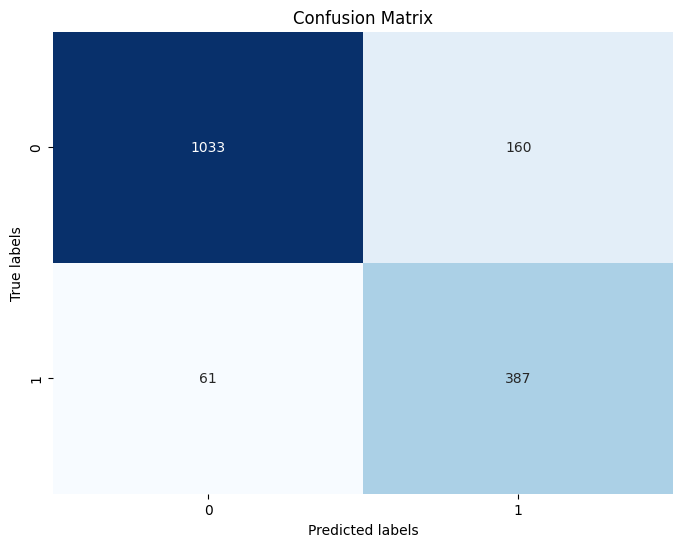

(0.7224246431186795,
 0.8455357142857143,
 0.7789412137174473,
 0.8689977665797496)

In [43]:
custom_fit_evaluate(X_eng, y_eng, rf_classifier_eng)

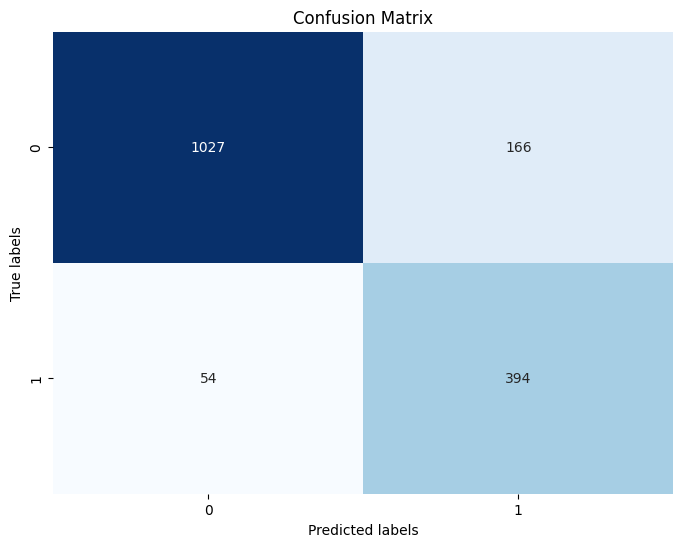

(0.7208952496025822,
 0.8553571428571428,
 0.7821803700128747,
 0.8699727075896949)

In [44]:
custom_fit_evaluate(X_eng, y_eng, modelknn_word_eng)

In [24]:
tfidf_eng = TfidfVectorizer()
x_train_tfidf_eng = tfidf_eng.fit_transform(X_eng)

In [437]:
rf_classifier_eng.fit(x_train_tfidf_eng, y_eng)

RandomForestClassifier()

In [438]:
modelknn_word_eng.fit(x_train_tfidf_eng, y_eng)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [439]:

with open('./5.Vectorizer/tfidf_vectorizer_eng.pkl', 'wb') as file:
    pickle.dump(tfidf_eng, file)

In [440]:

joblib.dump(rf_classifier_eng, "./4.models/rf_classifier_eng.joblib")
joblib.dump(modelknn_word_eng, "./4.models/modelknn_word_eng.joblib")

['./4.models/modelknn_word_eng.joblib']

In [45]:
rf_classifier_fr = RandomForestClassifier()
modelknn_word_fr = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [46]:
X_fr, y_fr = create_target(merged_df_french)

In [54]:
X_fr.shape

(105,)

In [55]:
y_fr.shape

(105,)

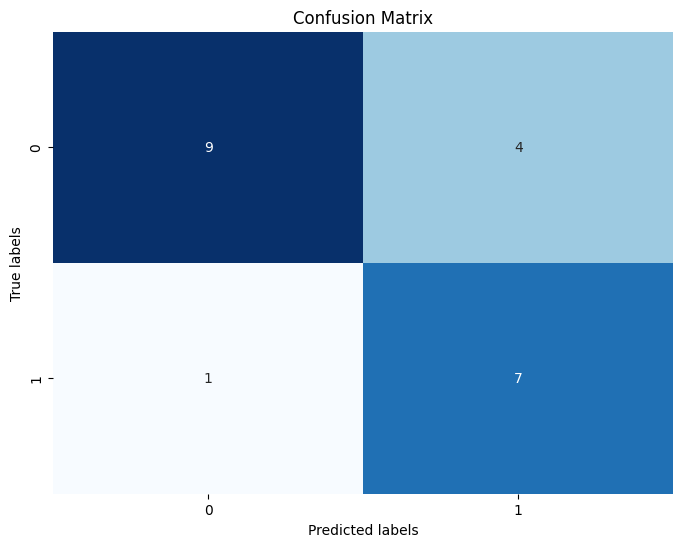

(0.5381818181818182, 0.7464285714285714, 0.623969728242174, 0.6952380952380952)

In [47]:
custom_fit_evaluate(X_fr, y_fr, rf_classifier_fr)

c:\Users\leoal\.virtualenvs\Project-aNjsu91Q\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


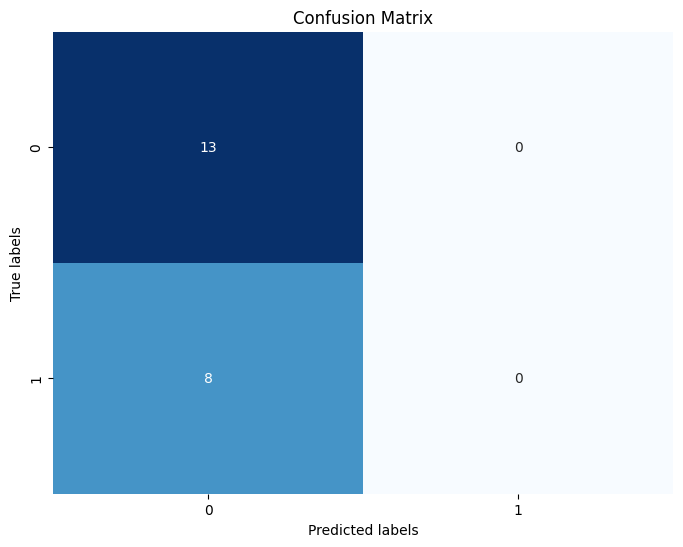

(0.42424242424242425,
 0.5714285714285714,
 0.4854248366013072,
 0.6761904761904762)

In [48]:
custom_fit_evaluate(X_fr, y_fr, modelknn_word_fr)

In [445]:
tfidf_fr = TfidfVectorizer()
x_train_tfidf_fr = tfidf_fr.fit_transform(X_fr)

In [446]:
rf_classifier_fr.fit(x_train_tfidf_fr, y_fr)

RandomForestClassifier()

In [447]:
modelknn_word_fr.fit(x_train_tfidf_fr, y_fr)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [448]:
with open('./5.Vectorizer/tfidf_vectorizer_fr.pkl', 'wb') as file:
    pickle.dump(tfidf_fr, file)

In [449]:
joblib.dump(rf_classifier_fr, "./4.models/rf_classifier_fr.joblib")
joblib.dump(modelknn_word_fr, "./4.models/modelknn_word_fr.joblib")

['./4.models/modelknn_word_fr.joblib']

In [49]:
rf_classifier_pt = RandomForestClassifier()
modelknn_word_pt = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

In [50]:
X_pt, y_pt = create_target(merged_df_pt)

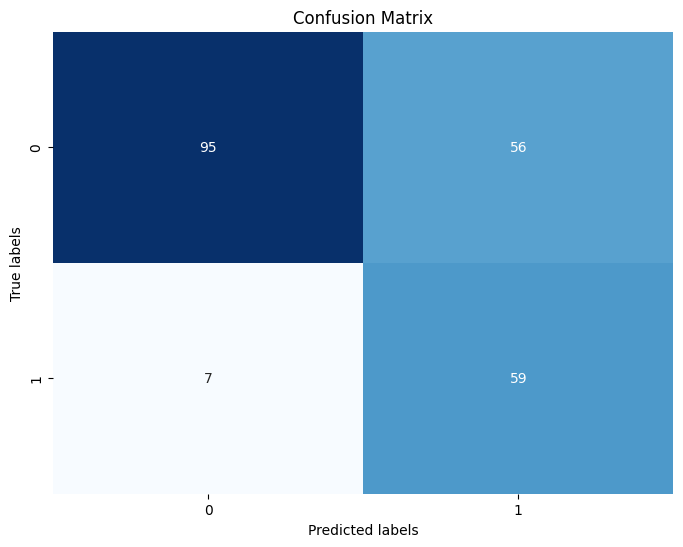

(0.54667254984142, 0.9336047037539575, 0.6892718778154188, 0.7428529150636283)

In [51]:
custom_fit_evaluate(X_pt, y_pt, rf_classifier_pt)

c:\Users\leoal\.virtualenvs\Project-aNjsu91Q\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


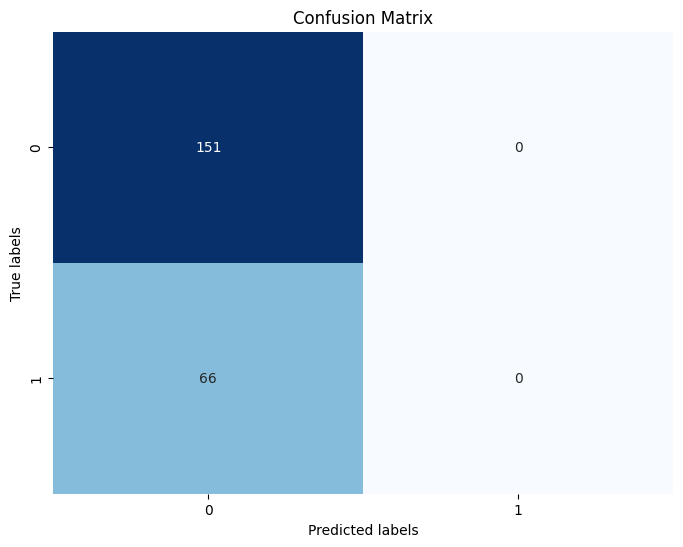

(0.44484487393578304,
 0.7578018995929444,
 0.5603106542337488,
 0.7410053692977635)

In [52]:
custom_fit_evaluate(X_pt, y_pt, modelknn_word_pt)

In [454]:
tfidf_pt = TfidfVectorizer()
x_train_tfidf_pt = tfidf_pt.fit_transform(X_pt)

In [455]:
rf_classifier_pt.fit(x_train_tfidf_pt, y_pt)

RandomForestClassifier()

In [456]:
modelknn_word_pt.fit(x_train_tfidf_pt, y_pt)

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')

In [457]:
with open('./5.Vectorizer/tfidf_vectorizer_pt.pkl', 'wb') as file:
    pickle.dump(tfidf_pt, file)

In [458]:
joblib.dump(rf_classifier_pt, "./4.models/rf_classifier_pt.joblib")
joblib.dump(modelknn_word_pt, "./4.models/modelknn_word_pt.joblib")

['./4.models/modelknn_word_pt.joblib']

In [64]:
def translate_to_eng(text):
    key = "4aacdafc18474eb0accce6d24349ac62"
    endpoint = "https://api.cognitive.microsofttranslator.com"

    location = "westeurope"

    path = '/translate'
    constructed_url = endpoint + path

    params = {
        'api-version': '3.0',
        'to': 'en'
    }

    headers = {
        'Ocp-Apim-Subscription-Key': key,
        'Ocp-Apim-Subscription-Region': location,
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    body = [{
        'text': text
    }]

    request = requests.post(constructed_url, params=params, headers=headers, json=body)
    response = request.json()

    return response[0]["translations"][0]["text"]

In [66]:
response = translate_to_eng("Übersetzen bitte")

[{'detectedLanguage': {'language': 'de', 'score': 1.0}, 'translations': [{'text': 'Please translate', 'to': 'en'}]}]


In [67]:
response

'Please translate'

In [14]:
def create_feature_row(row):
    description = row[1]
    host_about = row[2]
    comments = row[3]

    # Concatenate text columns into a single column
    concatenated_text = str(description) + ' ' + str(host_about) + ' ' + str(comments)

    return concatenated_text

In [27]:
    
def merge_test_df(df, df_review):
    grouped_reviews = df_review.groupby('index')['comments'].apply(lambda x: ''.join(str(x))).reset_index()
    merged_df = pd.merge(df, grouped_reviews, on='index', how='left')
    merged_df = merged_df[["index",	"description", "host_about", "comments"]]

    return merged_df

In [28]:
merged_test_df = merge_test_df(airbnb_df_test, airbnb_df_test_reviews)

In [29]:
merged_test_df

,index,description,host_about,comments
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",0 Thank you very much Antonio ! All has b...
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"125 This is a beautiful, bright apartment i..."
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",NaN
3,4,Charming Apartment Close to the Bay of Cascais...,:),136 Claudia was a great host. She met us a...
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,153 La maison est exactement comme sur les ...
...,...,...,...,...
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling._x0...,NaN
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",80490 Bonnes prestations et bien situé.<br/...
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...","80827 Tiago é muito simpático e disponível,..."
1387,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...,80875 Unfortunately not a pleasant experien...


In [68]:
def prediction(row):
    columns_to_apply = ['description', 'host_about', 'comments']
    lang_desc = detect_language(str(row[1]))
    lang_host = detect_language(str(row[2]))
    lang_review = detect_language(str(row[3]))

    if (lang_desc == "en") & (lang_host == "en") & (lang_review == "en"):
        row = preprocessing_eng(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True, 
                                stemmertize = False
                                )

        row = create_feature_row(row)

        with open('./5.Vectorizer/tfidf_vectorizer_eng.pkl', 'rb') as file:
            tfidf_vectorizer_eng = pickle.load(file)

        row_list = [row]
        row = tfidf_vectorizer_eng.transform(row_list)

        loaded_rf_eng = joblib.load("./4.models/rf_classifier_eng.joblib")

        return int(loaded_rf_eng.predict(row)[0])

    elif (lang_desc == "fr") & (lang_host == "fr") & (lang_review == "fr"):
        row = preprocessing_fr(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True, 
                                stemmertize = False
                                )
                                
        row = create_feature_row(row)

        with open('./5.Vectorizer/tfidf_vectorizer_fr.pkl', 'rb') as file:
            tfidf_vectorizer_fr = pickle.load(file)

        row_list = [row]
        row = tfidf_vectorizer_fr.transform(row_list)

        loaded_rf_fr = joblib.load("./4.models/rf_classifier_fr.joblib")

        return int(loaded_rf_fr.predict(row)[0])

    elif (lang_desc == "pt") & (lang_host == "pt") & (lang_review == "pt"):
        row = preprocessing_pt(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True, 
                                stemmertize = False
                                )

        row = create_feature_row(row)

        with open('./5.Vectorizer/tfidf_vectorizer_pt.pkl', 'rb') as file:
            tfidf_vectorizer_pt = pickle.load(file)

        row_list = [row]
        row = tfidf_vectorizer_pt.transform(row_list)

        loaded_rf_pt = joblib.load("./4.models/rf_classifier_pt.joblib")

        return int(loaded_rf_pt.predict(row)[0])
    else:
        loaded_rf_eng = joblib.load("./4.models/rf_classifier_eng.joblib")
        row = create_feature_row(row)
        row = translate_to_eng(row)
        row = preprocessing_eng(row=row,
                                tokenize=True,
                                stop=True,
                                lemmatize = True, 
                                stemmertize = False
                                )
                                
        with open('./5.Vectorizer/tfidf_vectorizer_eng.pkl', 'rb') as file:
            tfidf_vectorizer_eng = pickle.load(file)

        row = tfidf_vectorizer_eng.transform(row)

        return int(loaded_rf_eng.predict(row)[0])

In [69]:
merged_test_df["prediction"] = merged_test_df.apply(lambda row: prediction(row), axis=1)

translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "<b>The space</b><br />Apartment located in the historic center of Lisbon.<br /><br />This apartment space is a game between history and modernization of the finishes. Since entering the details of the apartment. The tasteful interior finishes of the apartments and the property value.<br /><br />Fully equipped and furnished, very cozy.<br /><br />Bed linen, towels and kitchen textiles;<br /><br />The apartment is located in the area of Rua de O Seculo, between the Jardins do Principe Real and Jardim de  S Pedro de Alcantara. A 5 minute walk from the best areas of Lisbon and Chiado, Avenida da Liberdade, Largo Camões, Alfama, Castelo and Baixa.<br /><br />There are several churches, convents and museums to visit in this area.<br /><br />The urbanization of the Lisbon area began in the sixteenth century, when the construction of this house, in the reign of Sebastian,  having even survived the gre

100%|██████████| 5/5 [00:00<00:00, 1511.90it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Bright, beautiful, and spacious. This four-bedroom apartment in Loures, Portugal is perfect for families, friends, and large groups of friends. The property is fully furnished and sleeps up to 8 people.<br /><br /><b>The space</b><br />Welcome! <br /> <br />Perfect for friends and families, this beautiful home has 4 bedrooms and sleeps up to 8 people.  <br /> <br />Of the 4 rooms, in one, you'll find 2 single beds, and in the other 3 you'll find beds that sleep 2 people. Each of the beds have been fitted with hotel-quality linens for your comfort.  <br /> <br />The living room is furnished beautifully and is filled with sunlight, thanks to the large windows. Here you'll find 2 lovely armchairs, a sofa and a flat-screen TV. The dining area is also by the windows. <br /> <br />Fully equipped, the kitchen has all you need to make yourself a nice meal. <br /> <br />There are 2 bathrooms and 1 WC. Y

100%|██████████| 1848/1848 [00:00<00:00, 7028.43it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': 'Charming Apartment Close to the Bay of Cascais.<br />1 bedroom with double bed and double sofa bed.<br />Maximum capacity 4 people.<br />Very central, 15 meters from the beach and 2 minutes from the center of the village.<br /><br /><b>The space</b><br />This charming apartment is located in one of the walls of an old Castle set in the heart of the historic village of Cascais.<br /><br /> Decorated with simplicity and taste, the apartment has been recently renovated and is fully equipped. It has approximately 50 m2, 1 double bedroom and a living room, Kitchenette equipped and a complete bathroom. 1 double bed and a double sofa bed in the living room.<br /><br />This cozy apartment is very central yet located in a quiet area.  Ideal to enjoy and visit the historic center of Cascais and at the same time all activities, shops and services are 2 minutes away.<br /><br /><b>Guest access</b><br />Gu

100%|██████████| 1996/1996 [00:00<00:00, 6584.80it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.85}, 'translations': [{'text': "If you are looking for a holiday near the beach, casino and other tourist attractions, choose this pleasant house, with a picturesque courtyard, where you can read a book, rest, or even order a delicious gastronomic tasting from the host. Try <br /><br /><b>License number</b><br />86364/AL Welcome to Portugal!_x000D_\nI love my country, but I also love getting to know other cultures and above all making others feel felizes._x000D_\nI love to receive, share gastronomic, cultural and turísticas_x000D_ experiences\nThe fact that in addition to this activity I am also a nurse, makes communication and interhelp my points fortes._x000D_\nBeing our guest is synonymous with having a stay that meets the interests of each one and we try to do our best so that this is provided. We have lived in the area for several decades so we know the various points of interest both Estoril and Lisbon and all areas ci

100%|██████████| 3679/3679 [00:00<00:00, 6978.73it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.83}, 'translations': [{'text': "Rustic house with strong typical characteristics and situated next to the beach (200 m from the beach of S. Sebastião), and within a walking distance of shopping center, restaurants, cafes. <br />Very quiet and relaxing place where you can feel the coolness of the village.<br />A sofa bed will be available to the 6th person.<br /><br /><b>The space</b><br />Rustic house with strong typical characteristics and situated next to the beach (200 m from the beach of S. Sebastião), and within a walking distance of shopping center,  restaurants, cafes.<br /><br />Very quiet and relaxing place where you can feel the cool breeze of the ocean.<br /><br />The house has:<br /><br />3 bedrooms (two with double bed and one with single bed).<br /><br />1living room with two sofa beds.<br /><br />1 fully equipped kitchen with washing machine, electric toaster,  blender and microwave.<br /><br />1 bathroom with

100%|██████████| 5/5 [00:00<00:00, 1665.86it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "Apartamento duplex inserido num edifício novo (2017), no bairro de Alcântara (2º Andar, sem elevador).  No terraço no piso superior poderá desfrutar da paisagem circundante. <br /><br />Acolhedor, bem mobilado e decorado para que sinta o melhor conforto de forma a proporcionar-lhe uma estadia muito agradável na cidade de Lisboa.<br /><br />Localizado na rua do LxFactory onde encontra animação, restaurantes temáticos, cafés, bares, lojas e espaços de arte.<br /><br /><b>The space</b><br />Os hóspedes terão o máximo de privacidade em suas casas,  com todo o conforto. Quarto aconchegante, WC, cozinha totalmente equipada, sala com área de refeição e área de estar com Smart Tv e Wi-Fi gratuito em toda a propriedade.<br /><br />Acesso ao apartamento com abertura por código secreto - Smart-Lock. Envio de código na véspera do check-in e válido por todo o período da estadia.<br /><br /><b>Guest access<

100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Quaint, beautiful flat in one of Lisbon's trendiest areas: Bairro Alto. Oozing European charm in Lisbon's historical city center, this ceramic-tile-covered stone building lays near the must-see bits of Western Europe's hottest destinations.<br /><br />It's in Bairro Alto's legendary bar & restaurant district - on a bar-free street, so an oasis of peace and quiet in the winding cobblestone streets. Blocks to the Tram 28, a 5 min. walk to Príncipe Real, 10 mins. walk to Baixa-Chiado metro, Cais do Sodré<br /><br /><b>The space</b><br />ur flat/apartment is in a building nearly two centuries old. It captures the essence of Lisbon and its ancient history, sitting in the center of a typical historical neighborhood. It occupies the entire 3rd floor of its building (4th floor by American standards) with a full-length narrow balcony. This affords a view of the winding street below and a glimpse of the

100%|██████████| 5/5 [00:00<00:00, 1645.99it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Apartment "ARTS" is situated at Principe Real, one of the most charming and traditional areas of Lisbon, only 50 meters from Principe Real Garden. <br />This neighbourhood is where many artists, actors and film directors live. <br />It has been named the BEST PLACE TO LIVE IN LISBON by TimeOut Magazine. <br />The apartment has the traditional pombalin architecture features. <br />Great view!<br /><br />Things to note:<br />- Small bedrooms, may appear larger in photos<br />- Lively area, can be noisy especially with windows open<br /><br /><b>The space</b><br />- Fully equipped kitchen<br />- Cable TV and internet (wifi)<br />- baby bed<br />- Nespresso machine (BYO capsules)<br />- There is no air conditioning but electric heaters and fans are provided.<br /><br /><b>Guest access</b><br />The apartment is all to yourselves.<br /><br /><b>Other things to note</b><br />WHAT IS INCLUDED<br />- To

100%|██████████| 2412/2412 [00:00<00:00, 6705.79it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Welcome to LX History Hotel in Lisbon, Portugal. Located in the traditional and cultural neighborhoods of Anjos and Intendente, the hotel offers easy access to famous tourist attractions such as the Old Town of Alfama, St. George's Castle, and Palace Rossio. Offering free WIFI, modern amenities, and panoramic city views, it is an ideal resort. Check in to one-of-a-kind listings and feel the rhythm of downtown.<br /><br /><b>The space</b><br />The total area of this room, including the bathroom, is 10 meters squared.<br /><br /><b>Guest access</b><br />The bathroom is private, and the kitchen is shared. All rooms are individual and equipped with new towels and sheets.<br /><br /><b>License number</b><br />73110/AL Welcome to LX History Hotel in Lisbon, Portugal. Here you can plan your social activities in Lisbon for a delightful experience. The hotel is close to the Anjos and Intendente metro s

100%|██████████| 993/993 [00:00<00:00, 6503.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Very beautiful and comfortable villa perfect for 4/5 persons. It has 2 bedrooms and a bathroom upstairs. The kitchen, dining/living room, toilet and barbecue are downstairs. It is within a close range, you’ll find several great surf spots and in a peaceful zone.<br />A great choice for surf trips or a relaxing holiday with some walks to the beach.<br /><br /><b>The space</b><br />Within a close range, you’ll find several great surf spots and it’s located in a peaceful zone. A great choice for surf trips or a relaxing holiday with some walks to the beach.<br /><br /><b>Guest access</b><br />All the Villa and terrace with barbecue<br /><br /><b>Other things to note</b><br />I'm available to arrange:<br />- Transportation to and from the airport,<br />- Car rental,<br />- Bikes/scooters and Surf equipment rental,<br />-  Guided tours,<br />- Surf school referral.<br />- Boat Trips along Ericeira 

100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Apart from our clean, comfortable, friendly low cost home, one of the best things about staying here is the scenic river crossing, ferries every few minutes to Lisbon City Centre, takes 9 minutes. Near ferry terminal are dozens of restaurants, bars, cafes and amazing vibe. Across river from Lisbon City Centre (Cais do Sodre metro). 8 to 12 mins walk from ferry terminal.  Double bed, small private bathroom/WC. Laundry.  Free street parking. We cater for students, backpackers and world travellers<br /><br /><b>The space</b><br />A really pleasant room in my home, on the first floor (Ground floor + 1), with small private bathroom,  shower, toilet, basin.  The shower cubicle is not suitable for very obese people.  Terrific views.  Free parking in street outside<br /><br />A cabina de duche não é adequada para pessoas muito obesas<br /><br />The whole Lisbon area is built on hills so visitors shoul

100%|██████████| 5/5 [00:00<00:00, 1660.98it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': "Wonderful studio with a superb and spacious balcony with beautiful panoramic views of the sea!<br /><br /><b>The space</b><br />Wonderful studio with a superb and spacious balcony with beautiful panoramic view of the sea!<br />It has a double bed (facing the sea) and a large sofa bed where you can sleep another 1 person. It also has a kitchenette and a bathroom.<br />Totally refurbished and practically new, to debut.<br />Central, close to supermarkets and restaurants and only 10 minutes walk from the historic center of Cascais, as well as the Marina, Cascais Market and Casa da Guia. Come and enjoy a few days!<br /><br />IMPORTANT NOTE: If your reservation is MORE than 10 NIGHTS, it will be necessary to charge an EXTRA CLEANING service.<br /><br />As this apartment has just been made available for temporary rental, we wait for the first guests to tell you about their experience in our apartmen

100%|██████████| 5/5 [00:00<00:00, 1249.94it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Located in one of the best neighborhoods in Lisbon, Principe Real. In a quite neighborhood but super close to everything you need as a visitor. <br /><br />Near two major parks, grocery stores and restaurants.<br /><br /><b>The space</b><br />This apartment is super bright and With two spacious bedrooms and a living room. <br /><br />Bedrooms have king size bed and the living room is equipped with a queen size sofa bed. this apartment accommodates 5 people.<br /><br /><b>Guest access</b><br />A gated property with elevator.<br /><br /><b>License number</b><br />120281/AL Live by “fewer better things”. Look to nature and universe for inspiration and lessons in life. \n\nBuy less. Travel and Dine more.  nan', 'to': 'en'}]}]


100%|██████████| 712/712 [00:00<00:00, 6983.27it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.99}, 'translations': [{'text': 'In the heart of Lisbon enjoy a spacious, elegant and central accommodation. <br />Located 2 blocks from the iconic Time Out Market, the apartment of about 50m2 is composed of: <br />- Living / dining room ( 1 sofa bed 2 people)<br />- Kitchen Equipped <br />- 1 bathroom - shower<br />- 1 bedroom with a double bed (160x200)<br />-TV connected / Netflix <br />- Reversible air conditioning<br />- Wi-Fi / FIBER <br /><br />Maximum : 4 adults <br />Pets Prohibited<br />Apartment NOT smoking<br /><br />Apartment decorated with care and bright.<br />Coup de Heart assured!<br /><br /><b>The space</b><br />1 double bed 160x200 ( bedroom ) <br />1 double sofa bed (living room)<br />Important: <br />* If you want to use the sofa bed in the living room you have to book min for 3 people. Thanks<br /><br /><b>Guest access</b><br />Important: <br /><br />* If you want to use the sofa bed in the living room y

100%|██████████| 1156/1156 [00:00<00:00, 6948.00it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Saldanha Avenida is a cozy and quality apartment that has been totally renovated this year in order to prepare the 4 rooms and all the common areas to welcome our Guests with all the best confort. From here you'll be able to enjoy all the best Lisboa has to offer! Come and stay with us - you're always welcome! I've been a proud Airbnb host for 2 years and have very good reviews.<br /><br /><b>The space</b><br />Beautiful and cozy apartment that was totally recently renovated and has 4 rooms with 2 shared bathrooms (1 is a toilet and 1 is a complete bathroom). Included in the price are the common expenses, Wi-fi internet throughout the apartment, cleaning service of all common areas two times a week and also of the rooms once a week. Rooms are confortably furnished with good beds and guests are supplied with bath towels and bed linens.<br /><br /><b>Guest access</b><br />All the rooms have access to a be

100%|██████████| 2005/2005 [00:00<00:00, 6801.26it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 1.0}, 'translations': [{'text': '(LUXURY category). 200m from the Cathedral (Sé), with a Tagus view and the garden of the private Palacete where it is located, this room also benefits from a private TERRACE. Breakfast INCLUDED.<br />Access to the SAUNA and JACUZZI offered from.8:30 to 12:00. Privatization for a fee some evenings, on reservation.<br /><br /><b>The space</b><br />This room, which has a magnificent bathroom, is very bright, sunny in the morning. It has a small terrace overlooking the Tagus River (Lisbon Bay). Cunard liners and ships of the line (Queen Elysabeth, etc...) dock just opposite. <br />The decoration is museological with showcases of archaeological objects and Art Deco furniture. The sanitary area is divided into a large shower room, and a toilet, with window and ventilation system.<br />The room is equipped with heating, particularly appreciable in winter when the evenings are cool. It is equipped with

100%|██████████| 1296/1296 [00:00<00:00, 6897.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Captain’s House is a renewed apartment  at the 3rd floor, with a modern and stylish furniture, furnished with a fresh and clean style. <br />It has 3 separate bedrooms with comfortable double beds, a big living-room with modern kitchen and 2 bathrooms, an amazing river view.<br />It can accommodate up to 6 people and it's located near the central Cais do Sodre, the perfect place to  discover Lisbon by feet. Captain’s House is waiting for you!<br /><br /><b>License number</b><br />81881/AL Hi my name is Rodolfo I am passionate for travling and my goal is to provide you with th best exprience in Lisbon.\nI am living in Italy and my partners Andrea and Roberto are helping me managing the apartment,\nThey are experient host and will do their best to mak your holiday unique. nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1655.47it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'Next to the Cellar and Event Room QUINTA DO CONVENTO, heir to a long history, maintains the dedication to the passion of producing high quality wines, allied to the aspects of Events and Turismo._x000D_\n_x000D_\nCome and meet her! Nan', 'to': 'en'}]}]


100%|██████████| 233/233 [00:00<00:00, 6755.51it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.83}, 'translations': [{'text': "Located in a quiet square with trees and benches, friendly neighbors and a country-like environment, this apartment, facing the river, has hardwood floor, all the comfort you need and lots of light. It's good for couples, families or solo travelers. <br />Drivers have free parking and walkers can stroll alongside the river to the nearby Metro station.  A swift bus takes you downtown Lisboa and all its charm. Have fun!<br /><br /><b>The space</b><br />Espaço acolhedor e luminoso, com chão envernizado de tábua corrida e paredes brancas. Mobiliário de madeira, antigo e tratado, conjugado com elementos mais recentes para conferir um tom descontraído ao apartamento. Cozinha equipada, em tons amarelo ocre, de acordo com o ambiente mediterrânico do espaço. <br />Ar condicionado, wifi e televisão fazem parte das comodidades deste espaço.<br /><br /><b>Guest access</b><br />Os hóspedes têm acesso a todos os espa

100%|██████████| 5/5 [00:00<00:00, 1626.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Welcome to our studio! A beautiful, hip and cozy studio apartment with a terrace located between Alcantara and the lively district of Santos, served by great transport links and a great place to stay in and enjoy Lisbon. The very highly ranked Italian restaurant called Prime Coma is just right beside our building. <br />We hope you enjoy your stay!<br /><br /><b>The space</b><br />A stylish studio apartment with a terrace that serves as a perfect base for visiting Lisbon.<br />The living area is light and airy with a beautiful, modern design and lovely finishing touches. Relax on the terrace, hang out with your friends, make yourself at home! It’s a welcoming and inviting space where you can kick back.<br />If cooking is your thing, you’re going to love spending time in the stylish kitchen. All the appliances are modern and easy to use - you’ll enjoy showing off your culinary skills here!<br />

100%|██████████| 5/5 [00:00<00:00, 2482.72it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.81}, 'translations': [{'text': "Temos a descrição do anúncio em vários idiomas . O apartamento fica em um bairro típico de Lisboa, agradável, extremamente seguro e dinâmico. O quarto é lindamente decorado, com janelas para a rua e climatizado, possui 2 banheiros com hidromassagem, TV, cozinha equipada... E isto tudo é em uma zona bem vivida, onde encontra comércio a porta, autocarros e metro a 8 minutos do Centro! Câmera de segurança no corredor da casa gravando 24 hs, com áudio e sensor de movimentos o tempo todo!<br /><br /><b>The space</b><br />A limpeza do apartamento ocorre tres vezes na semana entre ás 10:00 e 14:00 horas ( cozinha, casas de banho, as roupas de cama e toalhas são 100% algodão e de ótima qualidade e com estadias superiores á 7 dias,  trocamos as roupas de cama e toalhas!<br />O apartamento é constituído por mais três quartos, cozinha com bancada, quatro bancos, cafeteira, microondas, fogão, forno, torra

100%|██████████| 5/5 [00:00<00:00, 1664.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': 'Our personal favorite, this two-storey house is the perfect hideaway for romantic lovebirds. A private bath and separate toilet downstairs and a master bed room upstairs with an XL sliding window opening up to an impressive view (yes, with the mighty Atlantic in the distance) and a cozy private outside lounge.<br /><br /><b>The space</b><br />Casa Paço D`Ilhas stands for traditional heritage-style with contemporary comfort.<br />Whether you book a deluxe room or a low-key cabana,  there will be no difference in the way you`ll feel immersed in our holistic leisure experience. <br />All guests have free access to the communal areas: our nearly 200 years old main house with plenty of rustic charm, reading corner with fireplace, honesty bar, sunlit veranda and restaurant, our pristine garden with plenty of hidden corners and two pools, our sun lounge, organic veg patch, children`s playground and o

100%|██████████| 5/5 [00:00<00:00, 1654.82it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.9}, 'translations': [{'text': 'Apartment 2 minutes from Largo do Carmo, in the Chiado area, with lots of charm and natural light. Comfortably accommodates 6 people. The perfect apartment for a holiday with family or friends in the heart of the city.<br />Alojamento local 20203/AL<br /><br /><b>The space</b><br />Apartment with living room and two bedrooms. Wardrobes in the bedrooms. Living room with sofa bed. Wifi available and television with foreign channels.<br />Equipped kitchen.<br />The perfect space for both a short stay and a longer stay.<br /><br /><b>Guest access</b><br />We can keep your luggage before check-in and after check-out<br /><br /><b>Other things to note</b><br />Apartment in the area of Chiado and Largo do Carmo. Perfect location for your next holiday in Lisboa.<br /><br /><b>License number</b><br />20203/AL Sou de Lisboa. I love to travel and welcome friends home. 1713 Notre vol avait du retard, Manue

100%|██████████| 5/5 [00:00<00:00, 1000.07it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.96}, 'translations': [{'text': 'The "Da Silva Surf Camp" is a typical Portuguese country house in the middle of nature without any road traffic in the immediate vicinity. The property is surrounded by extensive fields and you have a fantastic view from everywhere over the green landscape and a wide valley to the villages opposite. Ideal for single travelers, couples, groups and also for families with children of all ages.<br /><br />The space<br /><b>The</b> da Silva Surf Camp is a hostel with a total of two hotels. 32 beds spread over 5 rooms of different sizes and three separate wooden cottages (Tiny Houses). In total, we have space for 32 people. But this is distributed quite well, because there are many corners and niches where you can retreat if, for example, you want to read a good book in peace. The prices shown here refer only to the entire main house with 20 beds and self-catering.<br /><br />The main house has a do

100%|██████████| 1324/1324 [00:00<00:00, 6890.10it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': '<b>License number</b><br />Exempt accessible and receptive Always available for the well-being of guests nan', 'to': 'en'}]}]


100%|██████████| 108/108 [00:00<00:00, 7139.24it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Very Typical Lisbon House<br /><br /><b>The space</b><br />It’s a Typical House from 1924 located on the 4th floor of an old building with no elevator. <br />The apartment was renovated. <br />This is a room with a double bed and a window no street view; shared bathroom and kitchen.<br /><br /><b>Guest access</b><br />You will have access to the kitchen and all it's appliances, the bathroom, the shower area, and a small sunroom where you can work, eat or relax.<br />It will be your house!<br /><br /><b>Other things to note</b><br />Since it is located on the 4th floor of an old building there is no elevator.<br /><br /><b>License number</b><br /> 72072/AL Two sisters living in Lisbon excited to meet new people and cultures from all over the world 1943                                            very nice\n1944    Appartement très bien, bien situé, tout à disp...\n1945    A Catarina foi super atenciosa e 

100%|██████████| 1186/1186 [00:00<00:00, 7144.55it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "My NEWEST apartment is in a 134 year old refurbished and renovated building! My small but sweet apartment has one bed for two and one couch in the living room that opens for one more to sleep. It's situated in Lisbon's heart in one of the most typical and historical neighborhoods of this city! It was and still is the district of Fado. It's just 8 minutes walk (600m) from Santa Apolónia subway station, 10min walk from the castle and the rest of the city center. You are welcome to book my place.<br /><br /><b>The space</b><br />My small but sweet apartment has one bed for two and one couch in the living room that opens for one more to sleep. In the kitchen you can find every tool to cook your meals. I hope you enjoy it has much as I do!<br /><br /><b>Guest access</b><br />The apartment has wireless internet and many  internacional channels so you won't miss home so much!<br />You'll have acess to all the 

100%|██████████| 5/5 [00:00<00:00, 2493.64it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Feel at home wherever you choose to live with Blueground. You’ll love this cozy Avenidas Novas furnished one-bedroom apartment with its modern decor, fully equipped kitchen, and bright living room. Ideally located, you’re close to all the best that Lisbon has to offer! (ID #LIS67)<br /><br /><b>The space</b><br />Thoughtfully designed with bespoke finishes, modern furnishings, and a fully-equipped kitchen, you’ll enjoy that “I’m home” feeling with this Blueground apartment. Whether you’re lounging in your bright living room streaming the latest and greatest entertainment on the smart TV or premium wireless speaker, or getting some well-earned rest on the superior quality mattress with luxury linens, you’ll fall in love with everything this Avenidas Novas apartment has to offer. <br /><br />Amenities<br /><br />Building amenities unique to this one-bedroom include an on-site:<br /><br />  - Elev

100%|██████████| 5/5 [00:00<00:00, 1246.67it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Sunny and Spacious room located in one of the coolest neighborhoods in Lisbon, distance walking to all the main atractions and near the night life!<br /><br /><b>License number</b><br />88579/AL Hi! I’m Francisco and you can just call me “Chico”, like all my friends do!\nI have a Bachelor and Master’s degree in Architecture from Lusíada University, in Lisbon.\nI’ve been working as a property manager and concierge for more than 5 years, and I love what I do!\nFeel free to ask me all your doubts about the apartments, locations or any other thing.  My goal is to make sure you have a wonderful stay in my city, Lisbon!\n\nMore about me:\n\nInterests:\n- Movies\n- Rooftops \n- Traveling \n- Bike riding\n- Sailing\n \nFavorite sport: Tennis\nFavorite food: Portuguese Stew\nFavorite beverage: Red wine, spiritual cocktails\nFavorite movie: Pulp Fiction\n\nHope to see you soon in Lisbon :) nan', 'to': '

100%|██████████| 877/877 [00:00<00:00, 6831.81it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': 'My space is located in Campo de Ourique and very close to Amoreiras, Estrela, Rato and Marquês do Pombal. You will love my space because of It is very central and the apartment is very quiet and has beautiful views!<br /><br />O meu espaço fica localizado em Campo de Ourique e muito próximo das Amoreiras, Estrela, Rato e Marquês do Pombal. Vai adorar o meu espaço por causa de É muito central e o apartamento é muito sossegado e tem bonitas vistas! Hello! My name is Cidália Bolacha and my place has the same name - House (Casa) Bolacha. I was born in Sintra, and even today, with 54 years old, this unique region resides in me and I in it! I live in love with Sintra - I appreciate its two faces: the artistic and natural because I have an academic background in Fine Arts and I am an enthusiast for outdoor activities!_x000D_\n... If you want to know these two legacies my house will be your front door

100%|██████████| 1678/1678 [00:00<00:00, 6905.61it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': 'Living in communion with nature in a unique space between sea and land<br /><br /><b>License number</b><br />Exempt 57 years, passionate about nautical, nature, simplicity and people !!  Nan', 'to': 'en'}]}]


100%|██████████| 190/190 [00:00<00:00, 6759.90it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': '"A recently fully renovated modern OPEN CONCEPT apartment in the BEST central FLAT Lisbon neighborhood, Campo de Ourique." <br />Feel like a local staying in this very central location, on a street with lots of shops, great cute restaurants and with easy access to the whole city of Lisbon! Enjoy this apartment!<br /><br /><b>The space</b><br />You will have access to this entire well equipment and stylish place. The apartment was designed to help you feel at home, with cozy and comfortable bedrooms, new modern bathrooms and a stunning kitchen. All bedrooms have a split system (air conditioning and heating), so you will always have a restful stay. <br />If you want a break from sightseeing, enjoy high speed wi-fi and a large TV, with Netflix and lots of international channels.<br /><br /><b>Other things to note</b><br />The apartment is located in "Bairro de Campo de Ourique", a traditional family-orient

100%|██████████| 5/5 [00:00<00:00, 1528.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'We have a new apartment! yeah!<br /><br />Are you looking for the best location (i.e. Downtown)? We are not a good option to you :(<br /><br />But if you are looking for the best value 4 money rooms in Lisbon Area with...<br />- Great access to train (6 min) - takes you directly to Downtown Lisbon (Rossio) in 12 minutes<br />- Great access to high-way (IC19) <br />- Several supermarkets, stores and pharmacies<br />- High Speed internet (500/100MB) <br />- Free parking*<br /><br />... we are sure we have a good offer to you :)<br /><br />We are waiting for you!<br /><br /><b>The space</b><br />The apartment has 6 bedrooms, supported by a fully equipped kitchen for common use, as well as a dining/living space with modern decor and 2 full bathrooms for use by all guests.<br /><br />Come and visit us,  we are waiting for you :)<br /><br /><b>Guest access</b><br />Parking Information | We have free 

100%|██████████| 5/5 [00:00<00:00, 1658.61it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': 'Fabuloso Apartamento inserido num condomínio na Rua das Janelas Verdes, em Santos , com o comboio a Walking Distance e autocarros à porta.<br />O condomínio tem uma piscina comum, e um pequeno ginásio com vista para a piscina. <br />O apartamento é composto por dois quartos, uma suite e outro com casa de banho em frente . A sala é espaçosa e tem uma secretaria para se poder trabalhar, a cozinha é aberta, e tem todos os utensílios necessários para tornar a sua estadia o mais confortável possível.<br /><br /><b>The space</b><br />The apartment has one suite and another bedroom with bathroom in front .<br />The living room is open to the kitchen ,  it has one dinner table and one secretary for work .<br /><br /><b>Guest access</b><br />Buses in front of the apartment <br />Train station in a few minutes <br />Walking distance to several restaurants ; grocery ; time out market .<br />Mini market 1

100%|██████████| 5/5 [00:00<00:00, 1661.51it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'Comfortable and traditional 3 bedrooms apartment.<br /><br />Breathtaking view from Rio Tejo!<br /><br />Next to Bairro Alto and Baixo Chiado neighbourhoods<br /><br />Next to supermarkets and transports<br /><br />There is a private parking at Av Infante Santo, only 200m far from the apartment (a small fee apply).<br /><br /><b>The space</b><br />A perfect view from Tejo!<br /><br /> Located in the best neighbourhood of Lisbon, Lapa, next to Bairro Alto, Santos-o-velho, Basilica da Estrela and Jardim Estrela. <br /><br />* Baby craddle and highchair. More comfort for your baby!<br /><br />* 3 bedrooms, hosting up to 10 people<br />* The street is a very calm and quiet place<br />* Private parking only 200m away from the apartment (a small fee apply).<br />* High speed internet and cable TV<br />* Historic and traditional neighbourhood<br /><br />* LCD TV 42" in the living room<br />* Big refr

100%|██████████| 1710/1710 [00:00<00:00, 7183.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "<b>The space</b><br />Clean and accommodating 1 bedroom apartment, equipped with the essentials for your vacation. Good internet for remote work.<br /><br /><b>Guest access</b><br />The apartment will be available exclusively for the guests stated in the accommodation bulletin.<br /><br /><b>Other things to note</b><br />I provide an initial kit of toilet paper and shampoo/shower gel. Guests are expected to refill as they need more.<br /><br /><b>License number</b><br />88474/AL Hello! Thank you for considering our apartment for your stay in Lisbon!\n\nWe are Carla and Ana and we'll be very happy to be your hosts! \n\nShould you have any questions, just drop a word!\n\nHave a nice day!\n nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2496.02it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "A cosy cottage located in a quiet neighbourhood outside of sunny Cascais. Perfect for friends and families who want a taste of surf, sand and sun of the Portoguese coast!<br /><br /><b>The space</b><br />Welcome! <br /> <br />A low-lying cottage located in a quiet residential neighbourhood at the edge of Cascais, just 30-minutes away from downtown Lisbon. My home is the perfect place for a small family or a group of friends to enjoy their weekend getaway or summer holidays near the beach. It's a wonderful mix of contemporary and rustic charm with splashes of bright colours and red tiles throughout that will surely brighten up your mood, and make you the envy of all your friends on social media! <br /> <br />Comprised of two bedrooms with one double bed, and two-single futon beds (all line in hotel quality linens/sheets to ensure a good night's rest). The apart comes with a private terrace with 

100%|██████████| 5/5 [00:00<00:00, 1660.98it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Located in the heart of Lisbon, in the historic part of the city enjoy our cozy bedroom special for solo travellers, friends or couples who want to be close from any attractions. The apartment has a quiet atmosphere and a perfect location that will allow you to enjoy the best restaurants, bars, viewpoints and historic places with the ease of walk back home in a few minutes.<br /><br /><b>License number</b><br />87799/AL Hello, I'm Franco, nice to meet you. \n\nI'm working hard to offer you the best hosting experience as I can, I have been doing this for 6 years in different parts of the world. I hope to see you, but if we don't meet I wish you a great stay. \n\nYou are really welcome.\n nan", 'to': 'en'}]}]


100%|██████████| 694/694 [00:00<00:00, 6972.46it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Room inserted in floor located in the modern area of the picturesque parish of Prior Velho, area of Greater Lisbon, at the foot of the International Airport and Gare Oriente. Close to motorways and Vasco da Gama bridge. Strategic to know the wonders of the city of Lisbon and be able to visit the natural beauties of the surroundings of the Tagus River. The functional neighborhood that has services such as restaurants, cafes, bakeries, traditional market, health center, pharmacies, taxi rank, etc.<br /><br />The space<br /><b>The</b> floor has 2 bedrooms (14m2 approx. each with built-in wardrobe), kitchen (16m2 approx.), living room (25m2 approx.), total area 80m2.  with spacious windows and plenty of natural light, furnished areas, comfortable sofas, fiber internet, tv with 100 channels.<br /><br /><b>Guest access</b><br />The room is for one person. The other divisions, that is, living room, b

100%|██████████| 1194/1194 [00:00<00:00, 6710.68it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Enjoy the historical center in Cais Do Sodre, where you can find everything near: metro, bus and tramway. Restaurants and bars are all around, you will discover Lisbon and all its secrets. <br /><br />The apartment can receive up to 4 people: a room with a double bed and a clic-clac in the hallway to the room.<br /><br /><b>The space</b><br />Room with a double bed, <br />A clic-clac in the hallway to the room,<br />One bathroom, <br />Wifi, <br />Access to the computer, <br />Balcony.<br />Water heater<br />Hair dryer<br />Toaster<br />Cooking utensils<br /><br /><b>Other things to note</b><br /> For young people because there is a lot of atmosphere in the street and the building is old.<br /><br /><b>License number</b><br />280 Hola Chic@s soy de Lisboa y me gustar mucho viajar, y conocer gente nueva, me gusta mucho la musica, el circo y lo audiovisual entre otras cosas!!! de risa facil y de

100%|██████████| 2122/2122 [00:00<00:00, 6388.50it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.97}, 'translations': [{'text': 'Cosy and confortable<br /><br />House registered in Al with the number 21194<br /><br />The space<br />In 1896 António da Fonseca takes as his wife Laura Alves de Melo.<br /><b>The</b> lemon tree house has been in the family since that date and here were created two generations.<br />This is the original house that was undergoing transformations and adaptations to modern life however it keeps on the top floor the original moth of its construction.<br /> This house has enchanted friends and friends of friends who have suggested its opening and sharing with people from all over the world.<br />Thus was born the idea of rental. It\'s been a new path and full of good surprises. The motto of this house is to serve well, with soul, because we believe that there is always a little perfume in the hand of those who offer a rose.....<br /><br />Guest access<br />Guests have <b>access</b> to the entire s

100%|██████████| 2865/2865 [00:00<00:00, 6716.58it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'Townhouse perfect for groups of friends or large families, up to 8 people. Excellent location, in Ericeira, but away from the center, but 20 minutes on foot, with a sea view and private pool. It has 3 floors. 4 bedrooms, one of which is a suite, a huge terrace with a cover where you can enjoy reading and resting while watching the sea and the pool. Two rooms, one for resting and one for games and watching TV. Located in a residential and quiet area.<br /><br /><b>The space</b><br />Private villa with swimming pool, in a quiet and residential area. 3 bedrooms on the 1st floor and a suite on the pool floor.<br /><br /><b>Guest access</b><br />20 minutes walk from the center of Ericeira. Free parking next to the villa.<br /><br /><b>License number</b><br />114482/AL Olá!_x000D_\nEstamos sempre disponíveis em qualquer das nossas casas para vos receber. 4334                      Fint hus med et dei

100%|██████████| 1231/1231 [00:00<00:00, 6807.71it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'With 1 bedroom and 49m2, the apartment is on the first floor. The 16m2 open balcony, just in front of the upper garden, creates the perfect atmosphere for outdoor meals.<br /><br /><b>The space</b><br />The Villa, where the apartment is located, was built in the 60s of the last century and it has been in our family for four generations so far. Our grandparents, as Cascais lovers, used this house   for summer holidays. However, next generation managed to change it to permanent residence. In 2020, we decided to give this building a “new life”. Our purpose was to share with others the beauty of the space. And so, the Villa, completely renovated and decorated in 2022, is now divided in four lovely apartments. <br /><br />Decoration is minimalist, mixing furniture that was already in the Villa with new pieces. You can see paintings and furniture made by the family “artists”, and new trends, giving a

100%|██████████| 5/5 [00:00<00:00, 1665.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Fully equipped 2-bedroom apartment on 3F(no elevator). <br />It is 2 mins walk to Anjos station with great access to all parts of town while it's very quiet at night.<br />Supermarkets Lidl and continent are within 5 mins walk. <br />Kitchen: washing machine, dish washer, fridge, stoves, oven. <br />2 Bedrooms: double bed, wardrobe, aircon<br /><br />We welcome booking 30 days or above.<br /><br /><b>License number</b><br />Exempt Digital nomad in Lisbon :) nan", 'to': 'en'}]}]


100%|██████████| 465/465 [00:00<00:00, 6642.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "This cool bedroom is located between Intendente and Graça neighbourhoods  in a strategic street that gives you easy access to the metro (4 minutes by foot) and at the same time connects you into the oldest part of the city.<br /><br />By metro it takes 3 minutes to reach the heart of downtown. The famous Nossa Senhora do Monte View Point is about 8 minutes by foot (500 meters).<br /><br />Target : 1 young student/professional,<br /><br />READ:<br /><br /><b>The space</b><br />Apartment with 4 bedrooms, on the third floor of a building without an elevator. The apartment is very bright and is approximately 70 meters square/ 754 square feet in a building from the 70s. <br /><br />There is a small kitchen with a sunroom  and a bathroom as shared areas,<br /><br /><b>Other things to note</b><br />We don't have a reception desk and we need to know a firm check in time,  as far in advance as possible

100%|██████████| 1750/1750 [00:00<00:00, 6626.81it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Enjoy it spacious room on the first floor with a balcony facing to a typical Portuguese street in just the best location of Lisbon. The room is equiped with a queen bed and the possibility of placing a single bed beside. Special for friends, couple, solo traveller or anyone who wish to be well located. Apartment quiet and peaceful atmosphere.<br /><br /><b>License number</b><br />87799/AL Hello, if you don't see any comments yet it is because sadly we had to create a new airbnb page, but you can check our old one, which has more than 870 comments. \n\nHere you have the link:\nhttps://www.airbnb.com/users/14976826/listings?user_id=14976826&s=50\n\nIf you choice to stay with us, we will make sure to give you all the support for your stay and many tips so you have fun and don't miss out on what Lisbon has to offer.\n\nWelcome to Lisbon, welcome to Bairro Alto!  nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2495.12it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'It’s in the light that bathes the Tagus river and pours over buildings and historic monuments, it’s in the sways of the streets that meander through the city, in the aesthetic beauty that reveals itself round every corner and in the delicacies of the local cuisine and the Lisbon lifestyle<br />Housed in a revamped Pombaline style building,  Madalena Orquídea Living brings together the grace and lifestyle of Lisbon.<br /><br /><b>The space</b><br />The architecture of our building is reminiscent of a period in which the city was reconstructed after the Great Earthquake of 1755 and the project lives in harmony with the Madalena Orquídea Living contemporary art collection.<br /><br />In each floor small details alter according to the building’s original architectural design,  which means no apartment is exactly the same as another. <br />The original wooden frames adopted in local architecture af

100%|██████████| 1805/1805 [00:00<00:00, 6644.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'If you want a unique experience related to surfing this is your holiday destination. <br />In this Guest House you will live the surf spirit with our host Al1 Madec, Shaper and surfer.<br />You can watch the shaper working in his atelier on his custom surf boards and participate in his workshops.<br />Costa da Caparica is the new California of Europe and is just 15 minutes away. Lisbon is also 15 mn away (by ferry).<br />The minimum stay is 3 nights.<br />Perfect place to come with a friend in an Aloha spirit!<br />125224/AL<br /><br /><b>The space</b><br />AtelierSurf29 | Guest House  100% Surf & Shape<br /><br />This Guest House has just opened on the 1st of May 2022 and all the decoration is custom made, namely in the rooms and most of them are small works of art by the shaper Al1 Madec.<br />The ground floor flat has 4 private bedrooms and has two bathrooms and a small shower area for surf

100%|██████████| 1072/1072 [00:00<00:00, 6994.27it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.8}, 'translations': [{'text': "Bairro calmo, restaurantes e cafes perto, tem acesso a transportes comboio Sintra/ Lisboa a 5 min. a pé autocarros , Carcavelos/Lisboa/Caxias quarto tem acesso a varanda , pode usar uma parte do quintal temos cães e gatos e mais pessoas.<br /><br /><b>The space</b><br />Perto da Universidade Atlantica de Barcarena e Tagus Park de Oeiras<br /><br /><b>License number</b><br /> Exempt artista de artesanato em cobre esmaltado e workshops  4491                                           Good place\n4492    Anfitriões bastante acessíveis e um bom quarto...\n4493    I highly recommend ! <br/>small peaceful house...\n4494                                        Very friendly\n4495    Foi muito bom a estádia, quarto super confortá...\n4496                               Propre et bienveillant\n4497    Uma excelente estadia, um ambiente familiar e ...\n4498                                        Bom anfitri

100%|██████████| 3014/3014 [00:00<00:00, 7060.26it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Our apartments gives you the opportunity to experience one of the most pure and unique neighborhoods in Lisbon.<br />Just a 15-minute walk from Bairro Alto,Cais do Sodré, Chiado and only a five minute walk from Rio Tejo.<br />With free Wifi and cable TV!<br /><br /><b>The space</b><br />Our apartments are located in a fully remodelled building with over 100 years. The apartment is amazingly comfortable and we provide everything you may need for your stay, towels, sheets, shampoo e.t.c<br />The apartment is on the ground floor so has some noise during the night but we offer year plugs.<br /><br /><b>Guest access</b><br />Full House<br /><br /><b>License number</b><br />29649/AL @ZMPoppe\n nan', 'to': 'en'}]}]


100%|██████████| 699/699 [00:00<00:00, 6856.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Welcome to this one-bedroom apartment, beautiful, with a rich library in political and cultural themes that you can enjoy throughout your stay. A decoration thought, cared for around the theme of multiculturalism, africa, politics, gender themes, art and culture in general. This is not the typical place just to sleep and visit, this is the apartment for those looking for a refuge to enjoy the apartment, long hours of reading on the couch, telework, writing etc.<br /><br /><b>License number</b><br />122809/AL Hello!\n \nThe Portugal Here I Come team enjoys to receive those who love Portugal or would love to visit!\nCristina, our team manager is the first contact of our guests. \n\nWe work to contribute for an unforgettable experience of your stay in Lisbon or in Algarve.  Our main concern is that you find a clean and comfortable space where you feel good. Apartments  with the Clean & Safe certif

100%|██████████| 968/968 [00:00<00:00, 6768.71it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Beach House insert in the Surfing World Reserve of Ericeira. This house is the perfect combo between countryside and beach. It is around 3km from Ericeira center and you can easily reach by foot Praia Ribeira d' Ilhas and Coxos. House very spacious . Floor 0 - living room, kitchen, WC with bathtub, 3 bedrooms with double bed.<br /><br /><b>The space</b><br />Enjoy your holidays in a quiet area but near Lisbon - 40 km and Sintra - 20 km.<br />A garden and swimming pool are available for your relaxing stay. Shared swimming pool.<br /><br /><b>License number</b><br />59334/AL Hi! _x000D_\nOur goal is to make your stay the easiest and most comfortable experience in Portugal! _x000D_\nOur house is located in a very calm and familiar area. We can support you through your vacations with many services and facilities for your commodity. We are always available by e-mail, phone or every other Apps! _x000D_\n_x000

100%|██████████| 5/5 [00:00<00:00, 1665.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'TheApartment Alameda is located on Rua Abade Faria, just a 2-minute walk from Alameda, Fonte Luminosa and the metro. In the area you will find all the grocery store services, restaurants, cafes, pharmacies and transport with access to the main points of the city of Lisbon. whole group will enjoy easy access to everything from this centrally located place.<br /><br /><b>License number</b><br />251447707 I look forward to welcoming my guests nan', 'to': 'en'}]}]


100%|██████████| 447/447 [00:00<00:00, 7061.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.81}, 'translations': [{'text': "This is the most adorable and sweet apartment located in the traditional neighborhoods of LIsbon, São VIcente de Fora.<br /><br /><b>License number</b><br />28367/AL :) 4946    Le séjour a été très agréable. L'appartement e...\n4947    We had great time on this flat, well located i...\n4948    This is a great little apartment, an ideal bas...\n4949    Nice location. Very easy to find. Super clean ...\n4950    Gostei muito da casa da Aninhas, é tal e qual ...\n                              ...                        \n5162    Excelente opção com boa localização em Lisboa....\n5163    Petit appartement très fonctionnel, propre et ...\n5164    Hôte très réactive, accueillante et bienveilla...\n5165    Fantastic stay in Lisboa, Aninha's apartment i...\n5166    Nous avons passé un très bon séjour, apparteme...\nName: 103, Length: 221, dtype: object", 'to': 'en'}]}]


100%|██████████| 844/844 [00:00<00:00, 6920.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Bright and cosy, this apartment is just minutes from the train stations, numerous monuments, restaurants, and shops. This is the perfect place to stay in Lisbon! Ideal for solo travellers and couples as it makes an excellent base to explore this magnificent city full of history and adventures. The apartment has all the essentials you need to have a pleasant stay!<br /><br /><b>The space</b><br />Welcome to our apartment! <br /> <br />Bright and tastefully decorated, this suite is strategically located and has all the essentials you need to have a pleasant stay in Lisbon! <br /> <br />The suite comes with a TV, a work desk and a comfy queen bed with complimentary hotel-quality linens for maximum comfort. <br /> <br />The bathroom has all the amenities you’ll need, such as a shower, a toilet, and a sink. Fresh towels and complimentary toiletries will also be supplied for your convenience. <br /> 

100%|██████████| 1839/1839 [00:00<00:00, 6826.14it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Monthly lease. Furnished and air-conditioned room with private toilet and Smart TV available for immediate entry. Shared kitchen and living room. Expenses (water, electricity, internet and TV) and weekly cleaning included in the price. Privileged location in front of the Campo Pequeno Bullring, with the metro and bus station at the door.<br /><br /><b>License number</b><br />100844/AL Hello! We are Luzeiros Suites located on Avenida da República 77, Lisbon, Portugal. We always put our guests first and love hosting people from all over the world. We hope to host you soon! Nan', 'to': 'en'}]}]


100%|██████████| 581/581 [00:00<00:00, 6963.38it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "In Chiado quarter, best and most central neighbourhood, a very spacious flat, located in an XVIII Century old building with massive stonewalls and arches but with most of the amenities and comfort of a modern apartment. Apartment is a 3 bedrooms and 2 full bathrooms unit. It breaths character but feels very much like home.<br /><br /><b>The space</b><br />Chiado 11 is a very spacious flat, located in an XVIII Century old building with massive stonewalls and arches but with most of the amenities and comfort of a modern apartment. Apartment is a 3 bedrooms and 2 full bathrooms unit. It breaths character but feels very much like home. Decoration is stylish and modern; wood is predominant adding nobility and warmth to the flat. Apartment is very well equipped and little details like paintings, books and decoration items make it look really cozy.<br />Located on a ground floor apartment has the advantage of 

100%|██████████| 2350/2350 [00:00<00:00, 6739.93it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Studio in the heart of Old Lisbon in Alfama, one of the most labyrinthine areas of the city and surprise yourself in each of the narrow and winding alleys, full of life, smells and music, in one of the places where everyone gets lost,<br /><br />It´s a Studio with twenty square meters and air conditioning,  located on the first floor of a 5 storey building without elevator.<br /><br />With access by code or App, you can check in at any time or if you prefer, we will be there waiting for you.<br /><br /><b>The space</b><br />Building refurbished in 2018/2019 composed by 5 small studios with about 20 square meters each,  in a building of 5 floors without elevator.<br /><br />This Studio is on the first floor, consists of space with a double bed, a sofa-bed, a kitchenette and a bathroom with shower.  Also has air conditioner<br /><br />The kitchenette has an induction hob, fridge, washer and drye

100%|██████████| 3235/3235 [00:00<00:00, 6274.46it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': "The studio is located in a building of an old hotel. A quiet and quiet place.<br />Between Cascais and Sintra, a few meters from the Estoril race track and Shopping Cascais.<br />Furnished with comfortable beds, TV and pay channels, mini bar, microwave and kettle. Wifi throughout the building.<br />There is a kitnet but we do not provide kitchen utensils, only dishes and cutlery, and so we charge the symbolic cleaning fee of 5€.<br />The bathroom is private, with bathtub and equipped with hairdryer.<br /><br /><b>Guest access</b><br />In a privileged location, we have neighboring tourist spots such as Sintra Palaces,  Quinta da Regaleira, golf course, Estoril Casino, Guincho Beach among others.<br />We are a few meters from Cascais Shopping, 1km from Estoril racetrack, 5km from the center of Cascais and 20km from Lisbon.<br />Easy to move using transport.<br /><br /><b>Other things to note</b>

100%|██████████| 5/5 [00:00<00:00, 2555.94it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "Bright Studio in Castle/Alfama, with a great view for the street in the Castle.<br />Its perfect for couples, or for a person alone, want to stay in a happy Studio.<br />This charming and cozy Studio is situaded in center of the Castel/Alfama, close Graça wen you find Miradouro Senhora do Monte, and 15mn walking to Baixa-Chiado ,  and the big square close the Tejo river. <br />From the Studio in your right side you have the stop of the tram 28 , go take you in amazing experience around the city.<br /><br /><b>The space</b><br />Bright Studio in Castle/Alfama, with a great view for the street in the Castle.<br />Its perfect for couples, or for a person alone, want to stay in a happy Studio.<br />This charming and cozy Studio is situaded in center of the Castel/ Alfama, close Graça wen you find Miradouro Senhora do Monte, and 15mn walking to Baixa-Chiado , and the big square close the Tejo river

100%|██████████| 1363/1363 [00:00<00:00, 7081.23it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "Bedroom with direct door to toilet and interior window, to hallway of the house. Room inserted in a country house with three more bedrooms, in our rustic farm, 1km from the village of Ericeira. Quiet space, appreciated by nationals and foreigners for two decades.<br /><br /><b>The space</b><br />Indoor and outdoor spaces shared only with those who book the rooms. Guests have barbecue, garden, swimming pool and parking space.<br />In the farm there is another holiday home, it has 2 bedrooms, but we only rent the whole house to a group.<br /><br />Guest access<br />Entrance and exit through the large gate or the small gate of the farm.<br />Easy <b>access</b> to the house, with private room,  direct door to toilet, sharing of remaining spaces of the house with other guests.<br /><br /><b>License number</b><br />4574/AL My husband and I are available to receive various types of guests (nationalit

100%|██████████| 1579/1579 [00:00<00:00, 6776.55it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Not available for short term, only more than 30 days. Big beautiful room with a work desk and private bath. Close to beaches and beautiful trails. A nice place to relax after a long day of surfing or a perfect place to work while vacationing. A spacious open kitchen has everything you need.  Big comfy bed will restore you. The sweet dog sets a chill vibe and will keep you company in the kitchen or roomy patio.<br /><br /><b>The space</b><br />It's a 4 bed house in countryside, 10km north of Ericeira. Beach is 15 minutes walk and closest store 2km from here. Sharing with me, my dog, and another roommate.<br /><br /><b>Guest access</b><br />Kitchen, living room, patio<br /><br /><b>Other things to note</b><br />No guests. Respectful chill atmosphere.<br /><br /><b>License number</b><br />Exempt Hi! I love traveling, nature and animals :) nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1412.51it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Stay in a unique ground-floor two-bedroom apartment in the historic center of Lisbon. This 250+ year-old building has been in my family for 4 generations.<br /><br />Campo de Ourique one of the few family neighbourhoods in the city center. You'll be a 5-minute walk from the subway and shops and restaurants, but staying in an extremely quiet street.<br /><br />I'm an experienced traveller and host eager to make you at home. Thank you for checking out my space!<br /><br /><b>The space</b><br />This lovely old apartment has just been remodelled, and it's as cozy as it gets. Not a lot of natural light (it is a ground floor) but a ton of character! Exposed brick and masonry, wooden beans, and a stone chimney in the kitchen mean this flat couldn't feel less like a hotel and more like a home. I do my best to keep that feeling through the amenities and easygoing but stylish (and Portuguese-made whenev

100%|██████████| 1422/1422 [00:00<00:00, 6396.77it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Private ensuite with own toilet that have a shower and that is located in a brand new and modern apartment. The room is very bright because there is a very large window (that have automatic blinds), a double bed, a bed side table, a writing desk and a chair. All furnish and with double wardrobe in the walls. Included such coffee machine, TV , dish washer... Located in a traditional neighbourhood of Lisbon, near the viewpoint Senhora do Monte, best view of Lisbon. Access to the metro green line<br /><br /><b>The space</b><br />Bairro da Graça<br /><br /><b>Guest access</b><br />Kitchen<br /><br /><b>Other things to note</b><br />Tax Check-in after 20:00 = 25 €<br /><br /><b>License number</b><br />72842/AL Writer and Business Woman who loves to travel, photography, making friends and cook. Studied  in Paris (Master at Université Paris VIII Vincennes - Saint-Denis), London and Portalegre (Journa

100%|██████████| 1499/1499 [00:00<00:00, 6703.12it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Our place is 200m away from Anjos metro station, to get to the city centre (just 15. min by foot) you just walk down Av. Almirante Reis. Our place is good for solo travelers, couples and small families. We have a variety of shops and supermarkets nearby (Auchan, Pingo Doce, Lidl) as well as many Portuguese, Nepalese, Italian, Indian, Chinese etc. restaurants.  In Arroios you have people from more than  8o countries.<br /><br /><b>The space</b><br />We have a lot of light and sun coming from all directions. From the balcony you can see Cristo Rei and the famous 25th of April bridge. If you are a film lover: we have a huge dvd collection!  and a large CD collection too !<br /><br /><b>Guest access</b><br />Whole apartment - one room is  locked.<br /><br /><b>License number</b><br />98560/AL We are a German-French photographer - filmmaker and film teacher - musician/composer - yoga-teacher couple

100%|██████████| 5/5 [00:00<00:00, 2499.29it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'This 2 floors duplex apartment with 6 rooms, can give more independence two a big group of students friends. <br />3rd floor: Exactly in the city center a cozy and pleasant apartment will be perfect for you with 3 good rooms, big kitchen and living room and 2 wcs.  4th floor T3: If you want to live in one of the most desirable neighborhoods of Lisbon in a Typical apartment, located on the top floor of a Lisbon typical building. Fast internet and plenty of natural light at the apartments.<br /><br /><b>License number</b><br />2696/AL I was born in the core of Lisbon, and almost all my life i lived in Lisbon "Lisboa", after my degree i travelled a lot and all time when i arrived to my city i was all time surprised with his sun light and his particularities (its better not talk about the food and coffe) and specially thinking how on the XXI centurie Lisboa merges and links the old with the new, t

100%|██████████| 5/5 [00:00<00:00, 1668.51it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Two bedroom apartment completely renovated, in the heart of Lisbon! Cozy and beautiful space, it is the ideal place for a perfect stay! High-tech kitchen, air conditioning, all amenities included! Lovely patio with barbecue and lots of plants, apartment with solar panels because we also care about the planet!<br />Here you will have lots of natural light and a fresh environment! The master bedroom has a private bathroom and a large wardrobe.<br /><br /><b>The space</b><br />Perfectly located flat, close to the Tagus River.<br /><br />Located in Lapa area - one of Lisbon's most noble and prestigious areas, with several embassies and palaces close by, which brings lots of security to the area. The famous National Museum of Ancient Art is a museum with many important art collections that cannot be missed! It is 2-minute walking distance from the beautiful garden with the most breathtaking view of

100%|██████████| 3679/3679 [00:00<00:00, 6916.18it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Feel at home wherever you choose to live with Blueground. You’ll love this beautiful Lapa furnished two-bedroom apartment with its modern decor, fully equipped kitchen, and bright living room. Ideally located, you’re close to all the best that Lisbon has to offer! (ID #LIS40)<br /><br /><b>The space</b><br />As with any Blueground apartment, you’ll find a thoughtfully designed space complete with beautiful furniture and a fully-equipped kitchen in this two-bedroom property. And, thanks to our superior quality mattresses, luxury linens, and towels, you can relax knowing you’ll always feel comfortably at home. When you’re ready for some fun, you can take in the Lisbon vibes or bring the entertainment to you with the premium wireless speaker or smart TV. <br /><br />Amenities<br /><br />Building amenities unique to this two-bedroom include an on-site:<br /><br />  - Washing machine<br />  - Parkin

100%|██████████| 5/5 [00:00<00:00, 1667.85it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': "Basic apartment very well located in Marquês de Pombal, with access to two metro lines. It is situated near Lisbon's most famous avenue, Avenida da Liberdade. The apartment has 5 bedrooms in total, a bathroom and a backyard.<br /><br />The space<br /><b>The</b> apartment has 4 more bedrooms. Kitchen and bathrooms are equipped with everything you need and although they are shared we are careful to take care of daily take care of the hygiene of the same. All sheets and towels are provided as well as amenities for the first day like shower gel, toilet paper and so on. Cable TV and Wi-Fi are available free of charge in the apartment. The apartment is on the first floor, but need to climb 3 flights of stairs. <br/>Upon check-out, guests must leave the apartment in a reasonable state of cleanliness. Otherwise, LRH - Lisbon Rent House reserves the right to charge an extra cleaning fee in the same amo

100%|██████████| 2104/2104 [00:00<00:00, 6848.01it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': "The house in Ericeira has 2 bedrooms and has capacity for 6 people.<br /><br />The house is comfortable, is very light, and is 163 m². It has views of the sea and the garden.<br /><br />The property is located 300 m from Ribamar bus station, 700 m from Praia dos Coxos sand beach, 1 km from Praia do Banco Cavalinho sand beach, 2 km from Praia de Ribeira D'Ilhas sand beach, 2 km from Praia Ribeira d'ilhas rock beach, 3 km from Praia do Alibabá sand beach,  3 km from Praia Mil Regos sand beach, 4 km from Praia dos Tombadoiros sand beach, 4 km from Praia da Empa sand beach, 4 km from Praia do Matadouro sand beach, 4 km from Praia de São Sebastião sand beach, 5 km from Terminal Ericeira bus station, 5 km from Praia do Norte/Algodio sand beach,  5 km from Praia dos Pescadores sand beach, 5 km from Ericeira/Jogo da Bola city, 5 km from Praia da Calada sand beach, 6 km from Lidl supermarket, 6 km from

100%|██████████| 2399/2399 [00:00<00:00, 6597.37it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Situated in the center of Lisbon, in the medieval neighborhood of Alfama, the apartment is the perfect place to explore this beautiful city and live the real Lisbon Experience! And of course we have the best local tipps on hand for you too! Welcome!<br /><br /><b>The space</b><br />The apartment is located in the city center of Lisbon, one of the most romantic cities of Europe, in the medieval neighborhood of Alfama. It is one of the most original parts of Lisbon's historical center, a great place to listen to Fado, or ramble around the narrow streets. This place is the perfect choice, whether you want to feel the city's pure culture for just some nights or a whole month.<br /><br />The apartment is located on the São Vicente hill, a 5-minutes walk from the train station Santa Apolónia (trains, metro, buses, and cabs). You can also find parking nearby, but thanks to the great location everythi

100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Balcony facing south with superb views over the Tagus River and the old town. Small loft designed by an architect. The apartment is very quiet, perfect for couples looking for a mix between tranquility and cultural life.<br /><br /><b>The space</b><br />Balcony turned south with a superb view to the Tejo river and the old city. Small loft designed by an architect. The apartment is very peaceful, have a great neighborhood and is close to everything worthwhile seeing in old Lisbon. Perfect for couples that search a mixture between quietness and cultural life. The apartment It's a 5 minute walk from the Bairro Alto where you have very nice restaurants and bars. And is not far from Chiado (7m) the centre of the old city. In Chiado you can also find the subway, cafes (like Brasileira where the poet Fernando Pessoa used to go), theatres, museums, the Opera house and even FNAC. It's also not very far

100%|██████████| 2147/2147 [00:00<00:00, 6628.25it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Located in the historical centre of Lisbon, Sé Apartment offers an accommodation with comfort and character in a late 18th century building. Free WiFi is available in all area<br /><br /><b>The space</b><br />Located in the historical centre of Lisbon, Sé Apartment offers an accommodation with comfort and character in a late 18th century building. Free WiFi is available in all areas.<br /><br />With capacity for 8 persons, this apartment was fully restored preserving its original details. It includes 3 twin bedrooms, 1 double bedroom and a spacious living room equipped with a double sofa bed, a flat-screen cable TV and a dining area. Guests have 2 modern bathrooms at their disposal.<br /><br />Its great location allows guests to visit a great variety of restaurants within a mere 200 metres radius. Guests can visit the Fado Houses of the Alfama neighbourhood. Alternatively, guests can prepare t

100%|██████████| 1774/1774 [00:00<00:00, 6318.40it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Spirit of wine <br />The concept was born from the owners\' passion for wine. Portugal is not only, sun and beach has a wine culture unknown by many tourists. The apartment is decorated around the wine, where we seek to create an environment that transports us to a farm or cellar. We try to recreate a cozy space, and with pieces created and thought to the space. "Wine is passion "<br /><br /><b>The space</b><br />A unique decoration, very well located, central close to all services, metro 2 minutes and zoo in front, view of the zoo. Quiet and sunny place. Balcony where you can drink a good wine.<br /><br /><b>Guest</b> access<br />They have access to all the spaces of the apartment.<br /><br /><b>Other things to note</b><br />You can if you want to visit wine estates or visit the Douro museum.<br /><br /><b>License number</b><br />73687/AL We love to travel and get to know new cultures and we 

100%|██████████| 936/936 [00:00<00:00, 5969.11it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.9}, 'translations': [{'text': '<b>License number</b><br />121745/AL We are a multi-cultural and very happy team!\nEager to welcome our guests to our extraordinary space of Quinta dos Lobos and offer you a unique experience, surrounded by Nature and the history of our beautiful village of Sintra.\n\nWe are a multi-cultural and happy team!\nEager to welcome our guests to our extraordinary space of Quinta dos Lobos and provide them with a unique experience, sorrounded by Nature and the history of the beautiful Vila of Sintra. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2503.76it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Spacious and cosy decor, lots of natural light, 7 minute walk to Carcavelos beach, near the train station, Carcavelos Center, and the amazing Italian Ice Cream Factory "Santini" right at the door . Ideal for couples or 3/4 people.<br />O espaço<br />You enter in the building to the 1st floor. Opening the door you see the sunny and Spacious living room with Kitchenette.<br />The bedroom and Toilet are to the right.<br /><br /><b>The space</b><br />You enter in the building to the 2st floor. Opening the door you see the sunny and Spacious living room with Kitchenette.<br />The bedroom and Toilet are to the right.<br /><br /><b>Guest access</b><br />Everything is near the Apartment , 2 minutes walking to the train station and supermarket, 10 min walking to the beach<br /><br /><b>License number</b><br />121349/AL I am very passionate about travels and in meeting new people from around the world! Aming to s

100%|██████████| 1281/1281 [00:00<00:00, 6759.06it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Quiet studio in one of Lisbon's most romantic neighbourhoods. Just right in the heart of the city!<br /><br /><b>The space</b><br />Welcome! <br /> <br />Nestled along a romantic cobblestone road and a row of picturesque, 19th-century Portuguese townhouses. My home is a quintessential experience when visiting the exciting city of Lisbon: with its polished wooden floors that gleam in a golden hue when the sunlight hits at the perfect angle, or the white coloured walls that make the space light and airy. Everything you'll ever need can be found within an arm's reach as my home is fully-furnished to accommodate you and your loved ones comfortably throughout your stay.  <br /> <br />This includes a kitchen that's equipped with all the essentials needed to cook a full meal (or heat up takeaways and leftovers), if you wish to eat in. A small lounge area overlooking the streets outside with a large, d

100%|██████████| 1838/1838 [00:00<00:00, 6549.08it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Our apartment named "sea space" offers accommodation for up to 4 people and 1 child, we have a double bed and a sofa bed, both very comfortable, we also offer the kitchen all equipped with stove, refrigerator, microwave oven, juicer, toaster, coffee maker.<br />We also have TV with internet, wifi, outdoor area with table, chair, sun hat,  to relax and enjoy nature.<br /><br />The space<br />Our <b>space</b> is located in the mountains, <br />in a small and charming village, 5 minutes walk from the Archaeological Museum of S.Miguel de Odrinhas and the Professional School of Heritage Recovery of Sintra, restaurants, near beautiful beaches.<br />Ericeira 11km 17 min.,  S. Julião Beach, 8,8Km 12 min., Magoito Beach 12,2 Km 18 min., Cabo da Roca 24,7 km 35 min., Sintra 12,1 Km 19 min., Cascais 26,4 Km 33 min., Lisbon 38,8 Km 42 min., Mafra 13,5 Km 19 min.<br /><br /><b>Other things to note</b><br /

100%|██████████| 1175/1175 [00:00<00:00, 7065.78it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': 'Cozy and bright 2 bedroom apartment, with a beautiful view of the Tagus River, in the heart of the historic center of Lisbon. Neighbor to several tourist spots and with several cafes, restaurants, bakeries, supermarkets and pharmacies . In a calm and welcoming environment.  And we have public parking lots next to the apartment.<br /><br /><b>The space</b><br />The spacious and charming apartment has  bedroom, living room, kitchen and bathroom. Fully refurbished, inserted in a historic building. A few meters from restaurants, cafes, supermarkets, bakeries and pharmacies.  And we have 2public parking lots next to the apartment.<br />Only 24/12 and 31/12 checkin until 18:00.<br /><br /><b>Guest access</b><br />Large and bright T2 apartment, with wonderful views over the Tagus River.  Cozy room, a charming room where you can dine enjoying the view of the Tagus River, kitchen equipped with stove, oven, fridg

100%|██████████| 5/5 [00:00<00:00, 2501.67it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'This house, located in Atalaia, is ideal for 10 vacationers. It offers 3 bedrooms, a shared pool, an enclosed garden and WiFi.<br /><br /><b>The space</b><br />This house, located in Atalaia, is ideal for 10 vacationers. It offers 3 bedrooms, a shared pool open all year, an enclosed garden and WiFi. <br />The lounge is perfect for unwinding after a day in the sun. Curl up on the comfortable sofa and enjoy a good book or take advantage of the amenities on offer, including WiFi. <br />The kitchen is well-equipped for cooking up your favorite meals. Enjoy your feast around the dining table which seats 10 or outside, in the garden enjoying views of the swimming pool. <br />The house has 3 comfortable bedrooms, 3 including a double bed.  The bathroom is fitted with a shower and a toilet. <br />The house features  a dryer, a fan and a desk. <br />Note that the cleaning, towels, bed linen and tourist

100%|██████████| 1967/1967 [00:00<00:00, 6799.65it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "This comfortable, renovated apartment is the ideal place for those looking for an accommodation in a cool and quiet place , full of urban art , and along one of the centers of the most popular creation of Lisbon, the LX Factory. With one bedroom, this apartment is ideal for one or two people , with fully equipped kitchen , air conditioning and all the amenities needed for an enjoyable stay in Lisbon.<br /><br /><b>The space</b><br />This comfortable, renovated apartment is the ideal place for those looking for an accommodation in a cool and quiet place , full of urban art ,  and along one of the centers of the most popular creation of Lisbon, the LX Factory. With one bedroom, this apartment is ideal for one or two people , with fully equipped kitchen , air conditioning and all the amenities needed for an enjoyable stay in Lisbon.<br />To reach the apartment you can go tram ( 15 or 18 ) to CALV

100%|██████████| 3115/3115 [00:00<00:00, 6886.21it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Our apartment is situated in the historical neighbourhood of Lapa, near “Rua das Janelas Verdes”.<br /> <br />Within walking distance of the apartment, you can visit some of the most important highlights of Lisbon, such as the Museu de Arte Antiga, the Museu do Oriente, São Francisco de Paula church, the “9 De Abril” Municipal Garden - with its panoramic view over the Rio Tejo (Tagus River)  and the main bridge which gives fast and easy access to the beaches on the south side of the river, and the Alcânta<br /><br /><b>License number</b><br />31648/AL cheerfulness _x000D_\n_x000D_\nhigh spirits_x000D_\n_x000D_\nhonesty nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1416.32it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.86}, 'translations': [{'text': "Stunning one-bedroom apartment located in Cascais, within a 10-minute car ride from the beach and Cascais centre. <br />Ocean views from the great balcony and outdoor swimming pool are a plus<br /><br /><b>The space</b><br />Welcome to my home! <br />Modern and tastefully decorated, this lovely apartment will be the perfect Home during your stay in Cascais. <br />There's a nice, open space featuring a seating area, furnished with a sofa that comfortably seats 2 guests and a TV. Next to it, the dining area and the lovely kitchenette: clean, and well-equipped with cooking plate, stove, fridge, freezer, microwave, oven and all dishes and utensils that you'll need, to whip up a warm meal! <br />The nicely bright bedroom, with access to the stunning sea-view balcony, comes with a double bed, fitted with hotel-quality linen for your comfort. <br />The bathroom is equipped with a shower, toilet and s

100%|██████████| 5/5 [00:00<00:00, 1250.31it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "In the heart of Alfama, this distinguished apartment is on the 1st floor of an unusual but beautiful building dating from the XVIII century.  Situated in the city centre, you will find a very elegant and romantic place to stay. Original works of Portuguese contemporary artists are displayed on the walls make your stay unique and exquisite. A very quiet and accommodating environment. The best way to start the day is with a breakfast on the balcony.<br /><br /><b>Other things to note</b><br />- no pets\t\t\t\t\t<br />- no smoking\t\t\t\t\t<br />- breakfast bookable (surcharge)\t\t\t\t\t<br />\t\t\t\t\t<br />- We suggest you to get a taxi or UBER, if you have it. It takes just 15m max. With taxi no more then 20€ with luggage. Uber is cheaper<br />- We can arrange a transfer too.\t\t\t\t\t<br />- Contact for any info regarding check in: +351 917 250 543\t\t\t\t\t<br />- CITY TAX: 2€ per person|day

100%|██████████| 2012/2012 [00:00<00:00, 6865.02it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': "Private double room with shared bathroom in boutique hostel in the center of Cascais.<br />Enjoy easy access to popular shops and restaurants from this charming accommodation.<br /><br /><b>License number</b><br />80947/AL I'm from lisbon and I love to travel, surf and football! Nan", 'to': 'en'}]}]


100%|██████████| 283/283 [00:00<00:00, 6057.98it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'The Atrium Condominium, is located in one of the most luxurious areas of the coastal region of Lisbon and distinct from Cascais, the Village of Cascais-Guia, on the first line of the sea. Private condominium with 24 hour security, Magnificent salt pool, tennis court, gardens and space for children, SPA (see conditions), Bar and Lounge area with superb views of the Guia Sea, Cascais.<br />This studio, overlooking the garden offers comfort, equipped with everything you need.<br />Ideal for couples or with a child.<br /><br /><b>The space</b><br />Antigo Hotel converted into apartments,  in a private luxury condominium, where you can enjoy the various services available. <br />The studio, has a bed of 150x200 cm, a sofa bed, safe, TV + wifi internet + telephone (only for the services of the Condominium).<br />The kitchenette is equipped with hob + electric stove, water heater, coffee machine, kettle, toaste

100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Smart Studios Carcavelos is a residence that has co-working and dining spaces, living room, laundry, free parking and a magnificent rooftop available to all residents.<br /><br /> Our studio typology has an individual kitchen with ceramic hob, extractor fan, microwave and minibar, with bathroom and single bed.<br /><br />Note:  The reservation will only be completed after signing a service contract.<br /><br /><b>The space</b><br />ALL INCLUSIVE<br />Equipped (Bed Linen, Towels and Kitchen Utensils and Change of Bed Linen/Towel and Weekly Cleaning)<br />WI-FI high-speed<br />Water and electricity<br />Kitchen and private bathroom<br />Security 24/7<br />Terraço<br />Study Room/Common Work<br />Common Dining Room<br /> Lounge<br /><br /><br />LIFESTYLE<br />Group activities and personal training<br />Café e vending machines saudável<br />Consulta de nutrição [Nutrition consultations<br />Bar de

100%|██████████| 1077/1077 [00:00<00:00, 6889.25it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.79}, 'translations': [{'text': "Este apartamento localiza se numa zona preveligiada da cidade com todas as facilidades ao sair da porta, dentro disfruta de todo conforto necessário para uma estadia longa ou curta como desejar assim como uma grande varanda e uma vista dislumbrante<br /><br /><b>The space</b><br />Este apartamento está localizado num prédio antigo mas totalmente renovado onde poderá disfrutar da cidade logo ao sair da porta,  nas redondezas estão localizados vários pontos de interesse da cidade que podera descobrir pelo seu próprio pé.<br /><br /><b>Guest access</b><br />Os hóspedes têm acesso total à casa e atodo o tipo de necessidades, a casa durante a estadia é deles e para aproveitar o máximo possível.<br /><br /><b>Other things to note</b><br />Disfrutar ao máximo o apartamento e cidade Hi,  my name is Bruno and I'm renting a duplex apartment in the traditional neighborhood of Alfama. If you have any questions, ple

100%|██████████| 5/5 [00:00<00:00, 2523.34it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "Countryside house with an Ocean view, 3 bedrooms, \xa0bright and peaceful. Easy access to Ericeira (2,5km), beaches (4km) as Foz do Lizandro or Ribeira de Ilhas, Mafra (8km) his beautiful Convento and Cerco's Garden, Sintra (20km) Palácio and Castelo dos Mouros, Lisbon (35km) 7Hills an typical neighborhoods as Alfama and Graça.\xa0<br />Breakfest extra 6€/ day person. <br />Dog extra cleaning fee, 5 to 15€<br />FREE UNTIL 2021 :) Municipality Taxe, per person 2€ (01-05 a 31-10) or 1€ (1-11 a 30-04), max 7nights.<br /><br /><b>The space</b><br />Nature, the sea, history and traditions, some of which can be found around here!\xa0From Winters with big waves, sunny days and waterfalls, to\xa0Summers with blue ocean beaches and the countryside, a lot to visit and get to know!\xa0<br />Any question, please let me know.<br />Thank you<br /><br /><b>Guest access</b><br />Triple bedroom with a couple a

100%|██████████| 5/5 [00:00<00:00, 1245.19it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': "Beautiful and quite private bedroom with complete and modern private bathroom en-suite. <br />Excellent location in Estoril, 5 minutes walking from the beaches, Casino and train station and 15 minutes walking from the village of Cascais.<br />Golf Courses in the surrounded area and nice spots for surf.<br /><br /><b>The space</b><br />Beautiful and big bedroom with en-suite bathroom, inserted in the charming apartment where the hostess lives. The room has 24 square meters of area and a large double bed. Awesome sea view and great location in the noble region of Estoril and Cascais Coast.<br /><br /><b>Guest access</b><br />The apartment is in the 5th floor of a modern building and has elevator. One key of the apartment is given to the guests and exterior door can be open with a code.  <br />Breakfast is not be included, but is available if requested in advance, with an extra fee of 6€/person p

100%|██████████| 2673/2673 [00:00<00:00, 6845.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': '<b>The space</b><br />This is a very well located studio in the main street of the central and beautiful neighbourhood of Principe Real. It is just across the street from Bairro Alto, 100m from the lovely garden of Principe Real (that has open air cafes and a children playground) and 50m from Praça de las flores, You will be right in the city centre, with everything you need just 2 steps away, and you can visit most of the town by foot. You can see the excellent location on (website hidden) Maps: "Rua Palmeira, 46, Lisboa" <br /> <br />- 2 minutes to Bairro Alto (the nightlife, restaurants and bars)  <br />- 5/10 minutes to the Chiado/Baixa areas (shops and beautiful sites);  <br />- 10 minutes to Av. Liberdade (shops, sites, one of the most beautiful streets in Lisbon)  <br />- 10 minutes to Rato, S. Bento, the Parliament;  <br />- 15 minutes to Amoreiras (shopping mall) and Marquês de Pombal

100%|██████████| 1694/1694 [00:00<00:00, 6996.18it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'If you are looking for a place to live during your stay in Lisbon. This apartment located in Mouraria (birthplace of Fado) very close to Martin Moniz Square and "Catelo de São Jorge", It can be a very interesting time to choose option.<br /><br /><b>The space</b><br />The Apartments is located in Lisbon’s centre, just a few metres from Martim Moniz square.<br />The apartment is distinguished by its prime location. It is Located near public transport sites and there are nearby parking places.<br /><br /><b>Guest access</b><br />Ideal for couples, has 1 bedroom and a bed for two.<br /> A  bright and comfortable  space to stay. One Bathroom and fully equipped kitchen. <br /> Wireless Internet throughout the house, and cable TV service.<br /><br /><b>License number</b><br />79900/AL Soy un cubano  afincado en Portugal y adora Lisboa, al que le gusta conocer gente y compartir sus experiencias en es

100%|██████████| 2978/2978 [00:00<00:00, 6947.67it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "You can find all the things you need in the neighborhood. There are grocery stores, butcher, fishmonger, pharmacy, restaurants and 'Fado' just around the corner.<br /><br /><b>The space</b><br />The apartment has a great frontal view for the houses of Alfama, with the Tagus River in the background. The same that you can enjoy from the small balcony that leaves from the kitchen or by the window open on the roof of the living room. It is perfect for intimate and peaceful breakfasts and dinners, to enjoy moments of romance or to have a relaxed time with friends in a trip to Lisbon. <br /><br />The interior is cosy decorated with care and quality. The bedroom has a double bed and has been made to offer all the amenities. The bathroom is just next door. The kitchen is fully equipped and the living room is spacious enough for the dining and living room. Besides we can also comfortably accommodate th

100%|██████████| 1894/1894 [00:00<00:00, 7172.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': "Come live an experience in a typical Lisbon neighborhood, full of colors and tiles, 5 minutes walk from the metro station Marques de Pombal. In 10min walk you will be in the historical center of the city where everything happens and where you can ride the famous tram 28!<br />The neighborhood can be very quiet despite being in the center of Lisbon, next to the square of Marquês de Pombal and Av. da Liberdade.<br /><br /><b>The space</b><br />New apartment has all the necessary amenities for you to enjoy an excellent stay. It has a modern and practical décor offering a wonderful sense of comfort and well-being.<br />The apartment is on the 1st floor of a traditional building. The apartment consists of 1 double bedroom and a sofa bed, a nice kitchen with everything you need (dishwasher and washing machine), living room with cable TV, bathroom with shower.<br /><br /><b>Guest access</b><br />The 

100%|██████████| 2104/2104 [00:00<00:00, 6698.30it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': 'El apartamento Santa Catarina is situated in the vibrant area of Calçada do Combro, 10 minutes pie from Bairro Alto, Baixa Chiado and Cais do Sodré.  Modern and bright, dispone de una plaza de aparcamiento privada. Cerca de la calle São Bento, tiene un supermercado y cafés cerca para desayunos y almuerzos de excelencia. En la misma calle podéis coger el famoso tramway 28, que os llevaris a dar un paseo por las calles mas bonitas de Lisboa hasta la mágica zona de Alfama.<br /><br /><b>The space</b><br />Apartment with excellent areas, has air conditioning, rest area and TV with Internet connection. Cuenta con un comedor y una cocina equipped con nevera, cafetera, microwave, greenhouse and washer.  Hay un baño privado con duch. La ropa de cama y las toallas are proporcionadas en la propiedad. Tenemos una plaza de garaje interno al edificio par vosotros!<br /><br /><b>Guest access</b><br />Los hu

100%|██████████| 1900/1900 [00:00<00:00, 6361.31it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'The owner welcomes guests personally, so that guests feel like at home. Quality bed and bath linen are available. We want the cleanliness to be flawless. The room has a private shower. The atmosphere is calm, to provide a good rest. Breakfast in the style Portuguese. We receive luggage before the check-in time and after the checkout time, facilitates the stay and the time available to visit the city. All types of transport accessible on foot METRO/TRAIN/BUS.<br /><br /><b>The space</b><br />Family atmosphere, with traditional breakfast, the owner welcomes guests, interacts if necessary. The bed and bath linen are of quality. Private shower inside the room. We receive luggage before the check-in time and after the checkout time, to facilitate the stay and the time available to visit the city.<br /><br /><b>Guest access</b><br />Bathroom, Kitchen, living room.<br /><br /><b>Other things to note<

100%|██████████| 5/5 [00:00<00:00, 2486.54it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': "Spacious and comfortable apartment. Recently refurbished, it has the bedrooms and a spacious living room with open kitchen, two complete and especially nice bathrooms and a small balcony. Central and very well located. Next to Av. da Liberdade, 15min walk from Baixa, Chiado. Also from Marques de Pombal and Parque Eduardo VII. Family neighborhood, all kinds of commerce and transport and good restaurants next to Campo Mártires da Patria and Jardim do Torel, viewpoint with beautiful view of Lisbon.<br /><br /><b>Guest access</b><br />completo<br /><br /><b>License number</b><br />35737/AL He lived in Rio de Janeiro,  now I live in Lisbon \nAnd I love traveling the world!\nI like to live near the sea and the forest, hiking and cycling. \nI have two daughters and with them I love to know new worlds, cultures, landscapes and gain friendships.\nI work with architecture and cinema conceiving and manuf

100%|██████████| 1861/1861 [00:00<00:00, 6402.03it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "This designer's apartment is a 1-bedroom with a double bed and a sofa bed in the living room. It has a very spacious area with a bag boxing to release all your energies With a fully-equipped kitchen and a shower bathroom, this apartment is perfect for friends and romantic getaways.<br />The neighborhood is in a typical residential area where you can experience the true neighborship lived in the Capital and explore a local market,  local restaurants and coffee shops.<br /><br /><b>The space</b><br />On the 2nd floor of a residential building without elevator in Lisbon, this Modern Mezzanine Apartment will allow you to discover the wonders that the historical capital has to offer to its visitors.<br /><br />Your stay with us will give you a truly unique experience where you can go and explore the culture and magic of Lisbon traveling and eating like a local.<br /><br /> This home is complete with

100%|██████████| 5/5 [00:00<00:00, 1649.74it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': "Relaxe com toda a família neste alojamento tranquilo, ou para momentos a dois!<br /><br /><b>Guest access</b><br />O alojamento é composto por quarto com cama de casal, quarto com duas camas single, casa de banho, sala de estar, cozinha totalmente equipada, terraço e churrasqueira!<br /><br /><b>License number</b><br />132346/AL Hi, my name is Ricardo,  I'm 38 years old and one of my great interests is traveling and experiencing new cultures for all the World! \nFrequent airbnb user, i love meet new people and share all the knowledge about a region!\n nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2289.97it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'In the land of Kings and Queens, of Castles and Palaces, of a thousand and one stories, enjoy our apartments, fully equipped, with all the amenities and comfort, so that you only have to enjoy and build your own stories and memories. Each apartment has a unique atmosphere and personality, but they all share the good taste, dedication and love invested to make you feel AT HOME! You just have to enjoy all that Sintra and its surroundings have to offer!<br /><br /><b>The space</b><br />Renew, Create, Innovate, Welcome and Challenge are some of the verbs that are associated with "OUR HOUSE"!<br /><br />It was from an old building and in ruins, that we decided to risk and set out to discover the unknown,  accepting a real challenge, extremely exciting and enticing: build a local accommodation from SCRATCH!<br /><br />We only had "one rule", to do everything with the love, dedication and commitment 

100%|██████████| 5/5 [00:00<00:00, 1663.61it/s]


translate
[{'detectedLanguage': {'language': 'zh-Hans', 'score': 0.84}, 'translations': [{'text': 'Stay in this centrally located home and keep everything close at your fingertips. <br /><br /><b>License number</b><br />95167/AL lucky nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1662.43it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Relax and listen to the birds, enjoy the sun in your face :) this apartment is a luxury just for where it is, just next to Praça das Flores garden, where it’s peaceful and at the same time in the middle of the historic center.<br /><br />The house has sun all day, and all the utilities you need. Renovated and thought to detail, you will find - Air conditioning in the bedroom for those warm nights, wash and dry machine, wi-fi, heater for the winters, and amazing sound system and above all, good energy:)<br /><br /><b>The space</b><br />The house has sun all day, and all the utilities you need. Renovated and thought to detail, you will find - Air conditioning in the bedroom for those warm nights, wash and dry machine, wi-fi, heater for the winters, and amazing sound system and above all, good energy:)<br /><br /><b>Guest access</b><br />Entire house<br /><br /><b>Other things to note</b><br />The minimum 

100%|██████████| 5/5 [00:00<00:00, 1668.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.8}, 'translations': [{'text': 'If you are looking for a place to live during your stay in Lisbon. This apartment located in Mouraria (birthplace of Fado) very close to Martin Muniz Square and "Castelo de São Jorge", It can be a very interesting time to choose option.<br /><br /><b>The space</b><br />The suite is in an Apartment  located in Lisbon’s centre, just a few metres from Martim Moniz square.<br />The apartment is distinguished by its prime location. It is  near of public transport sites and there are nearby parking places.<br /><br /><b>License number</b><br />80755/AL Soy un cubano  afincado en Portugal y adora Lisboa, al que le gusta conocer gente y compartir sus experiencias en esta ciudad con los visitantes para que acaben enamorados de ella._x000D_\n 12489    Apartamento moderno, muito limpo e uma localiz...\n12490    Lugar excelente e muito aconchegante! Recomendo!!\n12491    Logement excellent, sans aucun brui

100%|██████████| 2833/2833 [00:00<00:00, 7120.78it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Welcome to our spacious, 140 m2 flat in Lisbon. We are located in Praça do Chile area, a 3 minutes walk from the Metro station which will lead you everywhere in Lisbon, will take you directly to the airport in 17 minutes and to Downtown in 6 minutes. This is a very comfortable flat, in a quaint, art noveau, early 20th century building. The apartment is large and has a nice balcony. This is a lively area of Lisbon, full of shops, cafés and restaurants. You will enjoy it very much.<br /><br /><b>The space</b><br />This is a very nice flat, very spacious and very charming.  You can have your breakfast in the morning enjoying the sun on the East facing balcony. The flat has 3 very spacious bedrooms, two of which with a double bed, and the third one with 2 single beds (one of them being a stowaway bed with a normal comfortable matress). We have 2 complete bathrooms and a fully equipped kitchen.<br 

100%|██████████| 2106/2106 [00:00<00:00, 6511.40it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "A pleasant retreat for couples and solo travellers, this bright suite is your ideal home away from home in Lisbon. Full of natural light and decorated with minimalist furnishing, Olala Lisbon Oriente Suite A.2.1 offers a welcoming and relaxing spirit in a beautiful coastal neighbourhood.<br /><br /><b>The space</b><br />Accommodating 2 people max, the suite is fitted with 1 double bed, a fridge and the added luxury of a Nespresso coffee machine. The bathroom comes with a shower and free toiletries. Optional services are available upon request (depending on availability)—for the comfort of those travelling with their little ones, a cot can be arranged for free, while extra cleaning & towels are for an extra cost.<br /><br />*Please kindly note:<br /><br />- The accommodation is located on the 2nd floor without an elevator.<br />- City tax is €2.00 per person/night,  to be paid for a maximum of 

100%|██████████| 1892/1892 [00:00<00:00, 6599.87it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Fresh apartment with 4 bedrooms, 2 WC, kitchen, dinning room and living room with a balcony.<br /><br />In the best neighborhood in Lisbon, near the Tram 28 and Campo de Ourique Market, this apartment accommodates until 10 people.<br /><br />Fans in every division, very fresh for the summer!<br /><br />Parking for 3€/day.<br /><br />28564/AL.<br /><br /><b>The space</b><br />Very comfortable,  cozy and at the same time, spacy. In this flat you will have a great time in Lisbon!<br /><br /><b>Guest access</b><br />Full House!<br /><br /><b>Other things to note</b><br />No elevator.<br /><br /><b>License number</b><br />28564/AL My name is Francisco and I live in Lisbon. I like to travel and to do sports. I'm renting a house in Lisbon so if you're interested in coming to the most amazing city in the world let me be your host! 12524    La casa se correspondía con las imàgenes y con...\n12525    Fr

100%|██████████| 1521/1521 [00:00<00:00, 6589.57it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': 'My space is close to Torre de Belém, Jerónimos, Pastéis de Belém, Esplanades, Marisqueira O Relento, Supermercado Pingo Doce, 150 m.<br />Public transport to 100 m.<br />Free and easy parking, in the square in front.<br /><br />You will love my space: neighborhood be calm, soft lighting, comfortable beds, equipped.<br />Warmth is nice,  bright and airy.<br />It can accommodate two individual people or a couple.<br /> <br />My space is good for individual adventures and business travelers. A quiet place where you can rest, near the tower of Belém._x000D_\nI like different cultures, their culture and history. I like a little conversation. I will talk with you about nice places to visit. I will help you to find beautiful routs and sites, in Lisbon, around Lisbon, and throughout Portugal._x000D_\nI will help you in your trips._x000D_\nI like nice conversations and nice relations. I like making new

100%|██████████| 5/5 [00:00<00:00, 1249.64it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'My appartment is located 100 meters away from Praça do Comercio and Tejo River. I think this location is really the best to enjoy Lisbon ! <br />It has one large bedroom, one big living room with lots of plants, a dining room which I also use as an office when working from home, a small but cosy kitchen and a bathroom.<br />As I live in the appartment I kindly ask the guests to behave as if the place was theirs !! <br />I really want everybody to feel at home when they enter the appartment, I hope you enjoy !<br /><br /><b>License number</b><br />Exempt French girl currently living in Lisbon. I love travelling and meeting people from all around the world. I grew up in France, then lived in England, India, Brazil and Spain. Now I am living in Portugal, the country I felt in love with !!\nI can speak French, Portuguese, Spanish and English. 12715    Beautiful clean apartement. Perfectly located 

100%|██████████| 5/5 [00:00<00:00, 1249.42it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Cozy and spacious room for two people with two single beds in a small private hostel. You can enjoy all the facilities of the hostel, including four separate bathrooms and a fully equipped kitchen where you can cook your own dinner or just having a snack.<br />You can use all of the hostel facilities, including common areas with TV and Netflix, as some PlayStation 4 games.<br /><br /><b>The space</b><br />Comfortable stay at one the city's central districts and in traditional Lisbon house that have more than 100 years. The famous hand-painted azulejos tiles are used as decorations of the kitchen and old bathroom.<br /><br /><b>Guest access</b><br />You can use all of the hostel's space including kitchen for preparing a meal for yourself, one of the bathrooms and two living room for watch a tv, play table games or even some PlayStation games.<br /><br /><b>License number</b><br /> 18785/AL Hi.\n

100%|██████████| 5/5 [00:00<00:00, 2513.97it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "<b>License number</b><br />51682/AL Manuel and Noémia are the owners of a small family run traditional restaurant in this same neighbourhood in Sintra for over 30 years. \n\nThroughout the years that they have grown their business and have watched their children grow playing in the quiet neighbourhood streets, they have become cherished members of the comunity.\n\nThey are all about family, and in their time off from work they enjoy getting together with their family, usually around a delicious meal!\n\nThey love to travel, although they don't often have the oportunity to do so, and so they love to welcome people from all over the world at the restaurant and to show them a little of Portuguese food and culture.\n\nNow that they have rehabilitated a traditional house in the neighbourhood, they will love to host you during your stay in Sintra and to make you feel welcome!\n\nSince they usually h

100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': 'Tous les membres du groupe se sentiront chez eux dans ce logement spacieux et unique.<br /><br /><b>License number</b><br />121530/AL APARTMENT OR HOTEL ?\n\nWHY CHOOSE WHEN YOU CAN HAVE THE BEST OF BOTH WORLDS ?\n\nBOOK AN APARTMENT, ENJOY HOTEL LEVEL STANDARDS 13472    Amazing! We just wanted to stay longer! The lo...\n13473       Beautifully furnished, would love to come back\n13474    Квартира с большой террасой и отличным видом. ...\n13475                  Awesome deck. Comfy spot. Was great\n13476                                               Good!!\n                               ...                        \n13544    The Airbnb is absolutely amazing!! The best th...\n13545    Adorámos a estadia. A vista é única e a casa m...\n13546    Lovely apartment and great location. 2nd bedro...\n13547    Casa boma, os anfitrião foram muito acessíveis...\n13548    Amazing place to stay with family 

100%|██████████| 944/944 [00:00<00:00, 7415.91it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Excellent Villa located at Quinta de Santo António, private property, with a good sun exposure, that combines tranquility, confort, harmony and wonderful views over the ocean and mountain.  It's within Sintra - Cascais Natural Park, a few minutes far from the beach, public transports and commerce.<br />This house offers generous areas with a fantastic exposure light. His capacity is for nine persons.<br />It's surrounded by sea, mountain and forest landscape, a few minutes far from Sintra and Cascais.<br /><br /><b>License number</b><br />96676/AL Profissionalismo e simpatia nan", 'to': 'en'}]}]


100%|██████████| 585/585 [00:00<00:00, 7091.61it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Superb location: cozy apartment in the heart of Alfama. <br />In the heart of historical Lisbon, perfect to explore the city. The house was designed to accommodate travellers and be a good resting base. Close to Fado Museum, metro, tram and buses nearby. You'll be in the heart of Alfama, a lift away from Portas do Sol and the Castle.<br />A small walk will lead you to the river and riverside walk.<br />Walk the streets at night, Fado will be what you hear. <br />Fado houses are vibrant, so is Portuguese cuisine.<br /><br /><b>The space</b><br />Alfama is the most iconic and vibrant neighbourhood of Lisbon. You can see the remains of the ancient wall and walk the streets like in a maze.<br /><br />This small apartment (20m2) is equipped with everything you need to enjoy the city. We believe it provides a good resting area, allowing you to explore this iconic neighbourhood.<br /><br />The house 

100%|██████████| 3655/3655 [00:00<00:00, 6893.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': '✔ Beautiful flat ideally nestled in Ajuda <br />✔ 1582 ft2 / 147 m2 <br />✔ 3 bedrooms <br />✔ 1 bathroom <br />✔ Well-equipped kitchen with all necessary appliances <br />✔ 7-minute walk to Monsanto Forest Park <br />✔ 11-minute walk to the Palace of Ajuda <br />✔ 2-minute walk to B Dois De Maio bus stop <br />✔ An extensive area guide is provided,  and we are available 24/7 <br />✔ Essentials, linens, towels, and WiFi are provided<br /><br /><b>The space</b><br />⭐ 3 bedrooms  <br />— Each fitted with a double bed <br />⭐ 1 bathroom <br />⭐ A comfy living room with a flat-screen TV <br />⭐ A fully equipped kitchen & dining area suitable for up to 6 guests <br />⭐ Family friendly<br /><br /><b>Guest access</b><br />● Guests will have access to the entire apartment. <br />● Guests will have access to free on-street parking, however parking space is not guaranteed.  <br />● The property is on th

100%|██████████| 5/5 [00:00<00:00, 5070.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Azoia Wind Mill is a traditional wind mill close to Cabo da Roca, transformed as a touristic and rustic house able to accomodate up to 9 people. 4 bedrooms, 2 with double bed, 2 with single beds and 3 bathrooms ( 2 with shower and 1 with bath/shower).<br /><br /><b>The space</b><br />Azoia Wind Mill is a traditional wind mill where a annexed house was built and it was transformed in a touristic and rustic accomodation. It\'s located on the way to Cabo da Roca, which is the most western part of continental Europe. It\'s situated in a protected reserve of "Parque Natural de Sintra-Cascais", surrounded by nature and with the Ocean as the horizon. The closest village is called Azoia which is located on the way to Cabo da Roca, that can be seen from the 1st floor of the annexed house.<br />There is a large living room with fireplace with a big table. The big seating area faces the fire place. The k

100%|██████████| 1162/1162 [00:00<00:00, 7045.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Bedroom that sleeps up to 3 in lovely and bright apartment located in Arroios, Lisbon. Just steps away from beautiful gardens and the subway station, you will be able to stay in one of the most local areas of the city with easy access to everything!<br /><br /><b>License number</b><br />Exempt Hi! Me and my mom Mary are new Airbnb hosts and so far we are loving it!  nan', 'to': 'en'}]}]


100%|██████████| 372/372 [00:00<00:00, 7083.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Spacious three bedroom apartment in the heart of the most trendiest area of Lisbon Bairro Alto. Also known as the historical area in the downtown district. Perfect location for those who love to walk and get to know a city. Everything you need is on your doorstep from fashionable boutiques, bars and restaurants. Set back in one of the quieter streets its easy to forget where you are. Chiado metro station 5 minutes walk<br /><br /><b>The space</b><br />Large living and open plan dining area. Full size dining table to seat up to 6 people. Two comfortable sofas that can seat up to 6 people. Bedroom one is situated at the back of the apartment with a small window and 2 comfy single beds, it also has a chest of drawers. Bedroom 2 has built in wardrobes and a double bed and third bedroom looks out into the front of the apartment with floor to ceiling shutters. Bathroom is not large but enough to feel

100%|██████████| 1364/1364 [00:00<00:00, 7102.59it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': "The space is modern and cosy, 4km from airport, myself can do the transfer from the airport. There are good transport means to city centre like buses and trains all of the trips less than one hour. Trains can go to Lisbon, Sintra, Tomar, Porto, Faro, etc. The room has 4 very good reading lights, that will let you have a confortable reading in bed, in the sofa or in the desk. The bathroom is very close to the room, almost like a suite once no one can see you walk to/from the bathroom to the room.<br /><br /><b>The space</b><br />The room and the flat amenities are perfect for weekend breaks to visit Lisbon and its surroundings like Tomar and its Templarios legacy, Sintra and its gardens and palaces,  Setubal and its dolphins, Cascais and Estoril. Quick connections to Porto and Faro by train. Car is the best way to travel around but buses do 30 minutes trips to city centre and train is even fast

100%|██████████| 4338/4338 [00:00<00:00, 6174.77it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Lourenço's House is a house in Ericeira very close to the beach, fully equipped with two double bedrooms and a spacious kitchen, all with a vintage style.<br />It has a terrace with pleasant sun exposure, ideal for families in a quiet and peaceful place.<br /><br /><b>License number</b><br />Exempt Hi my name is Lisa\ni was born in germany and i love to communicate and meet new people\n work in the tourism area for Over 5 years\nbe welcome  nan", 'to': 'en'}]}]


100%|██████████| 445/445 [00:00<00:00, 7284.99it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': "Situated in Cascais, 1.5 km from the Centre and all tourist attractions such as beaches, museums and restaurants. Close to pharmacies, police, fire and supermarket. With access to the bus and about 15 minutes walk from the center.<br /><br />The apartment is a studio with sea and city views, it has 1 bathroom, a flat-screen TV with satellite channels, free WiFi, free parking, a dining area, a fully equipped kitchen and a balcony with sea views.<br /><br /><b>The space</b><br /> Situated in Cascais, 1.5 km from the Centre and all tourist attractions such as beaches, museums and restaurants. Close to pharmacies, police, fire and supermarket. With access to the bus and about 15 minutes walk from the center.<br /><br />The apartment is a studio with sea and city views, has 1 bathroom, a flat-screen TV with satellite channels, free WiFi, free parking, a dining area, a fully equipped kitchen Cascais

100%|██████████| 2659/2659 [00:00<00:00, 6376.16it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': "Apartment with two bedrooms, located in Sete Rios, next to Jardim Zoologico.<br />Renovated, elegant and pleasant, overlooking the city. <br />Can accommodate up to 4 people. <br />It has two bedrooms, a bathroom and a kitchenette.<br />To sleep, there are two single beds and a double bed.<br /><br /><b>The space</b><br />Gardens, cafes and restaurants, supermarkets and shops are within walking distance of the apartment. <br />We promise to do everything possible for you to have a great stay.<br /><br /><b>Guest access</b><br />The apartment is all yours! Me or one of my colleagues, we will meet you in person to check you in, answer any questions you may have and offer any additional help you need. If you want to take advantage of our personalized services (airport transfer or cleaning service)<br />Please ask us!<br /><br /><b>License number</b><br />62472/AL I am a young Lisbon who loves the

100%|██████████| 5/5 [00:00<00:00, 1655.99it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'This apartment is conveninetly located 20 minutes away from Lisbon by train or by car. It’s in a quiet and green area within 3-minute walk to the beach which has a blue flag for its beauty, cleanliness and comfort.<br />The apartment is surrounded by cafes and restaurants, there is a supermarket, a laundry, a pharmacy  and a gas station nearby.<br />Here you can find everything you may need for your comfort:  a washing machine, a dishwasher, an electric cooker,an oven, a kettle, a coffee machine and TV.<br /><br /><b>License number</b><br />125445/AL with love for Portugal, the ocean and the sun nan', 'to': 'en'}]}]


100%|██████████| 606/606 [00:00<00:00, 6614.07it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.87}, 'translations': [{'text': "O meu espaço fica perto de Chiado, A Brasileira, eSantini Chiado. Vai adorar o meu espaço por causa de a cozinha e o aconchego. O meu espaço é bom para casais, aventuras individuais, viajantes de negócios, famílias (com crianças), e amigos peludos (animais de estimação).<br /><br />O apartamento tem dois sofá-cama.<br /><br /><b>License number</b><br />57871/AL I am a carioca by adoption, indeed I live in Rio for ten years and was born in the state of Rio in a city called Itaperuna._x000D_\nI was married to a civil construction contractor and I took care of all his accounting. 14469 We were greeted by Richard in this ...\n14470 The apartment is in a central and really comf...\n14471 Non ho incontrato direttamente edna ma un altr...\n14472 Very unusual and comfortable flat in the cente...\n14473 Edna's apartment conforms to the photos and ...\n                               ...                 

100%|██████████| 5/5 [00:00<00:00, 1678.26it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': "Moderno apartamento quarto+sala próximo da estação do comboio e do metro da REBOLEIRA.<br />Vista fantástica. Apartamento inserido em prédio de habitação característico da zona.<br /><br /><b>License number</b><br />86704/AL Lisboeta de gema, viajante de mochila às costas, apreciadora de boa comida.  14832    Thank you for everything, I'm thankful for all...\n14833                 Very nice,pro, nothing bad to say :)\n14834    Great communication, easy check-in, god value ...\n14835    Great apartment in excellent conditions and An...\n14836                         Je vous le conseil fortement\n14837    apartment as in the photo.  Our heater did not...\n14838    Llegamos un poco tarde y Paula nos esperó paci...\n14839    Boa localização, check-in muito tranquilo, com...\n14840                   Muito bom, linda vista, recomendo.\n14841    Logement agréable au onzième étage d’un immeub...\n1484

100%|██████████| 5/5 [00:00<00:00, 1669.44it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Apartamento situado numa zona histórica de Lisboa, com uma arquitectura e decoração tipicamente portuguesas, conta com uma excelente localização, muito próximo do Chiado e Bairro Alto, e de vários transportes públicos.<br />__<br />Entire apartment located in a beautiful historic area of Lisbon, with a typically Portuguese architecture and interior design, you'll be very close to Chiado and Bairro Alto,  as well as various public transportation and some of the best and most famous restaurants in the city!<br /><br /><b>The space</b><br />Este requintado apartamento com escadas está inserido num prédio antigo e típico da cidade de Lisboa, no Rés do Chão. Tem uma decoração muito portuguesa, com diferentes símbolos da nossa História presentes pela casa.<br />Pode usufruir de todo o espaço, que conta com três quartos com cama de casal, uma cozinha equipada, uma mesa para 6 pessoas e duas casas-de-

100%|██████████| 1742/1742 [00:00<00:00, 5892.37it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.81}, 'translations': [{'text': "Apartamento de 2 quartos com serviços, localizado a 10 minutos a pé da estação de comboios da Parede, a 18km de Lisboa, a 10 km de Cascais e a 25km de Sintra. Estacionamento publico. A cozinha é equipada com maquina de lavar roupa, frigorifico, maquina de café, fogão, torradeira e tostadeira.<br /><br /><b>License number</b><br />105821/AL Architect living in Carcavelos, Cascais. 15208    L’accueil est géniale, Joâo est toujours là po...\n15209    João's apartment is in a great, quite location...\n15210    Basic apartment, walking distance to beach and...\n15211    Nice flat, in a convenient location. Would sta...\n15212    great location, joao is really nice. Good expe...\n15213                                               5*****\n15214    Generell eine schöne Wohnung mit hübschen Wohn...\n15215    Joao perfecto. La casa es correcta y tiene tod...\n15216    Joăo est de bons conseils. Par con

100%|██████████| 1410/1410 [00:00<00:00, 6695.85it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'Our house is a modest house with everything you need for an excellent holiday, located between Ericeira and Santa Cruz. We accept your small pet. A baby cot is available on request at no extra charge. It is forbidden to smoke throughout the interior area, but nevertheless in the backyard there is plenty of room for it.<br /><br /><b>License number</b><br />53306/AL Registered with the n. 53306/AL in Turismo de Portugal nan', 'to': 'en'}]}]


100%|██████████| 426/426 [00:00<00:00, 6816.39it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "Palácio de Sant'Anna is an 18th century Historic House in the city center, former Embassy of the Austro-Hungarian Empire. Since then a private home, it's a beautiful example of the Neo-Classical style in Portugal. Classified as  Monument of Interest, recognized as such by the Lisbon Municipality for its Historical, Architectural and Artistic/Cultural importance.<br />Beautiful, classical and comfortable environment. <br />Welcome – Bienvenue – Benvenuto – Bienvenidos – Willkommen: BEM-VINDOS A LISBOA :)<br /><br /><b>The space</b><br />Beautiful and classy TWIN (a second single bed has been added) room in historical 18th century Palace. Decorated with wonderful panels of polychrome tiles of the time and the ceiling and walls are covered in stucco. A large window and an antique crystal chandelier make of this a romantic and classy room, very sunny and confortable with a bathroom right in front on the cor

100%|██████████| 4162/4162 [00:00<00:00, 6564.49it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': 'Apartamento com 3 quartos localizado no centro Historico de Lisboa, apenas a 2 minutos a pé do Castelo de São Jorge.<br />Este luxuoso apartamento tem todas as comodidades necessárias para uma estadia inesquecível na maravilhosa cidade de Lisboa.<br /><br /><b>Other things to note</b><br />Check-ins entre as 22h e as 08h têm um custo adicional de 25€!<br /><br /><b>License number</b><br /> 45819/AL I am from Portugal and I love traveling  15277    This flat was perfect in every way.  The booki...\n15278    Very nice apartment in the best area of Lisbon...\n15279    The luxury castle apartment is right outside t...\n15280    My friends and I stay for 2 nights, the apartm...\n15281    Très bon accueil de Mauro. disponibilité en fo...\n                               ...                        \n15442    Prachtige locatie naast het kasteel en een hee...\n15443    Top Location, sehr gute Lage, sehr

100%|██████████| 5/5 [00:00<00:00, 1738.21it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Palácio de Sant'Anna is an 18th century Historic House in the city center, former Embassy of the Austro-Hungarian Empire. Since then a private home, it's a beautiful example of the Neo-Classical style in Portugal. Classified as  Monument of Interest, recognized as such by the Lisbon Municipality for its Historical, Architectural and Artistic/Cultural importance.<br />Beautiful, classical and comfortable environment. <br />Welcome – Bienvenue – Benvenuto – Bienvenidos – Willkommen: BEM-VINDOS A LISBOA :)<br /><br /><b>The space</b><br />Beautiful and large room with lots of light. The room has a double bed with an orthopedic mattress for extra comfort. It's window overlooks a very beautiful view over the wonderful old city of Lisboa and to the Castle of S. Jorge. Outside the House you'll find a typical street with many points of interest: the Portuguese historic Church of Nossa Senhora da Pena 

100%|██████████| 2392/2392 [00:00<00:00, 6963.59it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Hello.Our apartment is located on the main street,3 minutes walk from the moscavide subway station,3 minutes walk to the train station.15 minutes walk to the expo.meo.arena.parque das nacoes.2 subway stations from the airport. A station from oriente to station the subway to moscavide. Next to a supermarket.banks.resturants.coffee bar.it is A very perfect place where you will love.lisbon welcome you. Thank you<br /><br /><b>The space</b><br />A very warm full space with lots of light.spacious and comfortable apartment. The kitchen has refrigerator.microwave.coffee machine with free  coffee with all the items necessarily for you to enjoy. A small terrace to enjoy the perfect weather in the Lisbon.<br /><br /><b>Guest access</b><br />Guests will have access to the fully equipped kitchen.<br /><br /><b>Other things to note</b><br />Please do not press the wrong doorbell neighbor. Thank you<br /><b

100%|██████████| 5/5 [00:00<00:00, 1675.44it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Apartment blessed with constant sunlight and decorated in light tones. Located in the Anjos area, this magnificent duplex is very close to the city center (about 20 minutes walk from Rossio) and has plenty of public transportation nearby that can take you anywhere in the city in a matter of minutes.<br /><br /><b>The space</b><br />￫ Building<br />The apartment is located on the second floor of a building with no elevator. It is a fairly quiet and peaceful area and only a few minutes walk from the subway station.<br /><br />￫ Rooms<br />The apartment has two bedrooms, one with a queen-size bed and desk and the other with a double sofa bed.<br /><br />￫ Bathroom<br />The apartment has a bathroom with a shower.<br /><br />￫ Living room<br />The living room has a Smart TV,  an inviting sofa, central heating and a dining table for 2.<br /><br />￫ Kitchen<br />The kitchen is fully equipped with a re

100%|██████████| 1440/1440 [00:00<00:00, 6171.77it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': 'My apartment is very comfortable, fast Internet, good ventilation, close to the main markets of the mainland neighborhood, pingo doce and mini priceis very close to the center of Lisbon with several ways to get around, subway bus taxi.<br /><br /><b>License number</b><br />Exempt Hello!! I am Brazilian, I currently live and work in Lisbon, I am a professional musician, I am a quiet, friendly and communicative person, I like to treat my clients as well as possible, my house is blessed and everyone who enters it will be blessed. \n\nHello!! I am Brazilian, currently alive and working in Lisbon, I am a professional musician, I am a quiet person, friendly and communicative, I like to treat my customers as well as possible, my house is blessed and everyone who enters it will be blessed. 15729 Everything went well and well organized. <br/>Thank you.\n15730 Samuel received me very well, always very p

100%|██████████| 2240/2240 [00:00<00:00, 6786.55it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': "Relaxe neste charmoso apartamento do século XVIII com todo o conforto para tornar a sua estada inesquecível. A sala inclui detalhes em azulejo típico português e a decoração reúne elementos clássicos e modernos, num ambiente aconchegante e luminoso.<br /><br />Saiba também que (ainda mais neste tempo de pandemia), existe um grande cuidado com a limpeza e desinfecção do apartamento, obedecendo a critérios rigorosos.<br />Se ficar connosco, ficará em segurança!<br /><br /><b>License number</b><br /> 38319/AL Hi, my name is Maria and I'm 26 years old. _x000D_\n_x000D_\nI really love to travel and to know new cultures!_x000D_\n_x000D_\n As a guest, I always like to feel welcome (we all do) and if local people can give me some good tips or advices, that's even better!_x000D_\n_x000D_\nTherefore, as a host, I really want my guests to feel welcome and hopefully I can provide them with a great experie

100%|██████████| 1715/1715 [00:00<00:00, 6462.70it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Historical luxury villa with a large beautiful private outdoor area perfect for reading books surrounded by the neighbouring palaces once home to the portuguese aristocracy. <br />The beautiful main entrance provides a glimpse to the magic of the neighbourhood and inside is the luxury rustic villa carefully restored from a former water reservoir.<br /><br />The villa is ideally situated in the heart of Lisbon, offering views of the Tagus River and is a short drive from the Estoril Coast and its beaches.<br /><br /><b>The space</b><br /> The large ensuite bedroom is located on the top floor with views over the city's vegetable garden and the sun setting further west along the river mouth.<br />On the ground floor, the large living room windows open to the beautiful relaxing garden shadowed by variety of trees inviting moments of relaxation.<br />The indoor area is 100 sqm meters and the outdoor

100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': 'My apartment is perfect for couples with children, but also for random or business travellers. I accept pets. Restaurants, supermarkets and other stores nearby.<br />15 minutes walking to Estoril beach and train station.<br />25 minutes to Lisbon by train and 10 minutes to Sintra by car.<br /><br /><b>The space</b><br />Apartamento simpatico  com um terraço onde pode disfrutar das suas refeições e mesmo se estender ao sol.<br /><br /><b>Guest access</b><br />toda a casa a sua disposição Simpatia  nan', 'to': 'en'}]}]


100%|██████████| 505/505 [00:00<00:00, 6291.04it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': 'Apartment in typical building of the 20s of the last century, totally renovated.<br /><br /><b>The space</b><br />This apartment is located in a beautiful building typical of the 20s of the last century, totally renovated. The wooden floors and vintage doors blend with contemporary furniture giving an old-new feel.<br /><br />The rooms are spacious and bright, with comfortable double beds. Bed linen and towels are also included. <br /><br />The living room, consisting of two zones (lounge area and dining area) is open, with vintage and personalized furniture, giving a homely atmosphere to the apartment. You will find a comfortable sofa, armchairs, a coffee table, a TV and a dining area.<br /><br />The large kitchen is modern and fully equipped, with all the things you need to prepare your meals, making your stay as pleasant as possible. It is fully equipped with plates, glasses, cutlery, stove

100%|██████████| 5/5 [00:00<00:00, 1000.31it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'This two-bedroom apartment in the center of Moscavide is situated just 300 meters from Moscavide Metro Station and a 10min drive from Lisbon Airport. This area is full of stores, cafes, restaurants, and grocery stores. The apartment is also only a 15min walk from Parque das Nações making this property the perfect location for your stay in the modern part of Lisbon. <br /><br />The apartment is located on the 2nd floor and features a living room, two bedrooms, two bathrooms, and a fully equipped kitchen.<br /><br /><b>The space</b><br />Located on the 2nd floor, this apartment can comfortably accommodate up to four people. The smoke-free property features a living room, two bedrooms, two bathrooms, a workspace in each room, a kitchen, and a small balcony.<br /><br />The living room is equipped with a sofa and a dining table that can seat four people. The kitchen is fully fitted with modern appl

100%|██████████| 5/5 [00:00<00:00, 2501.97it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 4 people. <br>Accommodation of 50 m². <br>It is located in a a family-friendly zone and in the center of the city. <br>The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, electric heating, 1 fan, 1 Tv, tv satellite.<br /><br /><b>The space</b><br />Important: In response to Covid-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests<br>The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 4 people. <br>Accommodation of 50 m². <br>It is located in a a family-friendly zone and in the center of the city. <br>The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, electric heating, 1 fan, 1 Tv, tv satellite. <br>The open plan kitchen, of induction, is equipped with refrigerator, mic

100%|██████████| 1398/1398 [00:00<00:00, 6858.67it/s]


translate
[{'detectedLanguage': {'language': 'es', 'score': 0.96}, 'translations': [{'text': 'Rent a room for double in the center of Lisbon (Marques de Pombal area) 5 minutes walk from the Blue metro line and Amarilla.La room is free from May 22 to 25.<br />The price for 3nights is € 500, per night is negociablle.<br /><br />The space<br /><b>The</b> apartment is in the center of the city and is remodeled and fully mobilized.<br /><br /><b>Guest access</b><br /> Transport very close, restaurants, bars, ... We are reasy going persons and we like to enjoy life but we are also respectful people. nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Azenhas do Mar Valley House is located on the west coast of Portugal, in an iconic village, just a few minute walk from the Atlantic Ocean.<br /><br />This unique accommodation for conscious traveller is set up for recharging, reconnecting and being in the moment. The ocean views,skies and the sunset are at all times the magic ingredient of the experience. <br /><br />Our beautiful minimalist, yet exquisite rooms, whole-hearted service, healthy breakfast and genuine love for hospitality are the pillars we stand on.<br /><br /><b>The space</b><br />Our rooms are crafted to offer you a unique experience with a minimalistic feel yet fully spoiling you. The beautiful bedding with comfort of 100% cotton, the handpicked organic amenities bringing you the spirit of self-care, and access to a private balcony or a patio create a deeper experience of immersion into your wellbeing.<br /><br />THE ROOM<br /><br />*

100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Located in a steep and charming street, next to the famous electric 28, churches and palaces. The undergone renovation has preserved all the architectural features of a 18th century building while adapting its interiors to the concept “smart & chic”. <br /><br />It is close to S. George Castell, Lisbon’s “Design District”, where you will find many restaurants and nightlife. <br /><br />Welcome to Lisbon Five Stars apartments! If you wish to visit Lisbon and stay in the nicest area, You just found your apartment!<br /><br /><b>License number</b><br />38581/AL Hi! Welcome to Lisbon Five Stars apartments. \n\nWe are more than happy to welcoming you in one of our many apartments!\nMy name is Ricardo and I’m part of our amazing Lisbon Five Stars team. \n\nWe are currently managing 120 apartments in Lisbon and we encourage you to go check some of them out, we promise it is worth your time. \n\nEnjoy!

100%|██████████| 904/904 [00:00<00:00, 6768.64it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Campo Pequeno Avenue is a classy and top quality apartment that has been totally renovated this year in order to prepare the 6 rooms and all the common areas to welcome our Guests with all the best confort. From here you'll be able to enjoy all the best Lisboa has to offer! Come and stay with us - you're always welcome! I've been a proud Airbnb host for 2 years and have very good reviews.<br /><br /><b>The space</b><br />The apartment was totally renovated this year and has 6 rooms with 2 shared bathrooms. Included in the price are the common expenses, Wi-fi internet throughout the apartment, cleaning service of all common areas three times a week and also of the rooms once a week. Rooms are confortably furnished with good beds and guests are supplied with bath towels, bath robes and bed linens.<br /><br /><b>Guest access</b><br />All the rooms have access to a beautiful living room with TV, a completel

100%|██████████| 5/5 [00:00<00:00, 1499.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "My apartment is located in one of the most desired neighborhoods for Lisboners.<br />Nearby gardens and street shopping areas like Campo de Ourique, Príncipe Real, and Santos Design District make this a very special and central place to live. Everything is within reach, with a nearby Supermarket,  and a convenient Portuguese pastry shop for delicious breakfasts.<br />Subway and tram 28 are 5 min away.<br />A very Charming and bright apartment with a broad view of the city in a peaceful neighborhood.<br /><br />35063/AL<br /><br /><b>The space</b><br />This recently renovated apartment is fully equipped to make your stay comfortable and pleasant. <br />Located in one of the most desired neighborhoods in Lisbon, the apartment is very cozy and quiet, central and well served of public transportation. the apartment is on the ground floor of a typical Lisbon building. It has 1 bathroom, 1  bedroom w

100%|██████████| 3520/3520 [00:00<00:00, 5120.99it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': "Charming villa with 8 double bedrooms, garden, barbecue and garage in Cascais.<br /><br /><b>License number</b><br />24479 I'm from lisbon and I love to travel, surf and football! Nan", 'to': 'en'}]}]


100%|██████████| 183/183 [00:00<00:00, 6858.40it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': 'This dazzling loft with roof top terrace is definitely the place to be, the place to stay for its  privileged location (a 3mn walk from arty Bairro Alto and trendy Chiado),  interior design and comfort.<br />A bright open space with air conditioning, dining, sitting, sleeping areas, ensuite dressing room,  full bathroom and equipped kitchen. Sleeps 2 guests. <br />Just picture yourself chilling out on the terrace while sipping a delicious local cocktail...<br /><br /><b>The space</b><br />The perfect location, in the  heart of Lisbon, makes it unique : a 3 mn walk from trendy Chiado, from arty Bairro Alto districts and from all public transportation, a 10mn walk from lively Baixa district and fashionable Avenidade da Liberdade. The iconic tram 28 is around the corner, jogging along from Chiado hill to Alfama hill (St Jorge castle) to Estrela (Parliament, Basilica, gardens) to Lapa (palaces, museum of Ar

100%|██████████| 5/5 [00:00<00:00, 2408.58it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'In case of No-Show your room will be guaranteed until 12PM of the following day of your chek-in date.<br /><br /><b>The space</b><br />Set in Largo do Intendente, in the center of Lisbon and in one of the city’s most multicultural neighborhoods, you will find the Bombarda Palace. Converted into a creative hospitality unit, the Indy House – Room & Apartments offers a wide range of different rooms and apartments, with equipped kitchens in every floor and charming indoor and outdoor common areas. <br /><br />The unit comprises smart double & twin,  twin rooms, double rooms, superior rooms and 1 suite. All 4 floors with rooms include equipped shared kitchens, available to all guests.  <br /><br />The 5 one-bedroom apartments, with 30 to 35 sqm and capacity to up to 4 people include one bedroom, one bathroom, a living room and equipped kitchen. <br /><br />The two-bedroom apartment, with 41 sqm and

100%|██████████| 1603/1603 [00:00<00:00, 5835.91it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Vintage house with Private Garden Patio<br />Experience tranquility in this bright, private house perched in a little village in the surroundings of Sintra. Relax on the patio with garden of desert plants, citrus and walnut trees. Inside, enjoy a charm you can only get from a building built in 1850.This spot is a hidden gem with lots of open space set in a calm neighborhood. Safe, quiet, and convenient, this house is tucked away in Vila Verde, just minutes from the action.<br /><br /><b>The space</b><br />New: Just renovated!<br />Ideally located near Lisbon, Sintra and Cascais, beautiful house well decorated, 1 to 5 people. Quiet, cozy, fully equipped, air conditioner and wifi, next to shops, in the best neighborhood of Sintra.<br />Autonomous check-in 24 hours a day<br />Parking spaces at 20 meters.<br />5 minutes drive: Sintra historic center.<br /><br /><b>License number</b><br />75545/AL 

100%|██████████| 5/5 [00:00<00:00, 2048.00it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Fantastic house in the heart of lisbon center.<br />All transports near (1 min) and the principal things to visit just walking.<br />Markets a few meters and a team ready to help you.<br /><br />Clean, cosy and comfortable decor for your stay.<br /><br /><b>The space</b><br />Nice decor, simple, clean, stylish, in the heart of Lisbon.<br /><br /><b>Guest access</b><br />Safebox code will be send to your acess,  or an assistant will be there to meet you and help.<br /><br /><b>Other things to note</b><br />Information: exist a safebox to acess the house for self-check in, by the way are request the next charges to have an assistant to make sure check in was done without any issues.<br /><br />Late check in fee:<br />-  22:00 to 23:00 - 15€; <br />- 23:00 to 00:00 - 25€; <br />- 00:00 to 01:00 - 35€; <br />- 01:00 to 02:00 - 80€.<br /><br />Animal per night: 15€<br />Building have cameras outside

100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': 'Modern house, comfortable and with lots of natural light. Inserted in a rural and private environment. It has 1 bedroom, 1 bathroom, living room open to fully equipped kitchen.<br /><br /><b>The space</b><br />Very large and quiet lawn area with pool and sea view. Outdoor dining space.<br /><br /><b>Guest access</b><br />Parking at the property. Ideal place for hiking. The entire space is available with exclusive access, it is not shared with other guests.<br /><br /><b>Other things to note</b><br />Located about 2 Km from the center of Ericeira and the beaches.<br /><br /><b>License number</b><br />117320/AL We are two friends who have known each other since adolescence. We have been hosts for a few years and have training and experience in the field of tourism that we really like. \nContacting guests and providing them with a pleasant stay is, for us, a great pleasure. Your positive experien

100%|██████████| 5/5 [00:00<00:00, 1672.24it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': 'The Blue House in Belém/Caselas <br />With air conditioning.<br />On the ground floor, living room with kitchen Fully equipped, and service bathroom;<br />1st floor has two bedrooms, one with a balcony,  and a full bathroom;<br />Large basement with natural light, ideal for an office.<br />Outdoor space with garden furniture, and barbecue.<br />The villa has 2 entrances,  easy and free parking area around the house.<br /><br /><b>License number</b><br />109618_AL Olá, o meu nome é Pedro Afonso, sou estudante universitário, e no tempo livre, faço a gestão de reservas para grupos que vem a Nazaré ou Lisboa, de férias ou a trabalho.\nGosto muito de viajar, ler, e do contato com outras culturas. nan', 'to': 'en'}]}]


100%|██████████| 703/703 [00:00<00:00, 5481.20it/s]

translate


[{'detectedLanguage': {'language': 'de', 'score': 0.92}, 'translations': [{'text': 'Surf Lodge N°6<br /><br /><b>License number</b><br />8651/AL I am the owner of Da Silva Surf Camp in Portugal, Praia da Areia Branca, near Peniche. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'This fantastic apartment in Lisbon, T 1 plus 1, completely refurbished, is in Anjos/Graça right in the heart of Lisbon. Completely new and refurbished with great finishes, it combines luxury with comfort in the city center. Next to the elevator of the spout, to all commercial spaces this space is unique for those who want to know Lisbon!<br /><br /><b>The space</b><br />Old apartment, r / c, recovered, with everything new but respecting the old moth, kitchen with hob, and all equipped with top of the range appliances, a bedroom with wardrobe, for couple, a mesanine with single bed,  and a sofa bed. Very friendly apartment.<br /><br /><b>Guest access</b><br />Could not be better. It is R / C with exit to the street...<br /><br /><b>License number</b><br />93665/AL I am friendly, I like to receive people, give guidance, I am always helpful and here to help in whatever is necessary. I also let guests have 

100%|██████████| 5/5 [00:00<00:00, 1252.40it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 2 people. <br>Accommodation of 35 m². <br>It is located in a a children-friendly zone and in the center of the city. <br>The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, electric heating, 1 fan, Tv, tv satellite. <br>The kitchen, is equipped with refrigerator, microwave, freezer, washing machine, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle.<br /><br /><b>The space</b><br />Important: In response to Covid-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests<br>The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 2 people. <br>Accommodation of 35 m². <br>It is located in a a children-friendly zone and in the center of the city. <br>The accommodation is equipped with the following items: iron, inter

100%|██████████| 1399/1399 [00:00<00:00, 5777.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Planning a trip to Lisbon? Looking for a modern, inviting, and delightful vacation rental in the heart of the city? Then you’ll want to stay at Clove Green Apartment!<br /><br /><b>The space</b><br />Located in the charming neighborhood of Anjos, this property offers an excellent location allowing you to make the most of your holiday in Lisbon. Tourist attractions, breathtaking viewpoints, and an amazing variety of restaurants and shops are all within walking distance from the apartment. The metro station is also a 5-minute walk away and it will take you to pretty much anywhere in the Portuguese capital.<br /><br /><b>Guest access</b><br />With a delightful and cozy decoration, Clove Green Apartment hosts up to 6 guests, making it a great solution for a family or group of friends who want to enjoy a remarkable holiday Lisbon. This recently renovated property has a spacious living room with two 

100%|██████████| 1337/1337 [00:00<00:00, 6356.22it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "Located first row ocean front, our two story apartment offers direct ocean view from all bedrooms and every other room* You can enjoy a fully equipped apartment (kitchen with fridge, freezer, microwave, toaster, dishwasher, wash machine, dryer, thermomix...) and living room, with big flat screen and cable TV. Wifi. The owner – a super nice dentist and surfer- uses to be in town and can recommend restaurants, surf spots, or any other activities to have the best experience in Ericeria.<br /><br /><b>The space</b><br />Every bed room as well as the living room and kitchen offer a spacious balcony/ veranda, with marvellous ocean view. You are so close to the ocean that you can even see surfers riding their waves on the different peaks (pedra, branca, back door, ribeira d’Ilhas). The suite on the upper floor is equipped with a TV and DVD player. <br /><br />Best view in Ericeira.<br />Nice rooms an

100%|██████████| 5/5 [00:00<00:00, 1239.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Reconnect with nature at this unforgettable escape. Our tiny houses are in the midst of the agricultural landscapes, on a horse farm, only 400 meters from one of the best surf beaches around. <br /><br />If you are into surf it’s just a couple of minutes walking to the nearest beach São Julião, where you find surf all year long! <br /><br />Our local community also offers small local cafes, one of the most eclectic and tasty outdoor pizza restaurant, Brazilian style hamburgers, micro brewery, and a surf shop/shaper<br /><br /><b>The space</b><br />This is an actual 18ft shipping container converted into a fully isolated, studio house in 2021.<br /> <br />This means that the entire unit is 6 meters x 2.5 meter,  and still you will find everything you need to spend a wonderful week in nature and close to the surf and beach life. <br /><br />The queen size bed (120cm x 190cm) is equipped with a m

100%|██████████| 5/5 [00:00<00:00, 1246.75it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "Hello guys I'm Camilo Rocha<br />And I have this apartment in Lisbon in Campo grande with Lumiar.<br />This apartment was once my parents' and now it has become mine, a beautiful penthouse.<br />T4 with a total area of 300m2 that includes a private terrace with hydromassage on the 7th floor.<br />Inserted in the heart of Lisbon.<br /><br /><b>The space</b><br />I have in this apartment some works of art,  of our Portuguese painters as.<br/>Vasco Fernandes (c. 1475 – c. 1542), better known as Grão Vasco, was one of the main Portuguese Renaissance painters. Born in Viseu, in the north of Portugal.<br /><br /><b>License number</b><br />Exempt Hello guys all right!\n I'm Camilo\nAnd I have this apartment in Lisbon in Campo grande with Lumiar.\nThis apartment was once my parents' and now it has become mine, and as I am single I saw that it is too big for me, so I let you enjoy a little of it, come 

100%|██████████| 946/946 [00:00<00:00, 6180.69it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Hi, I'm Daniel!<br /><br />My apartment is located at a great spot, just by living the building you have restaurants to please tastes, including seafood for which Cacilhas is famous.<br /><br />With a 4 minutes walk you will reach the boat terminal from where you arrive in Lisbon on a 10-minute crossing, during which you can enjoy a gorgeous view of the city ant the 25 de Abril bridge. You will also find a bus terminal from where you can take a bus to  the amazing beaches of Costa da Caparica with a 20min trip.<br /><br /><b>The space</b><br />My apartment is fully equipped and contains everything you may need to have a pleasant stay. It is composed of:<br /><br />- A bedroom with a wardrobe, a desk and a queen size bed.<br /><br />- A living and dining with a 55'' smart TV with access to the main streaming services (Netflix, Disney+, Amazon Prime) and cable TV. <br /><br />- The kitchen is integrated w

100%|██████████| 1184/1184 [00:00<00:00, 4811.68it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.84}, 'translations': [{'text': "My apartment is close to the beach, with activities for families, municipal and private pools, nightlife, public transport very close, and the airport 20 minutes by car. You will love the location due to the security, the accessibility, the comfortable bed, the kitchen, and the surroundings.<br /><br />Guest access<br />In the house you can <b>access</b> the kitchen, toilet and bedroom. The pantry and the second bedroom are not allowed to enter. <br />At home, you can access the kitchen, living room, toilet and the bedroom. The storage room and the second room are not permitted to enter.<br /><br /><b>License number</b><br />Exempt I am a friendly, cheerful, well-disposed, organized and welcoming person to my guests, etc.. I love to socialize, go to the gym, meet new places and people, I like to go to the beach, pool, gardens and whenever there are events of my interest I am the first to go!_x

100%|██████████| 3828/3828 [00:00<00:00, 5681.77it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "Offering Tejo River views, Lost Lisbon is located on the 2nd floor of a historical building with high ceilings in Cais do Sodré.<br />It offers exclusively designed rooms with private external bathrooms and free WiFi access.<br />The lively neighborhood of Cais do Sodré has a great variety of bars and restaurants.<br />Fashionable neighborhoods like Chiado,  Bairro Alto and Príncipe Real are 10min walking distance from the house.<br />Cais do Sodré Metro and Train Station are a few steps away.<br /><br /><b>The space</b><br />Inspired by Lisbon’s traditional neighborhoods, this room was painted by local artists and has features of traditional Lisbon houses, such as wooden floors, high ceilings and traditional windows. It has a double bed and a private external bathroom.<br /><br /><b>Guest access</b><br />Sala de jantar com frigorifico, micro ondas e maquina de café<br /><br /><b>License numbe

100%|██████████| 5/5 [00:00<00:00, 2493.34it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "House located 800m from São Lourenço Beach. <br />Furnished and well equipped, large garden overlooking the sea, area of vegetation surrounding the property, dining area from where you can enjoy magnificent sunsets.<br />In a small picturesque and quiet village, 4 km from the village of Ericeira and 3 km from Ribeira d'Ilhas Beach, named 2nd world surfing reserve and where several international events of the world surfing circuit are held.<br /><br /><b>The space</b><br /> House with 3 bedrooms, living and dining room, two bathrooms. Parking space and a large garden overlooking the sea and vegetation space.<br /><br /><b>Guest access</b><br />The space is totally fenced.<br /><br /><b>Other things to note</b><br />Located in a quiet area, near the beach where you can go on foot.<br /><br /><b>License number</b><br />126525/AL We are two friends who have known each other since adolescence. We h

100%|██████████| 1189/1189 [00:00<00:00, 4513.36it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'The Bela Vista Palace Apartments had been completed renovated and decorated in 2019.<br />These apartments have the best location in Cascais area, practically at the center of Cascais Villa and 3 minutes walk from the beach,<br />2 minutes walk from the train station to Lisbon, at 30 to 35 minutes by train, Bike Sharing,  with 96 km\'s of bike ways, public indoor and outdoor parking (100-200m)<br />Modern and brand new 2 bedroom apartment  in a quiet neighborhood near the heart of the pretty village of Cascais.<br /><br /><b>The space</b><br />This property has the "Clean & Safe" certification assigned by the Turismo de Portugal given to all properties and accomodations that follows specific requirements to guaranty the better procedures of cleaning and disinfection preventing the spread and dissemination of the Covid 19.<br />Stay with us and have safer holidays with all your family.<br /><br

100%|██████████| 1349/1349 [00:00<00:00, 4911.44it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "Live the experience of  typical apartment in the Lisbon Center city.<br />The apartment has been recently remodeled, and is located in the most typical  neighborhood – Mouraria. The apartment has all the comfort you need to spend some wonderful days while you are visiting  all the magical places that Lisbon has, and experience the local costumes and traditions.<br />The apartment is located 5 minutes from Castelo de São Jorge and 5 mints from Rossio, the most famous square in Lisbon.<br /><br /><b>The space</b><br />The apartment has one bedroom,  one Livingroom, full equipped kitchen and complete toilet for you to spend some wonderful days here in Lisbon.<br />We also provide cable TV and free Wi FI.<br />You also can do your daily shopping in a minimarket close to the apartment, or visit a convenient store that  stays open until late. Or you can visit one of many restaurants close to the apar

100%|██████████| 1910/1910 [00:00<00:00, 5853.47it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Book now a bed, at Impact House Belém, a hostel committed with sustainability where you will find a family environment, and be part of our missions! Impact House Belém offers dormitories and private double rooms, all of which with free WiFi and access to shared bathroom facilities. The communal facilities include a spacious living area, a beautiful garden, and a kitchen garden, a big outdoor area, a swimming pool, a dining room as well as an activities room.<br /><br /><b>License number</b><br />112080/AL Impact House is a hostel committed with sustainability which offers dormitories and private double rooms, all of which with free WiFi and access to shared bathroom facilities. The communal facilities include a spacious living area, a beautiful garden and a kitchen garden, a big outdoor area, a swimming pool, a dining room as well as activities room - where there is a free yoga class every wee

100%|██████████| 1681/1681 [00:00<00:00, 5774.41it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.78}, 'translations': [{'text': "Willkommen!<br />Genieße Lissabon während Du in einem schön und voll ausgestatteten, komfortabel zentralgeheizten Apartment in einem zentralen und historischen Teil der Stadt wohnst. Geräumig im 1. Stock eines liebevoll restaurierten Hauses aus den 1700ern, mit Wohn-/Esszimmer, voll ausgestatteter Küche, Schlafzimmer mit Doppelbett und modernem Duschbad. Verknüpft besten modern Komfort mit Top Lage! Die Rua de Pedro Dias ist wenige Gehminuten vom Bairro Alto und die Tram 28E um die Ecke.<br /><br /><b>The space</b><br />The apartment...: It will be all yours on the 1st floor of the house. When you come in, you are in the living and dining room with fully equipped kitchenette. Behing a sliding door there is the bed room and the ensuite bath room. All in our house is completely new and it was carefully and comprehensively refurbished, to create the comfort of a most modern house - with nice furn

100%|██████████| 5/5 [00:00<00:00, 1660.19it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Recently renovated this apartment is located on the 3nd floor of a building without elevator.<br />This apartment has the capacity to accommodate 5 guests. Has three bedrooms ,one  with double bed  and two  with  a three  single beds. The room with two single bed don’t have window.<br /><br /><b>The space</b><br />Recently renovated this apartment is located on the 3nd Floor of a building Without  Elevator<br />This apartment has the capacity to accommodate 5 guests. Has three bedrooms ,one with double bed It has a closet to put clothes in , one with  a two single bed It has a chest of drawers for clothes and one with single bed It has a hanger for hanging clothes . Bed linen and towels are provided. <br /><br />In this accommodation you'll have access to a clean bathroom . Free Wi-Fi internet connection. If you come on business and will use the internet in the apartment , make sure that the i

100%|██████████| 1757/1757 [00:00<00:00, 6030.74it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': 'A complete, modern and bright apartment in the heart of the Alfama neighbourhood, surrounded by the emblematic Fado shows and the winding streets of coloured houses. <br />Each apartment has its own kitchen, laundry room and living area.<br />The outdoor pool, the landscaped area and the gym complete a unique space, designed for enjoying the Lisbon experience at your own pace.<br />This apartment has 1 double bed and 1 sofa bed, in the living area.<br /><br /><b>The space</b><br />El plan perfecto para tu estancia en Lisboa. Tandem Palacio Alfama es un alojamiento donde todo es sencillo y sin complicaciones.<br /><br /><b>Guest access</b><br />Outdoor garden with pool, 24h gym.<br /><br /><b>License number</b><br />6485 Tandem Palacio Alfama Suites 18837    The apartment is very beautiful as the photos....\n18838          Very moden and clean rooms, well appointed.\n18839                      

100%|██████████| 3320/3320 [00:00<00:00, 6492.07it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "The apartment is located in one of Lisbon's most stylish neighborhoods, Janelas Verdes, in Estrela area. Spacious, modern and very bright apartment placed at the heart of Lisbon and 10-min. walking distance from riverside. It is an apartment that combines the historic district of Lisbon life with the comfort and sophistication of a fully renovated space.<br />The apartment is on residential street away from the buzz of Lisbon city center, but it's a short walk or cab ride to all the main sights.<br /><br /><b>The space</b><br />The flat has two bedrooms,  a large living room with dining area, an equipped kitchen  and two full bathrooms. The living room has one sofa-bed and a dining area. The master bedroom has a large double bed with private bathroom and closet and the other bedroom (small) has a double bed and closet. Both bedrooms are equipped with excellent quality mattresses, high-quality 

100%|██████████| 1271/1271 [00:00<00:00, 5511.47it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "The apartment is located in the old part of Lisbon, Estreira, next to the aristocratic LAPA district where art and culture gather. There is a famous museum downstairs. The ancient building was renovated internally in 2019.<br /><br /><b>License number</b><br />110458/AL Hi,_x000D_\nI'm Ceciria. 18880     El Alojamiento muy bien, con ubicación perfecta.\n18881    Muy atenta nos ayudó en todo momento para apar...\n18882    I really enjoyed my stay.  Cecilia's flat is v...\n18883    I could not recommend Cecilia's plan enough! I...\n18884    It was such a nice few days in this apaerment....\n18885                                            Excelente\n18886    Liebe Cecilia,<br/><br/>der Aufenthalt in dein...\n18887    Piso muy cerca del centro. <br/>Limpio y todo ...\n18888    We enjoyed our stay at this place that was per...\n18889    Cecilia was a great host! So accommodating for...\n18890    Ce

100%|██████████| 1617/1617 [00:00<00:00, 5812.30it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': 'Nádia 2 apartment it\'s located in the Alfama district, next to São Jorge Castle, Santa Justa Elevator. You will love this small and cute apartment (but equipped with all you may need for your holidays).<br />A baby cot may be placed in the apartment, for free.<br /><br /><b>The space</b><br />ALFAMA NÁDIA 2 is a typical apartment in the oldest district of Lisbon, the Alfama District! This fully equipped apartment in the heart of the city will give you an unforgettable stay.<br />ALFAMA NÁDIA 2 is a studio located on the second floor of a typical building with a comfortable double sofa bed, a bathroom and kitchen. <br />The city center (Praça do Comércio) is about 10 minutes away on foot, a distance easily covered when it is to landscape the Alfama district. The Castelo de São Jorge one of Lisbon\'s most famous landmarks is less than 9 minutes.<br /><br /><b>License number</b><br />32302/AL Co

100%|██████████| 5/5 [00:00<00:00, 1653.38it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.85}, 'translations': [{'text': 'Excellent T2 overlooking the sea and the village of Ericeira, great finishes, consisting of two bedrooms, one suite, large fully equipped kitchen, living room with balcony and sea views, located in condominium, 3 min from village center. EriceiraRent is a company in the Real Estate Rental market for (Website hidden by Airbnb) a standard of seriousness in the provision of real estate services, seeks to provide its customers tranquility, fun and comfort in their férias._x000D_\n_x000D_\nEriceira Rent also has to offer you a huge range of services, namely, Rent a Car, transfers, surf lessons, rental of surf equipment, bicycles, guided tours, boat trip on the Tagus River, extreme sports and much more. Everything to have a quiet and divertidas._x000D_ holiday\n_x000D_\nOur team of employees is formed by experienced professionals, with extensive knowledge both in the Real Estate area and in the Tour

100%|██████████| 1346/1346 [00:00<00:00, 3806.41it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': "The apartment in Lisbon has 1 bedrooms and has capacity for 4 people.<br /><br /><br />The apartment is 50 m².<br /><br /><br />The house is situated in a family-friendly neighborhood.<br /><br /><br />The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, TV.<br /><br /><b>The space</b><br />The apartment in Lisbon has 1 bedrooms and has capacity for 4 people.<br /><br /><br />The apartment is 50 m².<br /><br /><br /> The house is situated in a family-friendly neighborhood.<br /><br /><br />The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, TV.<br /><br /><br />In the kitchen, refrigerator, microwave, oven, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils, coffee machine, toaster, kettle and kitchenware are provided.<br /><br /><b>Other things to note</b><br /> A confirmation voucher will be se

100%|██████████| 5/5 [00:00<00:00, 2357.94it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Simple, Confortable, Fun, Clean and Modern are our Golds.<br />It is a property of 3,400m2  with two wooden houses for guests and a main house where I live. It has a beautiful garden, a covered pool and lots of  toys and games for children.<br /> It's close to the wonderful villas of Sintra, Mafra, Ericeira and Cascais.  Only 11 km from the beach and 30km from Lisbon.<br /><br /><b>The space</b><br />It's the first unit of our property, perfect for families with children enjoy holidays together. The garden is awesome for kids. We have a total of 2 lodges  with a  capacity of 6 guests each in a 3400m2  property where we also live.<br /><br />In the house you have:<br />1 Double bed bedroom with wardrobe<br />1 Twin bed bedroom with +1 Bunk bed and wardrobe <br />1 Bathroom with hydro-massage shower <br />1 Open Plan -Dining/Living room +kitchenette <br />1 Outdoor Covered Area<br />Iron and iron

100%|██████████| 5/5 [00:00<00:00, 1674.37it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Private small house and garden with a view to the sea at end of village lane.   <br />About 10 min. walk from the village of Almoçageme, with grocery stores,   hairdresser, laundry,  restaurants  and cafes.<br />About  15 min. walk from the village of Penedo and 25 min. walk  from Adraga beach. you are 15 min. by car from Sintra, 25 min. from Cascais and 40 min. from the airport.<br />In the beautiful surroundings it is possible to take long hikes in the green forest or  at the top of the stunning cliffs .<br /><br /><b>The space</b><br />This simple but comfortable small house can accommodate up to 3 guests. The bedroom has a double bed and the living room has a sofa bed. This room is ideal for dining, relaxing and socializing. It has a fireplace for cold nights and a TV.<br />The bathroom has a bathtub and shower essentials. The kitchen is equipped with basic utensils and ingredients. <br />

100%|██████████| 5/5 [00:00<00:00, 2435.15it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.83}, 'translations': [{'text': "Apartamento remodelado num edifício do século XIX, situado na histórica baixa Pombalina, centro histórico da cidade de Lisboa.<br />A zona é tranquila e a localização é de excelência com vários meios de transporte e muitos pontos de interesse cultural.<br /><br /><b>License number</b><br />2107/AL I’m a businessman and I love travel._x000D_\nI work on technology field for over 20 years and I started in tourism in early 2015._x000D_\nWelcome to Lisbon and I hope you like my houses. 19890    Really good experience, the flat was nice, rea...\n19891    Our stay in Frederico's apartment has been per...\n19892    Amazing location, the 5th floor location gives...\n19893    Nous avons été très bien accueilli. L'appartem...\n19894    This was a perfect apartment for us!  We were ...\n                               ...                        \n20310    Great place, right in the center, beautiful vi...\n

100%|██████████| 5/5 [00:00<00:00, 1449.41it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'This elegant room is perfect for travel, has a space to work and this way you can participate in meetings...<br /><br /><b>License number</b><br />Exempt I am a friendly, outgoing and communicative person. Brazilian, for 5 years in Portugal, in love with this charming land. Physiotherapist and writer who loves to know new cultures and make friends. Nan', 'to': 'en'}]}]


100%|██████████| 354/354 [00:00<00:00, 4143.19it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Charming Guest House located in Baixa Chiado is the ideal place for guests who want to explore the city's main attractions!<br /><br /><b>The space</b><br />Welcome!<br /><br />Centrally located to enjoy all the city has to offer! This room can accommodate up to 2 people comfortably.<br /><br />The room is equipped with a comfy double bed with hotel-quality linens, where you can relax after a busy day exploring the city. <br /><br />It also has a balcony allowing you to enjoy the sunlight and city views from the comfort of your room. <br /><br />The bathroom has all the amenities you will need to freshen up such as a shower, a toilet, and a sink. Fresh towels and free toiletries will also be supplied for your convenience.<br /><br />The room is always professionally cleaned and sanitized for your health and safety. <br /><br />Enjoy your stay!<br /><br /><b>Guest access</b><br />Guests will have the ent

100%|██████████| 1840/1840 [00:00<00:00, 4116.88it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.81}, 'translations': [{'text': "Lightcornerhouse 5 is a privative suite, full of natural light, very cosy and confortable, situated in ground floor. Parking free in the street. The house is located in the typical Lisbon neighborhood Graça. 5 minutes walk from the 28 tram and 10 min from the castle and Alfama. <br />The suite has a bed 140x200, table, mirror, privative wc and locked with a digital code for your safety and privacy.<br /><br /><b>The space</b><br />The lightcornerhouse 5 is situated in na apartement with 1 other guest privative suite (lightcornerhouse 6). with privative wc and a kitchen to share. You will also have free access to our wifi network and some amenities:-)<br /><br />To make yourself a simple breakfast or simple meals in the in the shared kitchen we provide you: coffee, tea,jam,fruit.<br /><br /><b>Guest access</b><br />kitchen<br /><br /><b>License number</b><br />61254/AL simpático, bom anfitrião,

100%|██████████| 5/5 [00:00<00:00, 2452.81it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'Quarto com cama individual, com vista para o campo.<br />É numa moradia de 2 andares, num bairro tranquilo a 1,5km do centro da vila e a 1km de supermercados e estação de autocarros.<br />Ideal para descansar uns dias na Ericeira :)<br /><br /><b>License number</b><br />77724/AL Hi there, :)! Welcome to our dream home! We are Sofia and Mario. We are regular people with regular jobs and we decided to make our dream come true and purchase a life-long investment home/guesthouse in our favorite village - Ericeira. We wanted a cozy home surrounded by nature to raise our kids but also a home to share with other travelers. We have built this guest house from the scratch with a lot of love and with help of our friends. Now, we want you to enjoy it as much as we do, and we will do our best to give you a relaxing and truly local experience. nan', 'to': 'en'}]}]


100%|██████████| 846/846 [00:00<00:00, 6301.28it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Ready for an unforgettable stay?<br /><br />Come and discover our fantastic apartment located in Cais do Sodré just 2 minutes from the famous Bica elevator and 10 minutes from Bairro Alto.<br />Our apartment stands out for its elegance and modernity in a very welcoming environment.<br />Feel at home and enjoy one of the most typical neighborhoods in Lisbon.<br /><br /><b>The space</b><br />You will find everything you need for a comfortable stay.<br /><br />Our apartment has an open space with living room, kitchen and dining area which makes our apartment cozy, bedroom with double bed and a bathroom with shower.<br />In the living room there is also a flat screen TV and a sofa bed if you want to come with your family or friends!<br /><br />WiFi is available in all areas so don't miss the opportunity to share all the wonderful photos of our city!<br /><br />Being a typical Lisbon apartment you will also 

100%|██████████| 1567/1567 [00:00<00:00, 5665.73it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': "The TAGUS 5 Colours Suites is in a strategic location near the Lisbon city centre, the Tagus river and the beaches of Estoril and Cascais.<br />Train, bus and tram stops are at a 2 minute walk. Cais do Sodré and Bairro Alto (Lisbon's night life centre) are 12 minutes away by train or car (7,8Km).<br />Beaches are at 15-20 minutes away by train or car.<br />Supermarket is just across the street.<br />Historical sites Torre de Belém (1,8Km) and Mosteiro dos Jerónimos (2,7 Km) are 5 minutes away by car or train.<br /><br /><b>The space</b><br /> The suite is quite comfortable and in an apartment with a total of 5 suites, each with its own private toilet and shower.  The kitchen, terrace and dining area are shared by the guests of all 5 rooms.<br /><br /><b>Guest access</b><br />The kitchen, terrace and dining area are shared by the guests of all 5 rooms. Each suite has some reserved and marked sp

100%|██████████| 2346/2346 [00:00<00:00, 6377.71it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Welcome to Casa da Joana’s Studio situated in one of the the most authentic & historic neighbourhoods of Lisbon: Alfama / Castelo.<br /><br />It’s a small, cosy yet very functional one-bedroom studio on the ground floor, right in heart of ancient Lisbon in a really quiet street.<br /><br />From the studio you can easily make your way to anywhere in the city using public transportation or by walking ( 10 mn walking to everything).<br /><br /> It is the perfect starting point to experience the real Lisbon.<br /><br /><b>The space</b><br />Welcome to Casa da Joana’s Studio situated in one of the the most authentic & historic neighbourhood of the city, Alfama/Castelo <br />In a typical building of the XVIII century, a small studio of 20 m2 fully renovated, cozy and functional for two,  for an memorable stay.<br />It’s a small, cosy yet very functional one-bedroom studio on the ground floor, right 

100%|██████████| 5/5 [00:00<00:00, 2114.49it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "<b>License number</b><br />25103/AL We are located in the historical centre, in 4 typical Portuguese buildings, these modern apartments are in Lisbon’s traditional Alfama district. The property is a short walk from the Tagus River and a 2-minute walk from the Fado Museum. 21074    La location era perfetta: il quartiere ALFAMA ...\n21075    Fantastic location. Everything very well, I wo...\n21076    Great apartment in downtown Alfama. Walkable t...\n21077    Nice and clean apartment on a very good locati...\n21078    Petit logement qui n'est pas situé a l'adresse...\nName: 329, dtype: object", 'to': 'en'}]}]


100%|██████████| 592/592 [00:00<00:00, 5569.26it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "Localização, localização, localização!<br />Este acolhedor apartamento com 1 quarto está localizado no centro de Lisboa, no Chiado, mesmo ao lado do Bairro Alto e Rossio e a minutos a pé de Alfama. Basta sair do edificio para o coração agitado da cidade, onde pode jantar, fazer compras e desfrutar do melhor que Lisboa tem para oferecer.<br /><br /><b>License number</b><br />Exempt Hi!\nI'm an engineer and having been living in Madrid for the last 7 years! I have recently come back to live in my hometown Lisbon, and have fell in love with this city!\nWhen I travel, I prefer to stay in Airbnb homes as I feel that serves as a better resting spot when you are out all day visiting new places. I like to feel at home so I know how important it is to host a nice place.\nI hope you enjoy Lisbon as much as I do. nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1661.51it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Situado na Rua do Duque, no coração de Lisboa, entre o charme do Chiado e a agitação da Baixa, Duque's Apartments é a porta de entrada ideal para conhecer a cidade!<br />É o nosso apartamento com varanda. Goze de tranquilidade antes de se perder no labirinto das nossas ruas.<br /><br /><b>The space</b><br />Lisbon is known for its light, its monuments, churches and fado, but it is also famous for its gastronomy, rich in fresh fish and seafood, and cod. In any season of the year, Lisbon is a place of excellence to rest and relax. A city where you can join the culture with fun with easy access to the sea and the beautiful beaches of the region, a few kilometers from Estoril, Cascais, Sintra, Mafra, Ericeira ... One thing is sure, anyone who has visited Lisbon always wants Come back here. Who has not visited ... does not know what they lose !!! <br /><br /><b>Guest access</b><br />'Duque's Apartm

100%|██████████| 5/5 [00:00<00:00, 1666.13it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "If you are searching for a well located room in Lisbon, with many transports available in a radius of 1 km, this is the best choice. <br />The apartment is new and you have a great bed to sleep. I'm just a nice guy that is used to travel around the world and with some space at home to share with those who want to visit Lisbon. _x000D_\n_x000D_\nI live in the center (not down town).  nan", 'to': 'en'}]}]


100%|██████████| 387/387 [00:00<00:00, 5510.56it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "The apartº. 1 of 2 Q + 1 in Studio are comfortable and fully autonomous inserted in the 1st floor of the villa. Children are welcome and the + little ones have a space w / sand and 1 slide for the s/ games.  Parking is free.<br /><br /><b>The space</b><br />Each apartment, well equipped, is fully autonomous and independent.  Both have good solar orientation (east / west), lots of light and landscapes over the Village, the Serra and the Garden. In the Garden there is a small pool of 5m in diameter, sun loungers, chairs and barbecue with table and chairs that are shared, by visitors, as well as the terraces for sunbathing and smoking.  In the village there is a small supermarket with varied products and good quality, bakery, pastry, fishmonger, restaurants, cafes, drugstore, hairdresser, pharmacy, ATM, bowling. There is public transport (Bus every hour on the property's own street) and taxi, whe

100%|██████████| 1575/1575 [00:00<00:00, 6002.32it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Everyone can come and relax at the Lookout - a beautiful property on the Portuguese coast.<br /><br />With space for 8 people, 3 bedrooms and two different balconies overlooking the ocean there is more than enough space for everyone. <br /><br />We are situated a short walk from the beach in the coastal town of Atalaia overlooking beautiful beaches. Whether you want to learn to surf, go scuba diving, walk or just eat some great food everything is close and accessible.<br /><br />We look forward to meeting all of you!<br /><br /><b>The space</b><br />The view from each level will be why you will fall in love with my lookout! The lookout is perfect for couples, families, solo travelers, and business travelers. The entire property is available to you including the swimming pool, tennis court and a garage.<br /><br /><b>Guest access</b><br />Beach is a short walk away and you can enjoy a host of re

100%|██████████| 1337/1337 [00:00<00:00, 5274.21it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': "Romantic space with private pool thinking about your well-being. Sun, Sea and Relax. Sunny terrace and quiet garden for moments of privacy. Barbecue, Wifi, international TV channels. Massage service. Close to: Beach 5 minutes away, cultivated fields and windmills. Services: restaurants and take away, homemade food, organic food, pizzerias, bars. Dinosaurs Theme Park, museums, hiking trails, bike rentals. 45 minutes from Lisbon airport. Berlenga Island, Óbidos and Nazaré so close.<br /><br /><b>The space</b><br />Espaço calmo com piscina privativa a pensar no seu bem-estar. Sol, Mar e Relaxamento. Terraço excelente para banhos de sol com relvado tranquilo para momentos de privacidade. Churrasco, Wifi. Serviço de massagens sob consulta. Praia a 5 minutos. Serviço de refeições sob encomenda entregue no domicilio pelos mais diversos restaurantes: comida caseira, comida orgânica ou pizzas. O parque

100%|██████████| 5/5 [00:00<00:00, 1196.87it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Big bedroom for 4 friends, 4 private closets, private balcony for relaxing or smoking (nonsmoking bedroom) also brand new guesthouse with big garden and common spaces as library, servisse point and all you need for you Lisbon adventure! Fully equipped bedroom with tv, fridge and all you need. welcome to your lifetime experiance!<br /><br /><b>License number</b><br />58343/AL Somos uma família que vive para o turismo mas também uma família que viaja muito e sabe o que é estar do outro lado, É por isso que os nossos hóspedes são mais do que clientes, mas amigos! LxRoller&Allover - Tourism no (Hidden by Airbnb) ! (Website hidden by Airbnb) 21325                       Una casa original i acollidora\n21326                            Totalmente recomendable!!\n21327                             Amazing place. recommend\n21328    Local arejado, com todo o conforto, muito pert...\n21329    Everything w

100%|██████████| 1436/1436 [00:00<00:00, 5843.58it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.97}, 'translations': [{'text': "Graça, close to the mystical tram. 28, from Alfama, a place both typical and modern with AC, wifi.<br />On the 1st floor of a small century-old renovated building, you have a duplex: double bedroom, sitting area with equipped kitchen, bathroom with shower. Upstairs a large attic room, very bright, two large velux with views. Far from the hustle and bustle but in a lively area that offers you the most views of the city and an ideal starting point to discover Lisboa.38163/AL<br /><br />The space<br /><b>The</b> apartment is located on the 1st and last floor of a small century-old building. With very easy stairs 'access, it has been completely renovated in the respect of tradition but brings all the comfort you need to spend a quiet stay.<br />Air conditioning, Wifi, cable TV, possibility of free parking in the private courtyard .<br /> The beds are made for your arrival and towels are provided p

100%|██████████| 1592/1592 [00:00<00:00, 6523.21it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment is 149 m².<br />The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), garage the same building, TV.<br />the kitchen, refrigerator, microwave, oven, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils and toaster are provided.<br /><br /><b>The space</b><br />The apartment is 149 m².<br />The accommodation is equipped with the following items:  lift, iron, internet (Wi-Fi), garage the same building, TV.<br />the kitchen, refrigerator, microwave, oven, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils and toaster are provided.<br /><br /><b>Guest access</b><br />A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br />Guests must pick-up the keys at the Welcome Center located in Lisbon. <br />All guests must provide th

100%|██████████| 1712/1712 [00:00<00:00, 6229.91it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "A luminous, homey space near the airport of Lisbon, Olala Lisbon Oriente Suite C.1.1 is perfect for anyone to explore the colourful metropolis. The balmy backdrop pairs minimalistic furnishing with wooden flooring, giving the space a warm yet modern feel. With local bars, restaurants and sidewalk cafes abound, the suite has everything you need within close reach.<br /><br /><b>The space</b><br />Accommodating 2 people max, the suite is fitted with 1 double bed, a mini fridge and the added luxury of a Nespresso coffee machine. The bathroom comes with a shower and free toiletries. Optional services are available upon request (depending on availability)—for the comfort of those travelling with their little ones, a cot can be arranged for free, while extra cleaning & towels are for an extra cost.<br /><br />Please note that the accommodation is located on the 1st floor without an elevator.<br /><b

100%|██████████| 1892/1892 [00:00<00:00, 5673.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Greetings to all who plan their trip to Lisbon and looking for a cheap and convenient option where to stay. Cozy and nice rooms ideal for those planning to use the time to explore Lisbon, to the maximum. Absolutely all public transport is within walk<br /><br /><b>The space</b><br />This room is suitable for accommodation of four guests. The house has 6 rooms, living room, kitchen, terrace . The apartment has everything you need for a comfortable stay. You can enjoy absolutely everything. <br />Of course there is free WI-FI. The decor is simple but pleasant.<br /><br /><b>Guest access</b><br />After you come, you will receive the keys to the room and the house, as well detailed instructions =) <br />While my guest, you can enjoy all that is in the house, as if it is yours. <br />The kitchen has everything you need, so there is an ironing board, iron and hairdryer. <br />You will be provided wi

100%|██████████| 5/5 [00:00<00:00, 1444.02it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Lovely Private Bedroom with a (SEA-VIEW), RIGHT in the CITY CENTER of Lisbon,<br />(BAIRRO ALTO, Praça Luís de Camões), places of interest, bars, nightlife, tourist attractions, panoramic viewing points, public transport including the famous tram number 28 and much more literally at your doorstep :)<br /><br /><b>License number</b><br />69856/AL I'm a happy and easygoing Brazilian. nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Double bedroom located in top hill at the entrance of Sintra Town. Only a 10m walk to Sintra Historical Center and main sights. Guests have access to fully equipped shared-bathroom and kitchen.<br /><br /><b>The space</b><br />WHY STAYING HERE? We offer a 15m2 sunny double bedroom located very near the heart of Sintra UNESCO Heritage Town (10 min walk to Historical Center, Sintra National Palace, MU.SA - Museum of Sintra Arts, supermarkets, train station to Lisbon, bus stop to get to Sintra Mountain and Sintra ocean coast and beaches).<br /><br />Located in an area with great selection of restaurants and bars,  close to public transportation and with stores,services and supermarkets nearby. It has been very recently renovated with a very fresh and arty style. <br /><br />Here's a list of things we provide to our guests: <br />- Bedroom: double bed and town views <br />- Fresh linen and towels are provide

100%|██████████| 1350/1350 [00:00<00:00, 6103.25it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': 'We offer you a unique stay in a working-class village built in 1913, right in the historic center of Lisbon: 300m from the Ajuda Palace, 400m from the Belém Palace, Coach Museum, Electricity Museum, Botanical Garden and Overseas Garden. We are also less than 800m from the brand new MATT museum as well as the Centro Cultural de Belém. All this you can visit on foot!<br /><br /><b>The space</b><br />In the 2nd bedroom you can opt for a double bed<br /><br /><b>License number</b><br />56031/AL We are a couple of Portuguese, Lisbon, who loves to travel and welcome those who visit us! 21643 Strong recommendation. Excellent place. Short...\n21644 Buena ubicación muy near places of interest\n21645 Everything was taken care of. The apartment is...\n21646 La casa es muy bonita, ubicación perfecta. Forward...\n21647 Le logement est bien situé près du Tage dans l...\n                               ...   

100%|██████████| 1239/1239 [00:00<00:00, 4208.36it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.73}, 'translations': [{'text': "Temos a descrição do anúncio em Português, English e Español, O apartamento fica em um bairro típico de Lisboa, agradável, extremamente seguro e dinâmico. O quarto é lindamente decorado, com janelas para a rua possui 2 banheiros com hidromassagem e um com sanita e lavabo, cozinha equipada... E isto tudo é em uma zona bem vivida, onde encontra lojas, cafes, restaurantes, correio, bancos, mercado, fruteria, farmacias  a porta, autocarros e metro a 8 minutos do Centro!<br /><br /><b>The space</b><br />A limpeza do apartamento e feito três vezes na semana entre ás 10:00 e 14:00 horas ( cozinha, casas de banho e corredor) as nossas roupas de cama e toalhas são 100% algodão e de ótima qualidade! Com estadias superiores á 7 dias, trocamos as roupas de cama e toalhas!<br />O apartamento é constituído por mais 4 quartos, cozinha com bancada, quatro bancos, cafeteira, micro-ondas, fogão, torradeira e to

100%|██████████| 4569/4569 [00:00<00:00, 5860.38it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.89}, 'translations': [{'text': "Magnificent T2 located in the center of the city, fully furnished with:<br />- Security alarm in the apartment;<br />- Doorman / Security in the condominium;<br />- Garage with automatic gate; Garden, park, swimming pool (water only in summer).<br /><br />Near the shopping center Amoreiras and El Cort Inglês, the metro station of São Sebastião, schools, gymnasiums, hospitals, and public transport.<br /><br /><b>The space</b><br />Main places of interest nearby:<br />Amoreiras -0.9 km<br />Avenida da Liberdade- 1.7 km<br />Lisbon Humberto Delgado Airport -5 km<br />Gare do Oriente Station -6.7 km<br />Lisbon Oceanarium -6.8 km<br />Super Bock Super Bock 7 km<br />Parque das Nações -7.1 km<br /><br />Nearest places of interest:<br /><br />Campolide Station -0.6 km<br />Loja de Departamentos El Corte Inglês- 0.7 km<br />São Sebastião Station -0.7 km<br />Praça de Espanha Station -0.8 km<br />Parq

100%|██████████| 1667/1667 [00:00<00:00, 4774.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Located in one of the oldest and most exclusive parts of Lisbon, near Bairro Alto, Chiado or the river, this flat offers modern comfort  and sunlight within the charming area of Lapa/Estrela<br /><br />Located near Rua de S. Bento, known for its Antique furniture & art shops as well as the 28E Tram stop - 2 min away - it will take you on a wonderful discovery route around downtown Lisbon.<br /><br /> Besides palaces & Fado houses you will find local amenities such as supermarkets, cafes, restaurants & food to go.<br /><br /><b>The space</b><br />In this  studio we can comfortably accommodate 2 people. It has a big bathroom and  a kitchen fully equipped.<br />It’is possible have cleaning during the stays, also changing bed linen/ towels, but this is an extra service paid by the guests.<br /><br /><b>Guest access</b><br />You will have all the flat to yourself with all its amenities.<br /><br />

100%|██████████| 5/5 [00:00<00:00, 1242.17it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Beautiful large one bedroom apartment in Principe Real / Bairro Alto area. This is a newly renovated apartment, and we just started hosting in Lisbon in February 2018. It is in the heart of the best areas to visit in Lisbon, but tucked away on a very quiet street so ensure you sleep well during your stay. You can walk 5-10 minutes in any direction and be in a new area of Lisbon, like Chiado, Cais de Sodré, and Avenida Liberdade.<br /><br /><b>The space</b><br />Our location is perfect for any visitor, whether in Lisbon for business or pleasure. We are located right where Principe real meets Bairro Alto, giving you access to the best restaurants in Lisbon. We also also close to the Praça das Flores and a few minutes walking from both the Miradouro Santa Catarina and the Miradouro São Pedro de Alcântara, two beautiful lookout points in Lisbon.<br /><br />The apartment is very quiet and has black

100%|██████████| 5/5 [00:00<00:00, 1300.16it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'Monte do Carmo offers different landscapes between the sea and the land<br /><br /><b>License number</b><br />8484643 57 years old, passionate about nautical, nature, simplicity and people !!  Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 832.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': '<b>The space</b><br />Águamel Sintra is a family-run Boutique Guest House set in a beautiful building dated 1885 that preserves all the charm of an ancient family home.<br />This house features architectural standards of secular houses, such as the high wall with the typical courtship window and large gate, patio and roof garrets overlooking Sintra mountain range and the belfries.<br /><br /> The bedrooms offer a visual experience and promote the spirit of true voyages. Each has its own personality and unique decoration, but the good taste is constant and modernity and design combine in local antique details.<br /><br /><b>License number</b><br />21879/AL . 22603    5 estrelas. A localização é excelente e e fui ...\n22604    Acolhimento caloroso, excelentes instalações, ...\n22605    This bed and breakfast is right in the heart b...\n22606    Great location to explore all the major sights...\n

100%|██████████| 1351/1351 [00:00<00:00, 5650.52it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Superior double suite with balcony, living room and terrace overlooking the garden PRIVATIVOS.<br /><br />We also have living spaces to be shared, in a classic building renovated and decorated 5 minutes from the traditional Bairro da Graça. <br />You will have access to a dining area, TV room, patio and a pay-per-use laundry, in addition to two gardens in the heart of the city.<br />10 minutes from Praça do Comércio and 15 from Castelo de São Jorge.<br /><br /><b>The space</b><br />We are not a hotel. This old Palacete of the twentieth century was renovated and remodulated, and currently has its own / private management. We do not have a reception or room service, although we have people who will do their best to make you feel at home and have an excellent stay with us.<br /><br />Check-in can be done automatically - before arrival the guest will receive a password to open the doors.<br /><br 

100%|██████████| 994/994 [00:00<00:00, 6020.01it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Located on Rua da Rosa 180, a very typical street in Bairro Alto but in a quiet and clean place! in the heart of the historical center, next to sights, monuments, shops, trendy bars, fado houses and restaurants. Enjoy the traditional architecture, sunny corners, the good air and the light! All transports within a few minutes on foot: - Tram 28 (old town and hills), Rossio Station to Sintra, Cais do Sodré station to Estoril and Cascais.<br /><br /><b>The space</b><br />High quality apartment very clean and desinfected. Elevator and only one apartment by floor air conditioning in the living room and all bedrooms. Equipped with simple and refined way. Windows and balconies with double glazing, you can enjoy the view of the street and at the same time be at home in silence and comfortable.<br /><br /><b>Guest access</b><br />Building with easy access, elevator and only one apartment by floor, allcool desin

100%|██████████| 5/5 [00:00<00:00, 1013.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Bairro Alto neighborhood is the favorite location for everyone who is coming to enjoy Lisbon. This bedroom has a balcony facing to a typical Portuguese street and with a breathtaking view to the Tejo river. The room is equiped with a desk, a wardrobe, small sofa and a single bed. The apartment has the basic stuff that you need for your days in Lisbon.<br /><br /><b>License number</b><br />87815/AL Hello, I'm Franco, nice to meet you. \n\nI'm working hard to offer you the best hosting experience as I can, I have been doing this for 6 years in different parts of the world. I hope to see you, but if we don't meet I wish you a great stay. \n\nYou are really welcome.\n nan", 'to': 'en'}]}]


100%|██████████| 671/671 [00:00<00:00, 6180.99it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Very bright crossing apartment of 50m2 + 35M2 of terrace. It has been completely refurbished mid-2019 with top-of-the-range materials, very modern and decorated with great care. White wall and varnished wooden floor. It is ideally located next to Estela Park and offers a view of the famous Estrela Basilica. A rare feature in Lisbon, it has a double terrace of more than 35M2. It can accommodate up to 5 people.<br /><br /><b>The space</b><br />Large bright room with large windows and queen size bed. Also storage space, desk and large screen television with cable/netflix, armchair and sofa bed for one person. The room has a view of the Estrela Basilica.<br />Very functional kitchen with large fridge/freezer, oven, microwave, dishwasher, washing machine and many storage. <br />The living room next to the kitchen has a sofa bed for two and a dining table.<br />Bathroom with Italian shower, sink and 

100%|██████████| 5/5 [00:00<00:00, 2272.10it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Located next to the walls of St. George's Castle, the Kalathos III apartment, with 50 m2, has 1 beautiful bedroom with wardrobe, well-equipped kitchen, dining area and a spacious and charming living room. Capacity for 4 people.<br /><br /><b>The space</b><br />Very cozy and bright accommodation with modern and elegant decoration. 1st floor without elevator<br /><br />Features:<br />- Bedroom with 2 single beds, with lots of natural light<br />- Bright and spacious living room with sofa bed, dining area and TV<br />- 1 complete bathroom with shower and hairdryer<br />- Fully equipped kitchen with fridge, freezer, oven and hob, microwave, toaster, kettle, coffee machine, cutlery, crockery and cooking utensils<br />- Dining area by the kitchen<br />- Drying rack,  iron and ironing board<br />- Internet access (wifi)<br />- Heating with electric radiators<br />- 2 Fans<br />- First aid kit<br /><b

100%|██████████| 2833/2833 [00:00<00:00, 5898.60it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.92}, 'translations': [{'text': 'Surflodge No4<br /><br /><b>License number</b><br />8651/AL I am the owner of Da Silva Surf Camp in Portugal, Praia da Areia Branca, near Peniche. Nan', 'to': 'en'}]}]


100%|██████████| 150/150 [00:00<00:00, 6617.78it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Welcome to sea breeze in Cascais. Our home in the Centre of Cascais is perfect for a large family vacation or for 2 families. It is built on a 1000sqm plot with a large pool and an al fresco area that sits confortably 12 people. <br />The house has 400 sq.<br />We have just finish some improvement works on the entrance floor and all rooms have air conditioning.<br /><br /><b>The space</b><br />This house is unique due to its space (sleeps comfortably 16), has private pool is in a very quiet area and is 10 minutes walk from the center of Cascais and the beaches.<br /><br /><b>License number</b><br /> 26601 / AL Olá sou a Miana !_x000D_\nSou casada tenho três filho e sempre vivi em cascais. E agora tenho o gosto de poder abrir as portas da minha acolhedora a vila a quem quiser fazer parte deste sonho com história que é Cascais, mesmo que só por uns dias. _x000D_\nEntrei neste projecto porque gosto de rece

100%|██████████| 4194/4194 [00:00<00:00, 5952.37it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'This fully renovated & furnished apartment has been prepared thinking of your absolute comfort: fully equipped Bosch kitchen, cable TV, 500 Mbs Wi-Fi download, electrical blinds and a “Heavenly Mattress by Westin Hotels” for restful nights. If you are planning on welcoming visitors, the sofa easily opens up to a comfortable double bed (160x200cm). You have a private underground parking space and access to an outdoor pool (May-Sept). We welcome you to explore Parque das Nações!<br /><br /><b>Guest access</b><br />For security reasons access to the pool is via the garage.<br /><br /><b>License number</b><br />Exempt Fluent: English, Portuguese, Spanish, Norwegian, Swedish\nBasic: German nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2507.66it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.97}, 'translations': [{'text': 'Private room with 1 double bed, balcony and a beautiful panoramic view of the Graça square. 2nd Floor. Close to all kinds of shops, supermarkets, restaurants, bars, next to the three main and most beautiful viewpoints of Lisbon, next to the famous Castle of São Jorge, next to the stunning and unmissable Tram 28, one block from the wonderful Church of São Vicente and picturesque Feira da Ladra, near the beautiful neighborhood of Alfama, Santa Apolónia subway station,  pça Martins Muniz and Mouraria.<br /><br /><b>Guest access</b><br />Guests can use the kitchen and snack room<br /><br /><b>License number</b><br />Al74436 The couple Roberto and Jacqueline Russo lived in Brazil until April 2018, after receiving Portuguese citizenship, they decided to radically change their life... moving to Lisbon and opening a Hostel. _x000D_\nThey love to travel, meet people and interact with other cultures.  2

100%|██████████| 1113/1113 [00:00<00:00, 6153.76it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Great Apartment with balcony and ocean view. Its location is the best, in the heart of Estoril, on top of the beach and at the foot of the train station (2 minutes walk to the beach and ESTORIL station is just outside the door of the building. It was renovated in July 2017.<br /><br />The apartment overlooks the sea and is located opposite the Casino gardens, 5 minutes' walk from Estoril Casino. It has next to the Edifico restaurants and supermarkets.<br /><br /><b>The space</b><br />The apartment was bought in 2018 and totally refurbished, and decorated. Its decor is modern, luxurious and simple. The apartment has a great air conditioning, which redirected the apartment in 5 minutes and has great windows to be able to provide a great quality nights. The bathroom and kitchen are brand new with a modern and sophisticated décor. From the balcony you have a beautiful view of the sea which is just 100 meter

100%|██████████| 5/5 [00:00<00:00, 2422.49it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment has 150 m and has just been renovated, retaining its original features 1930s bathroom, kitchen, all in perfect condition. It has four bedrooms, but one gets the things I and my family keep to make room in the house for guests' belongings. My favorite room is the area where it has the network and the office, giving par aum courtyard with trees, and has a beautiful old tiled floors. The neighborhood could not be better: central, typical, but still frequented by locals.<br /><br /><b>Other things to note</b><br />There is construction going on in the building on weekdays from 8:30 am to 5:30 pm, which can generate noise disturbance. On weekends and holidays, there are no works. I´m a Portuguese photographer. I lived in Paris for 3 years, during my studies. For years, I worked as a photojournalist, traveling around the world. At the moment, I work more with portraits and documentaries

100%|██████████| 1180/1180 [00:00<00:00, 5806.99it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Be dazzled by the panoramic view from the balcony of this fully refurbished and bright apartment. With minimalist decoration and equipped with all the comfort to provide a very pleasant experience.<br /><br /><b>License number</b><br />83618/AL We are three brothers, but only two are dedicated to Airbnb. It is a recent activity, but very stimulating. But it is not our main activity. _x000D_\n Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2503.46it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'One-bedroom apartment ideal for relaxing holidays!  Contemporary style in one of the most traditional neighborhoods from Lisbon! Feel the good vibes from the city just a few steps from the riverside and downtown. On-site with a wide choice of restaurants, trendy cafes and the traditional shops.<br />Walking distance to Baixa Chiado for the heart of Lisbon or to the trains in Santos that will take you to the coast and beach, Cascais and Estoril.<br />You will experience the real city and be a Lisboeta!<br /><br /><b>The space</b><br />A home away from home... It is a cliché that works wonderfull in here! The smooth decoration balanced with original details will welcome you with great confort and sense of belonging.<br />Total privacy in the entire place, ideal to rest after exploring the city or to try to prepare a Portuguese meal on a fully equiped kitchen. You can still sneeze at the window and drink a

100%|██████████| 5/5 [00:00<00:00, 1680.95it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment in Lisbon has 2 bedrooms and has capacity for 4 people.<br />The apartment is 75 m².<br />The accommodation is equipped with the following items: lift, internet (Wi-Fi), hair dryer, air-conditioned, TV.<br />the kitchen, refrigerator, microwave, oven, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle are provided.<br /><br /><b>The space</b><br />The apartment in Lisbon has 2 bedrooms and has capacity for 4 people.<br /> The apartment is 75 m².<br />The accommodation is equipped with the following items: lift, internet (Wi-Fi), hair dryer, air-conditioned, TV.<br />the kitchen, refrigerator, microwave, oven, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle are provided.<br /><br /><b>Other things to note</b><br /> A confirmation voucher will be sent to your e-mail wit

100%|██████████| 5/5 [00:00<00:00, 1652.21it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': "An apartment in the heart of Lisbon, a few meters from the Restauradores metro station, the famous Pink Street and Baixa Lisboa. Cozy and spacious, our apartment has a suite with double bed, a bedroom with sofa bed that accommodates two people, in addition to the living room, bathroom and fully equipped kitchen with oven, dishwasher, microwave, washing machine, refrigerator and electric stove.<br />A beautiful view from the window....<br />Do not waste time and come spend a few days with us. :D<br /><br /><b>License number</b><br />6911/AL Don't worry be Happy , we are here in the sunshine city of Lisbon, always love to show you the best place to travel. Believe me wherever you are from, you will find something to enjoy here!  Nan", 'to': 'en'}]}]


100%|██████████| 740/740 [00:00<00:00, 5040.87it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': 'Amazing big 6 bedroom apartment with 3 bathrooms, one big fully equipped kitchen and a balcony. Also you can find on every room a mid sized fridge, working space, wordrobe or walk-in closet, heater and tv. At the kitchen you find a washing machine, dishwasher and all small utilities for cooking.<br /><br /><b>The space</b><br />Amazing big 6 bedroom apartment with 3 bathrooms, one big fully equipped kitchen and a balcony. Also you can find on every room a mid sized fridge, working space, wordrobe or walk-in closet, heater and tv. At the kitchen you find a washing machine, dishwasher and all small utilities for cooking. Its located right at the center of universities and business district but also residential. You have subway yellow line station Entrecampos right across the street, a big supermarket Continente, or the big Campo Grande park to enjoy<br /><br /><b>License number</b><br />34104/AL Somos uma

100%|██████████| 1178/1178 [00:00<00:00, 4743.59it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Beautiful brand new apartment close to the river, metro, Timeout @ the Mercado do Ribeira (the historic fresh food market in same building as Timeout).<br /><br />Tucked away in a very quiet small road but still close to the action & nightlife  of  Lisbon (walk to Santos, Chiado, Sao Paulo, Cais Sodre, St Catarina). <br /><br />The queen size bed is very comfortable & there is air conditioning, heating & unlimited WIFI. The kitchen has high spec appliances & is well enough equipped to cook an elaborate dinner.<br /><br /><b>The space</b><br />Covid Update: Our standard of cleaning is high and we also ensure all high touch surfaces are sanitised with the appropriate products.<br /><br />Beautiful brand new apartment close to the river, metro, Timeout @ the Mercado do Ribeira. Even though this apartment is tucked away in a very small road which is quiet (so sleeping is easy), it is still close t

100%|██████████| 5/5 [00:00<00:00, 1658.88it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Newly renovated house with great spaces for big groups of people indoors and out (9 adults plus children). A nice mix of modern, rustic and traditional Portuguese elements which make one feel at home among the breathtaking views of the ocean below.<br /><br /><b>License number</b><br />74840/AL Jovem lisboeta, anfitrião para todos os que queiram conhecer o que Lisboa tem de melhor a oferecer, sempre disponível para lhe ajudar durante a sua estadia 23687    This house is a great location in so many ways...\n23688    Pedro & Michelle's place is great. Perfectly s...\n23689    On l'a rebaptisée, le temps de nos vacances, l...\n23690    Michelle & Pedro are wonderful hosts and their...\n23691    A great place and great house, perfect for a f...\n23692    La casa es maravillosa, las vistas un lujo y l...\n23693    Amazing house, great location... <br/> We had a...\n23694    Amazing place, great loc

100%|██████████| 1303/1303 [00:00<00:00, 6059.10it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "It is modern and cozy room with a private bathroom. Perfect for a couple. Next several beaches, the closest is only 2 minutes walk. Located on the cost line.<br />Well located in the center of the village, close to restaurants, shops and grocery stores.<br /><br /><b>The space</b><br />The bedroom has a double bed, two nightstands and a closet. The room have a window with lots of natural light. Private bathroom with bathtub. It is a cozy and colorful room. It also has Wi-Fi and TV.<br /><br /><b>Guest access</b><br />The guests only have acess to a bedroom and their bathroom. But we can talk and know what are the needs of the guests. I'm more than happy to adapt to your stay.<br /><br /><b>Other things to note</b><br />Despite the fact that I live in the house, my number one priority is having respect for my guest's privacy and silence for them to rest and relax.<br /><br /><b>License number</

100%|██████████| 5/5 [00:00<00:00, 1951.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Bright and welcoming, Olala Lisbon Oriente Suite D.2.1 is your perfect hub to recharge after a long day adventure. This suite puts you minutes away from the vibrant harbour of Lisbon. With groceries and supermarkets just steps away, this tranquil neighbourhood has everything you need for a wonderful holiday.<br /><br /><b>The space</b><br />Accommodating 2 people max, the suite is fitted with 1 double bed, a fridge and the added luxury of a Nespresso coffee machine. The bathroom comes with a shower and free toiletries. Optional services are available upon request (depending on availability)—for the comfort of those travelling with their little ones, a cot can be arranged for free, while extra cleaning & towels are for an extra cost.<br /><br />Please note that the accommodation is located on the 2nd floor without an elevator.<br /><br />*Please kindly note:<br />-  City tax is €2.00 per person

100%|██████████| 1892/1892 [00:00<00:00, 6173.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Pleasant apartment, recently renovated, close to the center and the beaches of Cascais with excellent access to Lisbon and the airport. <br />The apartment is bright and cozy. It has two bedrooms, a living / dining room with TV, HiFi system, free wifi, a well equipped kitchen, a bathroom and a balcony with table.  There is free parking in the immediate vicinity of the apartment. Registered in the city of Cascais and the Association Turismo Portugal.<br />You are welcome!<br /><br /><b>The space</b><br />The apartment is tastefully furnished and has heating. It has two bedrooms (1x with double bed, 1x with 2 single beds)<br />In the living room there is a sofa, a small table, TV, music system, a multi-media cabinet and a bookshelf.<br />In the dining area there is a table with chairs. The kitchen is well equipped with fridge / freezer, ceramic hob, extractor hood, electric cooker, microwave, dis

100%|██████████| 1417/1417 [00:00<00:00, 5369.25it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': '✔ Charming flat positioned in Campolide <br />✔ 753 ft2 / 70 m2 <br />✔ 2 bedrooms <br />✔ 1 bathroom <br />✔ Well-equipped kitchen with all necessary appliances <br />✔ 12-minute walk to Parque da Pedra <br />✔ 15-minute walk to Aqueduto das Águas Livres <br />✔ 20-minute walk to Lisbon Zoo  <br />✔ 5-minute walk to Campolide train station  <br />✔ An extensive area guide is provided,  and we are available 24/7 <br />✔ Essentials, linens, towels, and WiFi are provided<br /><br /><b>The space</b><br />⭐ 2 bedrooms  <br />—  first bedroom fitted with a doble bed (140cm x 200cm) <br />—  second bedroom complete with a single bed (90cm x 200cm) <br />⭐ 1 bathroom <br />⭐ A comfy living room with a flat-screenTV <br />⭐ A fully equipped kitchen & dining area suitable for up to 4 guests <br />⭐ Family friendly<br /><br /> <b>Guest access</b><br />● Guests will have access to the entire apartment. <

100%|██████████| 1678/1678 [00:00<00:00, 5449.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': 'Room with twin beds. It is situated on the 1st floor, accessible by stairs. It has its own en-suite bathroom with tub / shower. <br />This room gives onto an inner courtyard of the house, facing south.<br /><br /><b>The space</b><br />LOCATION <br />3km from the romantic town of Sintra, a UNESCO World Heritage site, 7km from the Atlantic Coast beaches and 30km (45 mins by car) from the capital city of Lisbon.<br /><br />GENERAL DESCRIPTION <br />This stunning house dates back to the 16th Century and was once a rest place of monks and pilgrims as they travelled through the Sintra hills visiting the many chapels they found on their way. When amidst the silence and serenity which surrounds the Quinta, it is clear why the monks chose such a location as their sanctuary.<br /><br />The house nestles on a hillside which stretches from the historic town of Sintra to the East, beloved of kings and poet

100%|██████████| 3214/3214 [00:00<00:00, 5293.76it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.77}, 'translations': [{'text': "Cozy and typical Lisbon apartment 5 minutes walking to Olaias metrostation there are 2 rooms in the house, and a kitchen is quite calm perfect to rest and relax after enjoying a turist day, or to work remotely<br /><br /><b>License number</b><br />Exempt Studente, amante dei gatti e di tutto ciò che si abbina alla parola internzaionale,  vegetariano ma rispettoso di ogni credo. 23940    I really recommend to stay at Cesare's place f...\n23941    Cesare, c’est une personne très sympathique et...\n23942    Mi estadía en lo de Cesare fue muy buena. No t...\n23943    Cesare es un anfitrión como ningún otro, te ha...\n23944    An excellent option for my short, budget trip....\n23945    Cesare  é  uma pessoa simples, interessada  no...\n23946    Good place to stay, easy access to the metro s...\n23947    Piccola stanza collocata vicino alla metro ros...\n23948    Excelente espaço, super organizado, 

100%|██████████| 3711/3711 [00:00<00:00, 5905.02it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': 'Modern apartment, completely refurbished and equipped.<br />2 large bedrooms with large wardrobes, one of them with sunny balcony.<br />2 bathrooms.<br />Modern kitchen equipped with everything you need.<br /><br />Calm neighborhood, in the vicinity you can find restaurants and supermarkets.<br /><br />Easy parking.<br /><br />The apartment is located 10/15 minutes walk from the center of cascais (beaches,  train station, night bars)<br /><br /><b>The space</b><br />Modern apartment with 2 bedrooms and 2 bathrooms. <br />Nice balcony.<br />Fully equipated kitchen.<br /><br /><b>Guest access</b><br />access to the whole apartment<br /><br /><b>License number</b><br />47687/AL Sou a Ashley , tenho 30 anos e sou de Cascais . \nTenho um grande gosto em receber pessoas no meu apartamento e fazer com que se sintam em casa. _x000D_\nApaixonada por fotografia , cozinha e decoração._x000D_\n nan', 'to'

100%|██████████| 5/5 [00:00<00:00, 996.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "Independent Room with private bathroom, Queen size bed, Back Room with window, but not much light (once is to the back of the building). A 4 Rooms Guest House, with living room, equipped kitchen. The Guest House is located in the very heart of the city near of the best that the city have to offer and enjoy, just in a walking distance. The Guest House is located on the 3th floor, NO ELEVATOR. Couples and  individual adventurous guests are welcome at this Guest House. See you soon.<br /><br /><b>Guest access</b><br />A 4 Rooms Guest House, with living room, equipped kitchen. The Guest House is located in the very heart of the city near of the best that the city have to offer and enjoy, just in a walking distance. The Guest House is located on the 3th floor, NO ELEVATOR. Couples and  individual adventurous guests are welcome at this Guest House. See you soon.<br /><br /><b>Other things to note</b

100%|██████████| 1635/1635 [00:00<00:00, 4448.25it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.97}, 'translations': [{'text': 'More Photos: 4seasons-locations.com<br />We put at your disposal an entire building, the blue, it is composed of 3 fully equipped apartments: 3 kitchens, 4 bathrooms, 5 toilets and a sleeping capacity of 10 people (4 bedrooms and 1 sofa bed)<br />Thus, you can be independent while being close to your loved ones,  staying in the most typical district of Lisbon, which you can discover on foot.<br /><br /><b>The space</b><br />This attractive little building of a beautiful pale blue is typical of old Lisbon, it is ideally located in the Alfama district, the oldest, liveliest and most picturesque of Lisbon! <br />Inextricable maze of dead ends, stairs and alleys, Alfama is not described, it smells, smells, feels and dreams to the sound of fado.<br />You can visit many tourist sites of Lisbon on foot in less than 5 minutes and transport (bus, taxi, station, tram ...) are all less than 5 Burgundians

100%|██████████| 5/5 [00:00<00:00, 2452.81it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Apartment with a typical Portuguese atmosphere equipped with the latest generation comforts (AC and Windows). Located in a very silent and green area (Monsanto/Zoo) ideal for leaving and working or studying. Has all needed services, shops, and restaurants close by. Close to metro/bus/train hubs. Benfica has excellent and communitarian life quality. Forget your worries in this serene and spacious space and let yourself be surprised and get the best of your journey in Lisbon.<br /><br /><b>The space</b><br />Here you will find a queen bed in the main room, a double bed room and a third room with a bunk bed and a sofa, beside a dedicated desk that can work as an office. The apartment has 2 bathrooms with shower and bath tub, fully equipped kitchen besides a confortable living room. In the front, enjoy the balcony to relax in front of the garden.<br /><br /><b>License number</b><br />123951/AL Hi i

100%|██████████| 1060/1060 [00:00<00:00, 5242.74it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Old town apartment with loads of natural light, 3 bedrooms. Sunny spacious living and dinning room, kitchen and bathroom, and a lovely terrace. In the middle of Lisbon's historical centre, walking distance to major points of interest: 5 minutes: Castelo de São Jorge, Miradouro de Santa Luzia, Graça, Feira da Ladra (flee market), Mosteiro de São Vicente de Fora, 10 min.s from Alfama, Panteão Nacional, Sé de Lisboa; 15 min. from Terreiro do Paço, Rossio. metro station - 5 minutes (Martim Moniz).<br /><br /><b>The space</b><br />Guest are welcome to use the spacious and sunny living room, an equipped kitchen and terrace and bathroom - whole apartment only<br /><br /><b>Guest access</b><br />Whole apartment only<br /><br /><b>License number</b><br />57793/AL I’m a Portuguese digital entrepreneur, happy to give you all the tips about Lisboa and around :) nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 979.38it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'An amazing apartment to rest and enjoy your holidays. <br /><br />Super well located: just 5 min from Praia do Sul and 10 min from the center of Ericeira.<br /><br />Ideal for a couple with or without children .<br /><br />The apartment includes two beds (one of them in a sofa bed) and also an extra single bed.<br /><br />It has Wi-Fi, two televisions, whirlpool bath,  dishwasher and laundry and also a balcony with barbecue.<br /><br />The condominium has lots of green areas and free parking.<br /><br /><b>License number</b><br />Exempt I am a person who loves to travel and find new cultures. I love a good sunny afternoon with friends and discovering nature. Meet new people and their history. Nan', 'to': 'en'}]}]


100%|██████████| 705/705 [00:00<00:00, 4833.21it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "A place five minutes from Baleal (car), to relax and enjoy your tranquil stay near the beach air. From the window in the terrace you can see the Baleal Islands on a clear day and the beach & ocean on even a cloudy day.<br /><br /><b>The space</b><br />A simple & humble room with a single bed and a queen bed, includes towels, linens, pillows and a quilt.<br /><br /><b>Guest access</b><br />Bedroom, kitchen,  shared bathroom and terrace.<br /><br /><b>License number</b><br />Exempt \nTraveling is not just about enjoying, it's about experiencing. It's about immersing yourself in a different culture completely and we are here to help you do that.\n nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 994.15it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': 'Alojamento Local oficial na Ericeira 13497/AL<br />Inserido num condomínio fechado com uma localização única e próximo do centro da vila da Ericeira e das suas praias e com 250 m2 de área e mais 120 m2 de terraços e varandas e com umas vistas fantásticas e únicas<br /><br /><b>License number</b><br />13497/AL I´m the founder and owner of MONDEGA Gourmet probably the best Spicy Sauce in the world.\nI love food, local products, and friendship... 24523    We had a fantastic time at this very spacious,...\n24524    We had an incredible time in Ericeira, and Per...\n24525    Pedro war sehr freundlich & hilfsbereit. Das A...\n24526    We (two families) had a perfect  stay in Pedro...\n24527    What a top host, location and apartment. Pedro...\n                               ...                        \n24653    We had a GREAT stay at Pedro’s penthouse condo...\n24654    This Airbnb was beautiful, th

100%|██████████| 5/5 [00:00<00:00, 1621.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Situated in Alcântara, an area most known by LX Factory, It is a calm typical Lisbon neighbourhood with little "cafés" and local shops.<br /><br />Very close to Alto de Santo Amaro\'s Park (right and the end of the street) and at a walking distance of the main tram stations that connect to Cais do Sodré or Belém. <br /><br />You will love the high ceilings with original 30\'s plaster work, the wood floors and the cozy decor.<br /><br />The apartment is ideal for couples, solo adventurers, and business travellers.<br /><br /><b>The space</b><br />Cozy apartment renovated recently. It is in a 30\'s building with original wood floors and plaster decorated ceilings.<br /><br /><b>Other things to note</b><br />I own a cat by the name of Gusto. The cat won\'t be at the apartment during your stay and the apartment is always cleaned, however if you\'re allergic to cats take this into consideration.<br

100%|██████████| 5/5 [00:00<00:00, 2024.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Our lovely apartment is located on the quiet & charming street " Rua do Almada" in the heart of Lisbon only a few steps from the viewpoint "Santa Catarina" with a view on the famous bridge "25 Abril". The iconic Bica funicular is just around the corner. The best places of Lisbon are within walking distance: BairroAlto, Chiado, Principe Real, Baixa such as authentic restaurants, trendy rooftop bars, shops, museums and sightseeing. Apartment offers a safe, peaceful place to relax after busy day.<br /><br /><b>The space</b><br />This cozy & charm apartment is located in the quiet area on the ground floor of a recently restored building . Apartment has 1 bedroom, 1 bathroom, living room and fully equipped kitchen. Apartment has a central hitting.<br />Apartment benefits from blackout blinds for total darkness for a comfortable night sleep, both in the bedrooms and in the living room area.<br />Kitc

100%|██████████| 5/5 [00:00<00:00, 2501.97it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': "Return to interact with loved ones in this family space.<br /><br /><b>License number</b><br />63073/Al Hello, I'm Vagner love to travel, I work a lot, I've been to Israel, Prague, Turkey, some places in Europe, Brazil and I want to know much more. Nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2476.27it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': "Two bedrooms flat equipped and furnished. Access by bus and train. Supermarket within 200m. Public parking according availability.<br /><br /><b>The space</b><br />The property has been recently renovated.<br /><br /><b>Guest access</b><br />Guest can use the hole flat.<br /><br /><b>Other things to note</b><br />- According to Portugal Law 23  (art. 15, 4) (July, 04, 2007) and Decrre-Law 128 (August, 29, 2014) all the guests must sent a scanned passport copy (front page) or ID copy for identification purposes. If the guest refuse to send a copy he/she will not be allowed to enter the apartament.<br /><br />- Flexible time in self check-in/check-out. Needing assistance, limited from 10:00AM to 6:00PM.<br /><br /><b>License number</b><br />55706/AL Viajar é preciso, viver não é preciso. \n\nSou Engenheiro Eletricista e Advogado. Doctorando en Derecho Laboral por la Facultad de Derecho de la Uni

100%|██████████| 5/5 [00:00<00:00, 2501.37it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.86}, 'translations': [{'text': '<b>License number</b><br />55201 We are a united team, and we are ready to welcome everyone, with all due respect, welcome. 26485 muy agradable\n26486 Cheap and cheerful - beds were fine as were fa...\n26487                                                    .\n26488 Great stay\nName: 431, dtype: object', 'to': 'en'}]}]


100%|██████████| 300/300 [00:00<00:00, 6258.91it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment is situated in the center of the village, exactly on the village's main street, where all the expositions and parades happens on summer.<br />You have no need of any transportation after you're in the apartment.<br /><br /><b>The space</b><br />The apartment is situated in the center of the village, exactly on the village's main street,  where all the expositions and parades happens on summer.<br />You have no need of any transportation after you're in the apartment. You have nearby (2 minutes walk): <br />- market with fresh fish, meat, vegetables, etc;<br />- the beach;<br />- bars, coffees; <br />- restaurants;<br />- ATM;<br />- Library;<br />- Shops;<br /><br /> It is capable to accommodate 4 guests (2 in the master bedroom (double bed) and 2 in the other bedroom (2 single beds). The apartment has 1 bathroom. The kitchen is equipped with fridge, microwave, oven and clothes washing mach

100%|██████████| 1371/1371 [00:00<00:00, 6021.01it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Enjoy true VW heritage when you hire this safe & comfortable modern camper. For complete off-grid autonomy, we added a 120w solar panel to keep you fully charged, a full kitchen and fridge. The 50L water tank and rear power shower and an optional WC means you're fully self sufficient. Enjoy a road trip holiday to remember with one of the safest, most reliable and stylish vans out there today. Auxiliary diesel night heater option available as an extra. Siesta Campers is located near Faro airport.<br /><br /><b>The space</b><br />VW's 6th Generation . There's a reason why VW have been making great camper vans for 67 years. The T6 is a future classic. It is one of the safest vans on the market, with twin airbags, side impact safety restraint. ABS cruise control. Super efficient blue motion engine with stop start technology returns an amazing 7L to 100km fuel efficiency. We convert these vans ourse

100%|██████████| 5/5 [00:00<00:00, 1959.59it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': "Book a room in this charming apartment consisting of 6 bedrooms, 3 bathrooms, a pantry and a living room and kitchen quite spacious.<br />With excellent location, the building built in the 1940s, was designed by an award-winning architect, still today considered a reference in the history of national architecture.<br />It was totally renovated in 2017,  having been kept the moth and some original materials.<br />The decoration offers serenity and comfort. Fall in love!<br /><br />The space<br /><b>The</b> apartment was totally refurbished a year ago, maintaining all the character and charm of the architecture of the 40s. All bright rooms are equipped with all amenities. The 3 bathrooms have modern shower cabins. The living room and kitchen are the social areas of choice.  The spacious terrace with sea view, allows the guest to enjoy the outdoors and sunbathe.<br />The location is prime. It has

100%|██████████| 5/5 [00:00<00:00, 824.68it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'This Twin Bunk Bed Room shared bathroom is located in the ground floor. It has a comfortable bed and access to all the facilities. The perfect place to socialize and at the same time have the privacy in the room. Next to the surf spots of the World Surf Reserve, offers the perfect location if you want to surf or having a relaxing time. The village center is just a few minutes walking and the shopping facilities too.<br /><br /><b>The space</b><br />Blue Buddha Beach House was the Ericeira´s Original Hostel (first Hostel in Ericeira since 2008) and is now a charm villa with bright and comfortable rooms.<br /><br /><b>Guest access</b><br />Guests have access to the living room,  full-equipped kitchen (open 22 hours a day), garden and barbecue.<br />Due to Covid 19 the common areas (kitchen and living room) are not available.<br /><br /><b>Other things to note</b><br />Due to Covid 19 the common 

100%|██████████| 1211/1211 [00:00<00:00, 6589.96it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': "Modern and luxurious apartment located in a quiet area in Ericeira, 7 minutes walk from the village center and the beaches. It offers 3 bedrooms and a living room with sea-view balconies. Outside, there is a private swimming pool (used only by the apartment) surrounded by gardens and barbecue area. <br /><br />Private swimming pool. ;-)<br /><br /><b>The space</b><br />Overlooking the sea and the village of Ericeira, this complex offers 2 apartments. Each of these allows an accommodation for a maximum of 8 people. Design Apartments offers an outdoor pool and free Wi-Fi throughout.<br /><br />All apartments include air conditioning, 3 bedrooms with 1 double bed and 2 bathrooms. Featuring a balcony with panoramic sea views, the spacious living room features satellite TV, sofas, a fireplace and a DVD player.<br /><br />Guests can cook their own meals in the fully equipped kitchen or in the facili

100%|██████████| 2245/2245 [00:00<00:00, 6241.03it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.99}, 'translations': [{'text': 'This alcove motorhome can accommodate up to 7 people and is perfect for family holidays. The camper is equipped with practical extras such as an awning and a bicycle rack. A TV with DVD player is provided for on-the-go entertainment. In the kitchen you will find everything you need for the supply: 3-burner stove, sink and refrigerator + freezer are available. The bathroom has a sink, toilet with SOG function and shower. MeinWohnmobil.com<br /><br /><b>License number</b><br />Exempt Experience and live the unique experience of spending your holidays in a motorhome, free from any compromises in terms of times like in a hotel. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1591.28it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.8}, 'translations': [{'text': "Newly totally renovated two bedroom apartment with in the historical center of Lisbon close to Alfama and Graça.<br /><br /><b>The space</b><br />Ideally located in the historic center of Lisboa, this private, beautiful portuguese nest offers you the most ideal living experience. This south sun-drenched apartment with old-fashioned wood structure, vintage parquet (hardwood) floors will give you a quiet, peaceful, romantic, and unforgettable stay. <br /> <br />Just 2 mms from Portas do Sol, a view point offering truly spectacular views  over Alfama and the river, you will appreciate the village spirit of the area. The Miradouro da Graça is just one block away from the apartment, and offers one of the other best view on the city. Its church is one of the city's oldest, built in 1271 with a Baroque interior and 17th century tiles. <br /><br />Saint George's Castle (which oldest parts date from the 6th centu

100%|██████████| 5/5 [00:00<00:00, 1612.57it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Watea Blue Villa will win you over with its fabulous pool and sea view. Without a doubt, a great choice for your holiday in Ericeira!<br /><br /><b>The space</b><br />For those who like to spend their days between the beach and the pool, this vacation rental in Ericeira is the ideal place. The outside area of \u200b\u200bthe villa offers a dining area, a barbecue, a garden with sun loungers, and a private pool. Whenever you enjoy your meals outdoors or relax by the pool, you are presented with a wonderful aroma of the sea.<br /><br /><b>Guest access</b><br />Watea Blue Villa is also well equipped inside. On the ground floor, there is a living room with a dining table, one bathroom, and a kitchen that, in addition to the basic utensils for preparing meals, has a microwave, a dishwasher, and a washing machine. On the first floor, there is one double bedroom with a private bathroom and one double

100%|██████████| 5/5 [00:00<00:00, 1243.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Well come to your apartment at Baixa Pombalina! Located at the center of the historical area where you can walk through all the historical neighbourhoods. The closests monuments are Sé and Castelo; Alfama the oldest neighbourhoods and famous because of Fado Houses are just next. Praça do Comercio situated next to the river is very closed. You are going to love it for the comfort and decoration, light and view, and localisation. Its a perfect space for couples, friends, individuals and business.<br /><br /><b>The space</b><br />This apartment, totally renovated, is located in a 4th floor of an XVIII century building without elevator.<br />This charming apartment with modern decoration and full of light and view, has a wide seating  room with dinning, Tv and rest areas,  one room with a couple bed and a mezzanine with two single beds. It has two balconies one you can see the river or the cruises

100%|██████████| 2271/2271 [00:00<00:00, 6414.70it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Take it easy at this unique and tranquil getaway. Bedrooms overlooking the garden and pool. Private bathroom with shower for your personal use only<br />There are some shared areas in the house with the host<br /><br /><b>The space</b><br />Lovely outside seating area with BBQ overlooking the pool. Lovely sitting room. Kitchen is shared with the  owner<br /><br /><b>License number</b><br />Exempt World traveller who loves to host guests, english speaking nan', 'to': 'en'}]}]


100%|██████████| 462/462 [00:00<00:00, 6893.64it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "For the sun and the surf, for the young at heart, and for those who want a more independent space, Vivenda Susana is the perfect location.  We are located in Aldeia de Juzo on the outskirts of Cascais, 5 minutes drive from the beautiful Guincho Beach - an iconic surfer's paradise and there are fantastic trails for mountain biking and hiking. Vivenda Susana  is an independent space comprised of two bedrooms, bathroom, a kitchenette and patio, providing modest accomodation for up to five people.<br /><br /><b>License number</b><br />29742/AL My name is Stephanie, I'm English and have lived in sunny Portugal for many years. One of the great things about our life in Cascais is being able to be outside most days either in our garden, or walking down by the beach at Guincho. Our family has grown up with sand between their toes ! We are enthusiasts about all the best of Portugal, decent wine, music w

100%|██████████| 5/5 [00:00<00:00, 1647.67it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.75}, 'translations': [{'text': "The place is safe, has private parking, the space is heated offers comfort, tranquility, is close to natural parks, beaches, nature of the Sintra mountains. You will love my space for the cleanliness, heating, comfortable beds, spacious kitchen, living room with stunning views of the palaces and the mountains of Sintra, the warmth of the accommodation and the ease of access to various locations, Lisbon, Cascais, Mafra in vacation time. My space is good for couples with children or business trips.<br /><br /><b>The</b> space<br />What makes my space a unique place is the security of its location, 3 Kms from the Center of Sintra, about 7 Kms from Cascais, about 5 Kms from Mafra and about 20 Kms from Lisbon,  it has nearby beaches to do water sports about 4 kms and a good offer of restaurants nearby.<br /><br /><b>Guest access</b><br />The space is independent of the rest of the house, having tot

100%|██████████| 5/5 [00:00<00:00, 1244.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': 'Charming apartment "medieval style",located on the 1st floor, fully equipped, towels and sheets included in the heart of the most historical center of Lisbon (Alfama) 20 metres from the  St Jorge Castle , 5 minutes walk from downtown, surrounded by bars, restaurants with terraces, traditional medieval market, National Pantheon, Cathedral, supermarket, public transport, taxi, the famous tram 28 and the most beautiful views of the city.<br />Ideal for a couple.<br /><br /><b>The space</b><br /> The apartment is located in the most historic district of Lisbon<br /><br /><b>Guest access</b><br />The apartment is exclusive for the guests only<br /><br /><b>Other things to note</b><br />Neighborhood with lots of life during the day and super quiet at night to sleep<br /><br /><b>License number</b><br />18099/AL  Originaire du Pas-de-Calais et très fière de mes racines. Pourtant très tôt pour les rai

100%|██████████| 2782/2782 [00:00<00:00, 7601.70it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.85}, 'translations': [{'text': "Take advantage of your time in Cascais to relax with the whole family in the comfort of Casa Turquesa, where all people and pets are welcome, located in a quiet street in the municipality of Cascais.<br /><br /> - View of Cascais and the Ocean<br /> - BBQ and patio<br /> - Free parking<br /> - Private garage<br /> - Beach 3 km away<br /> - Drying,  washing and ironing machine<br /> - Wifi, Cable TV, NETFLIX<br /> - Fireplace and heating in all rooms<br /> - Balcony in two bedrooms and living room<br /><br />The space<br /><b>The</b> house will be entirely for the benefit of the client, with all the property being private to the announcement.<br /><br /> It is located in Estoril,  1km from the Estoril Open ATP, close to the commercial center of Cascais, the Casino and Estoril Golf, with Estoril being the central area of the entire municipality of Cascais, with several accesses to the beaches, S

100%|██████████| 2074/2074 [00:00<00:00, 7525.86it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "Quiet villa located in one of the best areas between Praia das Maçãs and Praia Grande in Sintra. <br />Large living and dining room, 4 bedrooms, 3 bathrooms, large kitchen, beautiful garden and swimming pool. we're portuguese... :-) 28922    Mario's place is just great. Everything you ne...\n28923    Mario est un hôte très chaleureux qui a su ren...\n28924    Spacieuse maison familiale, parfaitement équip...\n28925    Bairro muito tranquilo, com um silêncio maravi...\n28926    Estuvimos 5 dias en la casa de Mario y fue 5 d...\n28927    We had a wonderful stay at Mario's lovely home...\n28928    The house is beautiful and very large. You hav...\n28929    Avons passé un super sejour! Maison confartabl...\n28930    Mario's house is just lovely. In a quiet locat...\n28931    Het huis van Mário is een familiehuis met veel...\n28932    Maison de vacances très agréable et très bien ...\n28933    The 

100%|██████████| 5/5 [00:00<00:00, 1000.26it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment in Lisbon has 3 bedrooms and has capacity for 7 people.<br /><br />The apartment is 140 m².<br /><br />The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, air-conditioned, TV.<br /><br />Please note that the apartment is located in a nightlife area, with bars and restaurants open until late.<br /><br /><b>The space</b><br />The apartment in Lisbon has 3 bedrooms and has capacity for 7 people.<br /><br /> The apartment is 140 m².<br /><br />The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, air-conditioned, TV.<br /><br />In the kitchen, refrigerator, microwave, oven, washing machine, dishwasher, dishes/cutlery, kitchen utensils, toaster and kettle are provided.<br /><br />Please note that the apartment is located in a nightlife area, with bars and restaurants open until late.<br /><br /><b>Other thing

100%|██████████| 1713/1713 [00:00<00:00, 7080.83it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': 'The apartment situated in the center of Sintra, is equipped with 3 bedrooms with 2 double bed and the other with 2 twin beds, living room with 1 double sofa bed, kitchen, heating, TV with 70 channels. Features a comfortable decor. It has 80 m2.<br /><br /><b>The space</b><br />The apartment "Capuchos" is situated in the  Pendoa street, 10 meters from the center. It has 1 bedroom with double bed, one suite and one bedroom with 2 twin beds. 1 living room with a sofa bed. It has heating, TV with 70 channels, internet for free wi-fi, kitchen with stove and oven, microwave, kettle, coffee and tea facilities, as well as other utensils. It also has 2 bathrooms with shower and bathtub.<br /><br /><b>Other things to note</b><br />Prices shown are for 4 people. The apartment is accessible by stairs.<br />You will be charged a Municipal tourist tax of € 1 per guest per night up to 3 nights. This tour fee

100%|██████████| 5/5 [00:00<00:00, 1666.92it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Just 10 minutes from Lisbon airport, this apartment is ready for your last minute connections, as well as to enjoy a little of real life in Lisbon, fleeing from the big tourist housing center. An authentic Portugal. With easy access to transport to the city center, this apartment also has easy public parking and several services in the neighborhood, such as cafes, restaurants and supermarkets.<br /><br /><b>The space</b><br />Guests will have access to a private house with a bedroom, kitchen and living room and bathroom, all private for the guests<br /><br /><b>Guest access</b><br />Guests can access public parking free of charge at the street.<br /><br /><b>Other things to note</b><br />1st floor with no lift. <br /><br />The way to the house from the airport:<br />By car, the approximate journey is 10 minutes depending on traffic conditions and times. You can take a UBER (value from €6 to €10

100%|██████████| 1158/1158 [00:00<00:00, 7741.52it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': '<b>The space</b><br />A comfortable and cosy house in a large property with a bigger house, a lovely garden and a swimming pool, located in a calm area facing the village of Sintra (World Heritage Unesco since 1995) with its Palaces and  mountains.<br /><br />The house has two large comfortable bedrooms one with a double bed and another with two twin beds with private bathroom each and a large Living/dining area with an open kitchen. <br /><br />The house is totally equipped, you just need to bring your luggage<br /><br />Strategically well located this house surrounded by trees is only 5 km away from Sintra  with its narrow streets, historical palaces, castles and landscapes.<br /><br />The property is close to nice beaches, Cascais, Estoril, Mafra, Lisbon and surrounded by lots of small and interesting places to visit.<br />Don’t forget to try Portuguese food and wines,  the best in the world

100%|██████████| 1402/1402 [00:00<00:00, 7369.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.81}, 'translations': [{'text': "<b>License number</b><br />44062-AL Considero-me uma pessoa bem disposta com a vida, que gosta de desafios e empreendedor. Não consigo viver sem amigos, viagem, surf, paixão e realização pessoal nos negócios. 29165    La casa està molt ben equipada i compta amb 2 ...\n29166    Bon accueil. Bel appartement dans immeuble anc...\n29167    Great experience!  They waited for us upon arr...\n29168    Amazing reception, very warm communication and...\n29169    Good accomodation and very helpful host <br/>I...\n29170    Diogo was helpful and the flat was correct, go...\n29171    Estancia perfecta para los huespedes que eramo...\n29172    Appartement très propre, très clair, bien situ...\n29173    The location of the apartment was relatively g...\n29174    It's an old house in Alcantara as expected, ol...\n29175    Très décevant. Beaucoup de défectuosités ( lav...\n29176    Details der Anreise sowie di

100%|██████████| 2416/2416 [00:00<00:00, 7820.04it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Check your new home in Lisbon 12-min walk from the Belém Tower and 20-min walk from the closest beach!<br /><br />Your step mother is welcome as well, there is a sofa bed in the living room.<br />She\'ll be happy to know that this is a ground level.<br /><br />Your bedroom:<br />I am concerned about you sleeping well,  this is why you will enjoy a super comfy bed, pillow fights are totally allowed here :)<br />The bedroom features its own bathroom and A/C, yes please!!! <br /><br />**we have an outdoor area to roast under Lisbon sun :)<br /><br /><b>The space</b><br />Ground floor apartment situated in one of the most emblematic neighborhood in Lisbon: Belém, at the edge of the ocean.<br /><br />The neighborhood is super quite yet super close to all amenities and touristic spots.<br /><br />Freshly renovated  and fully equipped:<br />-  Ensuite bedroom<br />- Extra 1/2 bathroom<br />- Fully eq

100%|██████████| 1419/1419 [00:00<00:00, 7705.40it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Fantastic rooms, full of light, classic decoration of good taste, in a listed building in the heart of Lisbon, among the best hotels and brand stores.<br /><br />The space<br /><b>The</b> apartment is located in a building designed by a French architect of the late nineteenth century.  restaurants, brand stores and park Eduardo VII.<br /><br />Guest access<br />Guests have exclusive <b>access</b> to the entire apartment. <br />With appointment at the reception also have access to the meeting room and garden!<br /><br /><b>Other things to note</b><br />The apartment is close to the Gulbenkian Foundation, where there are 2 museums, shows and a beautiful garden and also the D. Maria Theater, the Colosseum, other theaters and the Opera. Also from the Medeiros e Almeida Foundation, Museum of São Roque and Chiado.<br />It is 10mn walk from the largest commercial area of Lisbon, the "Baixa"<br /><br 

100%|██████████| 1823/1823 [00:00<00:00, 7572.69it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Relax and enjoy your stay in this beautiful modern apartment located in Quinta da Beloura, an exclusive Condominium with Golf Course.  Just a few minutes from the Historic and Romantic Vila of Sintra.  Once a Royal vacation spot and now part of world UNESCO.<br /><br /><b>The space</b><br />Welcome to Casa Sintra, a beautiful large condo that will make you feel right at home. <br /><br />This condo is nicely decorated and is equipped with all the facilities for you to relax after a day of discovering the Villa, going to the beach,  golfing or to just spend a few pleasant days.  <br /><br />Equipped with a large kitchen, bright living room with Television and free Internet/WIFI, large bedrooms and an amazing patio where you can just relax. Beautiful pool for you to enjoy the sun and read your favorite book and for your children to play.  Back patio overlooks the pool.<br /><br />The apartment ha

100%|██████████| 5/5 [00:00<00:00, 2501.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Area: Bica, Lisbon.  <br />We are happy to welcome you to Lisbon in this amazing apartment that will make you feel at home during your stay.  Very cosy apartment located on the ascent of the Elevador da Bica (Considered a National Monument since 2002, and with more than a century of existence, try to get the famous photograph of the crossing of the two carriages in this historical neighbourhood). We wish you a lovely stay in this great city that is Lisbon.<br /><br /><b>The space</b><br />Apartment completely renovated on the ground floor of a typical building. Equipped with an electronic key it allows the guest to check in at any time.  <br />The apartment has one bedroom with a double bed and access to a full bathroom with shower. It has a small but fully equipped kitchen where you have a dining space in case you want to eat in. The living room has a window facing the tram tracks so you can s

100%|██████████| 1676/1676 [00:00<00:00, 7316.76it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Sintra I 9 Guests I 4 Bedrooms I 3 Bathrooms.<br /><br />Welcome to Villa Kochab! This great accommodation is just 3 minutes away from the beach, with an excellent pool and garden with ocean view and tennis court! Just beside Fontanelas Village where you could go to: groceries stores, restaurants, coffees, bakeries, butchery, ATM, pharmacy, BUS station, etc. Sintra Village center is just 10 minutes away. <br />It accommodates up to 10 guests with 4 bedrooms, 3 bathrooms, 1 spacious living and dining room...<br /><br /><b>The space</b><br />Sintra I 9 Guests I 4 Bedrooms I 3 Bathrooms.<br /><br />Welcome to Villa Kochab! This great accommodation is just 3 minutes away from the beach, with an excellent pool and garden with ocean view and tennis court! Just beside Fontanelas Village where you could go to: groceries stores, restaurants, coffees, bakeries, butchery, ATM, pharmacy, BUS station, etc.

100%|██████████| 5/5 [00:00<00:00, 2493.94it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "This Bungalow is an ideal spot for a couple. It is a cosy place to spend a few days in the beautiful town of Ericeira. It's decor mixes modern and beach style. And it is part of a Surf Camp (active from May to November). If you are a solo traveller, couple or just two friends and love surfing or just live in a beach town, this place has everything you need.<br /><br /><b>The space</b><br />The bungalow has a double bedroom, a chill room that is easily adapted as a second bedroom. It has a bathroom and a small kitchen with an eating area, equipped with the essentials for your stay. It is part of a property that has outdoor chilling areas, pool, private parking, located a few minutes’ walks from the beaches and town centre but secluded enough to give you privacy. And you just need to go down the road to find a pharmacy, supermarket or restaurant.<br /><br /><b>License number</b><br />7833/AL Hi 

100%|██████████| 1288/1288 [00:00<00:00, 7436.84it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': "In an 18th century building, this completely renovated apartment offers a charming atmosphere. Located in Mouraria, a quiet medieval quarter, just 5 min walking distance from Baixa, Chiado and Castle St Jorge and 3 min from the famous 28 tram stop.<br /><br /><b>The space</b><br />Cleanliness has always been top of mind for us, but nowadays it’s even more critical. having this in mind, we introduce additional guidelines to our cleaning team: after cleaning we always use household disinfectants, we give special attention to all surfaces that are systematic disinfected. All linens are wash at the highest heat setting. We believe that like that, all our guests will feel safe.<br />In this apartment located on the 1st floor, you will find a bedroom with a double bed, a living room with integrated kitchen and a sofa bed as well. The bathroom has a top quality walk-in shower. The space is bright, co

100%|██████████| 2472/2472 [00:00<00:00, 7618.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Long-term discounts are only applied to occupations of 1 Person and/or 2 Persons Maximum<br /><br />•\tStays Longer then 90 Days <br />Offers for stays longer than 90 days, please contact us, for further inquiries.<br /><br /><b>The space</b><br />With the concept of charming local accommodation, Sítio dos Cavaleiros wants every guest to feel truly at home. For this, it offers a familiar and welcoming atmosphere, but also exclusive and personalized, in the heart of Lisbon. Each stay is committed to welcoming, accompanying and caring for those who visit, through excellent services that provide positive and well-being experiences. <br />At Sítio dos Cavaleiros you will find all the authenticity of the welcoming Portuguese people. <br /><br />Welcome!<br /><br /><b>Other things to note</b><br />The comfortable room with 35m2 has twin beds that can be transformed into a king size bed. The fully eq

100%|██████████| 2376/2376 [00:00<00:00, 7635.03it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Alfama Apartment is located in the heart of Alfama, one of the most emblematic neighborhoods of the Portuguese capital.<br /><br />Fully equipped apartment, recently refurbished, modern and well decorated. A solution for small and large stays, with comfort and in the center of the city of Lisbon.<br />Alfama district provides a true experience of old Lisbon. An area of great nightlife, tradition, light and color.<br /><br /><b>The space</b><br />The apartment is situated on the 2º floor, only accessible by stairs. Recently renovated, equipped and furnished with excellent quality finishes. Cable TV, free WiFi internet.<br /><br /><b>Guest access</b><br />The apartment has a large and bright living room, a double bedroom, kitchen and bathroom.<br /><br /><b>Other things to note</b><br />Late check-in (after 8 PM) has an additional cost of €20.<br /><br /><b>License number</b><br />70570/AL I am 

100%|██████████| 2068/2068 [00:00<00:00, 7507.91it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "This modern, newly renovated, fully furnished and carefully decorated 60 sqm apartment accommodates up to 6 people in 3 bedrooms and a large and sunny living-room.<br />Fully equipped, eat-in kitchen.<br />Fast WiFi and cable TV.<br />Located in the heart of the historical centre, in a picturesque street, it's close to all tourist major attractions and the ideal base to explore Lisbon.<br /><br /><b>The space</b><br /> Located in the very heart of Lisbon old town, on Travessa da Larenjeira (Street of the orange trees), this 60 sqm, sunny third floor apartment sits in a traditional and well kept building.<br />It has been completely renovated and refurbished in November 2015, and decorated with an eye for detail.<br />It comprises a lobby,  a spacious and always sunny living-room/dining area.<br />There are 3 bedrooms : 2 equipped with a double bed, one with 2 twin-beds that are reunited.<br />

100%|██████████| 5/5 [00:00<00:00, 1662.30it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.9}, 'translations': [{'text': "In the heart of Lisboa<br /><br />Guest access<br /><b>Guest have access</b> to living room with cable TV, fully equipped kitchen and bathroom with shower.<br /><br /><b>License number</b><br />0675 We'll talk later! 30808 Alexandra's mother very well welcomed us speak...\n30809 Best palce to stay in Lisbon!!!!! Recommend...\n30810 location is amazing. room is cozy and clean.\n30811 Great hosting! Perfect location with free Wi-Fi...\n30812 Alexandra's place is very convenient to commut...\n30813 I loved the stay, Mrs. Maria João was very s...\n30814 Estaba muy ubicado para mi viaje de trabajo.to...\n30815 The room where I stayed was very comfortable...\n30816 Excellent location, and even if the house was ...\n30817 Good stay, Mrs. Maria João was very friendly...\n30818 Nice and clean room with a very traditional Po...\n30819 Very communicative person, very friendly\n30820 Excellent location: 10

100%|██████████| 5/5 [00:00<00:00, 2580.79it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Be very welcome to the Bamboo Beach house! A a house facing the ocean with a beautiful, sunny garden where you can sunbath and relax. There's  also a barbecue place where you can cook and enjoy the delicious local food, under the sun, shade or moon. But if wine and fireplace is your cup of tea we also have that! We are 1 km away from Ribeira D`Ilhas and 3km from Ericeira. See you soon!<br /><br /><b>The space</b><br />Privacy is a big feature of this house, max capacity its only 9 people for a very big house and beside the ones sharing the garden with you, theres no one else that can disturb your privacy.  On the ground floor, you can find a  big garden with some tree shade, a covered area and a barbecue.  If your a family or just a group of friends and prefer an apartment just for yourselves, here you have it!  Its on top floor our very cozy apartment  with 2 bedrooms, one with a double bed an

100%|██████████| 1216/1216 [00:00<00:00, 7552.97it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': 'Come and replenish your energies in the tranquility of this parish / neighborhood. Sunny and airy room with double bed and with unobstructed view of a small forest, 20 minutes by bus from Marquês de Pombal square (central Lisbon) for a very special price. The apartment has full kitchen and can be used by the guest.<br />Family resides in the property (father, mother and son 10 years)<br /><br /><b>The space</b><br />Large room with new bed linen and bath in quiet place and with excellent infrastructure<br /><br /><b>Guest access</b><br />Fully equipped kitchen, living room and bathroom.<br /><br /><b>Other things to note</b><br />Jun to Aug are school holidays in Portugal,  therefore our son is present full time at home.<br /><br /><b>License number</b><br />Exempt I am 49 years old I am married and I have 3 children, one of them lives with me and my wonderful wife. We are Brazilians living in

100%|██████████| 5/5 [00:00<00:00, 1974.53it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'True illustrated postcard, the Azenhas do Mar surprises by its geographical location. <br /><br />Our family property has a privileged view of the sea and the best sunset ever, in a quiet and uncrowded area, which makes it a quiet and private summer spot. <br /><br />The house accommodates up to 10 guests in 4 large bedrooms, plus 2 rooms with televisions, cable TV and Netflix. Fabulous pool with gourmet area, pizza oven and barbecue. Fully equipped kitchen.<br /><br /><b>License number</b><br />82946/AL Advertising, passionate about receiving people and creating affective memories. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1664.27it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "Casa da Encosta is located in the town of Ericeira (world surfing reserve). <br />It has 3 comfortable bedrooms,  2 bathrooms and 1 living-room with panoramic sea view. At walking distance from the town centre and beaches<br />At short distance from Sintra<br /><br /><b>The space</b><br />Casa da Encosta is located in the town of Ericeira (world surfing reserve). <br />It has 3 comfortable bedrooms,  2 bathrooms and 1 living-room with panoramic sea view. <br />At walking distance from the town centre and beaches<br />At short distance from Sintra (world heritage) and Mafra.<br /><br /><b>Guest access</b><br />It has two car-parking spaces.<br />Condominium's swimming pools are available to guests. Sou casada há 37 anos com o Pedro, temos 3 filhas e dois netos de dez e seis anos.\nVivo e trabalho em Lisboa e na Ericeira passamos as férias de verão em família.\nGosto muito de viajar e de conhecer pessoas.

100%|██████████| 2016/2016 [00:00<00:00, 7776.57it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'We are proud to offer you this modern apartment with a balcony in a quiet residential area just a short tram ride away from the centre. You will be living in the calm Lapa neighbourhood, home to delicious local restaurants and beautiful gardens. The picturesque Jardim da Estrela is just around the corner, and all the major sights are easily within reach by tram or taxi. The apartment has 2 bedrooms, 2 bathrooms, a living room, a fully equipped kitchen, a dining area, and a balcony.<br /><br /><b>The space</b><br />This stylishly decorated apartment will be the perfect place to stay with family or friends. No matter if you are in town for business or leisure, here you will make the most out of your time in Lisbon. The apartment is professionally cleaned and suitable for a short- or long-term stay. It has 2 bedrooms, 2 bathrooms, a living room, a fully equipped kitchen, a dining area, and a balco

100%|██████████| 5/5 [00:00<00:00, 2393.19it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Very typical and pleasant apartment in the heart of Lisbon. The apartment is entirely renovated with brand new furniture and design decoration, with a good harmony between the historical parts and the modern architectural touches.<br /><br />NOTE: In case your reservation is more than 10 nights, we will need to charge you an extra cleaning service.<br /><br /><b>The space</b><br />All the spaces are sunny,  the apartment is fully equipped and with very welcoming living room, 2 bedrooms ( one with a bunk bed - please see picture ),a complete closet division, a modern bathroom, a typical kitchen and a nice balcony from the kitchen with a beautiful view to the gardens. An efficient system keeps the pigeons away from the balcony. The mattresses were changed recently to more comfortable new ones!<br /><br /><b>Guest access</b><br />The entire apartment is for rent and can receive visits but the apar

100%|██████████| 1857/1857 [00:00<00:00, 7596.83it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Book this splendid apartment in a lovely historical neighbourhood and be sure to have a fantastic holiday in marvellous Lisbon. The flat is located in the charming Penha de França area, just a short bus ride from Praça do Comércio, St. George Castle and all the city’s main sights. Don\'t forget to visit the National Tile Museum and Water Museum nearby. The apartment has 2 bedrooms, 1 bathroom, a living room, a dining area, and a fully equipped kitchen. Essentials, linens, and towels are provided<br /><br /><b>The space</b><br />This modern, minimalistically decorated apartment has everything you need for an amazing time in Lisbon with your loved ones. Enjoy its trendy design, comfortable furniture and all the up-to-date amenities to ensure an absolutely flawless vacation. <br /> <br />The apartment is suitable for a family holiday or a trip with friends, as it has plenty of space for up to 4 p

100%|██████████| 5/5 [00:00<00:00, 1726.34it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Long Term €.1.450 month Cascais, 10 minutes walk from the beaches and train station in quiet location ( also c Bus direct to the station, uber etc ) has shops, international schools and restaurants on the side, has cuf hospital . this apartment is villa has private terrace and private garden area.<br />large living room dining, equipped kitchen, beautiful bedroom and still large multifunctional bedroom ( where to be to work, sleep and live ) and of course full bath with bathtub.uma delight<br />(FREE FROM MAY)<br /><br /><b>The space</b><br />Bonito Apartamento<br /><br /><b>Guest access</b><br /> guests have easy access through the gate of the house, who comes from the airport is close to the A5 and who comes by the marginal and train comes by the center of cascais.<br /><br /><b>Other things to note</b><br />the house is near the Mcd de Birre, very close to Guincho beach, walk from the cente

100%|██████████| 5/5 [00:00<00:00, 1444.02it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Private room in 2 bedroom apartment with 2 balconies and a beautiful view of the bay and the bridge. <br /><br />Very quiet area but with lots of great cafés, brunch spots, vegan hip restaurants, local dining... You'll love it. You can walk to the river in a few minutes and easy access to highway by car (10min from airport)<br /><br /><b>The space</b><br />90sqm with large living room, full equipped kitchen, full of light. It's a dream to work from home or just chill with a glass of wine watching the view. <br /><br />2 bedrooms, one with a balcony, one with the view. Depending on when you come, you will have one or the other.  <br /><br />AC, elevator, quiet area, you're good to go.<br /><br /><b>Guest access</b><br />All<br /><br /><b>License number</b><br />Exempt 38yo French entrepreneur, chilled and laid back. I work in tech and real estate in the US and Lisbon.  nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1663.61it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Located in Lisbon city center, this apartment has everything you need for a comfortable stay in the capital. Thanks to its incredible location, you will be close to various transportation, restaurants, stores and leisure areas.<br /><br /><b>The space</b><br />This property includes a living room, a kitchenette, two bedrooms, two bathrooms and a balcony. In the living room you will find a sofa, a TV, a coffee table, air conditioning, and a small dining table. The kitchenette is equipped with all necessary appliances, such as a refrigerator, a dishwasher and an espresso machine, as well as a microwave and an oven.<br />Both bedrooms consist of a double bed with two bedside tables and a closet. One of the rooms has a bathroom included and a balcony.<br /><br /><b>Guest access</b><br />Prior to your arrival date, our staff will send you the access codes so that you can access the apartment. Full details on 

100%|██████████| 1250/1250 [00:00<00:00, 6811.04it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Quiet room with private bathroom, in total privacy, in Madragoa.<br />The apartment where the suite is inserted consists of large living room with kitchenette, the artist suite, bedroom and bathroom, located at the level of the 2nd floor, in a centennial building, without elevator.<br />In the apartment lives Fernando, lover of painting, architecture... art in general, and your cat Stripes, who will be happy to welcome you.<br /><br /><b>The space</b><br />Quiet room with private bathroom, in total privacy.<br />It has 1 wall cabinet and 1 chest of drawers. The bed is double. The bathroom with shower. Both the bedroom and the bathroom are interconnected and both have windows to the outside.<br /><br /><b>Other things to note</b><br />In this apartment lives a cat, the Riscas.<br />It is necessary to climb stairs. The apartment is on the 2nd floor without elevator.<br /><br /><b>License number<

100%|██████████| 1110/1110 [00:00<00:00, 6364.22it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Spacious, luxurious, comfortable and welcoming apartment.<br />Decorated to taste, it has everything you need for a comfortable stay.<br /><br /><b>The space</b><br />Spacious, luxurious, comfortable and cozy apartment.<br />Decorated to taste, it has everything you need for a comfortable stay.<br />Located in a residential neighborhood, but close to cafes,  beaches, buses.<br />15 minutes walk from the center and the train to Lisbon.<br />5 minutes from the A5.<br /> highway 25 minutes by car from Sintra.<br />Come and enjoy an elegant and spectacular apartment for your holidays!<br /><br />IMPORTANT NOTE: If your reservation is MORE than 10 NIGHTS,  it will be necessary to charge an EXTRA CLEANING service.<br /><br /><b>Guest</b> access<br />Guests have access to all areas of the apartment, as well as to the common areas in the building, including access to the garage.<br /><br /><b>Other th

100%|██████████| 1412/1412 [00:00<00:00, 6461.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'OUR COVID-19 PROCEDURES:<br />- deep cleaning for each stay (following WHO recommendations)<br />- we are keeping a gap of 72h between check ins<br />- our staff uses masks and gloves<br />- isolation area available for shoes to keep your house safe<br />- hygiene gel available<br />SMALL IS SAFE. STAY WITH US!<br /><br /><b>The space</b><br />A building dating back to 1512. A former convent destroyed by the 1755 earthquake, was recovered to become a very special apartment.<br />The old convent kitchen now converted into a single room features fireplace with traces of the violent earthquake.<br /><br /><b>Guest access</b><br />You have acces to all the area int the apartment<br /><br /><b>Other things to note</b><br />This is a very quiet area and calm Its a residencial area.<br /><br /><b>License number</b><br /> 21399/AL Im a artist living and working in Lisbon, and i have this Lovely apartm

100%|██████████| 5/5 [00:00<00:00, 1667.58it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': 'House São Bento is a restored historic building located in Lisbon. Set in a quiet and safe area, this guest house offers free WiFi.<br /><br /><b>The space</b><br />This spacious double room includes a work desk and access to shared bathrooms and a window facing the street or a balcony.<br /><br /><b>License number</b><br />19842/AL We are a young team of two guys,  with experience in the tourism and renting area. it is our first guest house, we like to mix up styles and concepts, and we want to reflect it in good photos, nan', 'to': 'en'}]}]


100%|██████████| 531/531 [00:00<00:00, 7473.17it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Best price for comfort and location.<br />- with easy access to all types of transport, markets, schools.   <br />- and a beautiful natural and urban view, well vented to rest.<br /><br />Wencome to Travel Inn Lisbon!! <br /><br /><b>License number</b><br />104644/AL Uma dos administradores de Travel Inn Lisbon. nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1658.22it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': '2 bedroom apartment with beautiful decoration in quiet area with sea view. Is inserted in a condominium with pool, garden and parking area. The 600 m of Ericeira and 900 m beaches (12 minute walk) <br /><br />30 minutes from Lisbon airport<br /><br /><b>The space</b><br />It has 2 bedrooms, kitchen (stove, oven, dishwasher and washing machine, fridge, microwave, toaster, juicer, kettle ...). Bathroom with bath tub. <br />Living room and dining room with 2 sofas and a table for 6 people. <br />Balcony with table to enjoy your meal and breakfast with sea view. <br />Capacity up to 4 people and 1 child in the cradle.<br />Extra bed under budget<br /><br /><b>Guest access</b><br />Music system, DVD player.<br /><br /><b>Other things to note</b><br />Travel bed for toddler, available on request. (ask at booking) <br />Internet available on request.<br /><br /><b>License number</b><br />10667/AL B. 

100%|██████████| 5/5 [00:00<00:00, 1666.13it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': 'This house, located in São Bartolomeu de Galegos, is ideal for 6 vacationers. It offers 3 bedrooms, an enclosed garden and WiFi.<br /><br /><b>The space</b><br />This house, located in São Bartolomeu de Galegos, is ideal for 6 vacationers. It offers 3 bedrooms, an enclosed garden and WiFi. <br />It is perfect for unwinding after a day of exploration. <br />The kitchen is well-equipped for cooking up your favorite meals. Enjoy your feast around the dining table which seats 6 or outside, in the garden or on the terrace. <br />The house has 3 comfortable bedrooms, 3 including a double bed.  The bathroom is fitted with a shower and a toilet. <br />The house features  ironing equipment and a vacuum cleaner. <br />Note that towels, bed linen and tourist tax are included in the rental fee. Final cleaning must be done by the guests or can be available with additional 30 euros to be paid on site.<br />

100%|██████████| 2357/2357 [00:00<00:00, 6872.34it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': 'Relaxe nesta escapadela única e tranquila.<br /><br /><b>License number</b><br />6911 Don’t worry be Happy , we are here in the sunshine city of Lisbon, always love to show u the best place to travel. Believe me wherever u r from, u will find something to enjoy here!  nan', 'to': 'en'}]}]


100%|██████████| 272/272 [00:00<00:00, 6913.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'A selection of special bedrooms with great amenities: bathrobes, slippers (on request), ironing board and iron, espresso machine, kettle with teas & marshall bluetooth speaker. Amenities include air Conditioning, wake up calls, housekeeping (daily), complimentary toiletries, hair dryer, in-room safe, television, electronic / magnetic keys, iron / ironing board (on request), internet access free, bathtub & minibar.<br /><br /><b>License number</b><br />Exempt Hotel Inglaterra Charme & Boutique embraces his conservative side of "belle époque" with its new contemporary and bold side that invites all of our customers to live more than an experience during your stay in  Estoril. At Hotel Inglaterra Estoril, you can find spacious areas, elegant and cosy rooms with air conditioning and amazing views.  More than an experience - because its lofty location allows you to enjoy views over the sea, Serra d

100%|██████████| 1327/1327 [00:00<00:00, 7000.57it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': '<b>The space</b><br />This comfortable apartment is located 10 minutes walk from downtown Lisbon, on the 3rd floor of a historic building.<br />The apartment has a spacious bedroom with a king size bed / 2 twin beds, and a second  bedroom with access to the living room with double bed / sofa bed.<br /><br /> the living room with plenty of light,  there is a sofa bed for 2  people, where you will have all the comfort to rest, as it has double glazing windows, blinds and shutters.<br /><br />The modern kitchen is equipped with all necessary household appliances and utensils.<br />(No lift on the buiding)<br /><br /><b>License number</b><br />55311/AL Sou Lisboeta, adoro viajar e conhecer novas culturas! _x000D_\n 32496    Had a great stay at this beautiful apartment, ...\n32497    Sonia has a beautiful home that is centrally l...\n32498    Un grand merci à Sonia pour son accueil et son...\n32499

100%|██████████| 1406/1406 [00:00<00:00, 6807.10it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': 'The Sweet Ericeira Surf, Apartment it\'s located at Praia da Ribeira D\'Ilhas in Ericeira, with an amazing view of the sea. Come and enjoy a calm place, with an excellent view,near to the beaches, with all the comfort  of a new furnished apartment.<br /><br /><b>The space</b><br />The Sweet Ericeira Surf, Apartment it\'s on the first floor of a modern building, with no elevator. The apartment has access to a garden with a swimming pool of the building. It\'s located near of the famous beach  Ribeira d\'Água, an amazing place for surfers, (2 min by car), and of the city center (5min by car).<br /><br /><b>Guest access</b><br />It has a bedroom with a double bed, living room with a sofa that can be turned into a double bed and sofa which can be turned in a single bed,  kitchen with a dining table and one bathroom. It has two balconies, one with the view to the ocean, and other for the swimming p

100%|██████████| 1911/1911 [00:00<00:00, 6897.36it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Country house, ground floor of rustic style, near the beaches of Baleal, Peniche and Praia del Rey, Consolação.<br />The Óbidos Lagoon is a short distance away and has beach and paths to explore on foot or by bike. <br />The Medieval Village of Óbidos is 10 Km, from the cities of Caldas da Rainha 20 Km and Peniche and 17 Km.<br /><br />The <b>space</b><br />Space in the middle of Nature.<br /><br /><b>Guest access</b><br />The house is all available to customers and the garden.<br /><br /><b>Other things to note</b><br />Casa has a docile guard dog that is usually loose. I love to travel, meet people and traditions from other países._x000D_\nI love cycling, canoeing and correr._x000D_\nI like to read a good book, listen to music and go to the movies. Nan', 'to': 'en'}]}]


100%|██████████| 762/762 [00:00<00:00, 5819.75it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Feel at home wherever you choose to live with Blueground. You’ll love this stylish Saldanha furnished one-bedroom apartment with its modern decor, fully equipped kitchen, and lovely living room. Ideally located, you’re close to all the best that Lisbon has to offer! (ID #LIS5)<br /><br /><b>The space</b><br />Gorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you’ll find inside this one-bedroom apartment. Ideally located in Lisbon, you’ll find a lot to love outside as well. When you’re ready to relax, you’ll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels. We handle everything so you can simply show up and start living.  This apartment also offers in-apartment laundry.<br /><br />Amenities<br /><br />Building amenities unique to this one-bedroom include an on-site:<br /><

100%|██████████| 2272/2272 [00:00<00:00, 6297.57it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Charming Apartment in the historical village of Cascais. 2 bedrooms, 1 sofa double bed .<br />Máx capacity 7 guests.<br />Very central, 15 meters from the beach and only 2 minutes walk to the village center.<br /><br /><b>The space</b><br />This Charming Apartment is located  side by side to the walls of an old castle set right  in the heart of the historic village of Cascais.<br /><br />Decorated with simplicity and taste,  the apartment has been recently renovated and is fully equipped. It has approximately 70 m2, distributed by two bedrooms and a living room, with cable TV and free Wi-Fi.<br /><br />In the master bedroom, two beds and, in the second bedroom, a bunk bed with 3 beds.  Living room with a double sofa bed. Fully equipped kitchen with dining table and<br />1 bathroom.<br /><br />This cozy apartment is located in a quiet area of the historic center yet only 2 steps away from the c

100%|██████████| 2150/2150 [00:00<00:00, 6998.93it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.81}, 'translations': [{'text': 'Apartamento com 1 quarto e sofá-cama na sala em edifício totalmente reabilitado.<br />Excelente localização na zona de Santa Catarina / São Paulo.<br />A apenas 2 minutos da estação do eléctrico 25 e a 10 minutos do Chiado e Bairro Alto.<br /><br /><b>License number</b><br />67705/AL I like to stay home and cook for myself and friends. Staying in the garden reading a book and drinking a glass of Portuguese wine. Gardening. 32713    We really enjoyed our stay in this apartment. ...\n32714    Appartement très cosy, bien décoré et fonction...\n32715    Appartement très bien placé et superbement déc...\n32716    Beautiful and modern recently refurbished flat...\n32717    The apartment was very clean and spacious for ...\n                               ...                        \n32784    Lopo is very nice and communication was good, ...\n32785    Loop’s place is in an amazing location ideal f...\

100%|██████████| 5/5 [00:00<00:00, 1647.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Hi, my name is Lurdes! I am a charming old "lady" (VW T4) and i\'ll be happy to explore our beautiful country with you! :)<br />Portugal has been a top choice for several years now! We offer great food, amazing weather and friendly people all together with great beach coastal area, forest and mountains. Fall in Love with Lurdes while exploring Costa Vicentina, Costa da Prata, Algarve and many other points of interest!<br /><br />Message us for more info on how to make a reservation! (yescapa :))<br /><br /><b>The space</b><br />- Power steering<br />- Bluetooth radio<br />- Bed Linen<br />- Small portable camping Gaz<br />- Sink<br />- Pot and camping dishes<br />- Cups<br />- Camping table and camping chairs.<br /><br /><b>License number</b><br />Exempt We are passionate about travelling and gastronomy and we also rent our flats here in the Airbnb. We really appreciate this community vibe, we

100%|██████████| 5/5 [00:00<00:00, 2505.56it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Cosy 2 bedroom Apartment isolated in Nature close by the beach, stunning view overlooking the Sintra Mountain. This Apartment has 2 lovely rooms with 2 bathrooms, Kitchen, Living Room, Pool and a Garden.<br /><br /><b>License number</b><br />55674/AL Professional surfer traveling the world nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2476.27it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "Our Palácio do Visconde Graça was recently renovated to offer the best stay in the heart of Lisbon.<br />Between Graça and Intendente district, our location is ideal for those who want to discover the city on foot or take the tram 28 that stops at our door.<br />All rooms have a private WC, Wi-Fi,  TV, A/C, without giving up the 19th century charming style. The superior room is a nice, luminous and comfortable room that also benefits from a garden view.<br />We look forward to receive you!<br /><br /><b>License number</b><br />43081/AL A GalanteVasques Luxury Tourism nasceu da vontade de dois jovens empreendedores de revitalizar e profissionalizar a oferta de villas turísticas no Algarve. Fazemos um acompanhamento próximo e personalizado às características e necessidades dos nossos hóspedes em villas e qualidade superior em localizações de excelência como sejam o Aldeamento da Prainha, a Quinta do Lago,

100%|██████████| 5/5 [00:00<00:00, 1611.09it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Feel the charm and glamor of sleep in a room with typical environment of the city Lisbon. The room, very cozy, with all amenities is housed in a charming 4-rooms apartment in one of the most typical and old Lisbon's neighborhoods, Estrela.<br /><br /><b>The space</b><br />This over one and half century house has been recently restored and adapted to modern needs and technologies without losing the old building that characterizes it. Doors and high windows, plank floors and matching furniture make the typical Portuguese hosting experience. In all the rooms you will find flat-screen TV, heating and bed linen.<br /><br /><b>Guest access</b><br />Available for our guests are 1,5 bathrooms (a full bathroom and a extra shower), hair dryer and face and bath towels. A large kitchen fully equiped and a balcony for nice meals full of light. Free 5G Wi fi up to 1Gb speed.<br /><br /><b>Other things to no

100%|██████████| 1703/1703 [00:00<00:00, 6833.22it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.78}, 'translations': [{'text': '<b>License number</b><br />26330/AL We are located in the historical centre, in 4 typical Portuguese buildings, these modern apartments are in Lisbon’s traditional Alfama district. The property is a short walk from the Tagus River and a 2-minute walk from the Fado Museum. 33959            excellent location, tidy and modern place\n33960    We had a great time here. The apartment was ve...\n33961    I totally recommend this apartment, it was bea...\n33962    We really enjoyed our stay! Half our time in L...\n33963    Just a great space to stay.  Staff just so hel...\n33964    Très beau séjour! Endroit calme dans le quarti...\n33965    The appartment is quiet, nicely furnished and ...\n33966    Everything from check in, our stay and check o...\n33967    Very lovely accommodations in the absolute hea...\n33968    위치도 좋고<br/>너무 조용한데다가 암막도 완벽합니다.<br/> 이 가격에 이렇게 ...\nName: 543, dtype: object', 'to':

100%|██████████| 5/5 [00:00<00:00, 2492.75it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': 'A Portuguese fairytale near beautiful Sintra. Our ground floor studio Camélia (25m2 – 2 people) has its own sunny garden and parking. There is an outside (surf)shower, electrical car charger, in the common garage area you find a washing machine, dryer and a rack to store your surfboard(s).<br /><br /><b>The space</b><br />Beach house Casa Kooka has two apartments and is tastefully decorated, somewhat in a beach house style with excellent beds.” The beach cottage is located near the beach of Sintra in the coastal village of Praia das Maçâs. It is a typical Portuguese house on a green, quiet, dead-end lane within walking distance of the beach with a small grocery store just around the corner for all daily and fresh shopping.<br /><br />The downstairs guesthouse / studio Camélia (25m2) has a bed/living-room (16m2) with Wifi, TV and electric heater and is looking into the garden with a partially c

100%|██████████| 1193/1193 [00:00<00:00, 6858.95it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': "Triple room with 1 double bed and 1 single bed and private bathroom<br /><br />The space<br /><b>The</b> guest house Casalinho de Santo António is a spacious country house with a nice and large garden. All rooms have a private bathroom as well as central heating. <br />The location is an invitation to all those who appreciate and appreciate the serenity, beauty and mystery associated with Sintra and its surrounding hills. <br />Even the most demanding beach lovers and surfers will find that the area fulfills all their wishes. <br />The house is of typical Portuguese architecture. <br />It is about 35 Km from Lisbon and only 500 m (about 5 min.) From Praia (Praia) Grande, Adraga and Maçãs. <br/>The nearest village, Colares is 2 km away. Here you can find a health center, pharmacy and other small shops. <br />There is a wide range of activities and public places nearby (7 to 10 km away).<br /><b

100%|██████████| 5/5 [00:00<00:00, 1244.31it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': 'Cute 22 sm 1 bed 1st floor (no elevator) flat 3 on a quite street and garden. Small entrance with compact kitchen (stove, fridge, microwave, Nespresso). Small room with 1 double sofa-bed, coffee table and TV (Netflix). Second room with 1 single sofa-bed, small dining table/ desk and storage. Small compact bathroom. Free Wi-fi 150 mbps.  Washing machine and dryer in common areas. Amazing Alfama/ Graca area 5 minutes from Feira da Ladra market and Pantheon. Note: stairs are steep and narrow.<br /><br /><b>The space</b><br />Very close  to the Panteon and the flee market <br />We do not recommand  this flat for people very tall<br /><br /><b>License number</b><br />57886/AL Je suis une carioca d adoption , en effet je vis a Rio depuis dix ans et suis nee dans l etat de rio dans une ville denommee Itaperuna._x000D_\nJ ai ete mariee avec un entrepreneur de construction civil et je m occupais de tout

100%|██████████| 1612/1612 [00:00<00:00, 6942.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Fully furnished to ensure your comfort, this lovely home is a typical Lisbon apartment located in Graça, one of the oldest suburbs in Lisbon. Very central, but just outside the hustle and bustle, it's the perfect location for privacy and convenience.<br /><br /><b>The space</b><br />Cosy yet comfortable and bright, the apartment is designed to ensure your comfort. The warm earthy tones and neutral interior provides a relaxing feeling coming home after a long day in the city. <br /> <br />The open-planned living room and kitchen allow the home to feel more spacious than it is, giving it a bright and airy feeling.  <br /> <br />In the living area, you'll find the entrance to a very small balcony (almost just a large window). Next to this is the flat-screen TV, where you can enjoy some shows on the comfortable sofa. <br /> <br />Both bedrooms feature comfy double beds with hotel-quality linens for

100%|██████████| 1848/1848 [00:00<00:00, 6132.90it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Magikvanilla is a traditional Portuguese house with spacious  areas, sundecks, chill out spots & balconies. Just a few minutes’ walk from beaches & the town centre, a supermarket & a pharmacy but secluded enough to give you privacy, The House offers dorms up to 5 people, double & twin rooms. You’re welcome to use the kitchen, BBQ, TV lounge. Between April & November it's a surfcamp run with week-long packages but still possible to rent the entire place, for more information please contact.<br /><br /><b>The space</b><br />This place is ideal for a big group of friends or families to spend some time together and create new memories. There is plenty of space for kids to run around and grown-ups to chill. It is also great for parties (within reason;)) as it doesn't have immediate neighbours. We have hosted two weddings at this house so if you think that this is your spot let us know.<br /><br /><b

100%|██████████| 1386/1386 [00:00<00:00, 5963.15it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.9}, 'translations': [{'text': "The house of Jardim á Estrela III is an ideal house for 4 to 5 people. It consists of two bedrooms. The 1st Bedroom consists of a double bed of 1.60 and a sofa bed that can be used by a child. . Bedroom 2 has two beds of 90 cm. The living room has a dining table. has a sofa The kitchen is all equipped with fridge, stove, oven, microwave, toaster, electric kettle. The bathroom is all refurbished.<br /><br />The space<br /><b>The</b> house has a wonderful patio where you can dine on summer nights on the street, listen to the birds.<br /><br /><b>License number</b><br />82963/AL I am a person who loves to travel, to know other cultures. I know the USA, England, Spain, Austria, Cape Verde, Turkey, Tunisia, Brasil._x000D_\nI love musicals, and my favorites are: The Phantom of the Opera and Miss Saigon._x000D_\nI really like to listen to good music and see good concertos._x000D_\nI love meeting new p

100%|██████████| 5/5 [00:00<00:00, 2473.64it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'If you want a unique experience related to surfing this is your holiday destination.<br />In this Guest House you will live the surf spirit with our host Al1 Madec, Shaper and surfer.<br />You can watch the shaper working in his atelier on his custom surf boards and participate in his workshops.<br />Costa da Caparica is the new California of Europe and is just 15 minutes away. Lisbon is also 15 mn away (by ferry).<br />The minimum stay is 3 nights.<br />Perfect place to come with a friend in an Aloha spirit!<br />125224/AL<br /><br /><b>The space</b><br />AtelierSurf29 | Guest House  100% Surf & Shape<br /><br />Welcome to the Retro Old School bedroom!<br /><br />This Guest House has just opened on the 1st of May 2022 and all the decoration is custom made, namely in the rooms and most of them are small works of art by the shaper Al1 Madec.<br />The ground floor flat has 4 private bedrooms and

100%|██████████| 1071/1071 [00:00<00:00, 6817.29it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Nice Way Cascais is located in a totally renovated house in the heart of Cascais, less than 5 minutes walking to the Beach and to Cascais Night Life.<br /><br />The team also manages the Nice Way Sintra, a top-rated hostel in Sintra<br /><br />Our location, comfort, and atmosphere will guarantee you great memories and a sunny experience in Cascais!<br /><br /><b>The space</b><br /> The hostel offers private rooms and shared accommodation, a fully-equipped kitchen, and a cozy living room that opens into a beautiful garden and pool.<br /><br />The hostel, close to a magnificent public garden, is warm and friendly, making you feel instantly local.<br /><br />You can cook in our kitchen or just relax indoors or outdoors areas,  with free fast Wi-Fi, cable TV, DVDs, and books or step out to explore the large selection of restaurants, bars, or cafes.<br /><br />Our location, comfort, and atmosphere w

100%|██████████| 1831/1831 [00:00<00:00, 6940.31it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'We are proud to offer you this exclusive apartment to enjoy the best possible hospitality experience. Our 24/7 reception staff are here for you around the clock, and you will also have full access to the indoor gym, outdoor pool and free parking. The property is nestled conveniently between the famous Areia Branca and the virtually untouched Vale dos Frades beaches. The apartment has 1 bedroom, 1 bathroom, a living room with a dining area, a fully equipped kitchen, and a large terrace.<br /><br /><b>The space</b><br />We’ve carefully tailored this unique apartment to maximise the relaxing ambience of Areia Branca while staying true to traditional Portuguese design. An eye for detail is evident, perfectly balancing style and comfort. We aim to exceed your expectations—from the finest furnishings and amenities to high-quality linens and cleaning standards. <br /> <br />Enjoy a glass of prosecco o

100%|██████████| 1676/1676 [00:00<00:00, 6709.05it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': "IMPORTANT: all guests who make a reservation need to send me an identification number and nationality, vaccination certificate or Covid negative test. The Cosy Castle Apartments and staff are following all the recommendations regarding cleaning homes , also giving at least 24 hours break between reservations and always automatic check in. Some hygiene items will be provided at the apartments such as alcohol.<br /><br /><b>The space</b><br />A comfortable and cozy apartment totally refurbished, has 2 bedrooms, a bathroom, kitchen, dining room and small free gym in the condominium. Located in the neighborhood of Penha de França in the center of Lisbon, a quiet neighborhood with all the local commerce. Our apartment is unique for its location, comfort and environmental concern, we have some reusable items at your disposal and ecological amenities.<br /><br /><b>Guest access</b><br />The whole apa

100%|██████████| 3572/3572 [00:00<00:00, 6929.25it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.97}, 'translations': [{'text': 'On the ground floor all furnished. Rustic kitchen with a wood oven and also with gas hob, fridge, microwave, small appliances. Large living room with sofas, television, dining table. Two bedrooms with 1 bathroom. Garden w / Barbecue space Auto. . 34510 We had a really nice stay at this beautiful ho...\n34511 Excellent house, with good atmosphere, it does not lack...\n34512 Ana, is a real hostess. Attentive, flexible an...\nName: 560, dtype: object', 'to': 'en'}]}]


100%|██████████| 448/448 [00:00<00:00, 7015.25it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'This is the ideal place to know Lisbon and walk around the historical places of Lisbon. Situated in an residential area with lots of shops and restaurants. This is a beautiful apartment in the historical center of Lisbon 5 minute walk to all the famous tourist point of interest. Subway station Intendente right next to the apartment.<br /><br />Very well located in the center of Lisbon.<br /><br />Modern and very comfortable apartment where you will feel at home. All bedrooms with wardrobes and windows.<br /><br /><b>The space</b><br />Modern and very comfortable apartment with all you need to feel at home.<br /><br />Situated on the third floor of a historical and lovely building, this 90 sqm apartment it is the perfect choice for a group of friends, families with children or even business,  due to is privileged location in central Lisbon, with access to public transports at door. <br /><br />The apartm

100%|██████████| 5/5 [00:00<00:00, 1668.11it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': '<b>The space</b><br />Each Twin room has plenty of natural light. The air conditioned rooms come equipped with a flat-screen satellite TV, safety deposit box and with a private bathroom. Free toiletries and a hairdryer. are provided, as well as free WiFi access.<br /><br /><b>Guest access</b><br />Private Parking with Additional cost of 9€ per night<br /><br /><b>License number</b><br />7176 The Hotel Fenicius Charme is Situated in the heart of Lisbon, occupies a new modern building with a unique decoration, inspired by famous Portuguese personalities. Intendente Metro Station is just 200 metres away and offers connections to the historic centre within a short drive.\n\nAll rooms let in plenty of natural light and some offer scenic views of the city. The air-conditioned rooms include a flat-screen satellite TV, a safe and a private bathroom. Free toiletries, a hairdryer and free Wi-Fi are prov

100%|██████████| 5/5 [00:00<00:00, 1664.41it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': "Boutique Telhal 89, is a Smart Luxury Boutique Design with 5 star Hotel materials. Located at Rua do Telhal nº89, 1º Direito in the heart of Lisbon a few meters from the famous Avenida da Liberdade and the Miradouro do Jardim do Torel. It has 6 Private Suites, soundproofed, with Domotica throughout the space, Air Conditioning, Nespresso Coffee, Frigo-Bar, Cable TV, Wireless Chargers, Safety Boxes in the Suites, Daily Cleaning Service of rooms and Smart Check-In/Check-Out without reception.<br /><br /><b>The space</b><br />It is a unique concept of design, comfort and functionality. The beds are all Queen Size of maximum comfort of 5 star Hotel and all materials are hypoallergenic and environmentally friendly. We are a new and unique concept, fully robotized and with ITec system, totally safe and 24 hours a day, 7 days a week sanitized, cleaned and disinfected several times, without ever any contact with

100%|██████████| 2656/2656 [00:00<00:00, 6804.83it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.57}, 'translations': [{'text': '<b>License number</b><br />75375/AL Sou de Lisboa, licenciado em Gestão e adoro viajar. 34699                                    Great experience!\n34700    It was great. The place is clean and you can f...\n34701                                            Très bien\n34702    The apartment was really clean and near a lot ...\n34703    The accomodation was great, there was everythi...\n34704    Отличные апартаменты за свою цену: есть всё не...\n34705    The apartament is close to the city center, Ub...\n34706    Situé dans un quartier tranquille, à 20 minute...\n34707    Très belle appartement bien aménagé <br/>Belle...\n34708    짧은시간 묵었던 숙소였는데 나름 괜찮았어요! 셋이갔는데 침대1에 소파배드1이라 2명...\n34709           Appartement très propre et très bien situé\n34710    Was really lovely to stay there! They welcomed...\n34711                                               Thanks\nName: 566, dtype: object', 'to': 'en'}

100%|██████████| 5/5 [00:00<00:00, 2478.90it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.91}, 'translations': [{'text': 'NATURAL HOLIDAY HOME: ROMANTIC FOR TWO DIRECTLY ON THE ATLANTIC WITH POOL<br />It combines romantic flair (with a touch of Gaudi) with modern living comfort<br />The ideal house with private pool for lovers of a vacation near the sea close to nature. It is located in the Sintra-Cascais nature reserve and is surrounded by many beaches and famous surfing spots. Bookings possible from April to October<br />Youtube video "Casa da Luz da Samarra PT" just enter the title given here on gogle, then watch<br /><br /><b>The space</b><br />Large artistically designed pool with stairs. With dome roofing (8m diameter) against wind and for early warm bathing. Romantic grill and bread oven next to the pool (the open-air living room). Large covered shade arbor on the former caravan.<br />Surrounding land area 1200 sqm. The dream of the south, sea and pool, nature, silence, self-sufficiency, cats, creativity, 

100%|██████████| 3817/3817 [00:00<00:00, 6788.95it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Perfect small apartment in a fantastic neighborhood at Principe Real, 500m from Bairro Alto and 900m from Liberty Avenue. <br />Airport Humberto Delgado, 6 km distance. <br />Praça das Flores square with its small garden has always been one of the city’s quietest corners but is now also one of its trendiest. It remains as calm as ever, with benches surrounding a small fountain shaded by trees, but now also has several spots for eating and drinking. <br />We will do everything to make your stay unforgettable!<br /><br /><b>The space</b><br />Apartment with a kitchen that has everything you need to cook, coffee machine, microwave, toaster, fridge. In the living room there is a table for your meals or for homework as well as a sofa bed.<br /><br />The bedroom has a double bed with a low ceiling. It doesn't have door, it is open to the living room. <br /><br />The apartment is really well located,

100%|██████████| 5/5 [00:00<00:00, 2499.88it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': 'In a new building and convenient place, nearby all kind of transports.<br /><br /><b>The space</b><br />The room has a private bathroom, TV and air conditioning. <br />Ideal for those who like the conversation and contact with our culture. <br />Located in a modern place central Lisbon, within walking distance of the access to all transportation, cultural and commercial centers. <br /> <br />Train to 30 m, underground station and bus 20 meters, the airport 5 km, with direct bus. <br />Is always a possibility to collect guests from the airport and accompany them on outings and show them the surrounding. <br /> <br />Campo Pequeno, Gulbenkian Museum and El Corte Ingles are at a short distances. Tenho um espírito aberto a todas as culturas.  Prezo os valores da honestidade, respeito e lealdade. Sou organizada, gosto de manter o apartamento confortável e limpo para receber os hospedes. _x000D_\nDe

100%|██████████| 5/5 [00:00<00:00, 1667.32it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "The apartment is always prepared and hygienized with ozone generator and according to all safety rules. <br />Pets are accepted, a fee of 20€ for extra cleaning is applied.<br />You are welcome!<br /><br />From the apartment you can access the River Tagus, that sprawls around the city of Lisboa and its most centric and chic area, Chiado, at short walk, less then 100 meters distance all attractions in Lisboa, and it's cafés,  restaurants and museums.<br /><br /><b>The space</b><br />Apartment with 1 room, living room with kitchen, bathroom, in Rua do Alecrim, at 50 meters from Camões square and  and 100 from Bairro alto.<br /><br />There are 2 single beds in the room and in living room a couch that unfolds into a comfortable double bed.<br /><br />The apartment is on the 3rd floor,  there's dish washer, fridge, toaster, orange squeezer, coffee machine in a fully furnished kitchen.<br /><br />In

100%|██████████| 1188/1188 [00:00<00:00, 6322.29it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'A fresh new Guest house. Made for any kind of stay tourism, business or students, this bedroom is rented as a private bedroom with 2 shared bathroom. Also has common microwave and a baby pit stop with all you need for your baby. We are family friendly! You have a supermarket with takeaway just across the street and subway too (Entre Campos)! Licence 34104/AL<br /><br /><b>The space</b><br />A double bedroom that can be used as a double bed or 2 singles. With access to all kind of transports you have subway /train/bus and all you need. Its a private bedroom at a guesthouse and shared bathroom. Existing 4 bedrooms sharing 2 complete bathrooms. Also we have a microwave for common use, baby pit stop with all you need to use locally as stroller, baby bath, or even high chair. Everybedroom also has its own fridge and water electric kettle. Come and enjoy Lisboa!<br /><br /><b>Guest access</b><br />G

100%|██████████| 5/5 [00:00<00:00, 1656.65it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'The original terracotta floors, the wood-ceilings and the corner fireplace create a cozy space in the living / dining room. The apartment provides privileged access to the pool (just 2 meters from the door). Living room and bedroom have unobstructed views on the sea to the west.<br /><br /><b>The space</b><br />Casa das Arribas stands proudly on the cliffs just outside the village of Azenhas do Mar overlooking the coast from Cabo de Roca to Ericeira. Our serviced holiday apartments combine the amenities of a luxury hotel with the space and privacy of your own vacation house. Guests share the vast garden, the pool and the tennis court - your holiday casa just off the cliffs near Lisbon.<br /><br />VAST GARDEN <br />POOL WITH A VIEW <br />HEATING <br />TENNIS COURT<br />COMFORTABLE BEDS <br />ARTISAN PERSONAL CARE PRODUCTS<br /><br /><b>Guest access</b><br />Casa das Arribas is located just outs

100%|██████████| 1153/1153 [00:00<00:00, 6818.04it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': "This room offers views of Izmir Bay or the sea, a seating area with sofa, Wi-Fi at an additional cost and access to the executive lounge with breakfast and drinks and/or light meals. Special touches include daily newspapers, fruit, a bathrobe and water.<br /><br /><b>License number</b><br />59617/AL Located 1.6 km from Ribeira Market, The Hygge Lisbon Suites - Estrela provides accommodation with a shared lounge, a terrace and a shared kitchen for your convenience. Free WiFi is available throughout the property.\n\nAll units have a private bathroom and shower, air conditioning, a flat-screen TV and an oven. Some units also include a seating area and/or a balcony.\n\nGuests at the bed and breakfast can enjoy a continental or a buffet breakfast.\n\nDona Maria II National Theatre is 2.1 km from The Hygge Lisbon Suites - Estrela, while Rossio is 2.8 km away.\n\nThis is our guests' favourite part of

100%|██████████| 944/944 [00:00<00:00, 6552.54it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Designed with a minimalist taste while adapting to the needs of contemporary life, Olala Rainbow Suite 2 is the perfect home base for your Cascais adventures. Get into holiday mode with a refreshing morning coffee on our sunlit balcony. Modern and well-equipped, we have created a tastefully decorated space that accommodates 2 people max. The suite is fitted with 1 double bed, a fridge and an en-suite bathroom.<br /><br /><b>The space</b><br />The bathroom comes with a shower and free toiletries. Fast Wi-Fi and air conditioning are provided, as well as the added luxury of a Nespresso coffee machine. Optional services are available upon request (depending on availability)—for the comfort of those travelling with their little ones, a cot can be arranged for free, while extra cleaning & towels are for an extra cost.<br /><br />*Please kindly note:<br />- The apartment is located on the first floor without a

100%|██████████| 1892/1892 [00:00<00:00, 6280.74it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Located in the Penha de França area, this is the ideal home for travelers who wish to explore Lisbon. This home can comfortably accommodate up to 4 people, perfect for families.<br /><br /><b>The space</b><br />Welcome to my home!<br /><br />Modern and tastefully furnished, this beautiful home is close to many of Lisbon’s top attractions!<br /><br />Designed with open living and dining areas, the home acts as a peaceful retreat after a day out in the city. There is also a small outdoor space where you can have a BBQ party!<br /><br />The separate kitchen is fully equipped with essential cookware and cutlery that you will need to whip up a delicious meal. Please note that oil, salt, and pepper aren’t provided in the kitchen.<br /><br />The bedroom is equipped with a double bed and the bed is fitted with complimentary hotel-quality linens for maximum comfort.<br /><br />The bathroom has all the a

100%|██████████| 1845/1845 [00:00<00:00, 6673.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': '<b>License number</b><br />38770/AL Best things: surf, sun, beach. nan', 'to': 'en'}]}]


100%|██████████| 70/70 [00:00<00:00, 6665.03it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Recently renovated, this property is situated in the historic point of the city, ideal for guests who wish to explore the main city\'s attractions! The apartment can sleep up to 3 people comfortably. There are plenty of restaurants and shops within a short walking distance. Guests can explore the city during the day and retreat to and relax in a quiet home at the end of the day.<br /><br /><b>The space</b><br />Welcome to my home! <br /> <br />Modern furnished, this lovely apartment is close to various top attractions in Lisbon, such as the St. Jorge Castle, the Puppet Museum, and many good restaurants scattered around the area. There are also many buses nearby and the "Bus Station 774" is only a few minutes walk away from the apartment, enabling guests to explore the city with ease. <br /> <br />This apartment is designed with a cosy living room, where you can relax on the sofa-bed after a lon

100%|██████████| 1839/1839 [00:00<00:00, 6585.02it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': 'O meu espaço fica perto de Portas Do Sol. Vai adorar o meu espaço por causa de as vistas, a localização, as pessoas, eo ambiente. O meu espaço é bom para casais e aventuras individuais.<br /><br /><b>The space</b><br />O apartamento está equipado com tudo o que é necessário para uma estadia confortável. O quarto tem uma cama de casal, a sala tem um sofa cama que acomoda um adulto ou duas crianças até aos 8 anos.<br />A cozinha dispõe de placa vitroceramica, microondas, frigorífico e máquina de lavar roupa.<br />Televisão de ecrã plano, com canais por cabo e internet wifi.<br /><br /><b>Guest access</b><br />Os hóspedes têm acesso a todo o apartamento.<br /><br /><b>Other things to note</b><br /> "To help prevent the spread of CoronaVirus and protect our guests and staff, we are following all the recommendations from health authorities OMS/DGS.<br />We have implemented a 24H gap between check-o

100%|██████████| 5/5 [00:00<00:00, 1535.36it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Central location in Mouraria neighborhhood<br />French balcony<br />Smart self check-in with code<br />Classy interior with classy wallpaper<br />Free fast fibre internet connection/Wifi<br />Included: Cleaning, towels, linen<br />Late check-in with no extra fee<br />Historic building from 1690s completely refurbished<br />Flat is on two floors<br /><br />Flat is located on the groundfloor,  around 5 km from airport<br /><br /><b>License number</b><br />28441/AL Hi, my name is Ulrik and I'm a Dane living in Lisbon. I rent out my twelve beautiful apartments in the historical parts of Lisbon. \n\nFor the flats in Lisbon I have developed what I call the Lisbon Oasis concept/brand. The Lisbon Oasis brand is;\n\nO - Original - Lisbon Oasis were the first and are constantly developing its concept. \nA - Antigue - all flats are in historical and protected buildings dating back to around year 1700 (all

100%|██████████| 5/5 [00:00<00:00, 1651.30it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Comfortable, spacious, with a lot of light and storage apartment in City center, view to the Square and River, in a traditional building with elevator and double glazing windows. Apartment fully furnished and equipped, with Wi-fi connection, Smart TV, Cable TV, AC (cooling and heating). Two bedrooms (1 double bed + 1 with twin beds) with comfortable mattress, each bedroom with ensuite bathroom with shower. One extra bathroom with a toilet. Apartment with high ceilings, typical of Lisbon.<br /><br /><b>The space</b><br />Entire Apartment<br /><br /><b>Guest access</b><br />Since you are in the center of the city close to all kinds of Public transportation,  we recommend walking or using Public transportation. <br />For parking, we recommend the PAYABLE PUBLIC 24H underground parking lot in Praça do Municipio, very close to City Riverview.<br /><br /><b>License number</b><br />Exempt Whether you 

100%|██████████| 1744/1744 [00:00<00:00, 6459.56it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Cassia Apartment is an excellent solution for your stay in Lisbon. Situated in Campo de Ourique, it offers amenities such as a terrace, air conditioning, and Wi-Fi.<br /><br /><b>The space</b><br />One of the highlights is, without a doubt, the outside space of Cassia Apartment. There are two wonderful terraces, one with a lounge area and one with a barbecue. After a day of sightseeing or work in Lisbon, there's nothing better than enjoying the good weather in a comfortable space overlooking the city.<br /><br />But of course, this apartment for rent in Campo de Ourique has much more to offer its guests. Recently renovated and with modern equipment, Cassia Apartment has Wi-Fi, air conditioning, fridge, microwave, coffee machine, dishwasher, hairdryer, and washing machine. The open space living room and kitchen inspire moments of conviviality while the two bedrooms with peaceful decor are comfo

100%|██████████| 5/5 [00:00<00:00, 1656.52it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Modern & Spacious private room located 10 seconds walking from the beautiful garden of Alameda.<br /><br />3 minutes walking to Alameda Metro Station, where you can find both Red Line (Airport) and Green Line (City Center).<br /><br />25 minutes walking to Lisbon City Center!<br /><br /><b>License number</b><br />82147/AL Hi! I’m Francisco and you can just call me “Chico”, like all my friends do!\nI have a Bachelor and Master’s degree in Architecture from Lusíada University, in Lisbon.\nI’ve been working as a property manager and concierge for more than 5 years, and I love what I do!\nFeel free to ask me all your doubts about the apartments, locations or any other thing.  My goal is to make sure you have a wonderful stay in my city, Lisbon!\n\nMore about me:\n\nInterests:\n- Movies\n- Rooftops \n- Traveling \n- Bike riding\n- Sailing\n \nFavorite sport: Tennis\nFavorite food: Portuguese Stew\n

100%|██████████| 5/5 [00:00<00:00, 2498.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': "Cozy apartment with lots of sunlight located in a typical and quiet neighborhood in Lisbon with free parking around the area, many times in the front of the building.<br />Just 25 minutes from the airport or the city center, it is ideal for families or groups. You will spend wonderful moments in Lisbon.<br /><br /><b>The space</b><br />It is a modest house with a design and comfort that will surprise you. <br />Located in a typically Portuguese and fully refurbished. <br />It has two rooms with double beds, fully equipped kitchen and plenty of sunlight.<br />The room has cable TV and 5G Wi-Fi.<br />It accommodates up to 4 people and there is a baby cot.<br /><br /><b>Guest access</b><br />The guest rents the entire space.<br /><br /><b>Other things to note</b><br />We are an always-present team,  from the start of booking to the check-out date, managed by multiple hosts, always use the Airbnb 

100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "// Canto do Fado (Fado's Corner), lies in the magical Mouraria's neighborhood, where fado was born and grew up, close and accessible to the best historical sights from Lisbon, it is time to discover Lisbon with your own eyes and surround yourself with a unique and memorable atmosphere.<br /><br />// Registed Renting Apartment Number // 3667/AL<br /><br /><b>The space</b><br />// The relationship between traditional and comfort.<br /><br /><b>Guest access</b><br />// All apartment's yours!<br /> <br /><b>Other things to note</b><br />// City<br /> Lisbon's most impressive attraction is the city itself. It is a monument to the romance of the past, and an aesthetically seductive place that forces contemplation in every one of its hills. <br />Topped by an imposing castle, breathtaking viewpoints, and whitewashed monuments, each of those seven legendary hills has a different personality. They form

100%|██████████| 1158/1158 [00:00<00:00, 6649.15it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "Loft aconchegante para dois hóspedes podendo comportar até mais um hóspede extra no sofá-cama. O espaço está equipado com utensílios de cozinha, máquina de lavar louça e máquina de lavar roupa.<br /><br /><b>Other things to note</b><br />- Check in time: From 2pm to 8pm.  After this time we charge an extra fee for Late Check in Request.<br />- From 8pm to 22pm: 15€; <br />- From 22pm to 23:59pm: 25€;<br />- After 23:59pm: 35€.<br /><br />- Check-out: until 11am.<br /><br />- Optional use of a cot for children up to 2 years old with an additional 15€ per stay.<br /><br />- Silent time: 10pm to 9am.<br /><br /><b>License number</b><br />104514/AL What makes us fall in love every day in the city of Lisbon is the unmatched shade of blue of the sky combined with its landscapes and colorful architecture in pastel tones. Stopping by one of the city's postcards and enjoying a coffee accompanied by a Pa

100%|██████████| 3819/3819 [00:00<00:00, 6292.36it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "The apartment is close to the Airport, parks, downtown, beautiful scenery and art and culture. <br /><br />The apartment is good for couples, individual adventures and business travelers.<br /><br />Near the Subway station, in 15 minutes you are in the historical center.<br /><br /><b>The space</b><br />Living Room, Toilet, Kitchen, Bedroom, Balcony, <br /><br />Free outdoor Parking.<br /><br /><b>Guest access</b><br />Double Bed Room, Toilet, Kitchen, Wi-Fi.<br /><br />Free outdoor Parking.<br /><br /><b>License number</b><br /> Exempt Aventureiro. Viajante. Alegre. 36702    Bruno is a great host, the flat is close to th...\n36703    This is quite a nice spot, close to airport an...\n36704    We had a very good stay after we managed to me...\n36705    Cozy and clean. The apartment is well equipped...\n36706    Ótimo apartamento, muito limpo, um pouco afast...\n36707    Very clean place, not v

100%|██████████| 5/5 [00:00<00:00, 1423.63it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.84}, 'translations': [{'text': "My space is close to Hotel CR7, Chiado, Rossio, Tram 28, Lisbon Cathedral, Praça do Comércio. You will love my space because of the outdoor area, the environment, the convenience of transport. My space is good for couples, business travelers and families (with children).<br /><br /><b>License number</b><br />53195/AL . 36773 Bruno's roomy and bright apartment is in a gre...\n36774 Very nice apartment, perfectly situated for wa...\n36775 Bruno's place is beautiful! Large windows, nic...\n36776    Очень хороший вариант в Лиссабоне - чистая, пр...\n36777 Bruno est un hôte sérieux disponible et d'une ...\n                               ...                        \n36844 Bruno is a truly amazing host: he met my famil...\n36845 The apartment is amazing, close to everything (everything!...\n36846 The apartment is in a tremendous central locat...\n36847 Apartment very comfortable and very well locat..

100%|██████████| 991/991 [00:00<00:00, 6613.75it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "<b>The space</b><br />The apartment is located in the upmarket district of Lapa, which overlooks the Rio Tejo, with views to the Ponte 25 de Abril bridge and the Monument to Christ, Cristo Rei. <br /> <br />Bordering Lisbon's design district of Santos, the area is awash with boho cafés, bars and galleries. You are 5 minutes' commute into the Bairro Alto and Baixa areas. <br /> <br />Check out the historical sights here, such as the convent and museum, or take a walk along Lapa's lovely streets and relax in the picturesque Jardim da Estrela park, located nearby.<br /><br /><b>License number</b><br />3725/AL sou o proprietario da casa de lisboa. Sou de lisboa 36849    We spent a very good time in this beautiful an...\n36850    Pipas apartment was a lovely place to stay in ...\n36851    Muito bom o apartamento e também a atenção de ...\n36852    We had a great stay in Pipas' flat. Very cute ...\n36853    Ap

100%|██████████| 2873/2873 [00:00<00:00, 6625.46it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.85}, 'translations': [{'text': "Cozy apartment with 2 bedrooms, 1 living room, 1 small terrace and a kitchen. Can accommodate 6 persons. Located in the Lisbon City Center in a lovely atmosphere and with the perfect comfort to enjoy one of the best cities in the world.<br /><br />The space<br />THE SPACE<br /><br />Fully equipped kitchen with all the small appliances and utensils for you can cook your meals.<br /><br /><b>The</b> apartment has a small terrace and a balcony for smokers. In the remaining area smoking is not allowed.<br /><br /><b>Guest access</b><br />GUEST ACCESS<br /><br />You can enjoy the whole appartment<br /><br /><b>License number</b><br />38448/AL I am Franco-Portuguese and I love Portugal and especially Lisbon.  Several times a year, I recharge my batteries in my charming apartment, quiet, but in the city center.   Every time, it's wonder!_x000D_\nI want to share all this with you and wish to make you 

100%|██████████| 3129/3129 [00:00<00:00, 6888.41it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Apartment with 3 bedrooms in the center of Lisbon - 6 people<br /><br /><b>The space</b><br />Apartment in the heart of Lisbon, with 3 bedrooms and capacity for 6 people. All bedrooms have 2 single beds. Free internet for wi-fi available throughout the accommodation and cable tv in all rooms with various themed channels. Well equipped kitchen and air conditioning in all bedrooms and living room.<br />There is a private parking place in the building's garage.<br />The apartment is situated in Lisbon, 600 meters from Avenida da Liberdade, 1.5 km from Amoreiras. The National Theater Dona Maria II in Rossio is 1.6 km away. The nearest airport is Humberto Delgado Airport, in Lisbon, 5 km from the property.<br /><br /><b>License number</b><br />34885/AL A A MINHA CASA DE FÉRIAS é uma empresa com estatuto de PME Líder dedicada à gestão e promoção de alojamentos para arrendamentos de curta duração – F

100%|██████████| 1598/1598 [00:00<00:00, 6486.24it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "Private room with minibar, air conditioning, good bed, desk, chair and bath towels and clean and soft face, shower gel, located on a 4th floor with elevator, in the parish of Penha de França-Lisboa.<br />Close to the center and the most beautiful viewpoints of the city.<br />Near the Metro and trains of Santa Apolónia.<br />Bus at the door.<br /> Extra service of drinks and treatment of your clothes or use communal laundry at the back of the building. Shared bathroom with two other rooms.<br /><br /><b>License number</b><br />Exempt Hello, my name is Nuno Oliveira, I love to travel, I try to know new cultures, new mentalities, I care about nature and the sustainability of our beautiful planet.\nIn my house will always have clean bed and washed linen, towels, shampo, shower gel, hair dryer, a minibar in each room, table, chairs and a fan.  \nFeeling like you're in your own home is my concern.\n

100%|██████████| 948/948 [00:00<00:00, 6976.03it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "Old water mill, now dwelling next to a small stream that runs all year. Thick walls, rustic atmosphere. Ideal for 4/5 persons who value simplicity.<br />A refuge to get away from everything. Village in the hills, 4km to the sea.<br /><br /><b>The space</b><br />Old water mill in 1900, restored house with 80 m2 , near a small river. <br />1 double bedroom with wardrobe,  <br />1 bedroom with two single beds overlooking the sea. Includes sheets. <br /> <br />One small futon avaiable for a 5th person on the 1st floor. <br /> <br /> Full bathroom with jacuzzi. Includes towels and hair dryer. <br />Kitchen with gas stove, coffee maker, toaster.  <br />Washing machine (detergent not included) and outside drying. Living room with Satelite Tv and Dvd, Internet by cable.   <br />Family environment.  <br />No troublesome neighbors. <br />Outside, garden table and chairs, small Bbq, 1 site car parking. <br />Small

100%|██████████| 2178/2178 [00:00<00:00, 6953.74it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': "Simplicity and charisma in the center of Lisbon. Modern, charming, clean and comfortable 1 bedroom apartment, in a building with elevator and WIFI. Close to public transport and all kinds of commerce and services, including supermarket. Just a few minutes' walk from several tourist attractions in the city, and the stop for the historic tram 28, Chiado and the Tagus river. With everything you need for a memorable stay in Lisbon, whether on vacation or work. Ideal for stays of 1 or 2 and families<br /><br /><b>License number</b><br />105239/AL Hello!\nWe are a small family business, husband, José António, and wife, Susana. We care about people, architecture and love living in Lisbon, so our work is also our hobby.\nOur approach is simple: we aim to provide our guests with the best stay and experience, allowing them to live in the modern and bustling center of everything and feel the heart of the

100%|██████████| 2115/2115 [00:00<00:00, 7055.79it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': "Apartamento vintage ..... este Loft oferece todas as comodidades  para uma estadia verdadeiramente inesquecível.<br />Totalmente remodelado e decorado.<br />Próximo da maior parte dos transportes públicos,<br />comboio ,metro, bus, elétrico, taxis.<br />supermercado a 2 minutos.<br />Perto do mais típico Bairro de Alfama.<br />Restaurantes, Bares, Tapas , Pastelarias e muitos outros.<br />15 minutos a pé  do Centro de Lisboa.<br /><br /><b>The space</b><br />sala open space  com cozinha super funcional<br /><br /><b> Guest access</b><br />toda a area<br /><br /><b>License number</b><br />82858/AL I'm Ana and I'm working in ALFAMA one of the known neighbourhoods  down town Lisbon.. I  like to travel  around the world . and make friends.. reading  dancing  cooking   go to the cinema.... Lisbon is so special that I decided to give people the opportunity to come and have an holiday never to forget

100%|██████████| 1148/1148 [00:00<00:00, 6863.24it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': '(PT/BR) There are many places to stay in Lisbon, but few that have a story to tell. Studio totally renovated in 2017, in historic building and quiet area near Chiado and Bairro Alto. Take tram 28 down the street and discover our Lisbon.<br /><br />(EN) There are many places to stay in Lisbon, but few that have a story to tell. Studio fully renovated in 2017, in an historical building, right in the Centre. In a calm street, a footstep away from many touristic attractions.<br /><br />The <b>space</b><br />(PT/BR) The apartment is located in a centennial building with a lot of history, where until a decade ago operated a company (Bronzes de Arte Raúl Martins), also a centenarian, which dedicated its work to the art of casting, sculpting and chiseling all kinds of metal pieces,  such as lamps, chandeliers, faucets or doorknobs, in bronze, brass and other metals. He had customers all over the world

100%|██████████| 5/5 [00:00<00:00, 1656.26it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The rent by room in Lisbon has 1 bedrooms and has capacity for 1 people.<br />The rent by room is 11 m².<br />The accommodation is equipped with the following items: terrace, iron, internet (Wi-Fi), hair dryer, air-conditioned, TV.<br />the kitchen, refrigerator, microwave, oven, freezer, washing machine, dishes/cutlery, coffee machine, toaster and kettle are provided.<br /><br /><b>Guest access</b><br /> A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br />Guests must pick-up the keys at the Welcome Center located in Lisbon. <br />All guests must provide their Id or Passport Information at the time of check-in.<br />Please note that a mandatory touristic tax will be included in the final price. If it has not been charged at the moment of your reservation, it must be paid in cash at the check-in.<b

100%|██████████| 1712/1712 [00:00<00:00, 5999.13it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Excellent fully equipped apartment, located within the walls of Castle of S. Jorge, one of the most important historical monuments of Lisbon.<br /><br />The apartment is higher than any "miradouro" sightseeing spot in town so <br />it has unique breathtaking view.<br /><br />CHECK MY OTHER APARTMENT WON\'T REGRET! Its has a snooker table...<br /><br />https://www.airbnb.pt/rooms/13213083<br /><br /><b>Other things to note</b><br />THE PICTURES ARE ALL TAKEN FROM THE HOUSE:)<br /><br /><b>License number</b><br />21875/AL I was born in Cascais, studied Hotel management and now I put my knowledge in practice giving you the best experience in Lisbon.  nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1243.79it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': '<b>The space</b><br />Casa do Pátio is located at Penedo do Lexim just 30 minutes away from Lisbon and 15km from some of the most beautiful beaches in the region. This place is situated half way down the hill from ancient and extint volcanic chimneys, where one can find basaltic outcrops e limestone areas. There is also archaeological evidence at the site which indicates it was inhabited during the Neolithic, Calco Lithic and the Bronze Age. <br /> <br />  <br /> <br />The original flora, as well as its diverse fauna, includes unique species such as the royal-eagle, the barn owl and the fox. Sheltered from the north winds, this place has its own special micro-climate which makes it an oasis of nature, where the visitor is led to align with the energy of the earth. <br /> <br />  <br /> <br />This place consists of a small cluster of stone houses, recovered from pre-existent ruins, with the ston

100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "Located in the new upcoming district Principe Real the Blue House Apartment is a brand-new place that just got renovated and equipped with all new design furnitures, the highlight of the apartment is the terrace with an amazing view.<br /><br /><b>License number</b><br />35766/AL Tudo de Bom 38141    We've got the privilege to stay at Nuno & Lind...\n38142    The location was really great and just off a m...\n38143    L'appartement est très bien situé, on peut acc...\n38144    Very nice place : nice apartment and nice view...\n38145    Idéalement situé à Principe Real, très lumineu...\n                               ...                        \n38480    I had such a lovely stay here. The location wa...\n38481    We had a fantastic time in Lisbon, and loved t...\n38482    Great location for everything!  The  view was ...\n38483    Claudia (and team) were amazing! She was super...\n38484    This

100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Sailing and sleeping on board is one of the experiences that everyone dreams of.<br /><br />Climb aboard and discover Lisbon and the riverfront where there are many of the most emblematic monuments of the city or just enjoy the sunset with the person you love. <br /><br />After docking at the marina, the night is spent aboard with all the comfort and privacy. Of course we can always sail another time to be arranged.<br /><br /><b>The space</b><br />The boat is a Gib Sea 312 Plus with 31.2 feet (9.50 meters) built in 1992. We purchased it 2017 having been inspected and reviewed at the time of purchase. Since then it has been inspected annually.<br /><br /> It is a class B boat being able to sail offshore and all the safety equipment (life raft, inflatable vests with harnesses and lifelines) are brand new.<br /><br />It consists of 2 cabins, salon with folding table and couch, bathroom and kitch

100%|██████████| 1688/1688 [00:00<00:00, 6843.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': '"Explore. Dream. Discover" - Mark Twain.<br />Campervan completely ready to go and fully equipped with all the basics that we feel create your ultimate camper life experience here in Portugal. <br />Great functionality and confort with 2 double beds, Shower, Kitchen with sink and running water tap, Gas cooker, Fridge, Interior dining table.<br />Easy pick up/drop off with public transports from airport (7,5€) but pick up service also available. Surfrentals available<br /><br /><b>The space</b><br />Space and stripes for surf boards.<br />We also have some extras so that you can personalize more your trip.<br /><br /><b>Other things to note</b><br />Surf can really change and enrich your travel experience here in Portugal.<br />We can provide you all the equipment for surf,  from surfboards to wetsuits.<br />If you never tried or you want to improve your surf skills, i\'m a 10 years exprerience

100%|██████████| 5/5 [00:00<00:00, 1665.99it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "- Huge refurbished apartment with 10 bedrooms for up to 20 people. It has 5 bathrooms, a huge kitchen and common area with all equipments.<br /><br />- Located in Avenida da República, the most famous street in Lisbon, pure heart of town. Walking distance to most touristic highlights.<br />Right next to the metro stations of Saldanha (red and yellow metro lines) and Campo Pequeno, in Lisbon's most premium area.<br /><br />The flat has been all refurbished and has a great atmosphere.<br /><br />I'll provide you great travel tips!<br /><br /><b>The space</b><br />Huge apartment with 10 bedrooms for up to 20 people. It has 5 bathrooms, a huge kitchen and common area with all equipments.<br />It has been all refurbished and has a great atmosphere.<br />Choose it to enjoy the best of Lisbon!<br /><br /><b>License number</b><br />50988/AL Hi! I’m Francisco Quaresma, 28 years-old, and you can just ca

100%|██████████| 1570/1570 [00:00<00:00, 7139.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Away from the gentrified areas, come and get high on Lisbon with me.<br />Central? Stylish? Comfy? Nice view? Brand new? I can get all of that for you in my place.<br />And if you behave well, you might get a Vinho Verde upon check-in.<br />Watch out: you may get addicted to the apartment ---> you have been warned<br />Watch out #2 ---> I have a terrible sense of humour<br /><br /><b>License number</b><br />124096/AL Hi,  I am Adel!_x000D_\nI\'ve been living in Lisbon since 2015. I immediately fell in love with the 7 hills city since I\'ve first visited it in 2013._x000D_\nI love travelling, meeting new people, talking, and above all sharing a good meal with friends. And I never say "no" to a good glass of wine!_x000D_\nSince I\'ve been living here I\'ve hosted hundreds of travellers and I look forward to meeting you!_x000D_\nSee you soon in my sunny city :) nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1249.87it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.75}, 'translations': [{'text': "BEST localization<br />BEST charming<br />BEST transports<br />Renovated apartment in the city center. Near Alfama, Bairro Alto and Baixa Pombalina and just a few minutes of Santa Justa Elevator, Carmo Curch, Brasileira Coffee spot.<br /><br /><b>The space</b><br />Apartment fully equipped and comfortably arranged. City center, in Chiado, short walk from Baixa Pombalina, Bairro Alto, Alfama and Tejo. <br />3rd floor of traditional building in a shops walking street.<br /><br /><b>Guest access</b><br />Exclusif access to all the apartment. 3 bedrooms, living and dinning rooms, kitchen and WC. <br />To reservation of 1-4 person, you will not have access to one room.<br /><br /><b>License number</b><br />1475/AL De coração lisboeta, nasci em Paris, vivi alguns anos no centro de Portugal e vivo em Lisboa à mais de 10anos, lugar onde adoro viver._x000D_\nSou arquitecta de formação, faço alguns trab

100%|██████████| 5/5 [00:00<00:00, 2508.56it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Charming villa for 6 + 2  persons with private swimming pool, large garden and 3 km from the beach<br /><br /><b>The space</b><br />Located in a green valley with stunning views of the Atlantic coast is Villa Cloe. <br /><br />This property provides plenty of stunning spaces to sit back, rest, and enjoy pool time with your family and friends.<br /><br />The surroundings offer many interesting points to visit, such as the beautiful and alluring Sintra with its castles and Cabo da Roca being Europe's most western point with amazing views.<br /><br />The charming and cozy atmosphere that this villa offers makes it the perfect choice for your holiday home. <br /><br /><br />Inside:<br />Fully equipped kitchen<br />Living and dining room\xa0with a fireplace<br />2 bedrooms with a double bed 1.60 m x 2.00 m<br />1 bedroom with a drawer bed 0.9 m x 2.00 m<br />2 bathrooms with a bathtub<br /><br />Out

100%|██████████| 1422/1422 [00:00<00:00, 6404.75it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Enjoy this unique accommodation just at the best beach in Sintra, Praia Grande.<br /><br /><b>License number</b><br />46322/AL We want our guests to feel at home in our country!_x000D_\n_x000D_\nWe have amazing accommodations in Sintra | Lisboa | Cascais | Estoril | Ericeira | Alentejo | Algarve | Funchal..._x000D_\n_x000D_\nWe will be by your side during your stay. _x000D_\n_x000D_\nWe want to bring you the best Portuguese experience ever.\n\nIf you have any question please let us know!_x000D_\n_x000D_\nSee you soon!  nan', 'to': 'en'}]}]


100%|██████████| 518/518 [00:00<00:00, 6744.61it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Ocean facing one bedroom with large balcony that extends over the entire frontage of the apartment.  Located in Gandarinha, the most upmarket part of Cascais overlooking the ocean and offering sun soaked rooms from morning till sunset. It is located in a luxury condominium offering indoor and outdoor swimming pools and fully equipped gym and spa facilities. Beautiful gardens and lots of open space will make you never want to leave this little oasis.<br /><br /><b>The space</b><br />The living room and dining room are open plan and have a wonderfully modern and fully equipped kitchen just off the living area and with access also to the balcony. Spacious en suite bedroom has its own private bathroom and dressing area.  Guest bathroom at entrance hall and plenty of additional closet space.  Sofa bed makes the apartment perfect for a family with 2 small children.<br />Easy access to this 3rd floor 

100%|██████████| 5/5 [00:00<00:00, 1250.46it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'This is a cozy private room with a small double bed which has a big window,in a modern 5 bedroom apartment. The flat is with a fully equipped kitchen, 3 bathrooms, and a cozy living space. The apartment is situated on the center and it is walking distance to tourist attractions.<br />. close things to see: Jardim de estrela<br />Basílica de estrela<br />Tram 28<br />Metro station rato<br />Essembleia da república<br />National museum of history and since<br />Jardim botânico <br />Marques de pombal Parque Eduardo VII Barrio alto<br /><br /><b>The space</b><br />The room is very comfortable, located in a very safe area and very good transportation links. Metro station is only 1 minute walk and bus stop is in front of the apartment.you will have a nice,relaxed stay in our house and we ware happy to share Portuguese culture with you.. <br />the apartment which the room is in, is a  spacious apart

100%|██████████| 5/5 [00:00<00:00, 2499.59it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': '<b>License number</b><br />17490/AL Empreendedor  38926    Super good stay!  From the beginning, Jose was...\n38927    Estivemos por 1 mês no apartamento que é exata...\n38928    Great location! José was very flexible with ou...\n38929    One-hundred percent recommend this 2BR, 2BTH a...\n38930    Apparement top, emplacement geniale!<br/> Vous ...\n38931    Jose` was at the apartment to welcome us when ...\n38932    Great apartment in a wonderful location. Host ...\n38933    We loved staying in the apartment, walking dis...\n38934    José est très disponible et sympathique. Pas d...\nName: 643, dtype: object', 'to': 'en'}]}]


100%|██████████| 606/606 [00:00<00:00, 6959.23it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Cozy, comfortable and bright apartment at the heart of Lisbon, equipped with everything you need to spend a good time with your partner, family or friends.<br /><br />Perfect location to easily reach all city's main spots walking, from downtown to a lot of historic places. Also with an excellent access to all public transports: a direct bus to Belém at the station next to the door; the subway, 200 meters away, can take you everywhere in less than 25 minutes, including the Airport and Parque das Nações.<br /><br /><b>The space</b><br />Cozy, comfortable and bright apartment at São Bento, the heart of Lisbon, equipped with everything you need to spend a good time with your partner, family or friends. Situated at the third (and last) floor of the building.<br /><br />Both bedrooms are separated by a frosted glass wall; however, they have curtains (not yet on the pictures) to increase privacy and 

100%|██████████| 5/5 [00:00<00:00, 1426.73it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Luxury apartment of 95 m2 with balcony in a very modern and quiet residence next to the best beach of Lisbon, Carcavelos and from 15 minutes by train or car to visit Lisbon<br />Private park for car <br />2 bycicles one with child seat <br />Bed for baby <br /><br />Appartement luxueux et spatieux de 95m2 situé dans une résidence neuve et tranquille,  à côté de la plus belle plage de Lisbonne, accessible en 7 minutes à pied <br />Centre ville de Lisbonne accessible en train ou en voiture en à peine 15 minutes<br /><br /><b>The space</b><br />Luxury apartment of 95 m2 with balcony in a very quiet residence next to the best beach of Lisbon, Carcavelos and from 15 minutes by train or car to visit Lisbon <br /><br />Very good position:  <br />Only 7 minutes at feet from beach! <br />5 minutes for the train to Lisbon center <br />15 minutes by car to visit all the city <br /><br />Très bon emplacem

100%|██████████| 1751/1751 [00:00<00:00, 6911.18it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': "Excellent two bedroom apartment, kitchen and living room half a minute walk from the metro. By metro it is only 5 minutes from the Airport and 10 minutes from Gare Rodo- Ferroviária do Oriente and Parque das Nações.<br /><br />Guest access<br />Guests have <b>access</b> to the entire property.<br /><br /><b>License number</b><br />101881/AL Meet new worlds, new people, new ways of being... It's what the Portuguese have always done, and that's why they like to receive so much. I'm Portuguese, so I'm like that too. _x000D_\nWelcome to my home all of you, my dear countrymen, citizens of a world that is our common homeland. 39269 Muy bien situated to travel by metro the bus ...\n39270 This apartment is better live than by the ...\n39271 Perfect located apartment, where you easily ca...\n39272 Great location, close to the subway, apartamen...\n39273 Bonne literie.<br/> Accueil très agréable.<br/> .

100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Casa Lisboeta is located in the neighborhood of Penha de França, right on one of the seven hills of the city of Lisbon.<br />Being in a very quiet and calm street which contrasts with the city and its natural movement.<br />The neighborhood of Penha de França is very residential with a lot of varied commerce, from supermarkets, cafes, banks,  etc.<br />The typical Lisbon house, with outdoor terrace that was used to plant the lettuces, hence the name given to the Lisboetas de alfacinhas.<br /><br /><b>License number</b><br />Exempt Welcome to the Lisbon house, my house in Lisbon that I share with a colleague and as I have 1 more suite, I make available here in the app to receive tourists and travelers. \n\nIf you travel alone and want to book for periods longer than 2 weeks, send a message to offer a discount, which is an offer for tourists or nomadic travelers/workers who want to book only for

100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "This four-bedroom duplex and penthouse is located in a fully renovated building from 1903 sitting on the top of the most beautiful Lisbon viewpoint, featuring some breathtaking 360° views over the city. The duplex is brand new and was tastefully furnished and decorated. You will feel directly at home in one of the most quiet and local environments of Lisbon !<br /><br /><b>The space</b><br />This exclusive property has never been rented before, you will be the first lucky tenants enjoying brand new furniture, mattresses, linens and equipments.<br /><br />In this duplex, you will find two ensuite bedrooms (each including a private bathroom and a private terrace) and two bedrooms with one bathroom to share. Each bedroom is fully furnished and includes two sets of bedding sheets and towels. Bedrooms have AC and heating systems, which is quite a must for Lisbon’s cold winter and hot summer. Lastly

100%|██████████| 5/5 [00:00<00:00, 1660.58it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': "The villa in Ericeira has 4 bedrooms and has capacity for 8 people (max. 7 adults). <br />The villa is tastefully-furnished, is fully-equiped, and is 244 m².  It has views of the garden and the swimming pool.<br /><br />The space<br /><b>The</b> villa in Ericeira has 4 bedrooms and has capacity for 8 people (max. 7 adults). <br />The villa is tastefully-furnished, is fully-equiped, and is 244 m².  It has views of the garden and the swimming pool. <br />The property is located 5 km from Praia de Ribeira D'ilhas sand beach, 8 km from Praia do Sul sand beach, 7 km from Praia dos Pescadores sand beach, 9 km from Praia da Foz do Lizandro sand beach, 6 km from Praia do Matadouro sand beach, 8 km from Praia da Baleia sand beach,   7 km from Praia do Norte sand beach, 6 km from Praia da Empa sand beach, 6 km from Praia Mil Regos sand beach, 6 km from Praia do Banco Cavalinho sand beach, 12 km from Pra

100%|██████████| 5/5 [00:00<00:00, 2500.18it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'A HOME WITH HISTORY: "Apartment of the 18th century in the historic city center. In the heart of Lisbon, the apartment offers you the best. A cosy and stylish two bedroom apartment, ideal for families or friends!<br /><br /><b>The space</b><br />A HOME WITH HISTORY: "Apartment of the 18th century in the historic city center. In the heart of Lisbon, the apartment offers you the best. A cozy and stylish two bedroom apartment, ideal for families or friends! The apartment preserves the ancient features such as the wood structure, the old tiles and with a decoration that will give you all the comfort for your stay in Lisbon. The apartment combines the centrality of its location in the downtown Lisbon, visual relief and sun exposure. <br />The apartment offers a panoramic view of the city. The living room with an LCD TV. Guests can prepare their meals in the privacy of their apartment, using the full

100%|██████████| 1397/1397 [00:00<00:00, 6589.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Apartment in chalet of the early twentieth century, recently restored. Traditionally decorated, offering the necessary comfort. Situated on the coast, with sea view, in typical village, 50 meters from the beach, natural pool and close to natural park Sintra-Cascais. Very safe area, with private car park. Terrace for recreation and meals. 1 bedroom with double bed, 1 bathroom, living room with large sofa bed, small kitchen. Ideal for couples, couple with one child over 6 years old or 2 friends.<br /><br /><b>The space</b><br />Nice apartment composed by one bedroom with double bed, spacious living room with large sofa bed. One bathroom with bide and bathtub. Small kitchen equipped with double induction plate, microwave, regular fridge, toaster and coffee machine. Spacious terrace with beautiful sea-view and sunset view (late spring and summer), containing outside table and chairs for a meal and

100%|██████████| 1138/1138 [00:00<00:00, 6697.12it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Luxurious two-bedroom apartment in Penha de França/ Anjos/ Graça, ideal for couples and small families!<br /><br /><b>The space</b><br />Welcome to my home!<br /><br />This two-bedroom apartment in Penha de França/ Anjos/ Graça has been recently refurbished and is the perfect place for any couple or small family to enjoy a wonderful stay in Lisbon!<br /><br /> Situated in a classical Portuguese building, the apartment is fully furnished with modern amenities, including an open kitchen for you to enjoy with your friends/family, along with built-in storage in the bedrooms for guests to keep their personal belongings secure.<br /><br />There is also a private terrace so you can enjoy the outdoors at any time of the day.<br /><br />The apartment comes with 1 double bed,  and 1 single bed, both of which are lined with hotel-quality linens.<br /><br />Fresh towels, toiletries and a hairdryer are also provided

100%|██████████| 5/5 [00:00<00:00, 1604.19it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'If you’re looking for a fun, fresh and friendly place to stay then look no further: Lisboa Central Hostel is the ideal place for you! Excellently located in the heart of city in Marques de Pombal and the famous Avenida da Liberdade this international hostel provides you with the perfect base for sight-seeing by day and partying by night. All of Lisbon’s major hot spots are easily accessible on foot thus saving you the cab fare home at night.<br /><br /><b>License number</b><br />11282/AL If you’re looking for a fun, fresh and friendly place to stay then look no further: Lisboa Central Hostel is the ideal place for you! Excellently located in the heart of city in Marques de Pombal and the famous Avenida da Liberdade this international hostel provides you with the perfect base for sight-seeing by day and partying by night. All of Lisbon’s major hot spots are easily accessible on foot thus saving

100%|██████████| 2893/2893 [00:00<00:00, 6605.93it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': "simple, cozy space with all the necessary amenities for a pleasant stay<br /><br /><b>Guest access</b><br />kitchen, bathroom Calm, friendly, fun, I like to meet and receive people. I love animals and have a dog for company. I like to travel, read, listen to music. I love art, from painting, music, dance. I have a great passion for photography. I play sports and do a lot of hiking. I do not live without the sea, my eternal escape.  39805 Tiny, cute room with a comfy bed. Spacious liv...\n39806 The host was very nice. The room conditions we...\n39807 Super welcoming, super friendly! I recommend m...\n39808 Catherine is a wonderful person! In addition to having...\n39809 I felt like home in Catarina's apartment. She ...\n39810 Catarina's home is a great place to stay at an...\n39811 Excellent persona, 100% recommended\n39812 Family space, clean and comfortable. Very good.\n39813 I stayed at Cata

100%|██████████| 2666/2666 [00:00<00:00, 7041.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Right in the center of Lisbon, a few minutes from the Tejo River and the famous Basilica da Estrela, you will find this comfortable apartment. With capacity for 4 people, this studio has many details to surprise you.<br /><br /><b>The space</b><br />With a privileged location, near Santos neighborhood and the famous Alcântara docks, just a few minutes from Belém, you will be able to enjoy the best that Lisbon has to offer by foot or transports. Cable TV and WiFi are included at no extra charge. All bed linen and towels are also included.<br /> BmyGuest @BmyGuest Bruno's 36 Exclusive Apartments VIII<br /><br /><b>Guest access</b><br />Guests must pick-up the keys at BmyGuest Welcome Centre located in Avenida da República, 45 - 6º Esc. 3.<br /><br />Schedule (Week): 9h30 - 22h00<br />Schedule (Weekend): 14h 00- 22h00<br /><br />Notes:<br />1. Check ins out of schedule time have additional costs.

100%|██████████| 3499/3499 [00:00<00:00, 6516.69it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.71}, 'translations': [{'text': 'large apartment in the center (Baixa) of Lisboa<br /><br /><b>License number</b><br />37548/AL 自驾游晚期 nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2473.64it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Located a 5-minute walk from Estoril Casino, Estoril Cottage is a private accommodation with access to an outdoor pool and free Wi-Fi. Each room has its own décor and includes a flat-screen cable TV, as well as a private bathroom with free toiletries. Some rooms have pool views. Guests are within walking distance of a selection of restaurantsThe Estoril Train Station is about before and cafés.<br /><br /><b>The space</b><br />Our accommodations is close to the trains, bus at the door, supermarket, pharmacy and leisure square of the Estoril casino. Walking is 3 minutes from the beach of tamariz.<br /><br /><b>Guest access</b><br />Room, backyard, balcony, pool and parking!<br /><br /><b>Other things to note</b><br />Smoking is not allowed inside the rooms. The use of the kitchen is not available.<br /><br /><b>License number</b><br />10990 I do not have much contact with guests! But whenever I 

100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.91}, 'translations': [{'text': '2 bedroom apartment: one bedroom for 2 or 4 people, ideal couple with double bed and children or three or four friends! The cozy and warm apartment in the historic center. An unobstructed view whose architecture tells us a little about the history of the country.<br />A stone\'s throw from Alfama from the ponteon e da"feira da ladra" and 5 minutes from Santa Apolonia. <br />Close to the line of the traim 28 and 15min of the castle!<br /><br /><b>The space</b><br />Housing located on the 1st floor of a beautiful quiet building of 3floors. Apartment very sunny and pleasant the glass roof gives access to the private garden located at the back of the building.<br /><br /><b>Guest access</b><br />Access to all rooms of the accommodation except some locked storage with personal belongings.<br /><br /><b>License number</b><br />74370/AL STYLISTE/ARTISTE_x000D_\n_x000D_\nLive in the moment!_x000D_\n_x

100%|██████████| 4588/4588 [00:00<00:00, 6590.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Located in historical Lisbon center, this flat is perfect for week-ends or holidays to discover Lisbon. It has 3 double bedrooms, a nice living-room, fully equipated kitchen and modern bathroom. And the plus:  very nice terrace with view on the river, perfect for having breakfast or a drink at the end of the day. The master room also has view on the river. <br />The flat is very well located in the Alfama (historical center), close to many touristic attractions, shops and restaurants.<br /><br /><b>The space</b><br />Very well located in the center of Alfama, with 3 rooms, a living-room and a very nice terrace in front of the stage, this flat is perfect for a weekend to discover Lisbon<br /><br /><b>Guest access</b><br /> The wall flat is dedicated to the guests, including the living-room, 3 rooms, 1 bathroom, 1 fully equipped kitchen and a terrace with view on the Tage<br /><br /><b>License n

100%|██████████| 5/5 [00:00<00:00, 2492.75it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Completely renovated apartment in the historic district of Graça, near Santa Apolónia, with a bedroom, wc, equipped kitchen, living room and terrace.<br /><br /><b>The space</b><br />Graça is a neighborhood that stretches along the flanks of one of Lisbon's seven hills.<br />Here you can feel the true Lisbon atmosphere and meet its inhabitants.<br /> Away from the hustle and bustle of the most touristy areas, here you can find tranquility in a popular neighborhood, whose house facades are covered with azulejos.<br />A few minutes walk from the center of Lisbon, it’s a quiet residential area with a supermarket, café-bakeries and restaurants nearby.<br /><br />The apartment has a simple,  modern, romantic, portuguese inspired decoration.<br />The kitchen is equipped with a dishwasher, washing machine, microwave, electric kettle and coffee machine.<br />The apartment has a flat screen TV, free wi

100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Welcome to Belém Boutique! This stylish two-bedrooms apartment is located in a residential neighbourhood, just 700 meters away from the beach. Also, it is easy to access both the city centre and the Cascais coast line via train, bus and the Electric tram. Surrounded by great local restaurants, bakeries and supermarkets all within a 5 minutes walk, it can be your base to explore Lisbon while living like a local/"lisboeta".<br /><br /><b>The space</b><br />+ Chic condo with private parking and two elevators<br />+ Located in a quiet residential neighbourhood, with everything you need within 5 minutes walking<br />+ Kitchen full equipped<br />+ High speed Wi-fi,  and dedicate work space<br />+ Essentials and toys for family with kids<br /><br /><b>Guest access</b><br />Treat it as your own house in Lisbon!<br /><br /><b>Other things to note</b><br />Depending on availability, a late check-out is 

100%|██████████| 5/5 [00:00<00:00, 1605.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Stunning 3-bedroom apartment with panoramic rooftop views in Barrio Alto<br /><br /><b>The space</b><br />Welcome !<br /><br />Overlooking vibrant and historic Barrio Alto, my apartment is situated on the top-most floor a classical 19th-century building.<br /><br />Recently refurbished and retaining many of the original features (i.e. tiles, wooden floors, ceiling filigrees, amongst many others); my home is fully-furnished with a dedicated living room/dining area which offers stunning, panoramic views of the neighborhood. The apartment is also outfitted with a kitchen that has all the essentials and necessities needed to cook your meals, if you wish to eat in, and there's also a private balcony with table and seating -- perfect for early morning coffees.<br /><br />The apartment is split into 2-levels: the attic being a bedroom with a double bed,  dedicated workspace and skylight. Taller people

100%|██████████| 1839/1839 [00:00<00:00, 6505.86it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': 'Alfama is the place you want to be in Lisboa! Our apartment is located in Lisboa\'s prime location, historic, romantic, bohemian and stunningly beautiful part of this beautiful city. The rooftop view of the apartment is simply fabulous, with a magnificent river view and a historic city view.<br />Come and experience this awesome rooftop river view!<br /><br /><b>The space</b><br />The apartment is very cosy, modern and inviting for couples or small families that seek quality, comfort and a prime location. Located in the most beautiful part of town nearby "São Jorge Castel", Sé church, Mouraria where Fado "was born" and next to the train station "Santa Apolónia". Here you may find a full range of restaurants from high-end cuisine to low cost typical restaurants, top art galleries, musical concerts and theatre venues, historical landmarks, nearby the Metro station (underground), bus stops and th

100%|██████████| 1158/1158 [00:00<00:00, 6887.81it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': "Plenitude da Arquitetura - <br /><br />Traditional Lisbon apartment of the early twentieth century in the area of the Arroios Market (Traditional Lisbon Market)<br /><br />Apartment - All rooms have windows and plenty of light, we have several common spaces (kitchen, living room balcony, 2 WC). Guests will have to climb 4 flights of stairs to the apartment.<br /><br />Well situated in terms of public transport and services (metro and bus) and also a paraphernalia of traditional small businesses, bars and restaurants.<br /><br /><b>The space</b><br />Apartment with plenty of interesting spaces recently restored keeping the traditional moth with touches and creative architecture. You have at your disposal a fully equipped house, kitchen, 2 toilets and the living room has a TV with plenty of TV options. The hotel is located on the 4th floor with a view and no lift. However you need to climb 4 flo

100%|██████████| 1628/1628 [00:00<00:00, 6494.58it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'This house, located in Lisboa, is ideal for 9 vacationers. It offers 4 bedrooms, a terrace and WiFi.<br /><br /><b>The space</b><br />This house, located in Lisboa, is ideal for 9 vacationers. It offers 4 bedrooms, a terrace and WiFi. <br />The lounge is perfect for unwinding after a day of exploration. Curl up on the comfortable sofa and enjoy a good book or take advantage of the amenities on offer, including WiFi. <br />The kitchen is well-equipped for cooking up your favorite meals. Enjoy your feast around the dining table which seats 9 or outside, on the terrace enjoying views of the city. <br />The house has 4 comfortable bedrooms, 2 including a double bed, 1 including 2 single beds and 1 including 3 single beds.  Several bathrooms are available, one with a bathtub and one with a shower. <br />The house features  central heating, ironing equipment, a vacuum cleaner, cleaning products and 

100%|██████████| 2357/2357 [00:00<00:00, 6266.83it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Private room in a 3-bedroom guesthouse with shared bathroom, fully equipped kitchen and living room.<br />Garden and communal pool.<br /><br /><b>The space</b><br />TRANQUILITY & NATURE<br /><br />This Space is an alternative for those seeking for some peace of mind. Located in the city center, but on one of the few premium properties in Ericeira. <br />It has a common pool and an outdoor parking and also a number of green spaces.<br /><br />This villa has 3 bedrooms , one bathroom , living room and fully equipped kitchen.<br />the 3 rooms have two single beds with the ability to join and make a double king size bed,  the mattrasses and pillows are one of our main concerns - comfort and quality is essential.<br /><br />Common pool and a number of green spaces.<br />Villa decoration is minimal, modern and relaxing.<br />All decorative items from the villa are for sale - can make the purchase at

100%|██████████| 2495/2495 [00:00<00:00, 6788.81it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Este moderno e renovado apartamento encontra-se totalmente equipado com tudo o que necessita para ter uma óptima estadia! Muito bem localizado, está a apenas 5 min do Metro, e menos de 15 min a pé de alguns dos pontos mais centrais da cidade. <br />---<br />This modern and renovated apartment is equipped with everything you need to have a comfortable and wonderful stay. It is located only 5 minutes from the subway and less than 15 min walking from some of the most central points in Lisbon.<br /><br /><b>The space</b><br />Este apartamento foi totalmente renovado e está localizado no 1º Andar sem elevador de um antigo prédio de Lisboa, muito bem centralizado. <br />Tem uma sala espaçosa com um sofá convertível numa cama de casal e uma varanda, e uma cozinha totalmente equipada e ao seu dispor!<br />---<br />The apartment has been completely renovated and is located on a 1st floor without elevat

100%|██████████| 5/5 [00:00<00:00, 1534.69it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': 'Lisbon, between Tagus river and Alfama. Renovated apartment with a unique view of the Tagus River. Two minutes walking distance from Lisbon Sé Cathedral. Enjoy the buzz of Lisbon\'s oldest distric!<br /><br />Wifi: AlfamaTagus<br />Password: lisbonalfamatagus<br /><br /><b>The space</b><br />In the heart of Alfama in a fully renovated building is the Lisbon Alfama Tagus flat. Designed to make your feel great, this apartment has been tastefully decorated with your comfort in mind!<br />The living room houses an XVIII century frescoed wall and two large panoramic windows that give the area an absolutely stunning view!<br />The apartment has two bedrooms, two bathrooms and a fully equipped kitchen. The kitchen is separated from the living room by the classic "Pombaline Crosses", a very characteristic detail in Lisbon! There is a dining table for 6, a TV with over 100 channels and Wi-Fi connection.

100%|██████████| 2483/2483 [00:00<00:00, 6627.55it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': 'Fabulous apartment near "Alfama" (5 minutes walk), the heart of Lisbon  - and Fado birth place -,to live as a "Lisboeta".  Offers a shared terrace with a view to St. Jorge Castle. Features a fully equipped kitchen, cable tv, wireless internet and air-conditioning.<br /><br /><b>The space</b><br />The apartment is located in the second floor of a renovated building, divided in four rental apartments. Offers a shared terrace, with an amazing view to the city skyline and St. Jorge Castle, ideal for enjoying Lisbon’s astonishing light with a nice and cold "Vinho Verde". Features  a fully equipped kitchen - hob, fridge, coffee machine, microwave - , a living room with cable tv and dvd player and a very comfortable sofa bed that accommodates one extra guest, and one bedroom with two single beds. The apartment has wireless internet free access, as well as air-conditioning to face the summer peak.<br 

100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Welcome to Your Home when in Lisbon! We are very happy to have you and we hope you enjoy it as much as we do. <br /><br />From the high and elaborated ceilings to the spacious rooms, sophisticated and comfortable decoration, we adore spending time here. It is a paradise of quietness in a city center.<br /><br />Birds and sun welcome us every morning. You’ll enjoy here the true life of one of the most traditional neighborhoods of Lisbon! <br /><br />Welcome!<br /><br /><b>The space</b><br />We fell in love the moment we saw this apartment, particularly because of its personality, unique layout, charm and location. From the high and elaborated ceilings to the spacious rooms, sophisticated and comfortable decoration, we adore spending time here. It is a paradise of quietness in a city center. <br /><br />Birds and sun welcome us every morning. Getting lost in the surrounding streets is taking on 

100%|██████████| 5/5 [00:00<00:00, 1664.27it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': '<b>The space</b><br />STUDIO <br /> <br />The building was renovated in 2011 and the studio is brand new since 2012, including equipment.  <br />This studio, designed by one of the best decorator in Portugal is ideal for deco lovers! But you can count on confort to. <br />The studio is ideal for a couple, an extra bed can be installed, however, we also have a cot. <br />The very elegant grey bathroom has a bathtub and a hairdryer.  <br />In the same space of the dining area, the modern kitchen is fully equipped (dishwasher, a washing machine, a coffee maker, a toaster, a microwave, oven and a large refrigerator with freezer drawers.) <br />Other amenities: wifi, LCD TV 81 cm cable, summer & winter air conditioning Panansonic, iron, premium bedding. <br />Linen is provided. <br /> <br />ACCESS <br /> <br />The studio is in the heart of an historic district in the city center, 2 minutes walk from

100%|██████████| 1690/1690 [00:00<00:00, 6646.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Charming apartment with an overwelming view over several districts of Lisbon and the Tagus estuary. Located in a small lane without traffic, away from the noise, on a 3rd and last floor of a small and completely renovated building of 3 floors. Perfect for Digital Nomads.<br /><br /><b>The space</b><br />This fully renovated property is on a 3rd floor, offering a wide view over many districts of Lisbon, located only a stone throw away from the famous and most central place of Lisbon old town - Rossio.  <br /> <br />Perfect if you are working form home. With a large table to work, Ultrafast Internet Fiber Optic, washing machine and in a very quiet area this apartment makes the perfect working Flat to get work done. <br /> <br />There, you have a metro station, many bus stops to and from almost every point of the city, the train station to Sintra, tramway stops nearby including the nr. 15 to Bele

100%|██████████| 5/5 [00:00<00:00, 2490.98it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.78}, 'translations': [{'text': "Sintra Gala VH's is a property, exclusively for you, located in the Natural Park Sintra-Cascais. <br />The property has private parking, a swimming pool and a big garden that leads to the entrance of the house where you find a barbecue and outdoor tables.<br />Come and meet the wonderful Sintra Gala VH's and enjoy an amazing house in the middle of nature!<br />Important: Parties and meetings with big groups of friends are not allowed<br /><br /><b>The space</b><br /> The house is prepared to receive up to a maximum of 12 guests, with 2 floors, in which in the first we find the living/dining room, the kitchen, two bedrooms and a bathroom, and upstairs one bedroom, one bathroom and a terrace where you can enjoy beautiful sunsets.<br />Count on some resources like: Free Wi-Fi,  flat-screen TV, fully equipped kitchen and dining table for all guests.<br /><br /><b>Guest access</b><br />The property

100%|██████████| 3568/3568 [00:00<00:00, 6908.92it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "<b>License number</b><br />102/AL Hello, I'm Claudia. I'm a host for a few years and I and the help of my parents and sister is precious. I have education and experience in tourism that I like a lot. Contacting with my guests and providing them a pleasant stay is a pleasure for me. Your positive experience is very important and rewarding. I love to travel and staying in Airbnb accomodation. You are very welcome to my house. 41903    The house is awesome the same as a garden. Ver...\n41904    The team was so happy with their stay and the ...\n41905    La casa es fantástica. El jardín es muy amplio...\n41906    La casa es tal y como se ve en las fotos. Hemo...\n41907    We had a very nice stay in the house which is ...\n41908    accueil au top, équipements pareil, vue super,...\n41909    We had a lovely stay at this beautiful house. ...\nName: 697, dtype: object", 'to': 'en'}]}]


100%|██████████| 865/865 [00:00<00:00, 6926.71it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "Right in the center of Lisbon, a few minutes from the Tejo River and the famous Basilica da Estrela, you will find this comfortable studio. With capacity for 2 people, this studio has many details to surprise you.<br /><br /><b>The space</b><br />With a privileged location, near Santos neighborhood and the famous Alcântara docks, just a few minutes from Belém, you will be able to enjoy the best that Lisbon has to offer by foot or transports. Cable TV and WiFi are included at no extra charge. All bed linen and towels are also included.<br />BmyGuest @BmyGuest Bruno's 36 Exclusive Apartments VI<br /><br /><b>Guest access</b><br />Guests must pick-up the keys at BmyGuest Welcome Centre located in Avenida da República, 45 - 6º Esc. 3.<br /><br />Schedule (Week): 9h30 - 22h00<br />Schedule (Weekend): 14h 00- 22h00<br /><br />Notes:<br />1. Check ins out of schedule time have additional costs.<br />

100%|██████████| 3912/3912 [00:00<00:00, 6869.02it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "Our apartment is located at Mouraria and central to everything, within walking distance to transports, touristic spots like Martim Moniz and Alfama.<br />The best place to accomodate 4 adults who don't want to rent a car.<br /><br /><b>The space</b><br />Apartment in a building with elevator, 2 bedrooms, excellent to accommodate 4 people, situated in the Moorish quarter,  the balcony will have a great view of it and enjoy a magnificent sunset. The apartment is close to many attractions, like the famous tram 28 and Martim Moniz. Here you will also find the main sights of the city and within 2 minutes walk, you will be in the city center and all its cosmopolitan life.<br /><br /><b>Guest access</b><br />The apartment has a kitchenette with all the equipment you need, with a spacious living room, fully equipped bathroom, air-conditioning, free Wi-Fi.<br /><br /><b>License number</b><br /> 82874/A

100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': "Apt. Zoo, frontal view to the zoo, prime area of Lisbon. A bedroom with enclosed balcony, living room with kitchen, where it has sofa bed and bathroom, Metro Zoo 5 minutes walk. All transport in Sete-Rios is a 5-minute walk from the apartment. Super central. The Baixa-Chiado is 10m from the apartment of Metro.<br /><br /><b>The space</b><br />Oven, stove, microwave, coffee machine, toaster, washing machine, dryer, hair iron, iron and board, fridge, tv, internet,<br /><br /><b>Other things to note</b><br />Important note: Checkin and Checkout between 20h and 8h, have an additional cost of 20,00€,  paid directly to the host or co-host.<br /><br /><b>License number</b><br />98153/AL Novo 42358 A very tasteful, handy apartment, close to gro...\n42359 It's a very good place, roomy, airy and fresh....\n42360 It was wonderful the days we spent in the aparta...\n42361 Apartment well located and equipp

100%|██████████| 3151/3151 [00:00<00:00, 6596.07it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Nice Way Cascais is located in a totally renovated house in the heart of Cascais, less than 5 minutes walking to the Beach and to Cascais Night Life.<br /><br />The team also manages the Nice Way Sintra, a top-rated hostel in Sintra<br /><br />Our location, comfort, and atmosphere will guarantee you great memories and a sunny experience in Cascais!<br /><br /><b>The space</b><br /> The hostel offers private rooms and shared accommodation, a fully-equipped kitchen, and a cozy living room that opens into a beautiful garden and pool.<br /><br />The hostel, close to a magnificent public garden, is warm and friendly, making you feel instantly local.<br /><br />You can cook in our kitchen or just relax indoors or outdoors areas,  with free fast Wi-Fi, cable TV, DVDs, and books or step out to explore the large selection of restaurants, bars, or cafes.<br /><br />Our location, comfort, and atmosphere w

100%|██████████| 5/5 [00:00<00:00, 2493.05it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': 'Recently refurbished apartment, equipped with TV, Wi-Fi, microwave, stove, electric coffee maker and toaster, is located in the center of the village, 5 min from the beach, close to bars, restaurants, market and parking next to the property.<br /><br /><b>Other things to note</b><br />the house is located on a 2nd floor without elevator<br /><br /><b>License number</b><br /> 26043/AL sss 42646 Excellent, all great. Thank you.\n42647 "How tastes are not disputed" ...  the best is...\n42648 Apartment suuuuper cozy and well located...\n42649 We loved this stay. We had already stayed nout...\n42650 Very nice apartment for an Ericeira visit.\n42651 Rui is a great host : Very pleasant and and re...\n42652 Apartment has plenty of space and can easily f...\nName: 705, dtype: object', 'to': 'en'}]}]


100%|██████████| 777/777 [00:00<00:00, 6556.53it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': "Find this unique space with its own style, situated in the middle of old Lisbon. This elegant apartment is located in a gated community, with a pleasant outdoor patio, which resulted from the recovery of an old working-class village of Lisbon, Vila Rosário. Full of glamour, with two bedrooms, a kitchen, a bathroom and plenty of natural light, it is within walking distance of the city's main historical attractions. Take advantage of the gym of the condominium to do your daily workout.<br /><br /><b>The space</b><br />Apartment integrated in a gated community, with about 65 m2, consisting of a dining room, two bedrooms with a double bed each, a bathroom and a kitchen. The apartment has high speed internet (500M) of 5th generation.<br /><br />Guest access<br />Apartment located on a first floor, in a very quiet area, in a building without elevator, whose <b>access</b> is realized by climbing a single fligh

100%|██████████| 2964/2964 [00:00<00:00, 6724.44it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Located in the friendly town of Parede, the flat has an ocean view over Cascais’ coast line. Parede itself has an authentic Portuguese vibe with all needed amenities, restaurants, coffee shops and a vibrant local market. <br />This is a spacious maisonette with ocean views, a terrace and private entrance – designed to be comfortable and functional for a relaxing stay by the beach or work remotely. Its location is the ideal sweet spot between being by the ocean, yet having easy access to Lisbon.<br /><br /><b>License number</b><br />133165/AL I'm a Portuguese fellow, who loves sports, wild life and good people. As a passionate Industrial designer, I love products, hand-crafty objects, materials and small details that can make our lives a bit more tasty. _x000D_\nTo cook and to experiment food is also an important aspect of my life.     nan", 'to': 'en'}]}]


100%|██████████| 849/849 [00:00<00:00, 6467.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "Located in one of the most traditional neighborhoods of Lisbon, the apartment is recently renewed and furnished. You'll be 5 minutes walk from the Jerónimo's Monastery and the famous Belém Pastry Shop. Parking on the street is public and free, and public transportation is of easy access from the apartment - the bus stop to downtown is 3 minutes walk. Near the Monastery, there is also a train station where you can take a train to the beach. Gas station and grocery shops are nearby.<br /><br /><b>The space</b><br />The apartment is recently renewed and furnished. Located on the ground floor of a historical 3 stories building, the apartment has easy and private entrance. The leaving room is bright, spacious, and equipped with Smart TV, free and unlimited WiFi. <br />The kitchen is fully equipped with gas stove, electric oven, range hood, microwave, fridge, toaster, electric kettle, Italian coffee

100%|██████████| 5/5 [00:00<00:00, 1615.18it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Note: You can directly book the best price if your travel dates are available, all discounts are already included. In the following house description you will find all information about our listing.<br />Importante: the swimming pool is open to the public from 10 to 19 o’clock. 3-room apartment "Sintra Sol T2 4 adults + 1child", for 5 people, 55 m2, on the ground floor, simple and cosy furnishings.<br /><br />Living/dining room with satellite TV and dining-table. Smoking not allowed. Internet (Wireless LAN...<br /><br /><b>The space</b><br />... [WLAN]). 1 single bed.<br /><br />Sleeping room with 1 double bed. Sleeping room with 2 single beds.<br /><br />Kitchenette with 2 hot plates, micro wave, dining table and fridge. Food service: breakfast (extra).<br /><br />Shower/WC.<br /><br />Balcony, patio, terrace furniture, 2 deck chairs.<br /><br />Other equipment. RNET-1493<br /><br />Additiona

100%|██████████| 1767/1767 [00:00<00:00, 6849.50it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': 'Inserted in the middle of nature located on a hill, fully renovated mill with an annex. Spaces carefully decorated in harmony with the surroundings.<br />It is 30 min. de Lisboa.<br /><br /><b>The space</b><br />Moinho:<br />Room with queen bed, fireplace and wc.<br /><br />Anexo:<br />Kitchen, dining area and living room with sofa bed.<br /><br />Porch:<br />Zone to enjoy your meals in the middle of nature and barbecue<br /><br /><b>Guest access</b><br />Entire spaces<br /><br /><b>License number</b><br />Exempt Young and fresh spirit inspired in investment for hosting. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2498.69it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': 'Have fun with the whole family in this place full of style.<br />Full kitchen for better comfort, large and renovated bathroom, living room with a large tv for the best nights at home.<br /><br /><b>License number</b><br />Exempt Hello!! I am Brazilian, I currently live and work in Lisbon, I am a professional musician, I am a quiet, friendly and communicative person, I like to treat my clients as well as possible, my house is blessed and everyone who enters it will be blessed. \n\nHello!! I am Brazilian, currently alive and working in Lisbon, I am a professional musician, I am a quiet person, friendly and communicative, I like to treat my customers as well as possible, my house is blessed and everyone who enters it will be blessed. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1661.51it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Our campervan is perfect for family holidays with three children or even among friends. The internal distribution is very comfortable. It is an average vehicle which is practical to drive and park. We had the opportunity to travel with our children aboard this vehicle<br /><br /><b>License number</b><br />Exempt We are a family that entered this world of motorhomes out of curiosity, renting one.\nThe experience was so fantastic, that we never stopped doing it, being able to know several places and at the same time enjoying the family in this cozy little house on wheels.  Nan', 'to': 'en'}]}]


100%|██████████| 580/580 [00:00<00:00, 6781.51it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Apartamento cheio de luz rés do chão existe também um primeiro andar com varanda no anúncio Apartments Alfacinha Ajuda está situado na esquina da Calçada da Ajuda a 5 minutos do Palácio da Ajuda e em sentido oposto a 5 minutos dos pastéis de Belém Mosteiro dos Jerónimos tem vista do Rio Tejo é muito simpático e acolhedor. O sítio é calmo e tranquilo. Tem farmácias comércio restaurantes lojas tem um restaurante Andorinhas e a Tasca da Rosa ambos excelentes em<br />Comida portuguesa e com preços baixos<br /><br /><b>The space</b><br />The accomadation is in a lovely location very easy access to transport to the center, lovely restaurants around. Supermarket is one km away and small corner shops are next to the house with a nice coffee shop. The place gives a good insight into local portugese neighborhood and very quite The flat was very clean as it is brand new. The view around the flat is stunning<br /><

100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.69}, 'translations': [{'text': "Eugaria Country House . Bed & Breakfast\u200bis an eco-friendly guesthouse, located in the heart of Sintra Natural Park, where one can enjoy the tranquility, the pure air and the breathtaking mountain and ocean views. This 18th century farmhouse, with is thick stone walls and wooden shutters, offers modern conveniences such as central heating, ensuite bathrooms, free wi-fi and private parking.<br /><br /><b>Other things to note</b><br />Quiet, serene walking trails in the woods, beautiful nearby beaches and spectacular coastal cliffs paths, some culminating at Cabo da Roca - the westernmost point of continental Europe - are all easily accessible from Eugaria Country House. Travelers can also visit nearby historic palaces, castles and monasteries which are part of UNESCO World Heritage Site, such as Monserrate, Pena Palace and the Moorish Castel. Tasty home cooked buffet breakfast, with organic

100%|██████████| 5/5 [00:00<00:00, 2500.18it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': "Fantástico Apartamento a 100 m da Praia.<br />Tem super mercado mesmo ao lado. Zona de lazer ,Muito perto de club de ténis do Estoril . Perto da estação de comboios da linha de Cascais. A 15 minutos de Lisboa<br /><br /><b>License number</b><br />Exempt I'm a frequent traveler, business as well as leisure. I love to see new places and have a passion for painting and music. _x000D_\n_x000D_\nI like to help my guests to make them feel at home and give advices about the places I know so well. _x000D_\n_x000D_\nAsk if you wish to know more!_x000D_\n_x000D_\n-----------------------------------------------------------------------------------------------_x000D_\n_x000D_\nJe suis un voyageur fréquent, les entreprises ainsi que les loisirs . J'aime voir de nouveaux endroits et ont une passion pour la peinture et la musique ._x000D_\n_x000D_\nJe veux aider mes clients pour leur faire sentir à la maison 

100%|██████████| 5/5 [00:00<00:00, 1128.65it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': "Apartment fully equipped and comfortably arranged. City center, in Bairro Alto, short walk from Baixa Pombalina, Alfama and Tejo. Near good restaurants and Fado bars.<br /><br /><b>The space</b><br />In historic center of Lisbon, the apartment are completely renovated and tastefully decorated.<br /><br /><b>Guest access</b><br />Exclusive access to all apartment.<br /><br /><b>License number</b><br />1840/AL De coração lisboeta, nasci em Paris, vivi alguns anos no centro de Portugal e vivo em Lisboa à mais de 10anos,  lugar onde adoro viver._x000D_\nSou arquitecta de formação, faço alguns trabalhos de arquitectura mas dedico grande parte do meu tempo a receber os meus hóspedes e fazer de tudo para que tenham uma excelente estadia e experiência em Lisboa. 43414    The apartment was great, very well located in ...\n43415    priscilia is a nice person who was waiting for...\n43416    L'accueil de

100%|██████████| 5/5 [00:00<00:00, 1653.12it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': '2 bedroom apartment, shared with only 1 occasional guest, each with its own room and its private bathroom. Modern apartment fully equipped and just renovated in central area of Lisbon.<br /><br /><b>License number</b><br />Exempt hello welcome to Caxias, we live near the sea in a quiet and comfortable place, next to a beautiful garden Quinta Real de Caxias.\nQuinta Real de Caxias, or Jardim da Cascata, or Jardins da Quinta Real de Caxias, is the main park of Caxias, Oeiras, classified as a Property of Public Interest since 1953.\nIt is a walking space created around the gardens of the Royal Palace of Caxias, being an example of the Quintas de Recreio that characterize Oeiras, and currently one of the elements of greatest architectural and historical interest. It is a unique example in the panorama of garden art for the architectural, sculptural and allegorical value of the set of waterfall, vi

100%|██████████| 5/5 [00:00<00:00, 2495.12it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.87}, 'translations': [{'text': 'Nearby the Magoito beach (1.8 km), 10 km from Vila de Sintra, 28 km from Humberto Delgado Airport (located in Lisbon), "Casa dos Malmequeres" (Daisy house) offers great accommodation with free Wifi Access and a beautiful garden with tables and swings surrounded by flowers and nature. <br />Fireplace in the living room for a warm and cozy environment.<br /><br />The garden also includes a private playground including a wooden house for children to play.<br /><br /><b>The space</b><br />"Casa dos Malmequeres" has a barbecue, an arbour with a beautiful table for outdoor dining and swing benches to enjoy this beautiful garden. <br /><br />With private parking, this beautiful holiday home features 3 bedrooms, a living / dining room, a flat-screen TV, a kitchen equipped with a microwave, dishwasher, washing machine, two baby crib and two bathrooms. <br /><br />We have several carnival costumes for c

100%|██████████| 2488/2488 [00:00<00:00, 6701.77it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Welcome to Maçãs Beach Flat!<br /><br />Sintra | Praia das Maçãs | 6 Guests | 2+1 Bedrooms | 1.5 Bathrooms | 5 mins walking to the beach | Pool | Tennis Court | Private Parking <br /><br />Located in Sintra, Praia das Maçãs, Sintra World Heritage Village, close to the beach and best restaurants, in a quiet neighborhood. It’s perfect for families.<br />This bright accommodation has a living room, a dining room and a kitchen overlooking the ocean, with a balcony with a great view to the garden and pool.. <br /><br /><b>The space</b><br />Located in Sintra, Praia das Maçãs, Sintra World Heritage Village, close to the beach and best restaurants, in a quiet neighborhood. It’s perfect for families.<br />This bright accommodation has a living room, a dining room and a kitchen overlooking the ocean, with a balcony with a great view to the garden and pool.<br />It accommodates up to 6 guests with 2 bed

100%|██████████| 1395/1395 [00:00<00:00, 6402.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Simplifique neste espaço tranquilo e de localização central.<br /><br /><b>The space</b><br />An amazing Suite Deluxe with Private Bathroom, overseeing the beautiful square in the traditional neighbourhood of Santos. It’s a Twenty five square meter bedroom with large windows from top to bottom which give light and brightness to the room during the day. Provided with A/C with cold air for the Summer time, and heating for the Winter, you’ll be sure you’ll have always the best suitable temperature for you. Enjoy of our brand new beds with comfortable new mattresses for your maximum comfort. Enjoy our television in each room with all international channels for our international guests and free wi-fi all-over the guesthouse. The linen and towels are included, as soap and shampoo. The minimal yet tasteful decoration is based on functionality and comfort for all of our guests. Cots are provided withi

100%|██████████| 1249/1249 [00:00<00:00, 6746.47it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "I work during the day, I'm only at home at night (19H), my house is in a quiet and simple neighborhood, there is no noise<br />Bus to the station is very near<br /><br /><b>The space</b><br />Os hóspedes podem usar todo o espaço da casa.<br /><br />Guests can use all the space of the house.<br /><br /><b>Guest access</b><br />Os hospedes têm acesso a todas as áreas,  exceto o meu quarto.<br /><br /><br />Guests have access to all areas.<br /><br /><b>Other things to note</b><br />Tenho uma gata muito meiga que também se chama Maria.<br /><br />I have a very sweet cat who is also called Maria.<br /><br />Trabalhamos com uma empresa de eventos e transporte. Podes agendar buscar/levar ao aeroporto. Também podes programar passeios ou visitas a locais que queres conhecer. Pede um orçamento.<br /><br /><br />We work with an event and transport company.  You can schedule pick up/take to the airport. 

100%|██████████| 2366/2366 [00:00<00:00, 6354.40it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "Embrace simplicity in this peaceful and well-located place,in one of Lisbon's most Lisbon neighborhoods. Far from the confusion and queues typical of the historic center of the city,our guest house offers moments of relaxation and pleasure in a small oasis on a quiet street in Alvalade.A few meters away you will find a vast array of cafes and vintage ice cream parlors,shops and markets. A short 10-minute walk will take you to the metro that will take you to any other part of the city in no time.<br /><br /><b>The space</b><br />The house is located on the same property as the main residence of the address, which is also available for rent during the summer.<br /><br /><b>Other things to note</b><br />Shared pool<br /><br /><b>License number</b><br /> 127663/AL Somos um casal com gosto em receber visitas na nossa casa, recentemente começámos a alugar a casa de hóspedes e casa principal e tem si

100%|██████████| 1143/1143 [00:00<00:00, 6461.03it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': 'Hello, the apt is located in a tourist area of Cascais, on the beach of Parede, the room is simple and cozy with single bed, dressers and wardrobes, Internet wi-fi, the kitchen, living room and the bathroom (Bathroom) are shared with the owner of the house.. <br />Please contact me if you have any questions...<br />Welcome to the Cascais Line.. <br /><br /><b>License number</b><br />Exempt Loves hosting, polite, friendly and simple people, because I am easy to live with... \nI like to have a coffee or stroll in Cascai and surroundings, as it is one of the most beautiful city in Lisbon.. if you do not know Portugal I will be happy to introduce you ... 43881 Sehr freundliche Dame welche sehr offenherzig ...\n43882 Excellent place, excellent person to Josy sempr...\n43883 I absolutly loved staying at Josys! She is an ...\nName: 741, dtype: object', 'to': 'en'}]}]


100%|██████████| 851/851 [00:00<00:00, 6608.52it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Bright and aesthetically designed, this is the ideal home for guests who want to explore the city's main attractions.<br /><br /><b>The space</b><br />Welcome to my home! <br /> <br />Centrally located to enjoy everything the city has to offer. <br /> <br />This apartment can sleep up to 3 people comfortably. <br /> <br />Fitted with a comfy sofa that can be turned into a single sofa-bed, you can relax in the living room after a busy day of exploring the city. The flat also has multiple windows throughout the space, allowing you to enjoy the sunlight and city views from the comfort of your home! <br /> <br />The kitchen is fully equipped with essential cookware and cutleries that you will need to whip up a delicious meal. It also includes a washing and dryer machine, dishwasher and a coffee machine. <br /> <br />The bedroom contains a comfy double-sized bed with hotel-quality linens and multiple storage 

100%|██████████| 1841/1841 [00:00<00:00, 6816.49it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': 'Our Junior Suite has:<br />- View over the City Hall Square: the quietest room in the hotel<br />- Heavenly Bed - Twin or King Bed <br />- Kitchenette with a sink, microwave, dishwasher, refrigerator<br />- Sitting Area,  Private Safe<br />- Delta Coffe & Tea Station: daily replenishment<br />- Turn Down Service <br />- Free Wifi<br />- Buffet Breakfast included<br />- Concierge Service<br />- Smartphone Samsung 4G with 30m International calls and free data<br /> - 43\'\' Flat Screen TV & Revo Radio in the room<br />- Size: 32 sqm | 344 sqf<br /><br /><b>The space</b><br />Comfort and tranquility reign in our Junior Suites, which offer fantastic views of the town square.<br /><br /><b>Other things to note</b><br />How to get here by metro?<br /><br />Red Line Aeroporto – S. Sebastião, change to Blue Line and get out of metro on Baixa/Chiado.<br /><br />At the station exit "Rua do Ouro / Rua do

100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': 'Simplify in this quiet and centrally located space.<br /><br /><b>License number</b><br />26918/AL Carla Martins (NOOK AGENCY) \n Nan', 'to': 'en'}]}]


100%|██████████| 132/132 [00:00<00:00, 7170.31it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "The apartament is very central, near everything,  5 minutes from Gulbenkian Museum, Campo pequeno, Saldanha, Marques de Pombal , El Corte Inglês Department Store, Bars, Restaurants. Supermarket opposite.<br />Near the Historic Center, Stores, Esplanades. 2 underground stations, Saldanha is one stop away; bus 727, 736,  738, 744, 756,  783, Aerobus to the Airport, near Entrecampos Train Station<br />Perfect for Couples, Professionals and Families with Children<br /><br /><b>The space</b><br />O apartamento é muito luminoso e sem ruídos,  poderá dormir com muito sossego com todas as condições para proporcionar uma estadia agradável e inesquecível em Lisboa<br />Irá sentir-se em sua casa .<br /><br /><b>Guest access</b><br /> Sempre que não sejam utilizados , agradecia que permanecessem encerrados as torneira e desligada a luz<br />Em relação ao estacionamento , poderão colocar moedas das 9h às 19h<br />ou

100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.74}, 'translations': [{'text': 'there are 4 rooms in this apartment. this room is one of the rooms in this apartment. this room has a private bathroom. the apartment has 2 bathroom, a living room ,kitchen and a balcony. it takes 10 minites walk to the metro station. the roma train station is downstairs. there are supermarket ,cafe-bar downstairs.<br /><br /><b>License number</b><br />33083/al 我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.  44100    The place was fine. The duvet cover had some s...\n44101    I had a really nice experience at this place! ...\nName: 749, dtype: object', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1256.76it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Estúdio muito bem localizado, a poucos passos do metro e a uma curta distância de algumas das principais atracções de Lisboa. Óptimo para quem procura conforto e uma boa localização.<br /><br /><b>The space</b><br />1 bedroom apartment, with 2 little balconies, located in a really nice alley, with plenty of light. Surrounded by services, transportation and restaurants. <br />A 2min walk to the famous tram 28 starting point, in Martim Moniz. <br /><br />Welcomes comfortably 2 adults and has a sofa bed comfortable for an extra adult or 2 children.<br /><br /><b>License number</b><br />33046/AL Hello! \nWe are Eduardo and Carla \nThank you so much for considering our apartment for your stay in Lisbon!\nYou will love the location and we'll do all we can to help you have a wonderful time in Lisbon! \n\nDrop a word if you have any questions! \n\nCarla and Eduardo nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2183.17it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 4 people. <br>Accommodation of 45 m². <br>The accommodation is equipped with the following items: garden, garden furniture, fenced garden, iron, internet (Wi-Fi), hair dryer, electric heating, open-air parking, Tv, tv satellite. <br>The independent kitchen, of induction, is equipped with refrigerator, microwave, oven, freezer, washing machine, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle.<br /><br /><b>The space</b><br />undefined<br>The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 4 people. <br>Accommodation of 45 m². <br>The accommodation is equipped with the following items: garden, garden furniture, fenced garden, iron, internet (Wi-Fi), hair dryer, electric heating, open-air parking, Tv, tv satellite. <br>The independent kitchen, of induction, is equipped with refrigerator, microwave, oven,

100%|██████████| 5/5 [00:00<00:00, 1662.56it/s]


translate
[{'detectedLanguage': {'language': 'ru', 'score': 0.75}, 'translations': [{'text': 'A small room for one guest. In a quiet little hostel. <br />Attention, room without window.<br /><br /><b>License number</b><br />57649/AL I love to travel) nan', 'to': 'en'}]}]


100%|██████████| 160/160 [00:00<00:00, 7523.75it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Live like a local in the heart of LISBON!<br /><br />Lovely is the word that best describes this apartment. With a great CENTRAL LOCATION, in this apartment you will find a LOVE and a decoration that will allow you to have an unforgettable experience .. <br /><br />With your comfort in mind, the apartment has fast-speed WI-FI available so you don't miss out on trends and series,<br />BOOK NOW and prepare your bags for an unforgettable experience.<br /><br /><b>The space</b><br />Enjoy this contemporary and pleasant apartment. It is perfect for your stay while exploring the city of Lisbon. Thanks to its large and grandiose windows, the living area is very light and airy.<br /><br />For all your comfort, the beds are distributed in the rooms as follows:<br /><br />→ A double bed in the 1st bedroom;<br /><br />→ QUEEN SIZE sofa bed in the living room<br /><br />Make your meals in the KITCHEN so well equippe

100%|██████████| 1725/1725 [00:00<00:00, 6863.31it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "Casa de design, com 1 quarto e 1 sala/ copa  com vista sobre a cidade.<br />Tem uma casa de banho única, também com vista para a cidade.<br /><br /><b>The space</b><br />Este apartamento faz parte de uma pequena vila situada na encosta mais elevada da cidade de Lisboa. <br />Tem um conjunto de terraços contínuos com vistas fantásticas sobre a cidade. <br />Tem uma cama kingsize.<br /><br /><b>License number</b><br />13197/AL I am an Architect and a father. I try to be full-time passionate Airbnb hosts.  The Lisbon Panorama Houses are a growing project we keep improving everyday step by step. It's a pleasure to share it with our guests.  44542    The house is on the top of mountain. The scene...\n44543    Wonderful scenery, it is recommended to vacate...\n44544    Cant really say anything about this specific A...\n44545    This apartment is beautiful. The view is unbea...\n44546                

100%|██████████| 2793/2793 [00:00<00:00, 7332.61it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'The Mar do Pisão apartment is an extremely elegant space, made with world travelers in mind, with a spectacular sea view and about 5 minutes walk from the beach of Santa Cruz. <br />Here, you can count on a modern apartment, decorated with taste and thinking about your visit.<br />Near the center of the village of Santa Cruz, but in a quiet location, it has a few meters restaurants, café, Bio pastry, tennis court and municipal pool, in addition to the beach bar.<br /><br /><b>The space</b><br />Mar do Pisão is a spacious apartment,  located at the level of the first floor, well decorated and made with your rested holidays in mind.<br /><br />We will be happy to welcome your pet :)<br /><br />We have a spacious living room, with sea view, and fully equipped kitchen. You can have your meals overlooking the sea.<br /><br />In the corridor, off the rooms, there is a huge storage wardrobe, and in t

100%|██████████| 5/5 [00:00<00:00, 2477.44it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />The apartment in Lisbon has 2 bedrooms and has capacity for 5 people.<br /><br /><b>The space</b><br />IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />The apartment in Lisbon has 2 bedrooms and has capacity for 5 people. <br />The apartment is 70 m². <br />The house is situated in a family-friendly neighborhood in the center of the city.<br />The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, central heating, air conditioning throughout the house, tv satellite.<br />In the induction open plan kitchen, refrigerator, microwave, oven, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils, 

100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


translate
[{'detectedLanguage': {'language': 'ja', 'score': 0.32}, 'translations': [{'text': 'Welcome to my flat, a charming, comfortable flat with an amazing view over the gardens. The apartment is the perfect choice for those who want to be in the heart of nature.<br />Stunning flat overlooking the nicest gardens to 100 metros from the sea. Cascais ideally placed on the sea.<br /><br /><b>The space</b><br /> Apartment of 75m2 with a great Balcony prepared to dine, giving onto raised garden. Panoramic garden view, in a residence secured with parking <br /> Very bright, very luxurious, of recent renovation, very beautiful apartment 2 rooms, kitchen with a dining room, bathroom, toilet and an amazing art decoration. Upon your arrival beds will be made and the supplied towels.<br /><br /><b>Guest access</b><br />Shopping mall, pharmacy, restoring - pizzeria, press and bus stop in 30 meters.<br />Nearby:<br /> - The magnificent "Boca do Inferno" "Guincho Beach", falling towards the sea.<b

100%|██████████| 5/5 [00:00<00:00, 2499.29it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': 'Everything is as seen in the photos. <br />The photos will speak for me. And all are much more than welcome.<br /><br />The space<br />Guests who like simple, basic and practical <b>space</b>.<br /><br /><b>Guest access</b><br />All 4 bedrooms, kitchen and living room.<br /><br /><b>License number</b><br />84719/AL Very communicative 45422 Great host and great location. Would definitel...\n45423 Hôte malhonnête\n45424 Correct place to lodge in lisbon.\n45425 Un buen alojamiento reformado bien situated con...\n45426 Good place for groups. Good location.\nName: 773, dtype: object', 'to': 'en'}]}]


100%|██████████| 579/579 [00:00<00:00, 6901.68it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': "Our apartment gives you the opportunity to experience one of the most pure and unique neighborhoods in Lisbon.<br /><br /><b>The space</b><br />Our apartments are in a fully remodeled building. The apartment is very comfortable and we provide everything you may need for your stay.<br /><br /><b>License number</b><br />95036/AL @ZMPoppe\n 45427    Fantastic location in Principe Real, which was...\n45428    Logement à la hauteur de mes attentes, quelque...\n45429    The apartment is beautiful, communication with...\n45430    The Location of the Appartement is Perfect! Th...\n45431     l'appartement est calme et proche des transports\n45432    Superbe appartement très bien placé! Nous avon...\n45433    Problème de clés à notre arrivée,  propriétair...\n45434    Apartamento moderno, bem localizado, com muita...\n45435    We had a good time at Rodrigo's place. The apa...\n45436    Execelente localização. Apa

100%|██████████| 2134/2134 [00:00<00:00, 6688.35it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />This apartment has been declared clean and safe by the portuguese authorities (Turismo de Portugal).<br /><br /><b>The space</b><br />IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br /> This apartment has been declared clean and safe by the portuguese authorities (Turismo de Portugal).<br /><br /><br /><br />Guests will be handed an individual protection kit.<br /><br />\t<br /><br />This coloured apartment is located near one of Lisbon\'s main avenues, "Avenida Almirante Reis" in the city center. Not only it is near the historical center with the metro station a few meters away but it is also near some local areas as "Avenida de Roma" or "Avenid

100%|██████████| 5/5 [00:00<00:00, 1249.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Complete apartment with 5 sleeps + 1 and + travel cot for baby/toddler.<br />Suitable accommodation for a family with children of various ages, friendly couples with children or group of friends.<br />Covered and private terrace, ideal for an end of the day with an outdoor meal and a relaxing moment after a tour of Lisbon,  Almada or the beaches of Costa da Caparica.<br />Located 7 minutes walk from Cacilhas ferries to Lisbon; 5 minutes from bus station to Almada and Costa da Caparica.<br /><br /><b>Other things to note</b><br />PLACES OF INTEREST NEARBY<br />* Down the street you will find the Rua Cândido dos Reis, full of restaurants with typical Portuguese food and more.<br />* In Almada you have several recommended places to visit: Santuário de Cristo Rei,  Casa da Cerca, Panoramic Elevator, Boca do Vento garden, Convento dos Capuchos, Costa de Caparica beaches, Fragata D. Fernando II and 

100%|██████████| 5/5 [00:00<00:00, 2537.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "This big 5 bedrooms apartment is located in a residential area of Lisbon's city center. A few minutes away from Marques de Pombal square, in a calm area, with convenience shops and the stunning Eduardo VII viewpoint nearby! <br /><br />The neighborhood is very well provided with public transportation connections, supermarkets, stores, restaurants, coffee places and green spaces. 20mn walk from Bairro Alto, Chiado, Príncipe Real and Avenida da Liberdade.<br /><br /><b>The space</b><br />Very spacious, it accommodates up to 8 guests, with a large living and dining room, an ample kitchen and 2 bathrooms. <br /><br />The apartment is typical of Lisbon. Living and sleeping areas are well isolated from each other. Thanks to the apartment's size, it offers enough privacy for guests to sleep in piece and quite while others use the common areas.<br /><br />The living and dining room offers lots of ligh

100%|██████████| 5/5 [00:00<00:00, 1655.34it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "SANDRA'S NEST - APARTMENT IN CASCAIS <br /> <br />STAY IN THE HEART OF ROMANTIC CASCAIS <br /> <br />SANDRA'S NEST is Beautiful and Modern TWO bedroom Apartment in a private condominium, equipped with all the necessary to be the starting point for an unforgettable getaway in CASCAIS to enjoy the small pleasures of life! <br />SANDRA’S NEST is within only a short distance of some of the best beaches that this part of Portugal has to offer. <br />SANDRA’S NEST location is blessed with an array of lei<br /><br /><b>License number</b><br />121353/AL Carla Martins (NOOK AGENCY) \n 45518    I had a great experience staying at Carla's ap...\n45519    We really enjoyed the cozy interior and X-mas ...\n45520    Modern and comfortable flat in excellent locat...\n45521    This amazing Cascais home was just what the do...\n45522    This is probably the best Airbnb I have had th...\n45523    Carla was a gr

100%|██████████| 5/5 [00:00<00:00, 1664.41it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "mazing location in Lisbon's largest avenue, and walking distance to some of the most famous gardens, and the most famous restaurant in town . Close to most touristic highlights. Very short walk walkto both green and red metro lines. Green line takes you directly to Baixa-Chiado in 10 minutes. The property is truly one of a kind. It has 7 private bedrooms, which can accommodate up to 13 people. 2 complete bathrooms, a big kitchen with all equipments. Choose it to enjoy the best of Lisbon!<br /><br /><b>License number</b><br />82145/AL Hi! I’m Francisco and you can just call me “Chico”, like all my friends do!\nI have a Bachelor and Master’s degree in Architecture from Lusíada University, in Lisbon.\nI’ve been working as a property manager and concierge for more than 5 years, and I love what I do!\nFeel free to ask me all your doubts about the apartments, locations or any other thing.  My goal i

100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': 'A small and duplex apartment in central Lisbon, located in the historic neighborhood of Mouraria between the Castle of São Jorge and the square Martim Moniz. Ideal to explore the most beautiful places in a walking distance.<br /><br />The space<br /><b>The</b> "Mouraria Castle view", an old moth apartment overlooking the Castle of São Jorge, is close to everything you will want to visit in Lisbon. A cozy apartment where you will want to return. It is a small apartment for two people, with a fully equipped kitchen and a full bathroom. It also has a small balcony where you can have breakfast with views of the Castle and rooftops of the neighborhood.<br /><br /><b>Guest access</b><br />It is a few meters from the Martim Moniz Metro station, the Miradouro da Graça and the Portas do Sol, the São Jorge Castle and the Baixa, well served by transport, commerce,  cafes and bars.<br /><br /><b>License n

100%|██████████| 1803/1803 [00:00<00:00, 7065.78it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'The <b>villa in Sintra</b> has 5 bedrooms and capacity for 12 people. <br>Accommodation of 500 m², It has views of the mountain and the garden. <br>The accommodation is equipped with the following items: garden, garden furniture, fenced garden, terrace, barbecue, fireplace, iron, internet (Wi-Fi), hair dryer, balcony, alarm, central heating, air conditioning throughout the house, swimming pool private, heated swimming pool private, open-air parking in the same building, 1 TV.<br /><br /><b>The space</b><br />The <b>villa in Sintra</b> has 5 bedrooms and capacity for 12 people. <br> Accommodation of 500 m², It has views of the mountain and the garden. <br>The accommodation is equipped with the following items: garden, garden furniture, fenced garden, terrace, barbecue, fireplace, iron, internet (Wi-Fi), hair dryer, balcony, alarm, central heating, air conditioning throughout the house, swimming 

100%|██████████| 1454/1454 [00:00<00:00, 6151.71it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "This beautiful studio apartment is perfect to spend some days in Lisbon with everything within walking distance.<br />Enjoy Lisbon as a resident and have a wonderful time!<br /><br /><b>The space</b><br />This well-equipped studio, with abundant light and very good vibes, complete with appliances, wireless internet and international television channels, will ensure you have a nice stay. A comfortable bed will ensure a good night sleep. <br /><br /><br />Right in the heart of Lisbon (downtown), is located in the fabulous central neighborhood Bairro Alto/Principe Real/Bica. You are within walking distance from all the main places to visit in Lisbon such as Rossio, Baixa/Chiado, Bica etc. It's the perfect choice for those who prefer staying in a quiet area, but still only a few meters away from this vibrant city's epicenter.<br /><br /><b>Guest access</b><br />Access to all apartament<br /><br />

100%|██████████| 1703/1703 [00:00<00:00, 6664.45it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': "Luxury Apartment, has 2 bedrooms, 2 bathrooms and a suite, fully equipped kitchen and marble lounge, with a maximum capacity for 6 people. Each room has a double bed, the lounge has a sofa bed for 2 people.<br /><br />The space<br />It is a comfortable, modern and luxury apartment to make guests feel at home.<br /><b>The</b> apartment is fully equipped and furnished.<br />It is located in the center of the city of Lisbon,  with excellent access to motorways and public transport (metro, train, bus). In addition it is' a residential area that has cafes, restaurants, supermarket.<br /><br /><b>Other things to note</b><br />Water, light and gas are also included in the price.<br />Cleaning service of 2 hours/week is included in the price (includes the cleaning of all rooms and the change of clothes made on a weekly basis) being possible the daily cleaning,  at an additional cost.<br /><br /><b>Lic

100%|██████████| 1844/1844 [00:00<00:00, 6564.63it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Purple Mustard apartment is the ideal choice for those who want to discover Lisbon's secrets from its heart, located in a very typical and historic neighborhood - Bairro Alto.<br /><br /><b>The space</b><br />This recently renovated apartment features a living room with a lot of natural light, a fully equipped kitchen, one double bedroom and one bathroom with a shower. Its very modern and simple decoration will give you the perfect atmosphere to relax at the end of a day spent walking the narrow streets of Lisbon city centre.<br /><br /><b>Guest access</b><br />The Purple Mustard Apartment is situated in Bairro Alto, which is one of the oldest and most typical neighbourhoods of Lisbon. Bairro Alto is known for multi cultural activities, this is the spot where students and artists get together at night and share their ideas with the world!<br /><br /><b>Other things to note</b><br />I'll send an

100%|██████████| 5/5 [00:00<00:00, 2491.86it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "1. Located in the center of Mucifal, Colares, and close to the Praia Grande and Praia das Maçãs (beaches). Mucifal is located inside the Natural Park Sintra-Cascais. It has supermarkets, cafes, restaurants, hairdressers, as well as public transportation . The apartment has 3 rooms; 1 living room with tv and  wifi; and a bathroom with a shower. The kitchen is ready to be used, meaning that guests can prepare their own meals. We can help with the booking of the transfer from/to the airport.<br /><br /><b>The space</b><br />1. Located in the center of Mucifal, Colares, and close to the Praia Grande and Praia das Maçãs (beaches). Mucifal is located inside the Natural Park Sintra-Cascais. It has supermarkets, cafes, restaurants, hairdressers, as well as public transportation, and good take away in 50 m.The apartment has 2 rooms; 1 living room with tv and wifi; and a bathroom with a shower. The kitc

100%|██████████| 2748/2748 [00:00<00:00, 6366.00it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': "Feel like an authentic Lisboner in this traditional working-class village. The apartment is inserted in a reclaimed old moth building, has plenty of natural light, a small balcony where you can relax at the end of a day of hiking through Lisbon! But if you still have energy you can do your daily workout in the gym of the condominium.<br />In this apartment, you can find the quiet and silence of the countryside, inside the historic center of Lisbon.<br /><br /><b>License number</b><br />94793/AL I am 38 years old and I am a social worker by training. 4 years ago I decided to dedicate myself 100% to tourism and I couldn't be happier! I have met a lot of people from different places and I try my best to provide my guests with an unforgettable stay. Receive them as I would like to be received. I love to travel and I know how important it is to find a warm and cozy place that is part of the experie

100%|██████████| 1545/1545 [00:00<00:00, 6780.30it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.97}, 'translations': [{'text': '. Enjoy with your family this fabulous accommodation that offers good times in perspective<br /><br /><b>License number</b><br />Exempt I like paisagem the mountain and everything that is leisure.  NaN', 'to': 'en'}]}]


100%|██████████| 201/201 [00:00<00:00, 7435.20it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Ideal for up to 8 people, Costmary Apartment welcomes you in Alverca with the amenities you need for a comfortable stay.<br /><br /><b>The space</b><br />The kitchen is equipped with the basic utensils for preparing your meals, in addition to a stove, refrigerator, microwave, toaster, hand blender, among other useful appliances. At night, enjoy a comfortable sleep. There are two double bedrooms, both with air conditioning and one with a sofa bed for one person; in the living room, there are two more sofa beds that make Costmary Apartment accommodate up to 8 guests. The living room also has cable TV, Wi-Fi, and air conditioning. The bathroom is complete with a bathtub.<br /><br /><b>Guest access</b><br />This apartment in Alverca with private parking is located a 15-minute walk from the heart of the city, with good access to the main motorways (such as the A1, A9, and A10) and the train station that can 

100%|██████████| 5/5 [00:00<00:00, 1146.61it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Charming apartment located next to the Cathedral (Sé) in Alfama, Lisbon's historic center, in a 19th century building. Fully renovated in 2016, with a contemporary and functional decor, it’s equipped with all comfort conditions for up to 8 people.<br /><br /><b>The space</b><br />When entering the apartment, you have a spacious lounge and the kitchen. In the interior area of the house you find the toilet (with shower) and the access hall to the 2 bedrooms.  One has a double bed and a bunk bed; the second has a double bed and two single beds (that combined can also be transformed into another double bed).<br />Internet (Wi-Fi) and cable TV are provided.<br />The excellent location (despite being a quiet street) allows easy access on foot or by transport to the main points of interest of the city.<br />Please note that we have heaters at the apartment but here in Portugal we can´t put our apartm

100%|██████████| 1531/1531 [00:00<00:00, 6454.66it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': 'We are an 18th century Palace in the center of Lisbon, the former Embassy of the Austro-Hungarian Empire. Since then a private home, it is one of the most representative examples of the Neo-Classical style in Portugal. Once restored, this palace was recently classified as Monument of Interest, recognized as such by the Lisbon Municipality and the IGESPAR for its Historical, Architectural and Artistic/Cultural importance. It has been modernized to be able to receive you with best comfort!<br /><br /><b>The space</b><br />Beautiful and large studio with almost 40 m2. With lots of space, it\'s perfect for two or more people and long term stays. It\'s three windows fill the room with light and air. Outside you\'ll find a typical street with many points of interest: the Portuguese historic Church of Nossa Senhora da Pena which is a National Monument, the house where renewed \'fadista\' Amália Rodri

100%|██████████| 2039/2039 [00:00<00:00, 6632.94it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Our chalet of 4 wheels.<br />With a super comfortable bed 1,83*1,33.<br />We have camping gáz and electric stove, fugareiro with charcoal, table two chairs, plates glasses and cutlery, light, sheets pillows and duvet, two beach towels, beach hat. If you need anything else, just say.<br />We look forward to welcoming you in our cozy van. 🤟🏽 <br /><br /><b>License number</b><br />Exempt Hello, my name is João. I am a father, husband and businessman. Passionate about beach and lover of nature and adventure. My life motto is to facilitate and never complicate. As a host I will always be available to help in whatever it takes.  Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.78}, 'translations': [{'text': "Quarto com roupeiro, tv e de agradável agradável acomodação. Está bem localizado, perto de supermercados, lojas e transportes<br /><br /><b>The space</b><br />Dispõe de uma área de lazer - um quintal com cadeiras e guarda sol. Sem dificuldade de acesso, pois está no resto de chão.<br /><br /><b>Guest access</b><br />O hóspede pode desfrutar de uma cozinha e uma área de lazer<br /><br /><b>License number</b><br />Exempt Um plano não é necessariamente algo doentio, mas apaixonarmos por ele pode se tornar uma verdadeira neurose. 46964    Bon accueil et Del a été très flexible sur l’h...\n46965    Simplesmente sensacional. Casa bem localizada,...\n46966    Ótimo anfitrião sempre respondendo as dúvidas ...\n46967    Del was nice to let us check out in the late e...\n46968    Hospitalidade maravilhosa, ambiente muito limp...\n46969    We just spend 1 night in Del‘s appartement and...\n46970    We had a great 

100%|██████████| 3921/3921 [00:00<00:00, 6473.49it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "This spacious One Bedroom apartment comes with a modern kitchen, a private balcony and a lounge area. Citron is inspired by the color Chartreuse maximizing the natural light. The wooden floor, as well as the furniture and lighting, all draw inspiration from French design. Located in the heart of Chiado, Citron is perfectly positioned for a first-time visitor to have easy access to central sights.<br /><br /><b>The space</b><br />The Bedroom<br /><br />This apartment is equipped with a Queen Size Bed for your Confort, a Flat Screen TV, Air Conditioning  and a wonderful Walking Closet.<br /><br />The Kitchen<br /><br /> The fully equiped kitchen is practical and modern. With vitroceramic heater and baker oven, along with fully automatic microwave, blender, kettle and cofee machine, it’s got everything you need for preparing your favorite meals. And the automatic dishwasher will take care of ever

100%|██████████| 1384/1384 [00:00<00:00, 6475.15it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': 'Desfrute de fácil acesso a tudo a partir desta base residencial perfeitamente localizada.<br /><br /><b>License number</b><br />52950/AL We are Maria and Pedro, a couple who loves traveling and adventure. Traveling is our escape and give us an opportunity to explore new cultures and people that are unknown for us.\nWe try to create a comfortable space that visitors can enjoy while they explore the city - and we are always happy to give advices or do what we can to make their visit a better experience.\nIf you have questions or would like to book, please send us an inquiry with your dates. We look forward to hearing from you!  nan', 'to': 'en'}]}]


100%|██████████| 635/635 [00:00<00:00, 6234.00it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': "Your family will be close to everything by staying in this well-located place.<br /><br /><b>License number</b><br />49467/AL Hello!_x000D_\n I like to be communicative, I am available to help in whatever it takes... I have an apartment that has 6 bedrooms in total! _x000D_\nWelcome to Lisbon, I'm waiting for you!_x000D_\n_x000D_\nHello!_x000D_\n I like to be communicative, I am available to help in everything I need... I have an apartment that has 6 rooms in total! _x000D_\nWelcome in Lisbon, I'm waiting for you! Nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2495.42it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'Between the Ajuda National Palace and Belém, enjoy an elegant and cozy 1 bedroom apartment with bedroom, living room, kitchenette, bathroom. First floor.<br /><br /><b>License number</b><br />88984/AL The experience at Horta dos Cedros has been sensational. We meet people from all over the world, share experiences and knowledge. Welcoming is my new way of life. Welcome to Horta dos Cedros and Apartamentos de Charme Ajuda. We will do everything to make you feel good.  Bring your family and friends, take with you memories to later remember. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2472.47it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Cozy villa of the 80\'s, refurbished. Spacious living areas with 2 balconies opening from the elegantly furnished living room. 2 very comfortable bedrooms and sunroom next to the kitchen that serves for another friend and or laundry / work. Barbecue area on the ground floor, perfect for casual get-togethers.<br />This property is ideal for a family or group of friends. It is in a predominantly residential neighbourhood with restaurants and markets close by. Private parking.<br /><br />The <b>space</b><br />The house is located in a very quiet square, residential area of villas. 20 minutes walk from the train station and beaches. About 30 minutes by car to Lisbon and 15 minutes to Cascais or Sintra.5 minutes from the A5 highway that connects Lisbon-Cascais.<br /><br /><b>Guest access</b><br />It has an independent entrance, as it is a detached detached house.<br /><br /><b>License number</b><br />106317/

100%|██████████| 5/5 [00:00<00:00, 2493.64it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': "Apartment in country site in Luxurious Condominium , Huge swing pool , garden and fantastic view for Tejo River and Lezírias very Close to (EVOA- Birdwhatching Great Hot Spot in Europe 15 minutes from us.<br />very Close to Lisbon 15 minutes by car and 30 minutes by train.<br />Frame the Condominium to centre town Vila franca 5 minutes by car we can provide.<br />We can provide transportation and Coaching for Special Event WEBSUMITT ,  Pope Visit (80 km by highway) etc.<br /><br /><b>The space</b><br />We are in very quite country site in North of Lisbon<br /><br />please see (URL HIDDEN)<br /><br /><b>Guest access</b><br />Our Guests can have tranquil night to us and join the Garden and swing pool frame the Condominium and our Sweet Home whit all facilites for the modern life style .<br /><br /><b>Other things to note</b><br /> Animals, Condominium not allow , sorry We are a couple with highe

100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Show up and start living from day one in Lisbon with this charming one-bedroom Blueground apartment. You’ll love coming home to this thoughtfully furnished, beautifully designed, and fully-equipped Saldanha home. (ID #LIS35)<br /><br /><b>The space</b><br />Gorgeous furniture, fully-equipped kitchen, smart TV, and a premium wireless speaker are just a few of the amenities you’ll find inside this one-bedroom apartment. Ideally located in Lisbon, you’ll find a lot to love outside as well. When you’re ready to relax, you’ll be happy to discover every Blueground bedroom comes with superior quality mattresses, luxury linens, and cozy towels. We handle everything so you can simply show up and start living.  This apartment also offers in-apartment laundry.<br /><br />Amenities<br /><br />Building amenities unique to this one-bedroom include an on-site:<br /><br />  - Doorman<br />  - Dryer<br />  - El

100%|██████████| 2272/2272 [00:00<00:00, 6736.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'Either you are coming for a shorter city break or business<br />trip, or you are planning to bring your family for a longer<br />holiday to Lisbon. This bright apartment is the perfect<br />place for you to stay.<br />Live like the locals! Right in the center...<br /><br /><b>The space</b><br />Live like the locals! Here your daily live can be made on<br />foot, by bicycle or in the transports. If you like walking,<br />going downtown would take you 45 minutes! Plus, you get<br />the chance to see the avenues, cafes and shops in the way<br />(and stop if you may) :)<br />The apartment is located in Lisbon’s city center, near<br />everything, the accommodation  benefits from the comfort of an moderen buiilding, enjoying the privilege guarantees the calm and quiet ambient that is so needed for a good night rest in the middle of a big capital city.<br /><br /> The apartment has your disposal one 

100%|██████████| 5/5 [00:00<00:00, 1248.97it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.91}, 'translations': [{'text': "The space<br />The rent includes the possibility of using the grill.<br /><br /><b>Guest access</b><br />Access to the House and to any outdoor <b>space</b> which includes terrace and barbecue with their furniture.<br /><br /><b>Other things to note</b><br />Advisable to have car. Adoro Viajar e Ler. Sou uma pessoa sociável. Adorei as experiencias que tive como anfitriã. Tive imensa sorte com todos os hóspedes, todos extraordinários. 48217 It is in this quiet and small typical village P...\n48218 Very nice accommodation, quiet area. An accomodation...\n48219 Very good welcome, Ana directed us very well ...\n48220 Many thanks to Ana who has always been available...\n48221 Address to advise, Ana is a very ...\n48222 <br/><br/>A casa da Ana superou as nossas expe...\n48223 A very good welcome from Ana, house p...\n48224 Muy bien situado para conocer Portugal, cerca...\n48225 We had a great stay t

100%|██████████| 2259/2259 [00:00<00:00, 6425.92it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Welcome to Lisbon Five Stars apartments! We are thrilled to welcome you, enjoy your stay in a beautiful, modern but still warm and cozy three bedroom apartment, located in the heart of downtown Lisbon, in an emblematic XVIII century building. São Julião was recently renewed and redecorated, thought to provide you with all the comforts you need to call it your “home” even if it is only for a couple of days. If You wish to visit Lisbon and stay in the nicest area, You just found Your apartment!<br /><br /><b>The space</b><br />Our apartment is located in the heart of downtown Lisbon. Only 2 minutes away from Praça do Comercio, 7m away from the train and subway stations, right next to the famous “pink street” where you can go for a drink after dinner.<br /><br />The Baixa district is the heart of Lisbon and comprises of magnificent plazas, wide avenues and grand Pombaline architecture. The distri

100%|██████████| 5/5 [00:00<00:00, 1248.83it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "Cheerful loft in picturesque old Lisbon Bairro Alto. Walkable neighbourhood.<br />Composed of living room with pull out  sofa bed,  kitchen  and  bedroom / bathroom on the top floor .<br />Great location within walking distance to most touristic highlights Portugal 48387    The location of the loft is priceless. Awesome...\n48388           Perfect place, well located in bairro alto\n48389    Joli petit appartement, situé dans le quartier...\n48390    Thanks for the hospitality.  Very easy to comm...\n48391    Jose's apartment is in a fantastic location - ...\n48392    We stayed at Jose’s place for 1 month he was e...\n48393    Jose is a very nice host. You can always conta...\n48394    A nice place to stay in Lisboa. The venue is c...\n48395    Clean, spacious apartment with good light and ...\n48396    Apartamento bem localizado no centro de Lisboa...\n48397    It’s a Gr8 pad to stay. The key

100%|██████████| 1175/1175 [00:00<00:00, 6019.61it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "This lovely apartment is located on the top floor of a building from the 1940s, which has kept its details such as the original kitchen and bathroom, not to mention the tiled floor. The place is originally decorated and has art on the walls. It is the perfect place for people who want to be close to the center but enjoy a quiet atmosphere after a busy day in the city. Under the grapevine there is a lovely outdoor area to have breakfast or to stir up the fire for a delicious BBQ.<br /><br /><b>The space</b><br />The apartment is located in an up-and-coming neighborhood of artists and creatives, but also young families are increasingly finding their home.<br />The bus that passes a few steps from here connects the house with places such as:  Fundaçao Gulbenkian, Culturgest, Parque Eduardo VII, El Corte Ingles, ... but also the metro is not far away. And on foot you can easily get to the museum o

100%|██████████| 1339/1339 [00:00<00:00, 5755.86it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'The house is situated 5 min away. walking distance to Praia das Maçãs and Vila, where you will find all kinds of services and restaurants. On the ground floor is the living room, dining room, kitchen and bathroom and two bedrooms. On the top floor has a hall that gives access to a bathroom and two bedrooms (both with seating area and sea view). Outside it has a balcony (where, usually, meals are made with family or friends) and a large garden (with square of sand that children love).<br /><br />The space<br /><b>The</b> villa / villa is fully equipped, with all relevant services included. The rental includes TV services, WiFi Internet, as well as costs of basic services such as Electricity / Water / Gas.<br /><br /><b>License number</b><br />112868/AL Mother of 4 children and a passionate about the sea and decoration. We love traveling as a family! Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1664.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />The apartment in Lisbon has 4 bedrooms and has capacity for 8 people.<br /><br /><b>The space</b><br />IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />The apartment in Lisbon has 4 bedrooms and has capacity for 8 people. <br />The apartment is 125 m². <br />The house is situated in a family-friendly neighborhood in the center of the city.<br />The accommodation is equipped with the following items: garden furniture, terrace, iron, internet (Wi-Fi), hair dryer, electric heating, TV.<br />In the  kitchen, refrigerator, microwave, oven, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle are 

100%|██████████| 1396/1396 [00:00<00:00, 5781.33it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Discover the best of Lisbon, with this one-bedroom Príncipe Real apartment. It’ll be easy to simply show up and start living in this beautifully Blueground furnished apartment with its fully-equipped kitchen, charming living room, and our dedicated, on-the-ground support. (ID #LIS6)<br /><br /><b>The space</b><br />As with any Blueground apartment, you’ll find a thoughtfully designed space complete with beautiful furniture and a fully-equipped kitchen in this one-bedroom property. And, thanks to our superior quality mattresses, luxury linens, and towels, you can relax knowing you’ll always feel comfortably at home. When you’re ready for some fun, you can take in the Lisbon vibes or bring the entertainment to you with the premium wireless speaker or smart TV.  This apartment also offers in-apartment laundry.<br /><br />Amenities<br /><br />Building amenities unique to this one-bedroom include an

100%|██████████| 2272/2272 [00:00<00:00, 5544.98it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Would you like to be based right in the heart of the city, in one of Lisbon's busiest streets with the Marquês de Pombal metro station 290 meters (5 minutes by foot)  from the building entrance?<br /><br />This spacious and renovated apartment is 4 minutes by metro from Baixa-Chiado (downtown/touristic area).<br /><br /><b>The space</b><br />What makes this renovated space unique is the amazing sunny aspect,  the nice balconies with the fantastic views over Edward VII Park, the prime and safe location and the security of the building. <br /><br />- 2 bedrooms -  with a Queen bed (160x200) <br /><br />- 1 bathroom - located inside a dressing room near the kitchen,<br /><br />- Open plan living room and dining area,<br />- Front balconies <br />- kitchen <br /><br />5 air conditioning units are provided (living room, dining area and 3 bedrooms) <br /><br />This is an important and  busy Street -

100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "CASA DA AZARUJINHA: spacious and elegant renewed apartment for 4 in São João do Estoril, within a five-minute walk of the beautiful Azarujinha beach.<br /><br /><b>The space</b><br />CASA DA AZARUJINHA sits on the ground floor of a 4 storey building. It has an independent entrance through the back of the building, allowing full comfort and privacy. It has been equipped so you can feel at home, regardless of how short or how long your stay with us may be. Its two large bedrooms, living-room and full kitchen make it ideal for a family or a group of friends. The surrounding neighborhood is quiet and familiar, with several retail options, ranging from groceries and coffee shops to laundry and banking.<br /><br />The decoration is cool and very relaxed. The living room is spacious, functional and comfortable, blending smoothly with a modern kitchen. You’ll find a couch for 4 and a large dinner tabl

100%|██████████| 2497/2497 [00:00<00:00, 5988.69it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'This renovated, comfortable apartment is perfect for families and is right by the train station, public transportation, and a parking lot. In a quiet residential area, right between the Historic Center and Belem, a  short walk away from the river and the fantastic LX Factory! The apartment is fully furnished, with a smart TV, and we offer Netflix. There is a dining area and a complete and separated kitchen, 2 bedrooms and the living room couch comfortably sleeps, 2 adults.<br /><br /><b>The space</b><br />The apartment is comfortable and designed with guests in mind. It is ideal for families and groups of friends seeking excellent budget accommodation.<br /><br /><b>Guest access</b><br />We provide all the information you need, and we are always here to help. <br />On the day of your check-in, please pay attention to your email. We will once again send you all the check-in details.<br /><br /><

100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 4 people. <br>Accommodation of 45 m². <br>The accommodation is equipped with the following items: garden, garden furniture, fenced garden, iron, internet (Wi-Fi), hair dryer, electric heating, open-air parking, TV. <br>The independent kitchen, electric, is equipped with refrigerator, microwave, oven, freezer, washing machine, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle.<br /><br /><b>The space</b><br />undefined<br>The <b>apartment in Lisbon</b> has 1 bedrooms and capacity for 4 people. <br>Accommodation of 45 m². <br>The accommodation is equipped with the following items: garden, garden furniture, fenced garden, iron, internet (Wi-Fi), hair dryer, electric heating, open-air parking, TV. <br>The independent kitchen, electric, is equipped with refrigerator, microwave, oven, freezer, washing machine, dishes/cu

100%|██████████| 5/5 [00:00<00:00, 833.16it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'The apartment Maria Sabe Tudo is a space prepared to receive your family and your big cat to know the village where they will be just 5 minutes walk from the beach of Santa Cruz.<br /><br />Central location in the village of Santa Cruz, a few meters away you will be in the Santa Cruz Market where you can buy your vegetables and fresh fruits,  also nearby is the village cafes, restaurants and bars.<br /><br />Our pool has a location that makes it ideally protected from the wind.<br /><br /><b>The space</b><br />Maria Sabe Tudo is a spacious, duplex apartment, located at the level of the first floor only with access by the stairs. Made thinking about your restful vacation where you can after a long day at the beach take a few dips in the pool of the condominium.<br /><br />We will be happy to receive your pet and we even have a walk to it.<br /><br />The apartment has a spacious living room, ove

100%|██████████| 5/5 [00:00<00:00, 1536.15it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "<b>The space</b><br />Come and enjoy your holidays at Cascais, in the Lisboa and Estoril Coast, near everything and the sea. Sunny renovated apartment, with 65 sqm, living room with, equiped kitchen and bathroom. <br />-2 bedroom, a double bed and up to 3 single beds<br />- Kitchen equiped with stove, fridge & freezer, machine, jjuice squeezer, toaster, washing machine, etc.. <br />- Bathroom: bathtub and shower, towels included <br />- Rooms: sheets included and baby bed included if necessary<br /><br />Tours and places to visit: <br />- Lisboa, Portugal's capital, city of monuments and light <br />- Sintra, world's heritage <br />- Cascais with its turistic animation, marina and beaches <br />- Praia do Guincho, world renowed surf and kitesurf beach <br /> ... and a lot more you can find to do in this part of our friendly and sunny country (Cascais has an average of 265 days with sun per yea

100%|██████████| 1488/1488 [00:00<00:00, 6718.70it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Totally new apartment in the heart of Lisbon. Situaded in a calm and friendly neighborhood and ten minutes walk from downtown, this area is full of culture and mixed nacionalities. Very close from a lot of viewpoints.<br /><br /><b>The space</b><br />A Bombart é uma casa totalmente equipada com equipamentos recentes. Confortável e acolhedora.<br /><br /><b>Guest access</b><br />Os hóspedes terão acesso a todas as divisões da casa.<br /><br /><b>License number</b><br />81950/AL Sou muito boa anfitriã  48741    Excelente hospitalidade pela parte da Beatriz....\n48742    Espaço muito bonito e muito cuidadoso.<br/> Óti...\n48743    I was at Beatriz s place for 20 days and I lov...\n48744    Beatriz's apartment was an absolute delight! C...\n48745    Thanks a lot for having us! Very cosy apartmen...\n48746    Beatriz's apartment is one of the best Airbnb'...\n48747    I had such a fab time at Beatr

100%|██████████| 5/5 [00:00<00:00, 1001.41it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Located  at 2km from Ericeira and the beautiful beaches of the region, in a private Fifth in a with 400 years of  history has tennis court, pool, gym, and fantastic hiking.<br />A unique place where tranquility privacy and nature match perfectly!<br /><br /><b>The space</b><br />This House  is in a farm dated from 1487. <br />Quinta dos Leitões is a place with  history and also is  a unique space with rural characterists.<br /><br />The place is composed by a balanced set of buildings with unique features, built on an extensive property that retains its rustic character.<br /><br />The exterior is a large space where privacy and nature come together providing a calm,  warm and breathtaking scenery. <br />Here you can enjoy a quiet pool with a view of the countryside. A tennis court in the middle of nature. Enjoy  private paths of the farm where you can go hiking or mountain biking, and the pos

100%|██████████| 5/5 [00:00<00:00, 1666.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Charming apt. in a fully renovated XIX century building. Our guests will have the full apartment and 60 square meter garden to themselves<br /><br /><b>The space</b><br />2 bedroom apartment with garden<br />90square meters (sqm) with 2 bedrooms, 2 wcs, kitchen and living room<br />60sqm garden<br />fully equipped apartment for up to 8 guests<br /><br /><b>Guest access</b><br />the full apartment and garden all to themselves<br /><br /><b>License number</b><br /> 552/POL/2014 It all started when 3 friends decided to pull resources and energy and dive into the adventure of finding a small old building in the heart of old Lisbon to fully refurbish it._x000D_\nNow that this has been done in an exciting XIX building and that we have decorated the apartments, we are finally ready to start receiving guests! nan', 'to': 'en'}]}]


100%|██████████| 815/815 [00:00<00:00, 6579.26it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.89}, 'translations': [{'text': "Family apartment for 5 people, excellent location, 5 minutes drive from Ubbo Shopping Center and 8 min drive from Colombo Shopping Center, fully refurbished (new), fully equipped kitchen, with excellent location, quiet neighborhood, with all services, supermarkets, banks and public transport available, direct and fast access to the main points of Lisbon,  Praça de Espanha, El Corte Inglés, Marques do Pombal, Rossio, Baixa de Lisboa and other leisure destinations.<br /><br /><b>License number</b><br />Exempt Travelling, decorating spaces, eating and meeting new people are my favorite things to do! Therefore, I love to host and recommend the best places to visit and to eat in my favorite European city - Lisbon! 49177 Stunning house, very cozy.<br/> Tat...\n49178 Stayed at Tatiana 's place for a week with my ...\n49179 It was a wonderful stay, the place is beautiful,...\n49180 great neighborhood,

100%|██████████| 5/5 [00:00<00:00, 1430.53it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': "Private double room with shared bathroom in boutique hostel in the center of Cascais.<br />Enjoy easy access to popular shops and restaurants from this charming accommodation.<br /><br /><b>License number</b><br />80947/AL I'm from lisbon and I love to travel, surf and football! Nan", 'to': 'en'}]}]


100%|██████████| 283/283 [00:00<00:00, 5963.83it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Brand New Apartment!!! <br />This apartment is located at a local residente center. 5 mins walking distance to the Av. da Liberdade (the most center, important and luxurious Avenue in Lisbon). 5 mins walking distance to the nearest metro. Bus station is just outside of the door. Supermarket is 2 mins walking distance. The interior part of the apartment is fine designed and well refurbished. We offer all basic items for you to have a comfortable stay, even better than your own home. 💙🌷<br /><br /><b>The space</b><br />Our kitchen is very spacious and complete. Our two bathrooms will surely make your group’s stay more comfortable. Big double beds, special final touch on the design. You will love your stay. 🌿<br /><br /><b>Guest access</b><br />You can use all. 😄<br /><br /><b>Other things to note</b><br />This apartment is on the 3rd floor and we don’t have elevator. <br />No big noise after 20:00, the vi

100%|██████████| 5/5 [00:00<00:00, 1466.44it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Text me. Ask me questions. Early check in. Late check out. We are Flexible.<br /><br />I live in the apartment. So its a share. I would prefer one guest. But I am flexible if your Nice quiet n clean. We have 3 bedrooms They are clean, have good locks and are quiet. 2 baths. Excellent Kitchen . hardwood floors. A Large high ceiling living room. With a great view in Principe Real. <br /><br />I am a retired American. <br />I know Lisboa. Portugal. I help w Anything n Everything and stay out of your way Or show you around.<br /><br /><b>The space</b><br />You have your own private bath. Your own private quiet bedroom w a good lock. Share the rest of the place w me.<br />large bright high living room. kitchen.  laundry<br /><br /><b>Guest access</b><br />Im Flexible. Check in most anytime. Same w Checkout.<br /><br /><b>Other things to note</b><br />Very Nice place. Great Value.<br /><br /><b>Licen

100%|██████████| 970/970 [00:00<00:00, 6428.41it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "This flat is located in the Santa district of Lisbon, with plenty of sightseeing places, restaurants and shopping centers nearby. It has 70 square meters of space。 Every room has air conditioning, All kinds of modern electrical appliances are complete。 <br /><br /><b>The space</b><br />This flat has gone through a complete modern renovation from a century-old traditional Portuguese house.<br /><br />All windows are double insulated from noise, giving you a peaceful sleep in the middle of downtown. Comfy beds and spacious rooms will let you rest well after a day’s travel. 24 hour hot bath and air conditioning are at your disposal.<br /><br />Roaster, coffeemaker, and the microwave are free to use to make a healthy breakfast. Induction cooker and oven can also be used to make a feast for yourselves. Small grocery right besides the flat, and a large supermarket Pinco Doce only 4-minute away by wa

100%|██████████| 3808/3808 [00:00<00:00, 6358.44it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Olissipo Studio 3 by Innkeeper enjoys a location in Lisbon, just a 7-minute walk from Ribeira Market and 1.1 km from Rossio Square. This apartment is a 13-minute walk from Dona Maria II National Theatre and 1.3 km from Commerce Square.<br /><br />This air-conditioned apartment is fitted with 1 bedroom, a flat-screen TV, and a kitchenette.<br /><br />St. George's Castle is a 19-minute walk from the apartment, while Miradouro da Senhora do Monte is 1.9 km from the property.<br /><br /><b>The space</b><br /> Olissipo Studio 3 by Innkeeper enjoys a location in Lisbon, just a 7-minute walk from Ribeira Market and 1.1 km from Rossio Square. This apartment is a 13-minute walk from Dona Maria II National Theatre and 1.3 km from Commerce Square.<br /><br />This air-conditioned apartment is fitted with 1 bedroom, a flat-screen TV, and a kitchenette.<br /><br />St. George's Castle is a 19-minute walk fro

100%|██████████| 1252/1252 [00:00<00:00, 5678.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Area: Alfama, Lisbon.  <br />We are happy to welcome you to Lisbon in this amazing apartment that will make you feel at home during your stay. Located in the most typical and genuine area of Lisbon, one of the oldest quarters in Lisbon this amazing apartment is a great choice for your visit. This is the perfect option if you want to get passionate about Lisbon\'s typical way of living. We wish you a lovely stay in this great city that is Lisbon.<br /><br /><b>The space</b><br />About your Apartment <br />This one bedroom apartment is set on a ground floor of a building in Alfama. There are a few steps to get inside the apartment so it is not suitable for people with low mobility. It\'s a cosy apartment with a small balcony facing the roofs of the other buildings therefore very quiet. It has a living room with a dining area that sits four people comfortably and a sofa bed suitable for two child

100%|██████████| 1676/1676 [00:00<00:00, 5690.05it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Party Loft for Large Groups on the Riverside is the ideal space to welcome groups and families up to 20 people. With an unobstructed view over the Tagus River, this space is distinguished by its absolutely original and surprising architecture, by Atelier JQTS. Located in Marvila, the beer district of Lisbon and one of the most innermost areas of the city due to its old industrial character, it is only 5 minutes from the historic center (Praça do Comércio) and Oriente Station.<br /><br />The space<br /><b>The space</b> is suitable for business or thematic events up to 200 people, with or without stay,  upon advance reservation.<br /> <br />The reservation of this space automatically grants the right to unlimited entries for indoor climbing in the VERTIGO CLIMBING CENTER for all members of the group during their period of stay, there are also discounts for outdoor climbing trips (with monitor) i

100%|██████████| 1251/1251 [00:00<00:00, 6930.87it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'The "Cabo da Roca" is located a few meters from the center of Sintra, a quiet street. It has 1 bedroom, a living room with a sofa / bed, equipped kitchenette and a bathroom. It has 40m2.<br /><br /><b>The space</b><br />The "Cabo da Roca", is a pleasant space with a rustic decor. It has a bedroom with double bed. It has a living room with a sofa / bed, a dining area, kitchenette and bathroom. It has a patio where you can enjoy the nice view.<br /><br /><b>Other things to note</b><br />The apartment is accessible by stairs. <br />You will be charged a Municipal tourist tax of € 1 per guest per night up to 3 nights. This tour fee is charged at check-in. Children up to 12 years old do not pay the rate.<br /><br /><b>License number</b><br />36888AL Olá, sou a Maria Guimarães, anfitriã das Casas da Biquinha. As 5 coisas sem as quais não consigo viver são a minha familia, os amigos mais chegados, um

100%|██████████| 5/5 [00:00<00:00, 1649.35it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': '<b>License number</b><br />56788/AL Hi :) I’m a financial advisor and marketing consultant living between Sydney and Byron bay. Looking forward to meet you!! nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 4981.36it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'Excellent apartment, totally refurbished, in the center of Lisbon.<br />Vintage decoration, very comfortable in central but quiet area.<br />Traditional family neighborhood, Campo de Ourique, with a lot of restaurants and shops. 100mts from the Campo de Ourique market with numerous gastronomic offers.<br />All services available on foot, public transport, including the mythical tram 28 towards Chiado, Rossio and Castelo de S. Jorge.<br />12 min from Lisbon airport by car.<br /><br /><b>The space</b><br />Apartment with lots of natural light,  with capacity for 6 people. 1 bedroom with double bed, 1 bedroom with two beds together and 1 bedroom with sofa bed, convertible into double bed. Existence of a cot.<br />Fully equipped kitchen with Smeg fridge, coffee machine and electric kettle.<br />Copa with dining table.<br />2 complete bathrooms - 1 with bathtub and another with shower.<br />Dining 

100%|██████████| 5/5 [00:00<00:00, 2505.56it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': "This apartment is cozy for the atmosphere and well-being that it transmits to the guests. <br />In the heart of the traditional neighborhood of Alcântara, with an excellent luminosity and a minimalist decoration, this space combines comfort with location and provides a very pleasant stay.<br /><br />The space<br />Our <b>space</b> is a small loft decorated in a harmonious and minimalist way in order to make you feel at home. <br />It is equipped with all the basic needs and is located in the center of one of the most historic and typical neighborhoods of the city of Lisbon - Alcântara.<br /><br /><b>Guest access</b><br />Casa inteiro<br /><br /><b>Other things to note</b><br />Supermercados a volta.<br />Restaurants, bars and cafes<br />100 meters from LX Factory<br />Train Station Cascais and Lisbon at 150 meters<br />Bus and Tram at 100 meters<br />Vista da bridge 25 de Abril<br />350 meters

100%|██████████| 2267/2267 [00:00<00:00, 5782.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.83}, 'translations': [{'text': "Center Alfama 2 bedroom apartment with fully equipped kitchen and electronic panel to control the house.  The apartment is equipped with climate control with controls divided on both floors. Located in a typical portuguese alleyway just off the main street in Alfama where you can find lots of typical portuguese restaurantes, tapas and wine bars, the fado museum and lots of local attractions. Just a couple of steps off the waterfront near Santa Apolónia to enjoy the best of Lisbon!<br /><br /><b>The space</b><br />Perfect to a city break.<br />Very well located.<br /><br /><b>Guest access</b><br />Entire apartment.<br /><br /><b>Other things to note</b><br />Linen change service/ Daily maid service if request at arrival (additional cost).<br />Transfer service provided if requested,  from Lisbon Airport. (additional cost).<br /><br /><b>License number</b><br />91918/AL Gosto de conhecer lugares

100%|██████████| 5/5 [00:00<00:00, 1656.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'A cosy yet spacious villa located in one of the most beautiful and peaceful parts of Portugal, situated 3 mins walk to Porto dinheiro beach and close to 2 other beautiful beaches. If you wish to unwind and have a relaxing holiday or quiet place to work this is a great house and spot to be.<br /><br /><b>License number</b><br />133102/AL I was born in the UK and now live in portugal. I love travelling and meeting new people. nan', 'to': 'en'}]}]


100%|██████████| 431/431 [00:00<00:00, 4881.88it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Area: Avenida da Liberdade, Lisbon.  <br />We are happy to welcome you to Lisbon in this amazing apartment that will make you feel at home during your stay. The Avenida da Liberdade is a wide, tree-lined avenue that runs from the heart of Lisbon\'s city centre to the Marquês de Pombal square. Here you can find top designer stores, 5-star hotels, first-class restaurants, cafés, and shops. We wish you a lovely stay in this great city that is Lisbon.<br /><br /><b>The space</b><br />This one bedroom apartment is set on a third floor. There is one double bed bedroom, one full bathroom and an open space living room with a dining area that sits four people comfortably. The bedroom has a TV for your comfort.  The apartment has wifi and AC throughout to make your stay more comfortable. Upon request and with cost you can book a parking space inside of the building.  <br /> <br />APARTMENT DETAILS:  <br

100%|██████████| 1676/1676 [00:00<00:00, 5605.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': 'Room with private bathroom and air conditioning in a villa with swimming pool, private parking and large outdoor space in Á-das-Lebres, 5 minutes from Loures.<br /><br />It has common areas with a living room with TV, dining area, equipped kitchen, laundry, terrace and a swimming pool with a great view. <br /><br />The villa has 6 bedrooms, which you can see by clicking on the profile picture.<br /><br /><b>The space</b><br />Villa with 6 bedrooms, all with private bathroom and air conditioning, remodeled in 2021 and inserted in a very quiet area with restaurants for all pockets within 3 minutes walk.<br /><br />The common areas consist of a large kitchen,  living room with 75 inch TV with air conditioning, dining area overlooking the terrace and a large terrace overlooking the property.<br /><br />The rooftop pool with sun loungers has great views and is a great place to swim and relax while 

100%|██████████| 5/5 [00:00<00:00, 1658.35it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': '<b>The space</b><br />Completely renovated in July 2013, available from August.<br />Located in the neighborhood of Ajuda where all the people know each other, try to be Portuguese during your stay and live an unforgettable experience.<br />The house has the possibility to accommodate 3 persons (2 in the bedroom and 1 in the living room on the sofa bed). Fully equipped kitchen, bathroom and utility room. <br />It is located at 100m of  the electric-bus (picture) No. 18 which takes you on a lovely trip journey to downtown, Bairro Alto and     S. Jorge castle. You have  the possibility to walk to Belem (800m) and visit the most emblematic monuments of the city (Belem Tower, Jeronimos Cathedral, Padrão dos descobrimentos, Belem Palace, Belem cultural centre, etc. ..). You can also walk to the train station to belem and there  is a connection with the metro line and the village of Cascais, can enj

100%|██████████| 1041/1041 [00:00<00:00, 5235.03it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': "Double Room - 1 double bed - in Vila Franca city center Xira.<br />5 minutes from the train station, next to cafes, supermarkets, pharmacies, commerce.<br /><br /><br />Double Room - 1 double bed - the center of the city of Vila Franca Xira.<br />5 minutes from the train station, near of coffeeshop, markets,  pharmacies, trade.<br /><br /><b>Guest access</b><br />Kitchen Hostel DP - Suites & Apartments enjoys a central location in Vila Franca de Xira, 650 metres from Vila Franca de Xira Train Station. Free Wi-Fi access is available gratuito._x000D_\n_x000D_\nAll double or twin rooms include a flat-screen TV with cable channels and a private bathroom with a shower. Bed linen and towels are provided. Some rooms offer views of the rua._x000D_\n_x000D_\nHostel DP is located in front of the Municipal Market of Vila Franca de Xira, where you can buy groceries. In addition, within a few minutes' walk

100%|██████████| 1591/1591 [00:00<00:00, 5751.50it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'We are located in a quiet street, inside a secure apartment building just 1 minutes walking from the lively main street of Cacilhas, home to many amazing seafood restaurants, bars, and cafes. Our apartment has lots of natural light and large windows opening to the street. The room is spacious with a double bed and you can catch a glimpse of the Rio Tejo looking out your bedroom window. The apartment has a small shared living area and kitchen.<br /><br /><b>The space</b><br />The apartment has three bedrooms with a shared W/C.<br /><br />Enjoy a glimpse of the Rio Tejo looking out your bedroom window.<br /><br />The apartment has a small shared living area and kitchen.<br /><br /><b>License number</b><br />90089/AL "We live when we travel"_x000D_\n_x000D_\nWe are Alexandra and Tiago a small local company that likes to provide the best service possible to our guests. _x000D_\nWe want our guests 

100%|██████████| 1008/1008 [00:00<00:00, 4873.55it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "Santa Justa 24 Apartments offers accommodation services in private flats in the historic city centre. Through our experience we aim to offer everyone the opportunity to discover Lisbon in the most relaxed way possible.<br /><br />The flats are fully equipped and are an excellent option for your business trip or family holiday.<br /><br />Baixa is an excellent choice among travellers interested in a good atmosphere, visiting the historical centre and city walks<br /><br /><b>The space</b><br /> Flat consists of one bedroom, a large living and dining room with a sofa bed, one bathroom with shower and a fully equipped kitchen with washing machine and dishwasher. The flat has exquisite wooden floors and classic 20th century design furniture. (Floor 5E)<br /><br />Capacity for 4 guests. Includes cable TV, Wi-Fi, bed linen, towels and all the necessary equipment to enjoy an unforgettable stay in Lisb

100%|██████████| 4516/4516 [00:00<00:00, 5884.01it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.68}, 'translations': [{'text': "Located in Gradil, the villa Quinta Vitae has everything you need for a relaxing holiday.<br />The 50 m² property consists of a living room with a sofa bed for 2 people, a well-equipped kitchen, 2 bedrooms and 1 bathroom and can therefore accommodate 6 people.<br />Additional amenities include high-speed Wi-Fi, heating, a TV as well as a washing machine.<br />The villa boasts a private outdoor area with a garden,  a covered terrace and a balcony.<br /><br /><br />2 parking spaces are available on the property.<br /><br /><b>Other things to note</b><br />Pets are allowed upon request.<br />Strictly no parties allowed.<br />Air conditioning is currently not available.<br />Wi-Fi is suitable for video calls.<br />The property has a step-free interior.<br />The property has step-free access.<br />The electricity on this property is generated by solar power.<br /> This property has recycling rules,

100%|██████████| 6398/6398 [00:00<00:00, 6651.72it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "Este quarto tem uma cama de solteiro com 190cms de comprimento.<br />A casa de banho fica ao lado do quarto e é compartilhada com mais um quarto duplo.<br />A proprietária habita nesta casa com 2 cães.<br />Wifi fibra 65mbt na casa toda.<br />Desconto de 10%/semana e 15%/mês.<br /><br /><b>The space</b><br />Uma moradia com três quartos e um terraço muito aprazível,  onde pode relaxar e desfrutar de um ambiente único, acolhedor e tranquilo, com uma vista magnífica de toda a casa, sobre a serra de Sintra e a costa Atlântica.<br />A anfitriã vive nesta casa com os seus 2 cães.<br />A three-bedroom house with a nice terrace, located in a unique place where you can relax and enjoy the magnificent and exquisite views of Sintra mountain and the Atlantic coast from the whole house. <br />The host lives there with her 2 dogs.<br /><br /><b>Guest access</b><br />My guests can use the terrace which is s

100%|██████████| 5/5 [00:00<00:00, 1562.82it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'ALTIDO is delighted to welcome you to this beautiful flat, nicely nestled in Alcabideche. This attractive upcoming tourist destination will charm you with its unique things to do and gorgeous sights to explore. You can enjoy a stroll in Park Outeiro dos Cucos which is a short 10-minute walk away, and a 2-minute walk will take you to the nearest bus stop. The property consists of 2 bedrooms, 1 bathroom, a well-equipped kitchen, a dining area, and free parking. Essentials are provided.<br /><br /><b>The space</b><br />If you haven’t been to Alcabideche, pack your bags and see what it has to offer. ALTIDO has the perfect accommodation for you! This charming 2-bed flat will suit a group of five friends or extended family. <br /> <br />Essentials, linens, towels, and WiFi are provided <br /> <br />LIVING ROOM, DINING & KITCHEN: <br />The bright and inviting living room is furnished with an L-shaped

100%|██████████| 1676/1676 [00:00<00:00, 5137.75it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Amazingly cozy and modern apartment in Cascais, just 5 minutes away by car from the beautiful ''Boca do Inferno''. The apartment is brand new and offers a top-quality experience, with all amenities and the comfort you need to enjoy the sunny village of Cascais. It's the perfect place for your holidays and only a few minutes drive from Lisbon!<br /><br /><b>The space</b><br />￫ Building<br />Recently renovated apartment located in the 5th floor, with elevator. Cascais city center is only about 7 minutes away and you can also reach other great attractions in 15 minute-drive to Guincho Beach, Estoril Casino and the beautiful Village of Sintra. This place is ideal for couples, families or small group of friends.<br /><br />￫ Bedrooms<br />The apartment has two bedrooms, one with a double-bed and the other with two individual beds. <br /><br />￫ Bathroom <br />The apartment has a bathroom with showe

100%|██████████| 1439/1439 [00:00<00:00, 5299.84it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'The Sea View Cascais Design Villa is located practically in the country side, but at the same time near the center of Villa of Cascais. 5 minutes drive from the ocean and 15 minutes from the train station of Cascais where you can get to Lisbon, in 30 to 35 minutes by train, Bike Sharing at 2 km, with 96 km\'s of bike ways, private indoor free parking in the villa. Modern and brand new 2 bedroom Villa in a quiet area with an amazing sea and mountain view.<br /><br /><b>The space</b><br />This property has the "Clean & Safe" certification assigned by the Turismo de Portugal given to all properties and accomodations that follows specific requirements to guaranty the better procedures of cleaning and disinfection preventing the spread and dissemination of the Covid 19.<br /><br />Stay with us and have safer holidays with all your family.<br />Near restaurants where you can eat the best grilled fis

100%|██████████| 1762/1762 [00:00<00:00, 6442.76it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Apartment in the historic center of Lisbon near the Castle of São Jorge, great views of the river and city. 2 bedroom, large living room, 1 bathroom and kitchen.<br /> Tram 28 is the closest transport connecting to the main points of interest in the city.<br /><br /><b>The space</b><br />3rd floor with 2 bedrooms and a living room, bathroom and kitchen. Fantastic city and Tagus river views with transport at the door (tram 28). Right in the historic center. Sunny. Wirless internet.<br /><br /><b>Guest access</b><br />The apartment being in the center of Lisbon is very affordable and with parking space 24H.<br /><br /><b>Other things to note</b><br />Towels are provided as well as bed linen. The kitchen is equipped with all necessary cutlery and crockery.<br /><br /> The apartment has access to wirless network and, if necessary, is there any turistic information and will share some more personal

100%|██████████| 1063/1063 [00:00<00:00, 5929.36it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': "This is a single room to relax and enjoy Lisbon. It has a great view and it’s comfortable. If you like cats it’s the right place to you.<br /><br /><b>The space</b><br />The space you can house are the kitchen and the bathroom.<br /><br /><b>Other things to note</b><br />There are 3 lovely cats living in this lovely apartment.<br /><br /><b>License number</b><br />Exempt Hey, I’m Priscila and I live in Lisbon with my 3 lovely cats. We love receiving people in our home.  50797    The apartment is spacious and clean. The host ...\n50798    Quiet neighbourhood outside of the Center for ...\n50799    Priscila é uma excelente anfitriã.  Desde o pr...\n50800    I was feeling really comfortable and safe in P...\n50801    I felt very welcome at Priscilla's. She is a v...\n50802    Lugar top, muito bem localizado. ótima companh...\n50803    Tudo ótimo!!! Pri é uma pessoa sensacional! Me...\n50804    It

100%|██████████| 1207/1207 [00:00<00:00, 6158.00it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': "Comfortable suite with modern style, have private toilet inside the room, small balcony and with huge windows that allow natural light all day. The suite is in a villa with outdoor terraces right in the heart of Lisbon, on one of the 7 hills of the city in the neighborhood of Penha de França. The street that serves us is quite quiet and without great traffic or the noise of the city, but at the same time quite central and with public transport at the door.<br />Residential neighborhood with varied commerce.<br /><br />The <b>space</b><br />The Lisboeta house is in a very quiet and calm street that faster hears the sound of birds than a car.<br />The street connects to Praça Paiva Couceiro,  central square of the neighborhood that have children's playground and terraces, and varied commerce around it.<br />The outdoor terrace of the house is shared by all guests and residents of the house, b as

100%|██████████| 1404/1404 [00:00<00:00, 5192.49it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "With a delightful mixture of wooden floors, vibrant colours, and grey beiges, Olala Lisbon Oriente Suite A.1.2 is a warm and welcoming hub you will love staying in. Full of natural light and decorated with minimalist furnishing, Olala Lisbon Oriente Suite A.1.2 offers a welcoming and relaxing spirit in a beautiful coastal neighbourhood.<br /><br /><b>The space</b><br />Accommodating 2 people max, the suite is fitted with 1 double bed, a fridge and the added luxury of a Nespresso coffee machine. The bathroom comes with a shower and free toiletries. Optional services are available upon request (depending on availability)—for the comfort of those travelling with their little ones, a cot can be arranged for free, while extra cleaning & towels are for an extra cost.<br /><br />*Please kindly note:<br /><br />- The accommodation is located on the 1st floor without an elevator.<br />- City tax is €2.

100%|██████████| 1892/1892 [00:00<00:00, 6248.19it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Located in a privileged area of the city in between beautiful Estrela neighbourhood and trendy Principe Real, this is an amazing duplex apartment with a great view over Lisbon and Tagus River.<br />Also close to Chiadom this residential neighbourhood is considered one of the best in Lisbon.<br />Recently refurbished and with brand new decoration,  the Star Duplex apartment is very charming and ideal for a family or a group of friends.<br /><br /><b>License number</b><br />122155/AL Hello!\nI love travelling, and have lived and work abroad several years. \nAmazing homes and decor are my passion. nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 980.16it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Palácio de Sant'Anna is an 18th century Historic House in the city center, former Embassy of the Austro-Hungarian Empire. Since then a private home, it's a beautiful example of the Neo-Classical style in Portugal. Classified as  Monument of Interest, recognized as such by the Lisbon Municipality for its Historical, Architectural and Artistic/Cultural importance.<br />Beautiful, classical and comfortable environment. <br />Welcome – Bienvenue – Benvenuto – Bienvenidos – Willkommen: BEM-VINDOS A LISBOA :)<br /><br /><b>The space</b><br />Beautiful and cozy room with lots of light and access to a small balcony. It's large window and balcony overlook the most beautiful view over Lisboa - Miradouro da Graça, Castelo de S. Jorge and the whole downtown. Outside you'll find a typical street with many points of interest: the Portuguese historic Church of Nossa Senhora da Pena which is a National Monume

100%|██████████| 5/5 [00:00<00:00, 2480.66it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'Accommodation Santa Catarina, located in the center of the village of Alenquer, just 20 minutes from Lisbon.<br />Private parking, WI-FI, TV and terrace.<br />Close to the Romeira Urban Park and easy access to public transport.<br /><br /><b>License number</b><br />92692\\AL Accommodation Santa Catarina - Alenquer_x000D_\nCozy and familiar place, in the center of the village of Alenquer 20 minutes by Lisboa._x000D_\nPrivate parking, WI-FI, TV and terraço._x000D_\nNext to the Urban Park of Romeira, easy access to public transport. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1253.15it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': 'The house in Ericeira has 3 bedrooms and has capacity for 7 people.<br /><br />The house is cozy, is very light, and is 120 m². It has views of the sea and the garden.<br /><br />The property is located 750 m from Praia de s sebastião sand beach, 750 m from Praia S.<br /><br />The space<br />The house in Ericeira has 3 bedrooms and has capacity for 7 people.<br /><br /><b>The</b> house is cozy, is very light,  and is 120 m². It has views of the sea and the garden.<br /><br />The property is located 750 m from Praia de s sebastião sand beach, 750 m from Praia S. Sebastião rock beach, 850 m from Terminal Buses Ericeira bus station, 850 m from Supermercado Spar Ericeira supermarket, 1 km from Praia Matadouro sand beach, 1 km from Praia Norte/Algodio sand beach,  2 km from Praia Tombadoiros sand beach, 2 km from Praia Empa sand beach, 2 km from Ericeira/Jogo da Bola city, 2 km from Supermercado continente s

100%|██████████| 5/5 [00:00<00:00, 1667.58it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': 'Private room located on a 5 bedroom shared apartment in Carcavelos, 8 minutes walking from NOVA SBE and NCI Academy (NCI Agency) and round 10 minutes walking to the beach of Carcavelos and Torre.<br />The apartment is fully furnitured and it has 2 shared bathrooms.<br />This apartment is usually occupied with students from the universities near by,  and also people on holidays and surfers.<br /><br /><b>License number</b><br />107587/AL Hi! My name is Fernanda and I am a former high-school teacher! I am very passionate about travelling, writing poetry and visiting beautiful beaches._x000D_\nI love Portugal and I hope you enjoy this fantastic country! 51663    Podem confiar, quarto conforme está no anúncio...\nName: 900, dtype: object', 'to': 'en'}]}]


100%|██████████| 741/741 [00:00<00:00, 6353.29it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'A 3-minute walk from the famous Avenida da Liberdade and metro, it features free Wi-Fi and concierge services. All rooms include a desk, a flat-screen TV, air conditioning, private toilet and wardrobe. The kitchen equipped by washing machine, dishwasher, coffee machine, microwave, kettle, sandwich maker. kitchen utensils. Popular points of interest: nearby include Rossio Square, Marques Pombal Square, Chiado, Bairro Alto and Amoreiras.<br /><br /><b>License number</b><br />28448/AL I like music, singing and toco_x000D_\nI like music, I sing also play nan', 'to': 'en'}]}]


100%|██████████| 559/559 [00:00<00:00, 6386.63it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'We are Yon Living, a community born during Covid for those with the new found freedom to work from anywhere in the world. Our homes are designed for longer stays with both productivity and relaxation in mind and are located right in the thick of the city to optimise your exploration time.<br /><br />You will be sharing the communal areas with others working remotely whilst they travel, but you will never feel on top of each other with large,  private, independently locked bedrooms and vast communal spaces.<br /><br /><b>The space</b><br />Yon Eduardo is a chic 357sqm apartment with a serious view. This 7 bed home has it all; multiple vast open spaces to relax or get to know the other guests, private workspaces to feel inspired and even an in-home gym/wellness room to release some energy. Neighbouring The Ritz hotel, start and end each day gazing over Parque Eduardo VII, sipping a sunrise coffee or sunset

100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.97}, 'translations': [{'text': 'Furnaka T0<br /><br /><b>License number</b><br />103580/AL The Furnaka EcoSurf Village is situated in one of the most beautiful and quiet corners of the Western Region of Portugal. Surrounded by countryside and the most beautiful beaches, our village consists of independent apartments, with typologies T0, T1, T2, T3 and T4, all equipped with kitchen or kitchenette and everything you need to provide a pleasant stay.\n\nFor the convenience of our guests, breakfast is served whenever requested in the apartments. The exterior consists of swimming pool, living areas in Portuguese cobblestone, gardens with natural grass, living area with barbecue and free private parking.  Our project was conceived taking into account several environmental concerns, being in the process of certification under the Sustainable Tourism programs: Green Key and Biosphere Tourism.\n (Website hidden by Airbnb) 51674 I can 

100%|██████████| 971/971 [00:00<00:00, 5493.21it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'This CasaBoma apartment is located in Marvilla, a new area, really close to the Tage.<br /><br />This spacious and luminous apartment is located in a building with swimming pool and private parking.<br /><br />The apartement has a full equipped kitchen, two bedrooms with queen size beds plus a comfortable convertible sofa bed, two bathrooms and all the amenities you need for a perfect stay in Lisboa.<br /><br /> Enjoy the beautiful weather of Lisboa in your private terrace, perfect to relax, visit and enjoy the city.<br /><br /><b>The space</b><br />HYGIENE & PROFESSIONAL CLEANING:<br /><br />Professional and thorough cleaning is carried out before your arrival, cleaning established on the basis of the health recommendations of the government (detergent and bleach) including a total disinfection of the places (door handles,  tables, chairs, staircases, surfaces of the kitchen and the bathroom,

100%|██████████| 5/5 [00:00<00:00, 1538.29it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'This apartment, located in Lisboa, is ideal for 4 vacationers. It offers 2 bedrooms and WiFi.<br /><br /><b>The space</b><br />This apartment, located in Lisboa, is ideal for 4 vacationers. It offers 2 bedrooms and WiFi. <br />It is perfect for unwinding after a day of exploration. <br />The kitchen is well-equipped for cooking up your favorite meals. Enjoy your feast around the dining table which seats 4. <br />The apartment has 2 comfortable bedrooms, 1 including a double bed and 1 including 2 single beds.  The bathroom is fitted with a shower and a toilet. <br />The apartment features  a washing machine and a dressing room. <br />Note that the cleaning, towels and bed linen are included in the rental fee. A tourist tax of 2 euros per person per night will be required upon arrival.<br />Parking is available nearby the location (some charges may be applied). Smoking is not allowed inside. Pet

100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "This newly renovated charming 3 bedroom apartment, with 1 room with a single bed, 1 room with 2 single beds and one with double bed.<br /><br /><b>The space</b><br />Located in a relative quiet street within Bairro Alto. Next to the night life scene.<br /><br /><b>Guest access</b><br />The house is rented as a whole, and the guest are welcome to use it all.<br /><br /><b>Other things to note</b><br />Bairro Alto in general is mostly waken at night. People go out here until 2am weekdays and 3am weekend.<br />While it is a relatively quiet street, it is still crowded down the street.<br /><br /><b>License number</b><br />77359/AL Love host 51885    Appartement super bien situé , et très bien is...\n51886                          The appartment was perfect!\n51887    The apartment is clean, well-outfitted with es...\n51888    L'appartement est très bien situé, spacieux, c...\n51889    Very conven

100%|██████████| 1791/1791 [00:00<00:00, 5880.53it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Discover the best of Lisbon, with this one-bedroom Avenidas Novas apartment. It’ll be easy to simply show up and start living in this contemporary Blueground furnished apartment with its fully-equipped kitchen, sophisticated living room, and our dedicated, on-the-ground support. (ID #LIS25)<br /><br /><b>The space</b><br />Thoughtfully designed with bespoke finishes, modern furnishings, and a fully-equipped kitchen, you’ll enjoy that “I’m home” feeling with this Blueground apartment. Whether you’re lounging in your cozy living room streaming the latest and greatest entertainment on the smart TV or premium wireless speaker, or getting some well-earned rest on the superior quality mattress with luxury linens, you’ll fall in love with everything this Avenidas Novas apartment has to offer. <br /><br />Amenities<br /><br />Building amenities unique to this one-bedroom include an on-site:<br /><br />

100%|██████████| 5/5 [00:00<00:00, 1223.90it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': "Charming and very comfortable apartment, on the 2nd floor of a building of only 3 apartments in one of the most emblematic neighborhoods and in a unique street of Lisbon. Flanked by dozens of restaurants, cafes, grocery stores and 10 minutes from the Time Out icon. <br />A perfect place to start exploring Lisbon.<br /><br />The <b>space</b><br />In this apartment you will find a kitchen equipped with fridge, microwave, hob, washing machine, coffee machine and a nice dining area.<br />The living room with a fantastic light of 2 windows with balcony.<br />In the bedroom you will find the toilet and a bed where you will rest very comfortably.<br /><br />Guest access<br />You have <b>access</b> to all the spaces of the apartamento.<br /><br /><b>Other things to note</b><br />The green street or green street Lisbon from 11 am is not allowed traffic, thus opening up to the terraces of typical restaur

100%|██████████| 1355/1355 [00:00<00:00, 4931.35it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Take a deep breath and enjoy the beautiful view from the balcony of this fantastic apartment, located in the typical Lisbon neighborhood - Principe Real.<br /><br /><b>The space</b><br />This fabulous apartment is located in a typical Lisbon neighborhood, very sought-after nowadays by local people who enjoy its tranquility, as well as by foreigners who visit Lisbon more and more,  and discover in this area the best that Lisbon has to offer. <br /><br />You will feel right at home as soon as you step inside the building’s front door. The apartment has a tasteful decor, with each detail planned to make you feel at home. <br /><br />There are two bedrooms, a spacious bathroom, a fully equipped kitchen, and a spacious living room and a balcony with a magnificent view.<br /><br /><b>Other things to note</b><br />A confirmation voucher will be sent to your e-mail with all the important details about

100%|██████████| 5/5 [00:00<00:00, 2422.77it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': "Relax with the whole family in this quiet accommodation.<br />Quiet area with transport at the door. No internet.<br /><br /><b>The space</b><br />They can use the whole house. Private toilet, private kitchen.<br /><br /><b>License number</b><br />774749 Just me! I'm a happy, enthusiastic person that like to show Lisboa and around to people.\n 52129 I loved the stay, the apartment was clean and...\n52130 Good communication with the person in charge and always pr...\n52131 All very well, surely when we return...\n52132 Cold\n52133 good stay and location\n52134 Large apartment, of course, matches faithfully with the...\n52135 Intentan a ayudar Sandro y Manuela en lo que s...\n52136 Una casa muy convenient, algo fría, y con unos vec...\n52137 top apartment\n52138 Excellent place to rest in a humid environment...\n52139                                                  ...\n52140 good apartment and

100%|██████████| 1288/1288 [00:00<00:00, 4934.61it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "RECENTLY REFURBISHED<br />Very bright,quiet and comfortable Studio of 16m2,with terrace and barbecue, located in a cool neighborhood of Lisbon, right next to  Orient Metro and Train Station, Lisbon airport and the city center of Lisbon.Wi Fi free/Towels and bed sheets<br /><br /><b>The space</b><br />Top Location, Beautiful Apartment,Great access to metro and train (Orient Station) and by car,  free parking is available.<br />Located on a first floor, with terrace and barbecue,very easy access, suitable for a Couple. <br />This is a Studio, (bedroom, living room with dinner table, fully equiped kitchenet) and 1 bathroom with shower/tub.<br /><br />Bedrooms: <br />-2 single bed  (or 1 double)<br />-clean bed linen and towels<br /><br />Equipment: <br />-refrigerator with freezer <br />-stove; microwave; toaster <br />-coffee maker <br />-cooking pans and utensils <br />-basic supplies (cafe, te

100%|██████████| 5/5 [00:00<00:00, 1429.65it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': "This cosy apartment is located in a quiet street, right next to the Assembly of the Republic. Most of the sights are within walking distance, Chiado, Bairro Alto, you can always use the famous tram 28.<br /><br />The space<br /><b>The</b> apartment has all the necessary equipment for a fantastic stay for two. It has a fully equipped kitchen, a double bed in the bedroom and a very comfortable living room. It is the perfect place to rest after a day full of emotions!<br /><br /><b>Other things to note</b><br />No elevator. It is located on the 4th floor<br /><br /><b>License number</b><br />7054/AL I am well disposed and I really like to travel 52303 The Sonia's flat is new, perfectly equipped (k...\n52304 El apartamento esta muy bien!!! All this nuev...\n52305 Appartement très agréable situé magnifiquement...\n52306 We stayed at Sonia's apartment for 5 nights. W...\n52307 Apartment was exactly 

100%|██████████| 5/5 [00:00<00:00, 2204.28it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "Studio in open space located at Amoreiras, near the city center but away from the crowd. At 20 minutes walking, you will reach Chiado and the city center.   <br />Less than 1 minute away, you have a Pharmacy, supermarket and many shops and also Buses and   subway (station Rato). Airport is 20 minutes away by taxi or 30 minutes by Bus 783).<br /><br /><b>License number</b><br />339317 Dear Guests and Friends. I'm an architect. I'm passioned for history and for my birth town Lisboa. I’m curious for life and love to meet people.  I speak English and  French. I love to travel and discover different culture, cities, foods and people. I‘m proud of my property and I’I respond to any request of my guests. As I live next door, I deal with my guests personally. 52532    Le logement est très bien, bien placé, confort...\n52533    João and his family were great hosts... helpfu...\n52534    Ótimo lugar! Pe

100%|██████████| 1448/1448 [00:00<00:00, 5152.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Our apartment is located between Ajuda Palace and Belém Palace, with all kinds of shops, restaurants and transports nearby.<br /><br />We have two spacious terraces with a fantastic river view where you can have your meals and enjoy a beautiful sunset!<br /><br />We are 10 minutes walking distance from Belém and its main points of interest.<br />In Belém you can also take the train to Cascais beaches and bus or tram to Cais do Sodré and Baixa (Downtown).<br /><br /><b>The space</b><br />It's a Penthouse on a third floor (no elevator).<br />It has two private and large balconies with furniture, barbecue and amazing river views.<br />It´s perfect for two but acomodates four with the sofa-bed in the spacious living room.<br /><br /><b>License number</b><br />91843/AL I´m an Architect working on Real Estate._x000D_\nI love dogs, travelling, food and meeting new people._x000D_\nI love Lisbon and wo

100%|██████████| 5/5 [00:00<00:00, 1220.98it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': 'Charming family home located in the heart of Monte Estoril and 100 meters from the coast and its beaches. <br />Ideal for a holiday with very central access to beaches, shops, and the famous city of Cascais (20 minutes walk by the ocean)<br /><br /><b>The space</b><br />Spacious apartment , refined decoration, all comfort. Situated on the prestigious "Monte Estoril", between the Estoril Grand Casino (1km) and the center of Cascais (1.5km).<br />Surface of about 160m² with two suites (one Kingsize bed room and one room with two twin beds), large living room / dining room, guest bathroom, fully equipped kitchen, terrace with dining table, small garden with small private swimming pool (1.5x4.0m),  one parking space.<br />Shops, banks, restaurants, bars and transports 100m away. Train station with direct connection to Lisbon(30min) is 150m away. The beach with great service (sun beds, parasol, res

100%|██████████| 1463/1463 [00:00<00:00, 5701.40it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'This amazing 2nd floor apt (56m²) with a lovely city view, equipped with AC is located next to Bairro Alto and has capacity for 4 people .<br /><br /><b>The space</b><br />This elegant 2nd floor apt with AC and access to building\'s elevator is located next to Av. da Liberdade, Bairro Alto and S. Pedro Alcantara Viewpoint. Stylishly furnished and focused on the comfort of those staying there, this apartment is perfect for guests looking for a central apartment. Situated at one of the most exclusive quarters, it is surrounded by luxury stores, restaurants, cafés & astonishing buildings. Walking along the Av. da Liberdade with cobbled mosaics definitely should be experienced when visiting Lisbon. You can also visit the São Pedro de Alcântara viewpoint as well as enjoy the cluster of top shops, bars and restaurants at Principe Real! <br />The brand-new apartment on the 2nd floor with AC is well-f

100%|██████████| 1609/1609 [00:00<00:00, 6326.84it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Recently renovated 7 bedroom apartment with 2 full bathrooms shared by 4 bedrooms and 3 Master Suite on a 2nd floor with an elevator. The apartment is located on Rua Joaquim António de Aguiar, located in Marquês de Pombal, one of the most central areas of Lisbon. The kitchen is fully equipped (dishwasher, washing machine, stove/hob, kettle, blender, microwave and oven) and there is also a living room with a TV and a dining table.<br /><br /><b>License number</b><br />Exempt Friendly young Portuguese guy who likes to travel and meet new people :) nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1287.23it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Relax at this cozy apartment for two in Graça!<br /><br /><b>The space</b><br />Welcome to Feels Like Home Graça Lovely Apartment III!<br /><br />This charming mezzanine apartment has all the essentials for your next city break. Just a few steps away from the Tram 28 stop, here you find one bedroom with a double bed and one toilet, one bathroom with shower, a comfortable living room and a well-equipped kitchenette with dining table.<br /><br /><b>Other things to note</b><br />A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br /> Guests must pick-up the keys at the Welcome Centre located in Lisbon. Arrivals from 23:00 (11pm) to 06:00 (06am), a late check-in fee of EUR 30 shall be applied (paid in cash at check-in).<br />All guests must provide their ID or Passport Information at the time of check-i

100%|██████████| 5/5 [00:00<00:00, 1001.89it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.98}, 'translations': [{'text': 'Old apartment in the historic center with two bedrooms. <br /><br />A small shared garden at the top of the building with a small view of the Taje. An unobstructed view whose architecture tells us a little about the history of the country.<br /><br />A stone\'s throw from Alfama from the ponteon e da"feira da ladra" and 5 minutes from Santa Apolonia. <br />Close to the line of the traim 28 and 15min of the castle!<br /><br /><b>The space</b><br />Housing located on the 3rd floor of a beautiful quiet building of 3floors. One bedroom apartment for 2 or 4 people ideal couple with double bed and children or three or four friends!<br />Second bedroom 2 single beds for two people .<br /><br /><b>License number</b><br />85845/AL STYLIST/ARTISTE_x000D_\n_x000D_\nLive in the moment!_x000D_\n_x000D_\nFilms: Forest Jump, Les valseuses, o misterio de Lisboa, Pina Baush, In to the While, Les vies dansent_x

100%|██████████| 1300/1300 [00:00<00:00, 4024.96it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Discover Portugal in a unique way and experience the freedom of this life style. Forget about schedules and enjoy at your own rhythm!<br /><br />We will send you a list with beautiful places to visit and camp for free and information on camping logistics.<br /><br />Unlock great discounts by booking 7, 14, 21, 30 nights<br /><br /><br />**Insurance and Unlimited KM included**<br />** 750 Euros Security Deposit**<br />**Free Pick Up in Carcavelos**<br /><br /><b>The space</b><br />COVID-19 Update:  <br /><br />Cleaning: The campers will be carefully cleaned with bleach diluted in 70% alcohol  as recommended by the CDC (National Control Center of Prevention and Sickness)   <br /> to ensure the maximum sanity level possible. <br /><br />Self Check-in: In order to avoid contact, I have created a comprehensive guide so we have the minimum contact possible. A full self check-in is possible, but it is

100%|██████████| 1528/1528 [00:00<00:00, 5173.23it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Our apartment will be convenient for those who look for an authentic ambiance yet cool and relaxing atmosphere in one of the nicest and typicals neighbourhoods of Lisbon for locals – Campolide/Amoreiras: heart of Lisbon city but not in the heart of the Historic Centre. Breakfast not included Hi,  I'm Victoria!\nI used to be a full-time airbnb host until two years ago and I had the  best human experiences of my life with my loved Guests. I greatly appreciate to meet other lifestyles and learn from other cultures and exchange positive vibes with my guests.\nWelcome to Lisbon and to our home!\nHope to see you soon nan", 'to': 'en'}]}]


100%|██████████| 619/619 [00:00<00:00, 5113.32it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': "Cheerful and cozy apartment. In Ericeira but far enough from the center, you can sleep in a quiet place, wake up with the sunrise and the chirping of birds first thing in the morning. Indulge in having your meals on the balcony with Sea View and also from a vast view to the Serra de Sintra and Cabo da Roca. <br />Right on your doorstep, a long pedestrian walk invites you to walk along the cliff trails to the seaside and explore other surrounding areas.<br />The Center of Ericeira is ca. 12min pé<br /><br /><b>The space</b><br />Subject to the Tourist Taxes of the Municipality of Mafra. High season: 2€/person and per night for a maximum of 7 days (from 13 years old). Low season: 1€/person and night.<br /><br />High season: May 1 to October 31<br />Low season: November 1 to April 30.<br /><br /><b>License number</b><br />108221/AL Passionate about traveling, exploring new worlds, people and cult

100%|██████████| 1939/1939 [00:00<00:00, 6161.44it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': "Terra Lodge is an author's project that arises from the dream of sharing the taste for nature, the sea, the sun, the small good things in life. There are 6 small houses, which share a community kitchen, a garden, a vegetable garden and more nooks.<br /><br /><b>The space</b><br />In this project, thought and created by me, we used old and local construction techniques, using almost exclusively noble materials such as stone, wood and iron, used very close to their primary form. Almost everything that exists here has been rebuilt, reconverted or reused, with industrial inspiration, seeking a contemporary, comfortable and welcoming rural reconstruction.<br />This space was designed for families, for friends, so that they can spend here a happy day, where they have a beach and have a field, where they can walk, listen to the birds, surf, plant their garden,  Play with your children and your dog, o

100%|██████████| 5/5 [00:00<00:00, 4490.69it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': 'If you are looking for a place to live during your stay in Lisbon. This this room in an apartment located in Mouraria (birth place of Fado) very close to Martim Muniz Square and "Castelo de São Jorge", It can be a very interesting time to choose option.<br /><br /><b>License number</b><br />85119/AL Soy un cubano  afincado en Portugal y adora Lisboa, al que le gusta conocer gente y compartir sus experiencias en esta ciudad con los visitantes para que acaben enamorados de ella._x000D_\n 53695    Great value for what you pay for perfect location\n53696    Nice apartment in great location. Bed/pillow c...\n53697    Posizione dell\'appartamento ottima, davvero st...\n53698    Overall our stay in this apartment was good fo...\n53699    It was a super modern apartment in a very nice...\nName: 944, dtype: object', 'to': 'en'}]}]


100%|██████████| 809/809 [00:00<00:00, 5650.48it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.79}, 'translations': [{'text': "A charming duplex just a few steps from the National Pantheon and the Flea Market. Charming Building in Alfama with TV in the living room with availability for TV in the bedroom and WI-FI throughout the house.  The rooms are located on the second floor of the apartment through a staircase with few steps and well accessible, but the apartment is a ground floor. Breakfast items are available to the guest. As I like to cook, I sometimes share the flavors of Portugal with my guests.<br /><br /><b>License number</b><br />Exempt I am 37 years old and love to travel, cook, try the local cuisine 53700 Carlos and Laura were very straightforward and...\n53701 Hôte trés gentille, elle nous a même accompagn...\n53702 I enjoyed the stay at Laura, she is very nice ...\n53703 Very enjoyable though I stayed at the apartmen...\n53704 Laura is friendly and thoughtful. The location...\n53705 Laura est une personne très sy

100%|██████████| 2171/2171 [00:00<00:00, 5048.44it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Monthly rental. Furnished and air-conditioned room with private toilet and Smart TV available for immediate entry. Shared kitchen and dining room. Expenses (water, electricity, internet and TV) and weekly cleaning included in the price. Privileged location in front of the Campo Pequeno Bullring, with the metro and bus station at the door.<br /><br /><b>License number</b><br />100844/AL Hello! We are Luzeiros Suites located on Avenida da República 77, Lisbon, Portugal. We always put our guests first and love hosting people from all over the world. We hope to host you soon! Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "<b>The space</b><br />This apartment is ideal for spending a good vacation. It is large, spacious and clean. Nice kitchen to prepare good snacks. With many appliances. It is in a quiet area with gardens in front of the apartment with Jacarandé trees a natural beauty and also with an 18th century palace.<br /><br /><b>Guest access</b><br />You have a complete apartment and the area outside the apartment in front of the apartment. And drying area for clothes on the rope. You can put a table and chairs outside the apartment and enjoy the moment.<br /><br /><b>Other things to note</b><br />Neste espaço não são permitidas festas,nem são permitidas pessoas que não constem da reserva. A partir das 22h é proibido fazer barulho.<br /><br /><b>License number</b><br />82525/AL AM A CALM PERSON, EASY TO TALK, HONEST AND COMPREHENSIVE. I've been ALREADY IN EUROPEAN COUNTRIES. MY LIFE MOTTO IS SIMPLE BE CALM nan", 't

100%|██████████| 5/5 [00:00<00:00, 1224.90it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Book a magic place 500m from the Atlantic Ocean for your family & friends (up to 20 guests)!<br /><br />Azenhas do Mar Valley House, a Boutique B&B is located in an iconic village, on the west coast of Portugal.<br /><br />This unique accommodation for conscious traveller is set up for recharging, reconnecting and being in the moment. The ocean views, skies and the sunset are at all times the magic ingredient of the experience. <br /><br />** Daily Breakfast & Housekeeping included<br /><br /><b>The space</b><br />>> Our Bed & Breakfast can host up to 20 guest in its 9 bedrooms, however few extra beds can be added.<br />>> Our rooms are crafted to offer you a unique experience with a minimalistic feel yet with a palpable touch of luxury. The beautiful bedding with comfort of 100% cotton, the handpicked organic amenities bringing you the spirit of self-care, and access to a private balcony with

100%|██████████| 5/5 [00:00<00:00, 1105.86it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.87}, 'translations': [{'text': "Da Silva Surfcamp is a typical Portuguese country house in a quiet location with stunning views over the countryside to the sea. Twice a day a shepherd comes by here with his flock of sheep, in the morning you are woken up by the crowing of a rooster and otherwise you only hear the birds chirping. The beach can be reached on foot in 20 minutes, with the beach cruiser, which you can borrow from us free of charge, it takes only 10 minutes.<br /><br /><b>The space</b><br />Less than 20 meters away from the da Silva surf camp is this separate wooden house, which is ideal for people who would like to take part in the social hustle and bustle of a surf camp,  but want to be able to withdraw at any time. The cottage has a very pleasant indoor climate. During the day it does not get too hot and at night the pleasant warmth of the sun stays in the house. In the house there is a small TV with satellite 

100%|██████████| 5/5 [00:00<00:00, 1645.08it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': "It is a centenary house and full of history, whose renovation and decoration sought to maintain its original design, as well as the charm and character underlying the manor houses of the time. <br />It consists of 2 floors, where 8 bedrooms, two bathrooms, two salt pans and a kitchen are distributed.<br /> The outside enjoys a pleasant garden, tables up to 14 people and a barbecue. The location is of excellence, right in the historic center of the village, 900m from Carcavelos Beach and 100m from Comboio.<br /><br /><b>The space</b><br />This centenary house, with a total interior area of 244m and a large garden (400m), is an excellent solution for your beach and city holidays. It is fully furnished and equipped in order to provide you with all the comfort you need .<br />On the upper floor, the ceilings are quite large (4.5m) and on the lower floor the ceilings are low (1.93m), which makes th

100%|██████████| 5/5 [00:00<00:00, 2467.82it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Peaceful and charming private room,  1 min walk you have the Tejo river where you can enjoy a pleasant walk and enjoy the beautiful landscape.<br /><br />The kitchen and the other two bathrooms in the apt are shared<br /><br /><br /><br />15min drive from the airport.<br />25min drive from Lisbon.<br />20/30min in public transport.<br /><br /><b>License number</b><br /> 13568653 Welcome to my apt!, I have a passion  for design, photography and  Id love to offer you an amazing  and relaxing stay, im here to help in any matter nan', 'to': 'en'}]}]


100%|██████████| 534/534 [00:00<00:00, 6574.92it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Looking for a haven in the heart of Lisbon? Want to be at the center, near the main attractions, restaurants and nightlife? Prefer a beautiful space in a modern building? Metro at the door? Private parking where spaces are hard to find and crazy expensive?<br />Located 2 min from Rossio and Baixa, near Alfama and Bairro Alto, the pretty Martim Moniz apartment has it all!<br /><br />- Parking for 1 car in building<br />- Busy area, noise may disturb light sleepers<br />- No a/c but here are fans and heaters<br /><br /><b>The space</b><br /> This premium 2 bedroom apartment is ideally located in the Baixa district, in the very center of Lisbon. This is one of the best places to stay when visiting Lisbon. You can easily visit the whole historic city center on foot, because you are at the center! You will love your stay in one of Lisbon’s most iconic neighbourhoods, with everything you might want 

100%|██████████| 5/5 [00:00<00:00, 2526.08it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Our comfortable room in a refurbished house is suitable for students,workers and tourists and it is located in the hearth of the city,walking distance to turistic part,nightlife,in a young and energetic neighbourhood,it is a room that you will love!<br /><br /><b>The space</b><br />It takes sun all day long! We have a beautiful terrace that you can chill out and a nice rooftop that has an amazing wiev(you can see the famous castle).they house is 1 minute walk to Anjos metro station and you can have a nice walk to old town.there are many nice typical restaurants and alternative bars and restaurants around.<br /><br /><b>Guest access</b><br />You can use all common areas without problems and no limits :) which are living room, terrace, kitchen, 2 bathrooms<br /><br /><b>License number</b><br />50756/AL  hello all, we are a married couple who are life time dedicated travellers and visited alot of

100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Welcome to our apartment!<br />We believe this beautiful apartment will be a plus in your Lisbon experience. With 1 bedroom, a well equipped kitchen and a pleasant living room you will be between Alcantara and the lively district of Santos, served by great transport links and a great place to stay in and enjoy Lisbon. The highly famous Italian restaurant "Prime Coma" is located right downstairs from our building.<br />We hope you enjoy your stay!<br /><br /><b>The space</b><br />A stylish one bedroom apartment that serves as a perfect base for visiting Lisbon.<br />The living area is light and airy with a beautiful, modern design and lovely finishing touches.  It’s a welcoming and inviting space where you can kick back.<br />The master bedroom has a super comfortable queen bed and, with fresh sheets, what more do you need for a good night’s sleep? You\'ll have a double sofa bed in the living ro

100%|██████████| 1268/1268 [00:00<00:00, 7003.00it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'We are proud to offer you this fashionable apartment in a quiet residential area just a short tram ride from the centre. You will be staying in the green Lapa neighbourhood, home of great local restaurants and beautiful gardens. The picturesque Jardim da Estrela is just around the corner, and all the major sights are easily within reach by tram or taxi. The apartment has 2 bedrooms, 1 bathroom, a living room with a dining area, a fully equipped kitchen, and a terrace. Essentials are provided.<br /><br /><b>The space</b><br />The apartment is modernly decorated and has everything you need to have a great time in Lisbon. Enjoy its stylish design, comfortable furniture, and plenty of space with natural light. The apartment has 2 bedrooms, 1 bathroom, a living room with a dining area, a fully equipped kitchen, and an open terrace. Essentials, linens, and towels are provided. <br /> <br />LIVING, DI

100%|██████████| 5/5 [00:00<00:00, 1639.17it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Comfortable suite in private accommodation<br /><br /><b>Guest access</b><br />You can use the dining room to have breakfast (When served)<br /><br /><b>License number</b><br />91069/AL Hello, I have a private suite on Airbnb in the same apartment where I live. It does however have a lot of privacy, and if you want there is breakfast! Nan', 'to': 'en'}]}]


100%|██████████| 340/340 [00:00<00:00, 6699.79it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "New and totally refurbished loft at Cais do Sodré, a cool vibrant area, near the river and the historical center.<br /><br /><b>Guest access</b><br />The entire apartment will be for your use.<br /><br /><b>Other things to note</b><br />Please note that the apartment is located in a 4th floor with no elevator.<br /><br /><b>License number</b><br />53441/AL I took a degree in Psychology,  but I am not curently working in this area. I am a proud mother of three great kids._x000D_\n_x000D_\nI love travelling and have visited some countries, and also like reading and arts in general..._x000D_\n_x000D_\nAs a Lisbon and Portugal fan, I´ll be very pleased to help you with any information you might need about the city or the country. I´m also a food lover, so feel free to ask me for a nice restaurant! :) 55028    Appartamento molto bello, all'ultimo piano di ...\n55029    Très bon accueil, garni des spécialités

100%|██████████| 1490/1490 [00:00<00:00, 6375.93it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': 'Bairro Alto, Chiado Trendy is located at the entrance of Bairro Alto, at Rua do Norte, 43, with a side view from its balcony to Praça Luís de Camões in Chiado, in the center of the historic area and in the most cosmopolitan area of the city. <br />About 3 minutes walk from the Metro station "Baixa Chiado".<br />A 1 minute walk from "Largo do Camões".<br /><br />The space<br /><b>The</b> apartment located on the 1st floor of a historic building, has two bedrooms with double bed and a sofa bed for 2 people in the living room. It also has a dining room, a bathroom and a small terrace. It has double glazed windows for good thermal and acoustic insulation. Despite being on a very busy street, the rooms located at the rear of the building and the insulation of the windows guarantee your rest in a quiet environment.<br />It has been totally refurbished and is equipped with what you need to have a plea

100%|██████████| 1177/1177 [00:00<00:00, 6663.11it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'The apartment is located in the third floor of 70s building with elevator and placed in an exciting street in the center of Cacilhas with several restaurants, bars, groceries, pharmacy, and other commercial shops, all at 10 minutes from the downtown of Lisbon (through a marvelous boat trip). <br />You need only 3 minutes walking to get various transport alternatives, such as: Boat that cross the river Tejo to the center of Lisbon, main bus station, exterior metro and Taxis.<br />The space is comfortable with all required commodities for a pleasant stay.<br />Entire apartment, no shared areas.<br /><br /><b>License number</b><br />95873AL I really enjoy to travel and receiving people,  which gives me the opportunity to exchange cultural experiences. In these particular apartment I am doing my best to provide my guests a very pleasant stay giving all the comfort and amenities that travelers require to res

100%|██████████| 963/963 [00:00<00:00, 6550.86it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': 'The apart. is located 5m on foot from Queluz Belas train station. Ideal for rest or starting point to know the main sights of the city. We are 15min by train from the center of Lisbon. At 20min from Sintra and 20min from Belém, you can also enjoy beautiful beaches at 25min.<br /><br />Apartament is 5min walking from Queluz Belas train station. We are only 15min by train from central Lisbon. A good place to rest and visit the biggest turistic places in Lisbon.<br /><br />The space<br /><b>The</b> apartment is ideal for single people who want to enjoy the Lisbon atmosphere. It has a bathroom and kitchen equipped with refrigerator, cooktop among other basic utensils to prepare a meal. The kitchen window is wide and entitles you to a spectacular view over the city. The space has excellent lighting (natural) receiving sunlight all day.<br /><br />English <br /><br />The apartment is ideal for a single perso

100%|██████████| 975/975 [00:00<00:00, 6490.55it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'My place is located 2 blocks away from Alameda Metro Station (straight line to touristic attractions). <br />Alameda is a traditional neighbourhood with easy access to all parts of the city. The apartment is 3 blocks away from the beautiful park of "Fonte Luminosa" where you can enjoy a nice coffee at a \'quiosque\'. <br />You’ll love my place because of the beautiful daylight and great atmosphere.<br />My place is good for couples, longer therm stays, solo adventurers, and business travelers.<br /><br /><b>The space</b><br />The apartment is located in the first floor and in a nice quiet street. The apartment has been recently renovated but still has all the traditional features of a Portuguese apartment.<br /><br />The charming room is very spacious and clean. It also has a double bed and a great big window with lots of light.<br /><br /><b>Guest access</b><br />Besides the bedroom there is a shared d

100%|██████████| 1043/1043 [00:00<00:00, 6372.40it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Meticulously designed to be your base for an unforgettable experience❤️ <br />Very comfortable for a family or group and perfectly set up for home office. The best option for visiting Lisbon by car and also its surroundings such as Sintra, Cascais, Belém, the beach and much more! <br />If a spacious flat for a family or group visiting Lisboa for leisure or business is what you’re after, this 165m2 apartment offers the absolute best in location, value, and comfort⭐! <br />Includes parking for 2 cars and EV plug<br /><br /><b>The space</b><br />LIVING: <br />This spacious apartment from the "Olivier Apartments"⭐portfolio was designed to provide top comfort to a group or family, for a visit in leisure or business❤️. The 50sqm living room has a balcony and a modern design with sofas, HD TV and a large stylish dining table. All 3 bedrooms are spacious having big wardrobes and highly comfortable beds. The main

100%|██████████| 5/5 [00:00<00:00, 2497.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment in Lisbon has 1 bedrooms and has capacity for 2 people.<br /><br /><br />The apartment is 80 m².<br /><br /><br />The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, balcony, TV.<br /><br /><b>The space</b><br />The apartment in Lisbon has 1 bedrooms and has capacity for 2 people.<br /><br /><br />The apartment is 80 m².<br /><br /><br /> The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, balcony, TV.<br /><br /><br />In the kitchen, refrigerator, microwave, oven, freezer, washing machine, dryer, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle are provided.<br /><br /><b>Other things to note</b><br />A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br /> Guests must pick-up

100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': "Casa de campo, com 2 quartos, ideal para casais ou famílias, até 4 pessoas<br />☼ Grande jardim, BBQ<br />» Localizada a 5 minutos de mafra e a 7 minutos da Ericeira<br />★Serviços, como transfer, rent-a-car, aluguer de bicicletas, scooter ou prancha de surf ou experiências como aulas de surf, yoga, stand up paddle, golf,  entre outras e sugestões de pacotes disponíveis para os nossos hóspedes<br />Managed by HomeConnect Stories<br /><br /><b>The space</b><br />A maior atração desta casa, é o jardim! Absolutamente fantástico, com tudo o que necessita para desfrutar do seu tempo, repôr energias e parar o próprio tempo, tudo num ambiente rústico! Está envolto em arvoredo, com zonas relvadas e ajardinadas e ainda duas zonas silvestres em crescimento, num ambiente predominantemente rural, onde ainda é possível acordar com o chilrear dos pássaros e ouvir os sons da natureza! Para desfrutar desta ha

100%|██████████| 2107/2107 [00:00<00:00, 6326.74it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "We are situated in the area of sintra 10 minutes from the center of this site that is world heritage of Unesco, we are situated within the hills of the Serra de Sintra., between mountains and sea. Tucked among these pine-covered hills are extravagant palaces, lavish mansions, and ruins of an ancient castle.  We are 20 minutes (car) from the center of Lisbon. The room consists of a double bed and a single bed (for children). We also offer if you need transfer services <br /><br /><b>The space</b><br />Our guests can make use of the living room and kitchen, we have everything close to home practically next to the house we have supermarket, cafes, restaurants, Mac Donald's, pharmacy, pizzeria, beauty salon etc. in addition to bus stops<br /><br /><b>Guest access</b><br />we make available the private room while they are with us and a toilet,  being able to use the kitchen and the living room (sha

100%|██████████| 5/5 [00:00<00:00, 1130.42it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.97}, 'translations': [{'text': "Located in Trafaria, Trafaria Beach Apartments are a 10-minute boat ride from Lisbon and face the Tagus River. Free WiFi access is available. The apartment is on the ground floor, and will provide you with a satellite TV and a seating area.  The centre of Lisbon is 17 km away. Lisbon Portela Airport is located 22 km from the property. We have a shuttle service to/from the airport on request.<br /><br />The space<br />It is a building of 3 floors, this apartment is ground floor and is a unique combination between the old and the modern.<br /><b>The</b> apartment accommodates 4 people, has a living room with an island that serves as kitchen and table,  a bathroom with shower. It has 1 double bed and a bunk bed for 2 people.<br /><br /><b>Guest access</b><br />All bed linen and towels are provided, fridge, washing machine. The apartment has TV and wi -fi.<br /><br /><b>License number</b><br />126

100%|██████████| 1124/1124 [00:00<00:00, 5583.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "This apartment, completely renovated, is located in the historic center of Lisbon, in the 1st district of Lisbon, the oldest and typical, called Mouraria, where Fado was born. Here you will learn the genuine Lisbon and live as local. Enjoy!<br /><br /><b>The space</b><br />The apartment is located in a friendly and typical square, in the Moorish quarter, on the ground floor of an completely renovated building. The apartment was also completely renovated and beautifully decorated. It has 50 m2 ,with 2 bedrooms and a double sofa bed, in the living room (sleeps 6 people in total), living room, kitchen and 2 toilets/WC. The apartment is fully equipped (TV, Wifi, bedding, towels, etc.) and it is extremely comfortable, with modern decor which contrasts with the old neighborhood where it is located.<br />Here, learn how to live like a local, in the oldest district of Lisbon, but with all the convenie

100%|██████████| 5/5 [00:00<00:00, 1247.56it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "A large, 3-bedroom apartment situated near the charming neighbourhood of Alfama. Minutes away from some of the city's most stunning vistas.<br /><br /><b>The space</b><br />Welcome!<br /><br />Surrounded by buildings rich in history and charismatic streets that snake through the sloping hills of Lisbon. If you're searching for a full Lisbon experience, my home is the place to be.<br /><br />The space has been recently renovated to accommodate a large family or group of 8 people. Here, you will find a spacious living room with plush sofas, a wood-burning fireplace and an LCD HD TV with internet connectivity. A kitchen that is fully-equipped with the essentials needed to make a homestyle meal. 3 bathroom with shower, toilets, sink and mirrors. 2 rooms with kingsized beds, and 1 room with 2 single beds.<br /><br />Feel free to make use of private terrace outside as it's a wonderful place to relax 

100%|██████████| 1847/1847 [00:00<00:00, 6016.52it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br /><br />This apartment has been declared clean and safe by the portuguese authorities (Turismo de Portugal).<br /><br /><b>The space</b><br />IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br /><br /> This apartment has been declared clean and safe by the portuguese authorities (Turismo de Portugal).<br /><br /><br /><br /><br /><br />Guests will be handed an individual protection kit.<br /><br /><br /><br /><br /><br />Santa Justa Suites is a group of small apartments in front of "Santa Justa" elevator, one of the most emblematic monuments to visit in Lisbon. The location is absolutely premium, in the heart of Lisbon, walking distance from the "mu

100%|██████████| 5/5 [00:00<00:00, 1514.74it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Azenhas do Mar Valley House is located on the west coast of Portugal, in a unique postcard village, just a few minutes walk from the Atlantic Ocean.<br /><br />Our beautiful minimalist, but exquisite rooms, whole-hearted service, healthy breakfast and genuine love for hospitality are the pillars we stand on.<br /><br />The house is set up for recharging,  reconnecting and being in the moment. The views of the ocean, the sky and the sunset are at all times the magic ingredient of the experience.<br /><br /><b>The space</b><br />Our rooms are crafted to offer you a unique experience with a minimalistic feel yet fully spoiling you. The beautiful bedding with comfort of 100% cotton, the handpicked organic amenities bringing you the spirit of self-care, and access to a private balcony with a bit of ocean view create a deeper experience of immersion into your wellbeing.<br /><br /><br />THE ROOM<br 

100%|██████████| 1931/1931 [00:00<00:00, 5790.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'The apartment is an original Lisbon Pombaline style house in the very center of the city downtown ( Baixa ).  <br />From the terrace you will see the whole city centre and the Santa Justa Elevator, feeling at the same time in  Charming, clean, warm and private room. <br />If you like history you will love this apartment!  Settle in a renovated building with is still with the old times environment.<br />The apartment has a private entrance, but the services of the Guesthouse, which is in the same building.<br /><br /><b>The space</b><br />A nice and bright living room with two balconies.<br />A really quiet bedroom, kitchen and bathroom.<br />We have amenities for babies (baby chair,  crib and baby tub).<br /><br /><b>Guest access</b><br />Entire apartment<br /><br /><b>License number</b><br />59738/AL I love to travel, meet people, share experiences, know and learn about different cultures._x00

100%|██████████| 5/5 [00:00<00:00, 1442.23it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Old house recovered in 2020, maintaining many original elements, to serve as accommodation for all those who want to be close to one of the best beaches in Cascais ( 300m away). The train station is 100m away!<br /><br />This room can have 2 single beds, or 1 couples bed.<br /><br />All rooms in the house have individual bathrooms. There are NO shared bathrooms.<br /><br />In the shared areas there is a fully equipped kitchen, with well-defined spaces for each guest, a dining room, and a backyard to enjoy the good weather.<br /><br /><b>The space</b><br />The family home environment has been preserved.<br />The interior of the house still has original elements,  such as the doors and the wooden floor.<br /><br />The furniture is all new and designed to give maximum comfort, especially in the rooms.<br /><br />This room have the private bathroom inside the room (Suite)<br /><br /><b>Guest access

100%|██████████| 1373/1373 [00:00<00:00, 6381.62it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'Charming apartment with a spacious living room, an open kitchen, a lovely bedroom, and 2 terraces with a river view.<br /><br /><b>The space</b><br />Located right at the foot of the most famous antique market Feira da Ladra, and in the heart of Lisbon, come to experience a unique local experience. The 2 terraces with an extraordinary view on the Tagus river allow you to relax and enjoy the Portuguese sun at any moment of the day whether for an energising breakfast or relaxing glass of wine after a day of visiting.<br /><br /><b>Guest access</b><br />Space is all yours, and we’re there for you to answer all your questions.<br /><br /><b>License number</b><br /> 43382/AL Determinado, gosto por viajar 55906               The view from the balcony is just wow!\n55907    Extremly fast responding, helpful - perfect ho...\n55908    The apartment is a beautiful place to stay in ...\n55909    Das Appa

100%|██████████| 4038/4038 [00:00<00:00, 5929.80it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Attractively located in the Anjos district of Lisbon, situated 1.4 km from Miradouro da Senhora do Monte, 1.5 km from Rossio and 1.6 km from Dona Maria II National Theatre. Among the facilities at this property are a shared kitchen and a shared lounge, along with free WiFi throughout the property. Commerce Square is 3.6 km from the guest house and Luz Football Stadium is 7 km away.<br />Anjos is a great choice for travellers interested in convenient public transport, monuments and walking.<br /><br /><b>License number</b><br />103259/AL Thank you for choosing us. \nWe'd be happy to host you. nan", 'to': 'en'}]}]


100%|██████████| 601/601 [00:00<00:00, 6135.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "**PLEASE NOTE** I am doing up this property right now, to the style of the mood board images. It will be ready from 7/12/22.<br /><br />An old property which oozes period charm from every corner. 19th century tiles replace skirting boards, adding colour and a constant reminder of the building’s heritage. Wall panelling and ornate high ceilings also create a sense of opulence.<br /><br />The interiors will be 'mid-century modern', featuring vintage furniture and lavish materials. A once in a lifetime place to live.<br /><br /><b>License number</b><br />Exempt My name is Anita and I’m originally from Melbourne, however I now live in the UK with my husband Tom and our little girl Bella. _x000D_\n_x000D_\nI work in dental and Tom is a serial entrepreneur. We're very sociable and love travelling, skiing, snowboarding, kite surfing, hiking, cycling, meals out, drinks with friends and everything in be

100%|██████████| 5/5 [00:00<00:00, 2381.77it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': 'Super modern apartment, totally refurbished and equipped! It has a magnificent private garden where you can relax and enjoy nature! Located in the neighborhood of Alvalade, a very quiet and safe area in the center of Lisbon. Near the metro of Alvalade. It is 10 minutes from the Airport (by car) and 10 minutes from the historic area of Lisbon (metro). The surrounding area has many restaurants, pharmacies, supermarkets, cafes, traditional shops, cinema, gardens, rent-a-car, mercado.<br /><br /><b>The space</b><br />Super modern apartment, totally refurbished and equipped! It has a magnificent private garden where you can relax and enjoy nature! Located in the neighborhood of Alvalade, a very quiet and safe area in the center of Lisbon. Near the metro of Alvalade. It is 10 minutes from the Airport (by car) and 10 minutes from the historic area of Lisbon (metro). The surrounding area has many rest

100%|██████████| 1759/1759 [00:00<00:00, 6284.73it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.98}, 'translations': [{'text': "Apartment of 110 m² and 700 meters from the beach (praia d'adraga) and close to the city of Sintra UNESCO World Heritage Site.<br />Close to shops and in the city center the apartment will seduce you.<br /><br /><b>The space</b><br />Apartment of 110 m2 with 3 bedrooms, one with sea view<br /><br /><b>License number</b><br />Exempt My name is Miguel. NaN", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1248.68it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': "Suite on Avenida de Roma, next to Praça de Londres, in a charming building and in one of the best avenues in Lisbon.<br />Very well furnished and equipped, with all costs included.<br />Cleaning of the common parts carried out twice a week.<br />Public transport very close (Metro, Train and Bus) with easy access to the city center.<br />Universities 5 minutes walk (IST - Instituto Superior Técnico and INESC).<br />Lots of local commerce and in front is supermarket Continente.<br /><br /><b>Other things to note</b><br />100% adapted to the hygiene needs of the Coronavirus. Common areas with light sensors, cleaning of the common areas 3 times a week and alcohol gel dispensers. <br />Safe and Clean. <br />Smoking is not allowed. <br />Exclusive place for guests as reserved.<br /><br /><b>License number</b><br />87866/AL _x000D_\n 56602 I really loved Elisabete' place! It was really...\n56603 Amazing stay.

100%|██████████| 5/5 [00:00<00:00, 1245.86it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.8}, 'translations': [{'text': 'Renovated and Modern Apartment<br />Privileged Location<br />1 Double Bedroom and Double Sofa Bed<br />"Open Plan Living" Kitchen<br /><br /><b>The space</b><br />One of our best sellers in Lisbon!<br /><br />Santana 2 is located in Calçada de Santana, 1 km from Rossio and the National Theater Dona Maria II, as well as 1.9 km from Avenida da Liberdade. Chiado and Amoreiras are about 2 to 3 km from the apartment. Wi-Fi is free.<br /><br />Provided with a living room with sofa bed, flat-screen TV with cable channels, a bedroom with a double bed of 160 cm, work desk and wardrobe, a complete kitchen open to the living room with fridge, stove, dishwasher, washing machine, oven and extractor fan, and a bathroom with shower, the apartment offers all the elements to properly welcome those who plan to walk the city of the seven hills or simply nestle in comfort.<br /><br />Praça do Comércio is 3 km from

100%|██████████| 3934/3934 [00:00<00:00, 4847.91it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.81}, 'translations': [{'text': "Stay in a privileged and cozy place! Charming and comfortable apartment located in central area of Lisbon, next to El Corte Inglês, easy access to the main sights of Lisbon. Metro and buses a few meters from the apartment. Train/bus station to Sintra, Cascais, Fátima, Coimbra, Porto and others 15 minutes walk or 4 minutes by metro. Noble, quiet and safe area, close to Fund. Gulbenkian, Parque Eduardo VII and excellent restaurants.<br /><br /><b>License number</b><br />81493/AL Life is to be lived, good friends, good food, great conversation\n\nWelcome you into our home and our city. \n 56871 Great location.... Comfortable, s...\n56872 Vera is very friendly host, the room is nice a...\n56873 Very good location and apartment! Excellent in...\n56874 Very nice apartment, hosts provided everything...\n56875 Very nice space\n56876    체크인 당일에 친구가 함께하게되었는데 게스트 추가 요청을 흔쾌히 받아줬다. 내가 쓰...\n56877 I recomme

100%|██████████| 2724/2724 [00:00<00:00, 3760.71it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "The appartment is located in the Carcavelos center, near the train station, 7 minutes walking to the beach and offers a variety of Restaurants (Sushi, Indian and Portuguese Food), Coffee shops and Supermarkets. It's halfway between Cascais and Lisbon.<br />With complete amenities, including air conditioning, WiFi and Cable TV, you will feel like Home.<br />Enjoy our sunny terrace, warmed by the sun all day.<br />You have a barbecue and some fresh aromatic herbs to get your meals with the perfect taste.<br /><br /><b>The space</b><br />The apartment is fully available for the guests. <br />Use it as you wish , care for it as it was yours :)<br /><br /><b>Guest access</b><br />All the areas of the apartment are available , at request and with a cost , a parking space is available. Ask for it and we will give you all the information.<br /><br /><b>License number</b><br />68108/AL Filho de Carcave

100%|██████████| 1885/1885 [00:00<00:00, 4740.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Set a formal table in a room with high vaulted ceilings, a majestic fireplace, and ornate wooden chairs. Follow a chessboard floor to a living room for after-dinner drinks. Step out to a roomy terrace with expansive views of rolling countryside.<br /><br /><b>License number</b><br />AL-18142 We love to have you with us._x000D_\nOur home is your home! nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1221.48it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': 'Rustic apartment 100 m. from the train station of S. Pedro de Estoril and 200 m walk from the beach. Very well served by seafood restaurants and terraces on the beach, it is located 10 min. From the center of Cascais and 5 min. Estoril and its famous casino. Quiet area, but close to all the interesting and iconic centers of the Cascais line.  Ideal place for surf lovers very close to the beach of Carcavelos. <br />The apartment can be rented by rooms or as a whole house for 8 people.<br /><br />The space<br /><b>The</b> apartment can be rented by rooms or as a whole house (in this case there will be a discount of 10% of the total value) there is no reception and guests will be provided a code to collect the access cards to the building and the apartment. A security deposit is required and will be returned upon check-out after checking the condition of the apartment. Reservations have a minimum

100%|██████████| 1446/1446 [00:00<00:00, 5474.28it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "A stone's throw away from the Jardim da Cerca da Graça and the Miradouro da Graça viewpoint, this 3-bedroom flat is fully-equipped for a comfy stay!<br /><br /><b>The space</b><br />This apartment of 150 m² is located on the 4th floor of a typical building niched in the heart of one of Lisbon's oldest suburbs,  Graça. In our home, your health and safety comes first. We follow an enhanced cleaning protocol, with professional cleaning and strategic disinfection.<br /><br />It is composed as follows:<br /><br />- a living room with a sofa,  a TV and a dining table for 6 is at your disposal.<br />- three bedrooms; one with a queen bed, another one with a double bed, and the other with two single beds.<br />- an outdoor terrace with sitting area.<br />- a kitchen with everything you need to cook (stove, fridge, oven, kitchen utensils, microwave, Nespresso machine, kettle).<br />- a nice clean bathr

100%|██████████| 1848/1848 [00:00<00:00, 5688.26it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.99}, 'translations': [{'text': "Our house 'DOMESTIVAL', located in Vila Verde Dos Francos 1500 inhabitants on N115 between Alenquer and Cadaval, offers a magnificent panorama of the vineyard region and is at the heart of more than 50 tourist sites (from 15 to 100 kms: Lisbon (45), Obidos, Nazaré, Sintra, Mafra, Fatima, ... The Montejunto at 10km and the ocean at 25km. <br />In the center of the village you will find the church, the wash house, the schools, the Junta de Freguesia, a mini-market, 2 bars, bus stops. <br />5 kms the first restaurants.<br /><br /><b>The space</b><br />Family room (2 to 4 people) of 18.57m² including 3.32m² for the bathroom with tilt-and-turn window overlooking the south garden and pool. Panorama of the village and the hills of vineyards and greenery.<br />In the room: 2 beds 100cm wide, a sofa bed 2 people 140cm wide, 2 bedside tables, a desk-table with chair, a storage cabinet 4 shelves, a wardr

100%|██████████| 1236/1236 [00:00<00:00, 5913.13it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Funky, clean and all the amenities you will need. Centrally located on a quite, well-lit side street. Public transport (train, bus, tram) within a few minutes walking will take you directly to anywhere in Lisbon and the beautiful beaches/city of Cascais. 7 min. walk to LX Factory full of hip restaurants, bars and shops. 10 min. by tram to Cais do Sodre, Baixa, Chiado and 5 min. tram the other way to the historical/museum district of Belem. Local vibes away from Lisbon's too-touristy hotspots.<br /><br /><b>The space</b><br />Unique studio with a cozy lofted sleeping area in the middle of Alcântara. Artsy décor adds to the vibe created by the apartment’s original brick arches. The large, high ceilinged open room combining the living room area and kitchen makes the space feel particularly comfortable. Apartment suited for both people who wish to spend more time indoors or just somewhere to lay t

100%|██████████| 1402/1402 [00:00<00:00, 6173.19it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Exclusive private family home with skateboard bowl & swimming pool, 10 mins from the beautiful beach town of Ericeira, the world famous surfing destination, only 45 mins from Lisbon.  <br />A peaceful countryside location, above São Lourenço beach, yet a short drive from great seafood restaurants, bars & cafes. We're a middle aged couple, so it's is a calm space, perfect, not just for skaters, but for anyone looking to enjoy a relaxing break! Please send an enquiry message, before requesting to book.<br /><br /><b>The space</b><br />Foxhole skate is a unique property set in 24,000sqm of countryside near the world surf reserve of Ericeira, Portugal. <br /><br />You will be staying in one of two, one bedroom self contained rental spaces on the ground floor of our family home. You have your own private entrance and  patio doors that lead out onto an amazing skate bowl, and salt water swimming poo

100%|██████████| 1291/1291 [00:00<00:00, 5965.37it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': "Keep it simple at this peaceful and centrally located home.<br /><br />Newly decorated apartment with everything you, your family and your friends may need. Lower price now to promote the apartment.<br /><br />The pleasant bright colours, abundant natural light and comfortable furniture in this apartment provide you with a relaxing and enjoyable stay ideal for recharging your batteries after a long day of fun and exploration in Lisbon.<br />Or simply, a place where you can work from for a while and call it your home.<br /><br /><b>The space</b><br />You will have sole access to the entire property which comprises of:<br />- 1 living room with a sofa-bed for 2<br />- 1 fully-equipped kitchen<br />- 1 bathroom<br />- 1 master bedroom with a queen bed<br />- 1 twin room<br />- 1 balcony<br />- 1 pantry/storage room<br /><br /><b>Guest access</b><br />DRIVING<br />Parking is FREE. There's free str

100%|██████████| 4209/4209 [00:00<00:00, 5544.07it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "Casa na zona calma da histórica Vila de Sintra entre Palácios e Villas residenciais foi remodelada recentemente está cheia de conforto, luz, ideal para quem quer estar longe dos grandes centros urbanos, mas perto dos locais turísticos e monumentos históricos: Palácio da Pena, Palácio da Vila, Castelo dos mouros, Quinta da Regaleira, Seteais e Monserrate  entre outros palácios e parques naturais prontos a visitar. Balcão exterior para descansar ou refeições. Parque de estacionamento e Barbecue.<br /><br /><b>The space</b><br />A área da casa está vedada com zona privada de jardim, parque de estacionamento e barbecue (total 800 m2)<br /><br /><b>Guest access</b><br />Os hóspedes podem circular no jardim e usufruir da zona de barbecue debaixo da grande nogueira.<br /><br /><b>Other things to note</b><br />Na Casa existem espaços reservados apenas aos proprietários.<br /><br /><b>License number</b

100%|██████████| 3060/3060 [00:00<00:00, 5893.54it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.78}, 'translations': [{'text': "Open bedroom French doors and step onto a balcony with a view of gardens belonging to the Calouste Gulbenkian Museum. Shop at a supermarket next door and prepare meals with updated kitchen appliances. Gather on a blue couch for family conversations.<br /><br /><b>License number</b><br />35847/AL Sou formada em gestão hoteleira, com experiência em montagem e decoração de Alojamentos locais e turísticos.\nGosto de viajar. Gosto de ser bem recebida e por isso também de receber bem.\nGosto de uma casa bonita e confortável, com muita luz natural e com uma fusão da comodidade do moderno com o requinte do antigo.\n 57131    The apartment is located very close to public ...\n57132    Très bel appartement spacieux,moderne et d'une...\n57133    Appartement super joli et très bien décoré! To...\n57134    the best place to stay in Lisbon, make you fee...\n57135    A lovely bright, stylish apartment in a g

100%|██████████| 2410/2410 [00:00<00:00, 6867.84it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Right in the heart of Prince Real, the most symbolical and cosmopolitan quarter in the city, 2 minutes walking from shops, restaurants, museums and theaters.<br /><br />It is a single room space, with private entrance and private bathroom. There is no living room or kitchen. In the bedroom there is a big sized double bed.<br /><br />Very well served with a great transport network: train, subway, bus, tram.<br /><br /><b>Other things to note</b><br />Within walking distance there are lots of special places in downtown Lisbon, and you can catch the trams and see the castle and the sunset.<br /><br />10 min walking and you will be at Cais do Sodré or Praça do Comércio,  one of the largest squares in Europe, with Tejo river in front of you.<br /><br />Going uphill, you have all the night life, just 5 min away. Bairro Alto is an amazing place to go out for dinner, for a drink or for a whole night o

100%|██████████| 1184/1184 [00:00<00:00, 5584.86it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Enjoy a stylish experience at this centrally-located place. A studio with all required amenities just steps away from all the hotspots in the city<br /><br /><b>License number</b><br />Exempt Innkeeper is a property management company, that focuses on maximizing the revenue generated by your property. We do this while providing top quality experiences to tourists, travelers or businessmen that choose to enjoy our wonderful Portugal.\n\nnan', 'to': 'en'}]}]


100%|██████████| 441/441 [00:00<00:00, 5282.33it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "The studio in Cascais has capacity for 3 people.<br />The studio is 24 m².<br />The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, balcony, heat pump, air-conditioned and TV. There is an open kitchen where vitroceramic, refrigerator, microwave, washing machine, dryer, dishes/cutlery, kitchen utensils, coffee machine and kettle are provided.<br /><br /><b>The space</b><br />* Please, kindly note:<br /><br />- City tax is €2 per person/night, to be paid for a maximum of 7 consecutive nights, and it is applicable for guests aged 13 years and above.<br /> - The city government requires a photocopy of all staying guests' ID, for which we will kindly need your collaboration before or upon arrival.<br /><br /><b>Guest access</b><br />The entire unit is for your private use. Make yourself at home! Just keep in mind that you are sharing the building with other guest

100%|██████████| 5/5 [00:00<00:00, 1657.57it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "The perfect place for a family or group of friends to stay! An elegantly furnished apartment with all modern comforts and a spacious layout ideal for families or groups of friends, located in a typical azulejos building in historic Santa Engrácia!<br /><br /><b>The space</b><br />Welcome! <br /> <br />This home is the perfect place for a family vacation or for a group of friends. Also equipped for business stays. It is perfectly located in a quiet neighbourhood, housed in a historic building with Scandinavian-inspired minimalist décor. The apartment has been completely renovated and is furnished with all modern comforts and conveniences. There is a lot of natural sunlight during the day, which makes it the perfect setting for those who like to be outdoors. <br /> <br />The apartment has three bedrooms, a main living area and two bathrooms: the first bedroom is a double bedroom with a wardrobe 

100%|██████████| 5/5 [00:00<00:00, 1257.89it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Location :<br /><br />-Amazing property right in the heart of Lisbon.<br />-Walking distance to most touristic highlights.<br />-Located in Avenida da República, the most famous street in Lisbon.<br />-Right next to the metro stations of Saldanha (red and yellow lines) and Campo Pequeno, in Lisbon's most premium area.<br /><br /><b>The space</b><br />Great room in a brand new apartment. The flat has 5 bathrooms, a huge kitchen and common area with all equipments.<br />It has been all refurbished and has a great atmosphere.<br />Choose it to enjoy the best of Lisbon!<br /><br /><b>License number</b><br />50988/AL Hi! I’m Francisco and you can just call me “Chico”, like all my friends do!\nI have a Bachelor and Master’s degree in Architecture from Lusíada University, in Lisbon.\nI’ve been working as a property manager and concierge for more than 5 years, and I love what I do!\nFeel free to ask m

100%|██████████| 1302/1302 [00:00<00:00, 6266.15it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': 'The "Santa Eufémia" apartment is located a few meters from the center of Sintra, in a quiet street. It has 1 bedroom, a living room with kitchenette and a bathroom. It has 60 m2.<br /><br /><b>The space</b><br />The apartment we call "Santa Eufemia", is a nice area recently remodeled and was a rustic décor. It has a suite with double bed and bathroom with shower, the living room has a double sofa bed, also has a kitchen with dining area. We also have TV with 70 channels and free wi-fi.<br /><br /><b>Other things to note</b><br />You will be charged a Municipal tourist tax of € 1 per guest per night up to 3 nights. This tour fee is charged at check-in. Children up to 12 years old do not pay the rate.<br /><br /><b>License number</b><br />8403AL Olá, sou a Maria Guimarães, anfitriã das Casas da Biquinha. As 5 coisas sem as quais não consigo viver são a minha familia, os amigos mais chegados, um 

100%|██████████| 2425/2425 [00:00<00:00, 5216.47it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "The Guesthouse offers free Wi-Fi and concierge services. All rooms include a desk, a flat-screen TV, air-conditioning, private toilet and wardrobe. The kitchen is equipped with washing machine, dishwasher, coffee machine, microwave, kettle, sandwich maker. kitchen utensils. Famous points of interest: nearby include Av. Liberty, Rossio Square, Marques Pombal Square, Chiado.<br />And three minutes walking from the hostel you'll get to one of the best viewpoints in Lisbon - Miradouro do Jardim do Torel<br /><br /><b>License number</b><br />28448/AL Gosto de musica, canto e toco_x000D_\nI like music, I sing also play 57355                Very nice, and very good comunication\n57356                          Teve uma ótima hospedagem!!\n57357    Pontos altos:<br/><br/>Localização excelente:<...\n57358                                    Viaggio per svago\n57359    Bon séjour, l’arrivée et la sortie au

100%|██████████| 5/5 [00:00<00:00, 2523.95it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': 'Tent for 2-3 in garden premises equipped for comfortable sleep and wc exclusive for camping guests.<br />Interior parking, large garden, porch for meals and relaxing, swimming pool, hot shower and Wi-Fi. There are 2 supermarkets, coffee shops, bakery and restaurants 4min walking distance.<br />We are 3km from beach Praia das Maças and natural pool Azenhas do Mar and 7km from Sintra so you can explore the castle, palaces and Serra de Sintra.<br />Lisbon is 30min away by car, or 40min by train, from Sintra.<br /><br /><b>The space</b><br />Property in Janas with large garden,  swimming pool, porch with sofas and tables for meals and relaxing, kitchenete and wc exclusive for guests. There are two supermermarkets, coffe shops, bio store, bakery and  restaurants at 4min walking distance.<br />Sintra is 7km away ( 10min by car ) or bus from station to Janas. Lisbon is 30km away (35min by car ) or tr

100%|██████████| 3150/3150 [00:00<00:00, 6275.70it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Plan was to create space for the best experience for our guests, and with an honest mind, I can say - mission complete. Perfect for travelers who are looking for something better, more comfortable, and created for their needs. Stay with us and we promised that you'll come back home relaxed<br /><br />It's located next to Avenida da Liberdade, the main avenue in Lisbon, similar to Champs-Élysées in Paris.<br /><br /><b>License number</b><br />69935/AL How to easy describe me? A lot of energy and positive emotion! I love to travel and hard  working. One life, don't miss that!  nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1667.32it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Beautiful renovated apartment in Lisbon.<br />Total privacy,security,all facilities. public transports at door.situated in a quiet and popular neighborhood.<br />Apartment has equipped kitchen,small living room and a sunny yard .<br /><br /><b>The space</b><br />Very nice and comfortable space.<br /><br /><b>Guest access</b><br />Kitchen, private bathroom,living,yard Open to other cultures,ILike to make friends,read good books. nan', 'to': 'en'}]}]


100%|██████████| 435/435 [00:00<00:00, 3503.01it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.82}, 'translations': [{'text': "Very recent apartment and ideal for families! Very sunny and comfortable, you will be close to everything in this cozy space and designed to provide an excellent stay. Located in the center of Lisbon and just 5 minutes from the metro and train station of Entrecampos. It has a bedroom with a double bed and a dedicated space with a bunk bed for 2 people. It includes a parking place in the garage (parking on the street is paid).<br /><br />Airport Distance: 10 minutes by car (without traffic)<br /><br />The space<br /><b>The</b> apartment is part of a very recent development (2010) and with modern and bold architecture project with private interior garden for exclusive use of the condominium. It is a very practical and functional house, with plenty of storage and with sleeping area and being perfectly demarcated. The apartment faces south and has sunshine and incredible luminosity throughout the day, with 

100%|██████████| 5/5 [00:00<00:00, 1222.83it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'The cool and comfortable house has a true home feeling! It comfortably fits two and is located on a quiet street, just a few blocks from the lively trendy flee market area. Enjoy sitting in the sunny porch. Easy access to all major public transportation.<br /><br />2 dedicated working stations, <br />strong wifi<br />TV<br />full equipped kitchen<br />Duplex at the 4th floor  (no elevator) with big roof balcony with river views<br /><br />It’s a real home that is for rent while we are traveling<br /><br /><b>License number</b><br />121596/AL Hello,  Goeie dag, Tungjatjeta, Ahlan bik, Nomoskar, Selam, Mingala ba, Nín hao, Zdravo, Nazdar, Hei, Bonjour, Guten Tag, Geia!, Shalóm, Namasté, Szia, Hai, Kiana, Dia is muire dhuit, Buongiorno, Kónnichi wa, Annyeonghaseyo, Sabai dii, Ave, Es, mīlu tevi, Selamat petang, sain baina uu, Namaste, Salâm, Witajcie, Olá, Salut, Privét, Talofa, ćao, Nazdar, Zdra

100%|██████████| 998/998 [00:00<00:00, 4089.09it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Central lisbon apartment, 5m from metro station. Located 700m from downtown.<br />Single room, kitchen, living room, one bathroom and a outdoor balcony:)<br /><br /><b>License number</b><br />Exempt Proud host, happy guest. nan', 'to': 'en'}]}]


100%|██████████| 227/227 [00:00<00:00, 5216.57it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': 'This studio accommodates 2 people in 1 double bed or 2 twin beds. It includes 1 living area with kitchenette and 1 private bathroom, access to an outdoor terrace with 1 table and chairs.<br /><br />We accept a maximum of 1 baby cot per Studio. This service is provided upon prior request and is subject to availability and confirmation.<br /><br />Inserted in the Natural Park of Sintra Cascais, Quinta da Bicuda has 2.5hectares where you can find the comfort and quiet you are looking for in your escape.<br /><br /><b>License number</b><br />77643/AL Inserted in the Natural Park of Sintra Cascais,  Quinta da Bicuda has 2.5 hectares where you can find the comfort and quiet you are looking for in its (Website hidden by Airbnb) a riding school within the Quinta, Pet-friendly facilities, perfect location for golfers or water sports and various types of accommodation, here you will find the perfect pla

100%|██████████| 1203/1203 [00:00<00:00, 5249.15it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.78}, 'translations': [{'text': 'Apartamento totalmente equipado, com pátio exterior com mobiliario de jardim. Cozinha totalmente equipada (com maquina de lavar loiça, maquina de café, microondas)<br />1 Quarto com roupeiro.<br /><br /><b>License number</b><br />Exempt 31 years old, recently switch from “guest” to “host”! Love to travel, try new food and know people from all over the world. Eager to see you!  nan', 'to': 'en'}]}]


100%|██████████| 383/383 [00:00<00:00, 3471.65it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': 'Fique no centro da ação neste lugar único.<br /><br /><b>License number</b><br />7950 Mouraria Lisboa Hotel 57696    Friendly and helpful staff. 10 minute walk to ...\n57697    nice located hotel, near to praca. not noise o...\n57698                                                    .\nName: 1043, dtype: object', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1490.62it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Welcome to the Beach House Cascais. Beautifully and peacefully decorated, this new house will welcome groups and families. Modern furniture and fully equiped it is ideally located between Cascais Center and Guincho Beach it will give you access to endless entertainment. Cafes, shops and transports are at your door step.<br />Free internet - TV with Netflix - Air conditioning - Washing machine and dryer - Garden and Barbecue<br /><br /><b>The space</b><br />The house has 5 rooms and 1 studio in the garden with private bathroom and also a parking place in the garden.<br /><br /><b>Guest access</b><br />All the house and studio in the garden is yours<br /><br /><b>License number</b><br /> 62377/AL Hi my name is Yael , i am a mother of 3 . My husband and myself are happy to welcome you in our new home while we are traveling for a few month. You will love the energy of the house , full of light , c

100%|██████████| 1260/1260 [00:00<00:00, 6583.26it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "This place is full of character, and close to everything, making it easy to walk everywhere. This is a private room in a typical Lisbon home on the first floor. Dates back to 1904. It has wooden floors throughout, modern bathroom with a shower, and fully equipped kitchen where you can prep a simple meal, or make a cup of tea or coffee. It has an outside patio ideal for 'al fresco' dinning. Closest metro is Rato. Not suitable for home working. Please bring your own beach towel.<br /><br /><b>License number</b><br />Exempt Anthropologist/ Artist nan", 'to': 'en'}]}]


100%|██████████| 553/553 [00:00<00:00, 4581.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "Apartment in the center of Lisbon - 4 people<br /><br /><b>The space</b><br />Apartment with 1 bedroom en suite with two single beds. Free wifi internet available throughout the accommodation and cable tv with various themed channels. The independent room has a full bathroom and can serve as a suite also, with the double sofa bed, ideal for 2 couples. The rooms have TV and air conditioning. The modern and complete kitchen complements the apartment. Ideally located in the heart of the city of Lisbon, considered the most cosmopolitan city in the world. Public transport at the door! Has 1 place of private parking in the garage of the building.<br />The apartment is located in Lisbon 600 meters from Avenida da Liberdade, 1.5 km from Amoreiras. The National Theater Dona Maria II in Rossio is 1.6 km away. The nearest airport is Humberto Delgado Airport, in Lisbon, 5 km from the property.<br /><br />

100%|██████████| 5/5 [00:00<00:00, 1242.46it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': "Large apartment in the center of the village of Cascais, next to the beaches.<br />Well located, close to supermarkets, restaurants, shops and pharmacies.<br />From the apartment to the beach it is 10 minutes on foot, 5 minutes from the train station and 25 minutes from the center of Lisbon.<br />Ideal for walking, eliminating the need to travel by car.<br /><br /><b>The space</b><br />Newly furnished apartment,  fully equipped with crockery, appliances, bed linen and bath towels.<br />Toiletries are not included.<br />Prestigious building with piped music, calm and safe.<br />Parking in a private garage for 1 car.<br />I recommend this apartment because it is close to the beaches, shops, transport, ending up providing a pleasant stay.<br />Although located close to the main avenue of Cascais and the center,  all the space that surrounds it is very quiet, without noise, with a guarded view and

100%|██████████| 5/5 [00:00<00:00, 1244.01it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.68}, 'translations': [{'text': 'Located in Lourinhã, the holiday apartment "Casa D\'Areia Branca" has everything you need for a comfortable holiday. The 46 m² property consists of a living room, a well-equipped kitchen, 1 bedroom and 1 bathroom and can therefore accommodate 4 people. Additional amenities include high-speed Wi-Fi, heating, a washing machine as well as a TV.<br />The holiday apartment also offers a private balcony where you can relax in the evening.<br /><br /><b>Other things to note</b><br />The property is located 260 m from the bus stop Rede Expressos Praia da Areia Branca, 500 m from the restaurant Pizzaria da Praia and 1 km from the beach Praia da Areia Branca.<br /> Free parking is available on the street. Families with children are welcome. Pets are not allowed. Air conditioning is not available. Wi-Fi is available and suitable for video calls. Parties are not allowed.<br /><br /><b>License number</b><b

100%|██████████| 6324/6324 [00:01<00:00, 5757.57it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "Apartment with 4 bedrooms in the center of Lisbon - 10 people<br /><br /><b>The space</b><br />Apartment in the heart of Lisbon, with 4 bedrooms and capacity for 10 people. 1 bedroom with double bed and 3 bedrooms with 2 single beds each. The living room has a double sofa bed.<br />Free internet for wi-fi and cable tv in all rooms with various themed channels. Well equipped kitchen and air conditioning in all bedrooms and living room.<br />There is a private parking place in the building's garage.<br />Ideal for families and groups!<br />The apartment is situated in Lisbon, 600 meters from Avenida da Liberdade, 1.5 km from Amoreiras. The National Theater Dona Maria II in Rossio is 1.6 km away. The nearest airport is Humberto Delgado Airport, in Lisbon, 5 km from the property.<br /><br /><b>License number</b><br />34881/AL A A MINHA CASA DE FÉRIAS é uma empresa com estatuto de PME Líder dedicad

100%|██████████| 1675/1675 [00:00<00:00, 5612.62it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "A cosy studio home at Azenhas do Mar, Sintra, Unesco World Heritage Cultural Landscape.<br />It's at 5 minutes walking distance to the beach, shops and restaurants.<br />Has a wonderful view to the sea at the large terrace.<br />Lisbon is 30 minutes driving distance and 15 to all Sintra palaces, monuments and castles. It has a bedroom with a queen couple bed, a living room with a sofa & tv and a bathroom; terrace with a wonderful sea and mountain view with outside furniture. Private parking.<br /><br /><b>Other things to note</b><br />There is no cleaning fee: the logement is clean and properly prepared when you arrive and is expected to leave it as you found it, please.<br />Check-in after 9 pm subject to prior acceptance. Wifi and baby cot upon demand. I am a happy host born and living in Lisbon. As a local it will be a real pleasure to help you in anything you might need during your stay at

100%|██████████| 5/5 [00:00<00:00, 1894.10it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "comfy 3 bedroom apartment full of light,  1 ensuite bedroom with big wardrobe/closet, and 2 other bedroom with shared bathroom. Full equipped kitchen, air conditioning in all bedrooms and living room. Close to all markets, parks and restaurants of Campo de Ourique and 20 minute walk to Amoreiras Shopping Center.<br /><br /><b>Other things to note</b><br />We have free parking on the road , sometimes will be difficult to find a free  parking,  but guests will find nearby, payment parking on the roads around or we suggest  to Parking at R. Francisco Metrass,  1350-223 Lisboa, Portugal, 24 hours open far from the apartment.<br />The apartment is in the second  floor,<br /><br />Immigration and border Services. <br />National citizens must also provide remotely proof of  I.D. Card and information of home address, we will send a <br />form that should be filled by all guests <br />Guest who fulfill

100%|██████████| 1559/1559 [00:00<00:00, 5239.40it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': "Amazing modern apartment in the center of Lisbon!<br /><br /><b>The space</b><br />Welcome to Feels Like Home Alecrim Downtown Apartment<br /><br />This fantastic apartment located in Lisbon's downtown has one bedroom with a double bed, one bedroom with two single beds, two and a half bathrooms, a fully equipped kitchen and a bright living room with dining area.<br /><br />Nº 89669/AL<br /><br /><b>Other things to note</b><br /> A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br />Guests must pick-up the keys at the Welcome Centre located in Lisbon. Arrivals from 23:00 (11pm) to 06:00 (06am), a late check-in fee of EUR 30 shall be applied (paid in cash at check-in).<br />All guests must provide their ID or Passport Information at the time of check-in.<br />Please note that a mandatory touristic ta

100%|██████████| 2206/2206 [00:00<00:00, 5998.02it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.93}, 'translations': [{'text': 'In the small village of Casal da Murta, in a quiet side street, lies this typical Portuguese well-kept house with 5 bedrooms, 2 bathrooms, terrace with brick barbecue and lawn. It is ideal for large families and friends. Surfers can book the surf course in the immediate vicinity at the Da Silva Surf Camp.<br /><br />The <b>space</b><br />The beds in the 5 bedrooms have the size:<br />2 x 1.60m x 1.90m<br />2 x 1.40m x 1.90m<br />1 x 1.40m x 2.00m<br />and there is a sofa bed in the reading room.<br /><br /><b>Other things to note</b><br />Prices are considered as a total price for up to 8 people and include the cost of electricity,  Gas, water, final cleaning, bed linen and towels. <br />Any heating costs incurred will be charged according to consumption.<br />For the 9th and 14th person there is a supplement of 10 € per person per day.<br />It is possible to bring animals on request.<br />Pri

100%|██████████| 5/5 [00:00<00:00, 1667.58it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'Luxury Villa in Estoril / Golf<br />Garden and SwimmingPool<br />Premium Location<br />Max Capacity  -  8 Guests<br /><br /><b>Guest access</b><br />Guests have access to all areas of the accommodation, including the private outdoor area of the Garden and the swimmingpool.<br /><br /><b>Other things to note</b><br />SEF<br />We inform you that a declaration of entry of foreign nationals to the SEF is required to enter the country through a border that is not subject to control, coming from another Member State, through the delivery of Accommodation Bulletins.<br /><br />We have the responsibility to make such communication, but for this purpose it is mandatory to present an identification document, such as a passport or identity card and also the following data:<br />- City where you born<br />- City where you live<br />- City where the passport was issued<br /><br /> The deadline for delivery

100%|██████████| 1433/1433 [00:00<00:00, 6965.25it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': "Brand new guesthouse with amazing common áreas, central historical área, near all kinds of transports, and walking distance to where you want to go. Big Garden, terrace, lounge and library, bedroom with fridge, tv and desk for your headquarters on your Lisboa adventure! Lets discover Lisboa! Welcome!!! <br /><br /><b>License number</b><br />58343/AL Somos uma família que vive para o turismo mas também uma família que viaja muito e sabe o que é estar do outro lado, É por isso que os nossos hóspedes são mais do que clientes, mas amigos! LxRoller&Allover - Tourism no (Hidden by Airbnb) ! (Website hidden by Airbnb) 58399    Espaço externo excelente, com boa cozinha equi...\n58400    Комната чистая и уютная. Есть доступ к кухне, ...\n58401    Een leuke plek om te overnachten in een lokale...\n58402    The place is interesting, clean and tidy. Thin...\n58403    Nette Unterkunkft für ein paar Nächte 

100%|██████████| 5/5 [00:00<00:00, 1249.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'Welcome to our Cozy Apartment in the Heart of Historical Lisbon! Downtown, in between the 4 major central squares of the city (Rossio, Restauradores, Figueira and Martin Moniz) this is the perfect place to feel the real genuine vibe of Lisbon!<br /><br /><b>The space</b><br />Located downtown, in between the 4 major central squares of the city (Praça do Rossio, Praça dos Restauradores, Praça da Figueira and Praça de Martin Moniz) this is the perfect place to stay during your lazy holiday or business trip. Here you can feel the real genuine vibe of Lisbon while hanging out with the city dwellers.<br /><br />The building itself is a small historical building that was completely remodeled (finished in September 2015), under the supervision of an experienced Portuguese architect, keeping the lines and techniques of ancient Portuguese construction, from the "Marquês de Pombal" era. <br /><br />Afte

100%|██████████| 1440/1440 [00:00<00:00, 6909.93it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Recently renewed flat, in a traditional Portuguese building. <br />Located in the most central area of Lisbon, in typical Bairro Alto. 3 minute-walk from metro Baixa-Chiado and 10 minutes from Rossio (trains to Sintra) and Cais do Sodré Station (boats, trains to Belém and Cascais). <br />Well located near supermarkets, bars and restaurants.<br />Near Chiado, Santa Justa Ascensor, Príncipe Real and Terreiro do Paço.<br />Wifi and small breakfast included.<br />Best suitable for 4-7 guests, more than this please contact<br /><br /><b>The space</b><br />Two rooms with double or individual beds (each room accommodates 3). Sofa bed for two, with the possibility to add two more individual beds in the living room.<br />Equipped with double-glass windows to reduce noise from the street.<br />Ideal for young people who want to get the most out of what Lisbon has to offer, both day activities and night 

100%|██████████| 5/5 [00:00<00:00, 1656.13it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.84}, 'translations': [{'text': 'Our apartment is comfortable for a family with children or a group of friends. Born in Aldeia do Meco.\nHe works at Socircuito.\n 58671 Maria and her husband were really helpfull and...\n58672 La estancia en el apartamento fue muy agradabl...\n58673 The host canceled this reservation 17 days bef...\nName: 1069, dtype: object', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 985.64it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': 'Roma apartment is a self-sufficient lodging localized in one the best areas of the city. <br />It has free wi-fi.<br />The apartment was totally restored, has a modern and contemporary decoration that has been previously complimented by former guests.<br />This apartment is recommended by the good axis of price/quality in Lisbon.<br />Guests have more for less money when compared to other Lisbon lodgings.<br /><br /><b>The space</b><br />The apartment was totally restored,  has a modern and contemporary decoration that has been previously complimented by former guests.<br />The apartment has a terrace and a sitting room with a television. The kitchen is totally equipped with all utilities.<br />The bathroom has a shower and a hairdryer, the lodging offers towels and bed linens, ideal for 3 people.<br /><br /><b>Guest access</b><br />Our guests have said:<br />- "Very comfortable house with everything yo

100%|██████████| 5/5 [00:00<00:00, 2500.78it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Bluebell Duplex Apartment is a stunning property near the charming neighborhood of Anjos. Here, you will find everything you need for a city break in Lisbon.<br /><br /><b>The space</b><br />Located in Lisbon's city center and very close to the main tourist attractions, you will find a modern and elegant property with an inviting feel. Within walking distance of the apartment, there is a great variety of trendy restaurants and shops, as well as a metro station in case you don't feel like walking. However, the most popular tourist attractions are just a few minutes away from the property and the Portuguese capital is full of beauty so you will not want to miss ditching the metro to stroll around the streets.<br /><br /><b>Guest access</b><br />Bluebell Duplex Apartment, able to accommodate up to 5 guests, will welcome you after a long day exploring Lisbon. Considering that it is a duplex, this p

100%|██████████| 5/5 [00:00<00:00, 2506.46it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': "Villa very close from beach (5min walking distance), with 4 bedrooms, one is suite with private wc. Large kitchen, full equipped and huge living room. Backyard is prepared to do barbeque with a large outside table (using the opportunity to grill fresh fish from local market)<br /><br />Guest access<br />Access is made to the whole house, as it is always rented in exclusivity<br /><br />There are <b>access</b> to the full house as I always rent the house in exclusivity<br /><br /><b>License number</b><br /> 52283/AL I am a person who likes to enjoy life, and so whenever I can I will travel, however I love Portugal and try to know as much as possible the regions of our country. I love football and jogging, and the Azul beach house is great for running or taking a good walk. I like to go out with friends to parties or dinners. I also enjoy working and have been lucky enough to work on things that

100%|██████████| 2007/2007 [00:00<00:00, 7157.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "In one of Lisbon’s most vibrant neighborhoods, this tastefully furnished apartment is the ideal home for guests who want to explore Lisbon’s top attractions from the heart of Chiado. Located in the historical center of Lisbon, it is within walking distance to lively restaurants, shops, and attractions with easy access to public transportation. The popular Garden of Carmo (Largo do Carmo) is just steps away. <br /><br />The street is calm and ideal for families, couples or working professionals.<br /><br /><b>The space</b><br />Its atmosphere blends contemporary and old-world design. Locations don't get much better than this quiet side street of Lisbon's Chiado district. The old-fashioned atmosphere of the entrance gives way to a light-filled open living-dining area.<br /><br /><b>Guest access</b><br />The accommodation has all the amenities you will need to enjoy your stay. Heating and air con

100%|██████████| 1216/1216 [00:00<00:00, 6855.20it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'My brand new apartment is located in the heart of Lisbon in the trendy neighborhood of "Bairro Alto". <br />With just a few steps, you will reach the major touristic spots in downtown with many shops, restaurants, bars, and pubs. In a few minutes, you will find the famous time out market "Mercado da Ribeira", the Tagus River with its incredible view, the traditional Tram 28, access to metro and train station at "Cais do Sodre" and much more.<br /><br /><b>The space</b><br />Luxury space with air conditioner, TV, fast Wi-fi and all facilities that you need for a comfortable stay. The whole building was is very new and all the furniture is brand new. <br />The apartment is located in the city center, but it is not noisy.<br /><br />The flat has 1 bedroom and 1 living room. <br />In the bedroom, there are 2 twin beds which can be easily turned into a king-size bed. <br />Please inform us prior to 

100%|██████████| 1427/1427 [00:00<00:00, 7152.03it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "Murches, a residential area 4 km from the hustle and bustle of the center of the old village of Cascais.<br />Santo António's Guest House, 3 km from the famous Guincho beach, reflects this tranquility.<br />4 km is the mythical Sintra mountain range, all its immensity can be traveled inland to the center of the village.<br />In this area you can count on a mild climate,  here the winter is never too harsh and in the summer it maintains ideal temperatures to enjoy our pool or for a few days at the beach.<br /><br />The space<br /><b>The</b> property, which dates from the beginning of the last century, is considered the most beautiful of Murches. It has been completely renovated, with a private pool and a bar area with a large terrace, where you can relax and enjoy a service of drinks and light food.<br />There are 7 rooms, all with private bathroom, each room individually customized and whose d

100%|██████████| 1681/1681 [00:00<00:00, 6398.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': "Villa near Peniche, Costa da Prata Portugal, located in Chão do Sapo, Cadaval, 20 minutes from many beaches and 50 minutes from the capital city of Portugal, Lisbon. Luxury villa, in a modern style, with panoramic views of the Serra de Montejunto and exquisitely preserved landscapes of the Western Region. The house is located 20 minutes from Peniche, the surfing capital, 15 minutes from Vila Mediaval in Óbidos, a UNESCO World Heritage Site, 20 minutes from the golf courses of the Serra D'El-Rei.<br /><br /><b>License number</b><br />20144/AL Hello, my name is Sónia and I love travel and meet another people. I love sumer vibes and I hope you enjoy your stay at my place nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Retreat to this apartment located in the peaceful and secluded neighborhood of Quinta do Rosário, located just a few minutes from Downtown Cascais. Be amazed by the Atlantic Ocean view from your balcony and go for a refreshing dive in the swimming pool.<br /><br />The house was lovingly designed to deliver a home away from home feel. In addition, all apartment amenities allow fully comfort to our patrons.<br /><br />Our friendly guest service means you will feel spoiled and cared for during your entire trip.<br /><br /><b>The space</b><br />This entirely renovated 2 Bedroom with Expansive Balcony, 1.5 Full Bathroom, 100 sq. meters apartment and private indoor parking space will fulfill all guest needs. <br /><br />A fully equipped kitchen awaits for you. Our kitchen highlights include an Electric stove, Bread Toaster, Nespresso and Dishwasher.<br /><br />Our bedrooms' window shutters and curtains allows

100%|██████████| 5/5 [00:00<00:00, 1663.09it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Cozy historical renewed apartment in 19th century building located in Bica neighbourhood next to the tram.<br /><br /><b>The space</b><br />Located in Largo de Santo Antoninho, in the heart of historical Lisbon, right next to Bica's funicular, the apartment is right in walking distance to every where you would want to go. <br /><br />The apartment It's sunny and spacious.<br />Its the 2nd and top floor of a totally residencial building.<br /><br /><b>Guest access</b><br />Fully equipped kitchen, 1 bedroom with a king size bed ( cradle and baby bath tub available on request ).<br />A living room with a sofa bed ( single person, not very comfortable,  linen on request ).<br /><br /><b>License number</b><br />11729/AL ... 59363    Jose has an amazing apartment in Bica, in the ...\n59364    José was a very nice host, ready to help and g...\n59365    José André is an exceptional host, he was very..

100%|██████████| 5/5 [00:00<00:00, 2425.29it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "In the heart of downtown Lisbon,  1 min away from 'Praça do Comércio', 3 min away from the 'Santa Justa Elevator' and 'Praça da Figueira', with plenty of transport options, you will find this luxurious and modern building, equipped with an elevator, composed of 12 independent apartments.<br /><br />All the apartments feature 24-hour hassle-free digital self-check-in. They are fully equipped with first-quality decoration and amenities, essential for a pleasant and restful stay, just as luxurious and comfortable beds and matching linens, a fully equipped kitchenette with a Phillips Toaster, a Nespresso Coffee Machine, an Oven and Stove, a Marshall Sound System, climate control, HIGH-SPEED fiber optic Wi-Fi and much more!<br /><br />*PLEASE NOTE that TV Channels/Cable are not available for the launch*<br /><br /><b>The space</b><br /> This beautifully renovated property comes with noble materials

100%|██████████| 5/5 [00:00<00:00, 2441.10it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': 'En-suite on the third floor.<br />En-suite with private terrace and bathroom in the center of Cascais just 2 minute walk from the beach. Suits 2 adults but 2 more beds can be added by an additional cost! <br />Airport transfer on request(addicional cost)<br />AT THE MOMENT RENTING BY MONTH UNTIL MARCH 2017 Sou uma pessoa muito comunicativa trabalho o ano inteiro com turismo e estudantes ou trabalhadores que me procuram e fazem parte de uma pequena grande família. 60307    Fue muy grata la estadía en lo de Fernanda!<br...\n60308    Perfect place to stay!<br/> On top of a fruit s...\n60309    It was my third time in Portugal also third ti...\n60310    Fernanda est très accueillante. La chambre est...\n60311    All is fine. Flat is very nice. <br/><br/> Wszy...\n                               ...                        \n60688                                            very good\n60689    Lovely 

100%|██████████| 1157/1157 [00:00<00:00, 7167.12it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Bright and cosy, this apartment is just minutes from the train stations, numerous monuments, restaurants, and shops. This is the perfect place to stay in Lisbon! Ideal for solo travellers and couples as it makes an excellent base to explore this magnificent city full of history and adventures. The apartment has all the essentials you need to have a pleasant stay!<br /><br /><b>The space</b><br />Welcome to our apartment! <br /> <br />Bright and tastefully decorated, this suite is strategically located and has all the essentials you need to have a pleasant stay in Lisbon! <br /> <br />The suite has a TV and a comfy queen bed with complimentary hotel-quality linens for maximum comfort. <br /> <br />The bathroom has all the amenities you’ll need, such as a shower, a toilet, and a sink. Fresh towels and complimentary toiletries will also be supplied for your convenience. <br /> <br />The suit has a

100%|██████████| 5/5 [00:00<00:00, 1664.01it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': "Enjoy the unique experience of sleeping on a boat in the heart of Lisbon.<br /><br />Enjoy the unique experience of sleeping on a boat in the heart of Lisbon.<br /><br /><b>The space</b><br />Located in Doca do Bom Sucesso, in Belém, one of the areas with the highest tourist demand in our country, Sea Bloom offers a lodging in the middle of the Tagus River. With two bedrooms and everything you need for a unique experience that is to sleep on a boat, its location invites you to historical tours in the beautiful city of Lisbon, to Cascais or a romantic Sunset on board.<br />(All services that require crew such as: tours, sunsets, overnight stays outside the dock and any type of boat travel will have to be booked separately and will always be subject to availability and favorable weather conditions)<br /><br /><br /> Located in Doca do Bom Sucesso, in Belém, one of the areas with the greatest tou

100%|██████████| 2026/2026 [00:00<00:00, 6975.90it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Our house is located in a typical residential neighborhood and at the same time, at a walking distance of 1 minute of one of the most central spots of Lisbon: Avenida da Liberdade.<br />Although it is the 1st Floor of an old building, it has an independent entrance straight to the patio.<br />We tried to keep the original traces and maintained everything that we were able to maintain so you can feel the history of Lisbon. Gosto de conhecer e receber pessoas. Gosto de brindar à vida e aos momentos mais positivos. Gosto da vida!  60800    Quirky and unique  place to stay, we had a 3 n...\n60801    I enjoyed living in Filipe's one-of-a-kind pla...\n60802    Le séjour dans l'appartement de Filipe était p...\n60803    Filipe was great from start to finish. The pla...\n60804    Very good location to explore Lisbon. Very nic...\n                               ...                        \n60898    Pos

100%|██████████| 5/5 [00:00<00:00, 2558.75it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />This apartment has been declared clean and safe by the portuguese authorities (Turismo de Portugal).<br /><br /><b>The space</b><br />IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br /> This apartment has been declared clean and safe by the portuguese authorities (Turismo de Portugal).<br /><br /><br /><br />Guests will be handed an individual protection kit. <br /><br /><br /><br /><br /><br />This brand new deluxe apartment, recently renovated is located near the city center in one of Lisbon\'s premium areas - Chiado - and about 5minutes walking from the river. Designer decorated and fully equipped it can accommodate up to 8 people,and with a 

100%|██████████| 1396/1396 [00:00<00:00, 7131.42it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': "A Tagus Marina oferece um alojamento inovador em barcaças fluviais tradicionais britânicas em pleno Estuário do Rio Tejo, na Marina do Parque das Nações, um dos bairros mais nobres da cidade de Lisboa. Os interiores são sofisticadamente decorados com materiais e decoração modernas que apelam a Lisboa e a Portugal. O Parque das Nações fica localizado no lado oriente da cidade a cerca de 6km do centro e tem uma extensa e moderna zona ribeirinha com vista privilegiada sobre o Estuário do Rio Tejo.<br /><br /><b>The space</b><br />Dispomos de dois tipos de barcaças: as Widebeam (T2) com capacidade até 4 pessoas e as Narrowboat (T1) com capacidade até 2 pessoas. Estas barcaças são verdadeiras peças de arte com a sua arquitectura típica britânica que dá à marina um colorido único. Cada uma tem a sua entrada privativa e respectivo WC privativo no interior, bem como kitchenette totalmente equipada e s

100%|██████████| 3643/3643 [00:00<00:00, 7090.01it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': "The wonderful Portugal presents you this fantastic apartment named Pedro Alvares Cabral, located in the historical center of the magnificent city of Lisbon in the historical neighborhood Graça, near the historic neighborhood Mouraria, Alfama.<br /><br /><b>The space</b><br />The apartment is in Graça neighborhood, real close to the typical 28 train (600m from the apartment),  fabulous sights to see the city (650m), national pantheon (around 500 meters),the flea market (700m from the apartment)<br /><br /><b>Guest access</b><br />The apartment totally renewed inserted in a typical Lisbon building, includes one beautiful and bright room with a double bed, a closet, an amazing and total renewed kitchen, a little bright dinner room and a living room that you can rest after a day of exploring my beautiful city.<br /><br /><b> License number</b><br />AL-49878 _ 61080    Great place to stay, Fabio is

100%|██████████| 1556/1556 [00:00<00:00, 6103.85it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': 'Private room with shared common spaces - kitchen, 2 bathrooms, 1 toilet, terrace and living room.<br /><br /><b>License number</b><br />30949/AL Mapa de Sorrisos Lda nan', 'to': 'en'}]}]


100%|██████████| 169/169 [00:00<00:00, 7683.46it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'The sailboat is docked near Belem  , easy parking and public transport , there are many monuments to visit nearby. Has 2 rooms with double bed , social area with Kitchen , and 1 wc . Outside has a dining table.<br /><br /><b>The space</b><br />we have the best location in Lisbon , we are close to the most famous monuments of Lisbon, amazing restaurants and our spectacular Tagus river<br /><br /><b>Guest access</b><br />you will have acess to all boat<br /><br /><b>License number</b><br />Exempt O mar e os barcos são a minha paixão desde sempre,  convido-vos a um passeio no Tejo onde poderão ver Lisboa de uma forma que não irão esquecer 61352    The host canceled this reservation 30 days bef...\n61353    The host canceled this reservation 19 days bef...\n61354    Paulo is a very kind host, and the place is ex...\n61355                                                solid\n61356                 

100%|██████████| 5/5 [00:00<00:00, 1668.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The perfect location to explore Lisbon!<br />Bright and cozy double room in a newly renovated and peaceful apartment. <br />A comfy living room equipped with a couch, table, and fridge is available for guests. <br />Most of Lisbon's best attractions are within walking distance. Bus and metro stations are less than 10 min walk. There are shops, bars, restaurants, and supermarkets in the area.<br />The apartment is on the 5th floor with no elevator, please be aware of this before completing the reservation.<br /><br /><b>The space</b><br />The apartment is located in a charming historical building in the city center. From the 5th floor, you enjoy nice views of the city, plenty of natural light, and a quiet environment.<br /><br /><b>Guest access</b><br />The room has access to a communal living room equipped with a kettle, fridge, table, and couch. There is a bathroom shared with 2 other rooms.<b

100%|██████████| 5/5 [00:00<00:00, 782.58it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Comfortable Bed and Breakfast - air-conditioned room with double bed (1.40x1.90), chest of drawers, located in Saldanha.<br />The apartment has wi-fi, tv, bathroom and toilet, has cozy living and dining room.<br />The apartment is on the 5th floor without elevator, the metro station (yellow and red) is 2 blocks away and there are good restaurants in the area.<br />The Calouste Gulbenkian Museum and Foundation is 10 min (walking) from the apartment.<br /><br /><b> The space</b><br />The Bed and Breakfast is very spacious with an interior gross area of 160 sq m, located in the heart of Lisbon.<br /><br /><b>Guest access</b><br />Your room is private and there are 2 shared bathrooms.  The space is cleaned daily and breakfast is served in the dining room every morning.<br /><br /><b>Other things to note</b><br />Please note - it is not permitted for guests to use the kitchen, this is a Bed and bre

100%|██████████| 5/5 [00:00<00:00, 2498.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "Upon Lisbon Residences features elegant apartments and studios, with views over SL Benfica's Stadium of Light. Featuring an on site restaurant and bar on the rooftop area, guests can enjoy a meal with a view to the stadium. Alto dos Moinhos Metro Station is 600 m away and connects with the city centre. <br /><br />The building's rooftop area also boasts an outdoor swimming pool, which all guests of the Upon Lisbon are welcome to use. There is a 24-hour front desk at the property.<br /><br /><b>The space</b><br />The apartment features a modern décor, with plenty of natural light. Each is air conditioned and includes a flat-screen cable TV, as well as a sofa in the comfortable living area. The private bathrooms come with free toiletries and there is also a full kitchenette, including a coffee machine.<br /><br />Guests are welcome to cook their own meals in the kitchenette, which comes fully eq

100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'Apartment in a new building, decorated with great taste and very bright.<br />Located right next to the famous Time Out Market in Ribeira, you will be close to a variety of trendy restaurants, shops, museums, cafes, winebars, and with the possibility to discover the most traditional and ancient corners of the city. Many possibilities of public transport in the surroundings. A perfect base to discover all the central part of Lisbon on foot. Near the Tagus River.<br /><br /><b>The space</b><br />In the apartment you will find:<br /><br />- Master bedroom with a private bathroom with Queen bed.<br /><br />- Second bedroom with King size bed.<br /><br />- Living room with very comfortable sofas and dining table for 4 people.<br /><br />- Working area.<br /><br />- 2 bathrooms with spacious showers.<br /><br />- High quality cotton sheets and towels.<br /><br />- Black-out on the windows.<br /><br 

100%|██████████| 3280/3280 [00:00<00:00, 6345.59it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "Murches, a residential area 4 km from the hustle and bustle of the center of the old village of Cascais.<br />Santo António's Guest House, 3 km from the famous Guincho beach, reflects this tranquility .<br />4 km is the mythical Sintra mountain range, all its immensity can be traveled inland to the center of the village.<br />In this area you can count on a mild climate,  here the winter is never too harsh and in the summer it maintains ideal temperatures to enjoy our pool or for a few days at the beach.<br /><br />The space<br /><b>The</b> property, which dates from the beginning of the last century, is considered the most beautiful of Murches. It has been completely renovated, with a private pool and a bar area with a large terrace, where you can relax and enjoy a service of drinks and light food.<br />There are 7 rooms, all with private bathroom, each room individually customized and whose 

100%|██████████| 1681/1681 [00:00<00:00, 6871.15it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.96}, 'translations': [{'text': 'Apartment F2 in large guest house located in the heart of tourist sites, 45 kms north of Lisbon and 25 kms from the beaches. Equipped with a kitchen, a living-dining room, a bathroom with jet shower, sink and toilet, a private terrace. Its entrance overlooks a plot of 5000 m2 converted into walks with many relaxation areas and many activities including a swimming pool with jacuzzi, a petanque court. In the house you will find a bar, pleasure lounges, games.<br /><br /><b>Other things to note</b><br />No extra bed will be provided, cot on request<br /><br /><b>License number</b><br />1465000116404 French couple settled in Portugal where we have created a guest house. My husband speaks French, English, Portuguese, Spanish.\nWe like friendly meetings and receive people of all nationalities. We also offer catering services, entertainment and various activities to live very nice moments. 61956 Het 

100%|██████████| 1372/1372 [00:00<00:00, 6713.13it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': '<b>The space</b><br />Taking advantage of the fantastic location on the south side of Rossio Square in Lisbon city centre, the Internacional Design Hotel is a modern and trendy hotel offering stylish accommodations.<br /><br />The rooms at this design hotel are spread over 4 floors, with each floor having its own theme and character. All of the accommodation is arty or contemporary in style and offers en suite facilities.<br /><br />Internacional Design Hotel has a comfortable wine bar offering a great selection of Portuguese wines and cocktails.<br /><br />The Internacional Design Hotel overlooks Rossio Square, a lively piazza with many restaurants, bars and shopping opportunities. The hotel is also right by Rua Augusta, Lisbon’s main pedestrian street. <br />Double standard room, minimum 15 square meters, twin or queen beds, sound-proof windows, hairdryer, telephone with direct line, mini-bar

100%|██████████| 5/5 [00:00<00:00, 5107.53it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "For additional availability in the same neighborhood, please check the other listings in our profile.<br /><br />Traditional house just finished to renew, bright and spacious for 2 people and can accommodate up to 4 people.<br /><br />1 Bedroom, 1 living and dining room, kitchenet and 1 bathroom.<br /><br /><b>The space</b><br />Traditional house just finished to renew,  bright and spacious for 2 people and can accommodate up to 4 people.<br /><br />1 Bedroom, 1 living and dining room, kitchenet and 1 bathroom.<br /><br />For sleeping there is a double bed and a sofa bed.<br /><br />And because it is still absolutely true and its inhabitants do keep on saying it:<br /><br /> Bica is beautiful!! (A Bica é linda!) <br /><br /><b>Other things to note</b><br />Luggage storage, airport transfers and all kinds of tours available.<br /><br /><b>License number</b><br />39651/AL Once upon a time there 

100%|██████████| 2098/2098 [00:00<00:00, 6541.95it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Situated in Azenhas do Mar, one the most typical villages of Portugal, located 40 minutes from Lisbon Airport by car. By train and bus you can reach us in 1h15m.<br />At 5 minutes walking distance you'll find 3 restaurants, 1 supermarket, 1 mini-market, 2 coffee-shops, 1 hairdresser, 1 butcher and 1 self use laundry. Access to little beach and large ocean pool at 50 meters. Just by the house we have private car park only for our guests.<br /><br /><b>The space</b><br />Small apartment in chalet of the early twentieth century, recently restored. Traditionally decorated, offering the necessary comfort. Situated on the coast, in typical village, 50 meters from the beach, natural pool and close to natural park Sintra-Cascais. Very safe area, with private car park. Patio for recreation and meals. 2 bedrooms (1 with double bed and 1 with 2 single beds), 1 bathroom, living room with kitchenette.<br /

100%|██████████| 5/5 [00:00<00:00, 1218.42it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': "Family villa located 2 km from the beaches of Santa Cruz. If you wish you can walk to the village of Santa Cruz, or by bike along the bike path.<br /> <br />We have a great outdoor area for children or to enjoy the outdoors and grill.<br /> <br />In our garden you can count on some fruit trees and many flowers. Enjoy the excellent mix between countryside and beach at Casa da Concha! <br /><br />Enjoy to the maximum the experience we want to provide.<br /><br />The space<br /><b>The</b> villa has 4 bedrooms divided into 2 floors. <br /><br />The kitchen is fully equipped with everything you might need. It has an oven, microwave, dishwasher, toaster, toaster, coffee machine (Dolce Gusto), Wand and Fondue because nothing better than sharing a meal that is currently prepared around the table! <br /><br />We have a garden with playhouse and slide for the youngest.<br /><br />For adults, enjoy the c

100%|██████████| 1841/1841 [00:00<00:00, 6786.65it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Empa Suite at your Beachouse, Surf, Bed & Breakfast. Includes bedroom, private bathroom, balcony and the most delicious breakfast in town! <br />With a king size bed or 2 twins, it is perfect for 2 people. <br />Full access to the swimming pool with gorgeous views, to a fully equipped kitchen where you can prepare your meals - including outdoor bbq - and to the cosy lounge with Cable TV and small library. <br />Just 15 minute's walk to Ribeira D'Ilhas beach and a 5 minute drive to downtown Ericeira.<br /><br /><b>The space</b><br />The Beachouse has 4 ensuite bedrooms and each is named after a different beach of the Ericeira World Surfing Reserve (Ribeira d'Ilhas, Empa, S.Lourenço and Coxos).<br />This bedroom has a king size bed or 2 singles,  and we can provide a baby crib at an extra charge. <br />It has a private bathroom with amenities, including bathrobe, slippers and towel heaters.<br /

100%|██████████| 1147/1147 [00:00<00:00, 6948.22it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.93}, 'translations': [{'text': "Please note that the price indicated is per room/night! <br />It is close to parks, art and culture in the village of Sintra, several beaches of clear waters and white sands. The view is magnificent!! The area is very nice and quiet, the garden is beautiful. We have animals, chickens, rabbits, geese and three friendly dogs. We have fruit trees and vegetable garden.  The rooms are large and the beds are also very comfortable.  My space is good for couples, solo adventures, business travelers, and families (with children).<br /><br />The space<br /><b>The</b> farm is close to several beaches of clear water and wonderful waves for surfing.<br />Guests can book a demonstration of Macarons at an additional price; or observe in the telescope equipped with modern technology.<br />Possible to serve meals at an additional cost and by appointment.<br />Breakfast is included in the price of the stay.<br 

100%|██████████| 2985/2985 [00:00<00:00, 5741.41it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment in Lisbon has 3 bedrooms and has capacity for 6 people.<br />The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, gym / fitness centre, air-conditioned, communal swimming pool, garage, TV.<br />the kitchen, refrigerator, oven, freezer, washing machine, dryer, dishwasher, dishes/cutlery, coffee machine, toaster and kettle are provided.<br /><br /><b>The space</b><br />The apartment in Lisbon has 3 bedrooms and has capacity for 6 people. <br />The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, gym / fitness centre, air-conditioned, communal swimming pool, garage, TV.<br />the kitchen, refrigerator, oven, freezer, washing machine, dryer, dishwasher, dishes/cutlery, coffee machine, toaster and kettle are provided.<br /><br /><b>Guest access</b><br /> A confirmation voucher will be sent to your 

100%|██████████| 5/5 [00:00<00:00, 1448.51it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "T2 apartment located in the heart of the historic Alfama district of Lisbon, in a quiet and sunny street, a few minutes walk from the famous Feira da Ladra, the Pantheon and tram 28. Castle and Mirador de Graça 10 min ! Small shops and restaurants at the bottom of the flat. Ideal for a family, the apartment has a bedroom with double bed, a bedroom with bunk beds and a convertible sofa in the living room. Cot available. Bonus: small interior patio!<br /><br /><b>The space</b><br />T2 apartment of 72m2 with small interior patio, located in the heart of the Alfama, Lisbon's historic district, in a quiet and sunny street. The apartment is only a few minutes walk from the famous Feira da Ladra, flea market which takes place on Tuesdays and Saturdays, the Panteon Nacional and Tram 28. The Castle of São Jorge and the Belvedere of Graça are just 10 min walk. Small shops and restaurants at the bottom o

100%|██████████| 5/5 [00:00<00:00, 1441.04it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Located in Lisbon city center, with all the amenities you need for an unforgettable stay. Close to several transportations and commerce, this apartment will be, without a doubt, the right choice.<br /><br /><b>The space</b><br />This property includes a living room, a kitchen, a bedroom, and two bathrooms. In the living room you will find a comfortable sofa, a TV, two armchairs and two coffee tables. The kitchen is equipped with all necessary appliances, such as a refrigerator, a stove, a dishwasher, a washing machine and an espresso machine.<br />The bedroom consists of a double bed with two bedside tables and a built-in closet. Per dim, a bathroom, with a service bathtub.<br /><br /><b>Guest access</b><br />Prior to your arrival date, our staff will send you access codes so that you can access the apartment. Full details on how to enter the property will be sent to you before your arrival dat

100%|██████████| 1250/1250 [00:00<00:00, 6925.75it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />The apartment in Cascais has 3 bedrooms and has capacity for 8 people.<br /><br /><b>The space</b><br />IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />The apartment in Cascais has 3 bedrooms and has capacity for 8 people. <br />The apartment is 120 m². <br />The accommodation is equipped with the following items: lift, 20 m² terrace, iron, internet (Wi-Fi), hair dryer, balcony, central heating, air-conditioned, open-air parking near the building, TV.<br />In the mixed: gas and electric open plan kitchen, refrigerator, microwave, oven, washing machine, dryer, dishwasher, dishes/cutlery, kitchen utensils, coffee machine and kettle are provided.

100%|██████████| 1892/1892 [00:00<00:00, 6563.76it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Single bedroom in cosy apartment in the heart of Lisbon.<br /><br /><b>The space</b><br />This place is located near to the most famous touristic points and the street is quiet.<br />It-s a 2 bedrooms flat with one person living in the flat. <br />There are 2 wc but just one with shower. <br />Kitchen is equiped and there is a living room to chill and have meals.<br />The place is tranquil and friendly.<br /><br /><b>Guest access</b><br />You have access to al the shared space of the house.<br /><br /><b>License number</b><br />84729/AL Brazillian based in Lisbon since 2019.\n\nI'm into music, arts, music, technology, metaphysics, people, animals and plants. \n\nI've been hosting travellers at my place for many years, through couchsurfing and now starting in airbnb. \n\nFeeling at home is priceless for me, and I'd love to share this simple experience with you. nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1655.73it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "Apartamento aconchegante e confortável, além de completo possui área externa privativa com churrasqueira e jardim para momentos agradáveis e relaxantes. Próximo à estação de metro da Alameda, está cercado de comércio, restaurantes e muitas opções de transporte público.  <br /><br />Cozy and comfortable apartment, complete with a private external area with barbecue and garden for pleasant moments. Next to Alameda metro station, it is surrounded by shops, restaurants and many public transportation options.<br /><br /><b>The space</b><br />Apartamento no térreo do prédio, tem um terraço com um pequeno jardim e uma churrasqueira fixa. Prédio baixo em rua tranquila. O quarto é arejado e iluminado e a cozinha está completa. Todos os equipamentos são novos. O apartamento foi totalmente mobiliado e pensado para receber estadias. <br /><br />Apartment on the ground floor of the building, has a terrace 

100%|██████████| 5/5 [00:00<00:00, 1588.03it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Stay aboard Great Lisbon area in the most scenic, clean and quiet Marina de Oeiras nested next to  Forte de São Julião da Barra and  Praia da Torre, Marina de Oeiras  boasts a view of Lisbon's majestic suspension bridge in the horizon and the open Ocean waters and is the perfect base to explore Lisbon to  Cascais vast waterfront. The marina comes to life with a vibrant crowd and varied choice of bars, shops, leisure activities  and restaurants.<br />At night you can enjoy silence to sleep.<br /><br /><b>The space</b><br />Levante III,  is a beautiful old sailing boat, a  Beneteau First 32,  9.91 meters long, in good  condition.<br />When you choose to stay 9 or more nights we offer you one day 3 hours Ocean Sailing experience.<br /><br /><b>Guest access</b><br /> Guests have access to all marina facilities and areas at all times with a magnetic card that i provide.<br /><br /><b>License number

100%|██████████| 1092/1092 [00:00<00:00, 6746.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Apartment with Tagus river view, with kitchenette, bathroom, two rooms, fully renovated, stylish, in the heart of historic Sé neighbourhood (5 minutes walking to the river Tagus), in the City Centre. <br />Sé is one of oldest neighbourhood of Lisbon full of restaurantes, bars, bistros, fado houses and a lot of architectural attractions. From here you can walk to the Flea Market (Feira da Ladra), Museu do Fado, Castle or Sé Cathedral.<br /><br /><b>The space</b><br />The apartment with 120 square meters, with 40 square meters living room opens to magnify the view down through till old Lisbon Tagus river. The river is in near you fill like its your own and you willl touch it. An exclusive view That you enjoy from the typical iron balcony. The apartment was tastefully renovated to create open spaces clean and modern lines, such as the wide livingroom with wooden floor and white walls, separated b

100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Vintage Studio in an XIX's building located at Campo das Cebolas by Saramago Foundation and with river view. Perfect for a couple.<br /><br /><b>The space</b><br />This Studio apartment is located at Campo das Cebolas, between Baixa and Alfama neighbourhoods.<br /><br /><b>Guest access</b><br />You can have full access to the house, equipped bathroom and kitchen, studio with double bed, desk and dining table.<br /><br /><b>License number</b><br />39915/AL Xana is a freelance arts manager and Bruno a bartender. Since 2015, both are dedicating great part of their day also to managing short stay vacation apartments in Lisbon and a surf guest house in Peniche.  nan", 'to': 'en'}]}]


100%|██████████| 669/669 [00:00<00:00, 6854.68it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Odivelas Cosy Apartment- By Red Ba Serviced Accommodation (UK) provides a unique and suburban 2 bedroom Apartment in Odivelas. Finished to a high standard with all the mod cons a guest could need, this serviced accommodation provides a sterling service to every guest. Perfectly located to see all the gems that Lisbon has to offer with conveniently located transport on your doorstep.<br /><br /><b>Guest access</b><br />Guests will have the pleasure of checking in anytime that suits them, using our friendly host. The entire apartment is available to use at your leisure- A true home away from home<br /><br /><b>Other things to note</b><br />This 1st floor apartment is in a private residential apartment building. Up to 2 people are included in the price additional guest from the 3rd to 6th guests incur an additional fee. Guests staying for longer that 7 days will receive a complimentary weekly hou

100%|██████████| 1298/1298 [00:00<00:00, 6821.10it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Welcome to this bright studio with private and also spacious and decorated interiors, in the vibrant area of Avenida da Liberdade.<br /><br /><b>The space</b><br />This home is a stylish and comfortable place to call your home away from home. <br /><br />The real highlights of the studio are the private balcony where you can sit in the sunshine and enjoy the fresh air and also decorated and spacious interiors.<br /><br />The living area combines tasteful interior decor with lovely finishing touches to create a beautiful place to stay. Take the weight off your feet, chill out on the sofa and make yourself at home! There is a super comfortable double bed on the mezzanine with fresh hotel-quality linens - please note this might not be the most ideal bed for people taller than 175cm (5\'7"). There’s also ample storage and wardrobe space so you can fully unpack and settle in.<br /><br />In the kitch

100%|██████████| 1332/1332 [00:00<00:00, 6807.93it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': "The Apartment is located in Villa Bicuda Cascais, private condominium with 24h security, communal pool, tennis court, spacious gardens, 5 minutes from the best golf courses in Cascais, comfortable for family of 2 adults and 2 children.<br /><br /><b>The space</b><br />Very good taste and luxury condominium, close to all amenities,  and 10 m walk from the sea, security 24h.<br /><br /><b>Guest access</b><br />A all the condominium, swimming pool, tennis court and garden.<br /><br /><b>Other things to note</b><br />Attention the children's room has no privacy has interconnection with the main double room.<br />The house does not have a washing machine.<br />The house has a dishwasher.<br /> The house has its own private terrace with direct exit to the garden, where meals are made, very pleasant. Swimming pool with children's area with water from 40cm, fabulous pool. I live very close to the sea 

100%|██████████| 996/996 [00:00<00:00, 7026.01it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.84}, 'translations': [{'text': "<b>The space</b><br />If you wish to be in the heart of Lisbon - a five minute walk from trendy Chiado district and from artist Bairro Alto district - do not look further, you have just found the perfect spot to stay!<br /><br />This duplex, set on the third floor of a renovated and typical Bairro Alto building (no elevator) is located in the quiet street dos Caetanos. It is comprised of a contemporary and luminous living room, overlooking the XVIth century Convent dos Inglesinhos, with a sofa bed (sleeps one person), a fully equipped kitchenette with a charming dining area, a full bathroom and on the upper floor a very spacious bedroom with a king size bed or twin beds, a large wardrobe and a little desk for your computer. <br /><br />The apartment total area is 40 sqm. The ideal location offers easy access to the discovery of fashionable Chiado district, lively Baixa district and Bairro Alto’s authent

100%|██████████| 5/5 [00:00<00:00, 1663.88it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': "The Wine Inn Villa, is located in the center of the village of Sintra, a few meters from the National Palace and Quinta da Regaleira, in a quiet and quiet place where you can enjoy the view of the Serra and you can see the Moorish Castle at its top, while enjoying a glass of wine that we have for you!<br /><br /><b>The space</b><br />In our apartment we hope you feel comfortable,  As if you were in your home, the space is ideal for a getaway, as a couple, family or friends. It has a double bed and a sofa bed for you. You can also cook or prepare your meals in the kitchenette.<br />We have a patio, on the floor next to the entrance of the building with sofas and table to enjoy the air of the Serra and relax after your walks, walks and activities!<br /><br /><b>License number</b><br />98519/AL Wine Inn Group has several guest houses in Lisbon,  Cascais and Carcavelos. We have shared bathrooms, l

100%|██████████| 2403/2403 [00:00<00:00, 6974.33it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "The Swallow Hostel sinta se em casa! <br /><br />Note que o valor do hóspede adicional está sujeito à diária em vigor, de acordo com o calendário. The Swallow Hostel has a very privileged location in the heart of Lisbon.  _x000D_\n_x000D_\nHas 14 nice, spacious and comfortable rooms with free internet WiFi access._x000D_\n _x000D_\nThe Swallow Hostel privileged location puts you in the city center. Just 15 minutes from Lisbon's International Airport, 5 minutes from the city's downtown, and 10 minutes from Bairro Alto, the icon of Lisbon's nightlife. _x000D_\n_x000D_\nEasily accessible by train, bus, car, or metro, we are surrounded by cinemas, theaters, art galleries, and shopping centers. In short, we are just a step away from everything._x000D_\n_x000D_\nThe Swallow Hostel Policies and Conditions:_x000D_\n_x000D_\nCheck in from 14:00 to 20:00 . If you will be arriving later than 8 pm, please

100%|██████████| 1513/1513 [00:00<00:00, 7146.25it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Occupancy is a max. of 2 adults. Beds include 1 double bed. The room size is 19 m2. This double room features a tile/marble floor, sofa and cable TV. It has views for the back of the building. Please note that the rooms are located on the 2nd floor and there is no lift. Amenities include the view, TV, telephone, satellite channels, cable channels, AC, heating, sofa, tile/marble floor, shower, toilet, slippers, toilet paper & wake-up service.<br /><br /><b>License number</b><br />668 Bem vindos ao Hotel Nova Sintra.\nSintra espera por si!\n\nIt all started in 1946 managed by Mário Bernardo and Etelvina Bernardo. Most part of the guests from that period came from Lisbon and Oporto, in order to spend their holidays in Sintra and enjoy the charm of the village. Back then, Pensão Nova Sintra (Nova Sintra Guest House) was highly regarded for its quality lodging, and for its restaurant and terrace as

100%|██████████| 1148/1148 [00:00<00:00, 6880.86it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': 'Um apartamento equipado para férias com tudo o que o hóspede necessita, uma varanda exterior, onde poderá apanhar sol ou relaxar a beber um café.<br />No quarto tem a opção de utilizar uma cama king size ou duas camas de solteiro.<br />Na sala um sofá cama que se transforma numa cama de casal onde dormem dois adultos.<br />Cozinha equipada com máquina de lavar loiça e maquina de lavar roupa,  forno, microondas, frigorífico, chaleira, máquina de café (cápsulas Nespresso).<br /><br /><b>License number</b><br />97402/AL Hi! My name is Rita, and my name is Marino and we are together as a family and as friends. But, there is more, do you want to know more about us? We believe so._x000D_\nWe are neighbors on the same street,  fantastic right? We are both  passionate for meeting people and we also share the love for travelling around the world. In a such way that we had the opportunity to visit many 

100%|██████████| 5/5 [00:00<00:00, 1250.84it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.91}, 'translations': [{'text': 'Located 1 km from Areia Branca Beach, Casa Mãe is set in a quiet village with: mini-market, café and ATM. <br />Near Óbidos, the beautiful beaches of Nazaré and Peniche, known for surfing. In Peniche there is a boat connection to the wonderful Berlengas Island.<br />17 km away is the famous Buddha Eden Garden and 5 km away is one of the largest dinosaur theme parks in Europe, Dinoparque.<br />Casa Mãe is 70 km from Lisbon Airport.<br /><br /><b>License number</b><br />52559/AL 24 years old,  Portugal 64248 Un unique place. Han thought throughout. Detalles ...\n64249 Loved it!  <br/><br/> We did not meet João, but...\n64250 Buena house enlarges buen ubicada limpia <br/>Rec...\n64251 El pueblecito onde está la casa me gustó much...\n64252 IT was a very Nice stay<br/>IT was a quit neig...\n                               ...                        \n64358 Une halte merveilleuse à la Casa Maé...<br

100%|██████████| 1133/1133 [00:00<00:00, 6882.88it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "My flat is a comfortable, bright space that fits three people, in an area surrounded by cafés and restaurants. I hope you enjoy your stay!<br /><br /><b>The space</b><br />My flat is a warm, sunny flat that fits four people. There is one bedroom with a double bed and a desk where you can rest and enjoy a good night's sleep. There is a welcoming living room with a TV and the sofa-bed, as well as many books for you to enjoy (please leave them in the apartment for future guests to enjoy them too). There is also a dining table that fits 4 people for you to enjoy breakfast or dinner all together.<br />The kitchen is fully equipped in order for you to show off your cooking skills! We left some basic cooking stuff and there will be hotel quality linen and towels in the bathroom for your stay to feel like a treat. <br />The sofa bed fits one adult or two small children. To open it simply pull the strings from be

100%|██████████| 5/5 [00:00<00:00, 2499.29it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'We have a new apartment! yeah!<br /><br />Are you looking for the best location (i.e. Downtown)? We are not a good option to you :(<br /><br />But if you are looking for the best value 4 money rooms in Lisbon Area with...<br />- Great access to train (6 min) - takes you directly to Downtown Lisbon (Rossio) in 12 minutes<br />- Great access to high-way (IC19)<br />- Several supermarkets, stores and pharmacies<br />- High Speed internet (500/100MB)<br />- Free parking*<br /><br />... we are sure we have a good offer to you :)<br /><br />We are waiting for you!<br /><br /><b>License number</b><br />126985/AL We are a Portuguese couple, living in Sintra/Amadora since we born, and this is our favorite region in Lisbon, reason why we decided to invest in our neighborhood.\n\nWe will be very glad to have you on our apartment and help you on whatever you need :)\n \nSince we still have our own jobs, ou

100%|██████████| 5/5 [00:00<00:00, 1641.99it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'The <b>apartment in Lisbon</b> has 2 bedrooms and capacity for 4 people. <br>Accommodation of 30 m². <br>It is located in a a children-friendly zone and in the center of the city. <br>The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, electric heating, 1 fan, Tv, tv satellite. <br>The kitchen, is equipped with refrigerator, microwave, freezer, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle.<br /><br /><b>The space</b><br />Important: In response to Covid-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests<br>The <b>apartment in Lisbon</b> has 2 bedrooms and capacity for 4 people. <br>Accommodation of 30 m². <br>It is located in a a children-friendly zone and in the center of the city. <br>The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair

100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'This is a special opportunity to stay in a fabulous bedroom of extreme beauty and comfort. It is  "old world"  Lisbon next to one of the most charismatic squares of the city "Praça Luís de Camões". There are details that are authentic treasures of the history of Lisbon - spectacular molded hight ceiling, solid wood floors and traditional Portuguese tiles. This is a light filled bedroom. Take advantage of this incredible experience!<br /><br /><b>The space</b><br />￫ Building<br />Well-appointed in an historical 18th century building, with no elevator, but with a beautiful solid-wood stairway. The apartment itself has about 90 square meters, featuring two bedrooms, one bathroom, a fully equipped kitchen and a roomy living/dining area. This is a private bedroom in an apartment shared with other guests.<br /><br />￫ Bedroom<br />The bedroom has a comfortable queen-size bed, an individually contro

100%|██████████| 5/5 [00:00<00:00, 1603.70it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.69}, 'translations': [{'text': "A parking space is available in a garage. Free parking is available on the street.<br />Pets are allowed upon request.<br />Air conditioning is currently not available.<br />Wi-Fi is suitable for video calls.<br />Smoking is prohibited inside the house.<br />Check-in and check-out times can be flexible upon request.<br />Just a short walk from the beach, the holiday apartment Sao Bernardino Beach House is located in Atouguia da Baleia.<br /><br /><b>Other things to note</b><br /> The 2-storey property consists of a living room with a sofa bed for one person, a fully-equipped kitchen, 2 bedrooms and 1 bathroom, as well as an additional toilet, and can therefore accommodate 5 people.<br />Additional amenities include high-speed Wi-Fi, a washing machine as well as a smart TV with streaming services.<br />Towels and bed linens are provided.<br />The highlight of this accommodation is its private o

100%|██████████| 6407/6407 [00:00<00:00, 6663.98it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.8}, 'translations': [{'text': "Prédio renovado a 2 minutos do Largo do Carmo. Excelente apartamento t1, decorado com cores alegres e com uma localização premium quer para uma estadia em família ou com amigos.<br />Alojamento Local 20261/AL<br /><br /><b>The space</b><br />Excelente apartamento t1 em prédio antigo completamente renovado. Chão de madeira. Wifi. Rua segura e tranquila mas no coração do Chiado e da cidade. A localização ideal para quem visita a cidade quer em lazer ou a negócios. Se viajarem com crianças estaremos prontos para as receber com todo o conforto.<br /><br /><b>Guest access</b><br />We can keep your luggage before check-in and after check-out<br /><br /><b>License number</b><br />20261/AL Sou de Lisboa. Adoro viajar e receber em casa os amigos. 65207    Rita è un' host molto premurosa e attenta ai b...\n65208    Superbe accueil de Rita & Co! Dès l'arrivée, t...\n65209    Soggiorno meraviglioso.<br/> R

100%|██████████| 5/5 [00:00<00:00, 1667.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "The apartment in Lisbon has 3 bedrooms and has capacity for 5 people.<br /><br /><br />The apartment is 100 m².<br /><br /><br />The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, TV.<br /><br /><br />In the kitchen, refrigerator, microwave, freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils, coffee machine,  toaster and kettle are provided.<br /><br /><b>The space</b><br />The apartment in Lisbon has 3 bedrooms and has capacity for 5 people.<br /><br /><br />The apartment is 100 m².<br /><br /><br />The accommodation is equipped with the following items: iron, internet (Wi-Fi), hair dryer, TV.<br /><br /><br />In the kitchen, refrigerator, microwave,  freezer, washing machine, dishwasher, dishes/cutlery, kitchen utensils, coffee machine, toaster and kettle are provided.<br /><br /><b>Other things to note</b><br />A confirmation vouc

100%|██████████| 3505/3505 [00:00<00:00, 6977.30it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Charming white house with spectacular sea views. Open-space living, dining and kitchen areas on the ground floor with big corner windows looking out over the hill to the Atlantic Ocean. The ground floor provides access to a small bedroom with a single bed, the romantic patio and the small garden. <br /><br />Winding stairs lead to the upper floor with two bedrooms and the 50sqm veranda with spectacular panoramic views to the Ocean all the way to Ericeira and with an open fireplace.<br /><br /><b>License number</b><br />127935/AL Serviced holiday apartments casa in Azenhas do Mar combining the amenities of a luxury hotel with the space and privacy of your own vacation house. nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2055.23it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "<b>License number</b><br />Exempt Hellooo! I am Joana, mother of two beautiful princesses, architect and Lisbon lover!! _x000D_\nI'm ready to show you all the amazing urban surprises that my city reserves you!! The restaurants you HAVE to go, the places you HAVE to meet, the experiences you HAVE to live and everything else!!! _x000D_\nStay in my apartments and you will have the upmost of Lisboa!! nan", 'to': 'en'}]}]


100%|██████████| 401/401 [00:00<00:00, 6198.58it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Located in Almada Center this private Apartment is 3 km away from the Cristo Rei Statue. The apartment is 15 minute by foot to the ferry to Cais do Sodré in Lisbon. There are direct buses to Lisbon (buses 152, 160). Costa da Caparica beaches are 10 km away (15-minute drive).<br /><br /><b>The space</b><br />The apartment has 3 rooms. A double bedroom, a twin bedroom (with 2 single beds) and a single bedroom. The apartment has a full equipped kitchen and a bathroom. You get the entire apartment, where you can rest and have your privacy.<br />The double room and the twin room have air conditioner and television.<br />The room and the living room have view to the main avenue.<br />Free Wi-Fi is available throughout.<br />You can request cleaning service.<br /><br /><b>Guest access</b><br />Guests have access to the entire apartment.<br /><br /><b>Other things to note</b><br />Please note that thi

100%|██████████| 1122/1122 [00:00<00:00, 6726.23it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'The flat is located in a traditional quiet Portuguese area called "Praça do Chile" in the center of Lisbon. Big living room, the hall, one bathroom, one toilet, and of course a kitchen. There is a balcony in each room.<br /><br /><b>The space</b><br />The flat is located in a traditional quiet Portuguese area called "Praça do Chile" in the center of Lisbon. Big living room, the hall, one bathroom, one toilet, and of course a kitchen. There is a balcony in each room. where you can have breakfast or just enjoy the view.<br /><br /><b>Guest access</b><br />From the airport you can come by metro taxi or uber. There\'s a metro station 1 minute from the my door entry.<br /><br /><b>Other things to note</b><br />In front of our building, there are several cafes, restaurants, and indian rely open till late. You will be located near Almirante Reis street, one of the best known streets of the city. I am graduated

100%|██████████| 5/5 [00:00<00:00, 998.74it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "Brand new picturesque, pleasant & comfortable flat right by Chiado.<br />Mon logement est proche de Chiado, train station cais do sodré, tramway 28 stop, Principe Real, Praza das Flores, Botanical Gardens. Vous apprécierez mon logement pour son exceptionnelle localisation au cœur de la partie historique de la ville entre le parlement et le quartier de Principe Real, l'agréable confort, le raffinement de la décoration, la vue du balcon, le parking public à 50m.<br /><br /><b>License number</b><br />35294/AL My wife and I, we like to do all checkins so to know each and every single guest. We enjoy being great embassadors of our beautiful country and city. We will do our best to provide the best possible services with great tips and tricks about all touristic aspects. We do hope you will like your journey with us. 65527          everything was great and Paula very kindly!\n65528    What a great p

100%|██████████| 1510/1510 [00:00<00:00, 7001.70it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "The Family Cottage.<br /><br />Wake up to the sound of birds, get on the bike, and take a dive into the sea. <br />Buy fresh fish, and grill it for lunch. And then, just read your book, and have a nap. <br />No worries. <br />And if you have kids, they will love it. A sand box, some swings, a huge garden for hide and seek... <br />Just make these holidays, forever memorable.<br /><br /><b>The space</b><br />A Pinewood Cottage. <br />Wake up to the sound of birds, get on the bike, and take a dive into the sea.  <br />Buy fresh fish, and grill it for lunch. And then, just read your book, and have a nap.  <br />No worries. Just make these holidays, your new life in Vimeiro. <br /> <br />This is a country house, set in an old pinewood. <br />It is simple and rustic.  <br />It is ideal for rest, for holidays with friends or family.  <br />But don't worry, if you want action, there are a lot of thin

100%|██████████| 2812/2812 [00:00<00:00, 6754.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'Alameda Flat, is a stunning and cozy apartment. The apartment as 1 bedroom, complemented by an inviting living room with a sofa bed, increasing the capacity when needed up to 4 guests, also have an equipped kitchenette with all the basic appliances. It has the metro station Alameda at a few minutes away and several buses.<br />It is just in front of the Instituto Superior Técnico and close to the Gulbenkian museum.<br /><br /><b>License number</b><br />65507/AL I am Portugese and was born in Lisbon. I did my Military Service in Italy._x000D_\nI graduated from Westminster College of Hotel, Tourism and Catering management  in London and now I am back in Lisbon enjoying the sunshine !_x000D_\n_x000D_\n_x000D_\n_x000D_\n 65629    Local muito limpo, confortável e aconchegante....\n65630    Amazing place! For sure I would like to repeat...\n65631    Appartement très propre et très bien placé, ju...\

100%|██████████| 1408/1408 [00:00<00:00, 6919.47it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "These exclusive townhouses on the CampoReal Golf Resort and Spa provide a unique opportunity to enjoy the seclusion of a self catering property alongside the pampering of a discreet hotel service. With ample facilities on the resort, you can enjoy as much of the amenities as you wish, or simply retreat to the private nature of the townhouse. Pretty views overlooking the golf course and neighbouring vineyards can be enjoyed from the private terrace and balconies, while inside, careful attention to detail has been given in every room ensuring a wonderful standard of accommodation. Superb service is guaranteed with items such as complimentary toiletries, hairdryer, bathrobes and slippers all provided, pool towels are available on request at reception.  Please note that layout and furnishings may vary in the properties, but all will be to a similar standard. All bedroom and bathroom linen is includ

100%|██████████| 1269/1269 [00:00<00:00, 6528.38it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'This CASA BOMA is located in Alcantara area just near by the bridge of 25th April, worldwide famous.<br /><br />Enjoy the beautiful weather of Lisboa having relaxing time in the spacious and private terrasse.<br /><br />This modern and luminous apartment with full equipped kitchen and bathroom, two bedrooms with queen size beds plus a comfortable convertible sofa bed and all the amenities you need,  is perfect for a stay in Lisboa, to relax, visit and enjoy the city.<br /><br /><b>The space</b><br />IMPORTANT:<br /><br />In the current framework, various sanitary measures have been taken within our accommodation to guarantee you optimal security:<br /><br /><br />HYGIENE & PROFESSIONAL CLEANING:<br /><br />Professional and thorough cleaning is carried out before your arrival,  cleaning established on the basis of the health recommendations of the government (detergent and bleach) including a to

100%|██████████| 1131/1131 [00:00<00:00, 6775.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': "A lovely remodeled apartment in Graça, with a simple and confortable interior design. Here you can have a real portuguese experience while being at walking distance of main attractions and a short walk to the Tejo river.<br /><br /><b>The space</b><br />The apartment has one suit bedroom, with a couples bed and a private bathroom inside the bedroom. There is a high quality sofa bed in the living room, which makes it easy to accomodate 4 persons in the apartment. There is also a 2nd bathroom on the apartment. <br /><br />The apartment has a fully equipped kitchen with: fridge, freezer, microwave, coffee machine and most basic utensils you need to cook and eat at the apartment. <br /><br />In the living room there is a table for 4 persons, and a very cosy high quality sofa that can confortably acommodate 2 persons. There is a modern flat screen TV with several channels, a wireless Bluetooth soun

100%|██████████| 5/5 [00:00<00:00, 2498.10it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.95}, 'translations': [{'text': 'The cozy double room with private bathroom has a separate entrance from the courtyard. The house is located in the small village of Casal da Murta, 2 km from the wide sandy beach Praia da Areia Branca, which can be reached by road. However, the dirt roads lead on foot to closer secluded bays (only 1 km).<br /><br />The space<br /><b>The</b> owners, a Portuguese family with two children, live in the main house and are very friendly and helpful. The location is very quiet. Very close (100m) there is a typical Portuguese restaurant called "O Moleiro". Here the locals come from far away on Sundays to eat a delicious caldeirada (fish pot).<br /><br /><b>License number</b><br />43678/AL I am the owner of Da Silva Surf Camp in Portugal, Praia da Areia Branca, near Peniche. Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2461.16it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.87}, 'translations': [{'text': "The apartment is located in a neighborhood that is like a small village, full of cafes, patisseries, restaurants, shops and services.<br /><br />We are 3 minutes from Parque das Nações, a modern neighborhood with the Vasco da Gama Centre, Expo Gardens, Altice Arena, FIL – Lisbon Exhibition and Congress Center and the Airport.<br /><br />Registration number AL/88894<br /><br /><b>The space</b><br /> The apartment was decorated with quality materials, personalized and chosen one by one, with authentic vintage furniture and transformed by the experience of our restorers.<br />This passion for details has created a unique, personal, demure and welcoming atmosphere, transforming the apartment into a pleasant refuge from the vibrant vitality of Lisbon, it is a place where you can re-energize after a day spent in the historic centre,  visiting museums or walking through Parque das Nações, which is ne

100%|██████████| 5/5 [00:01<00:00,  4.34it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The apartment in Lisbon has 1 bedrooms and has capacity for 4 people.<br />The apartment is 40 m².<br />The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, air-conditioned, TV.<br />the kitchen, refrigerator, microwave, oven, washing machine, dishwasher, dishes/cutlery, toaster and kettle are provided.<br /><br /><b>The space</b><br />The apartment in Lisbon has 1 bedrooms and has capacity for 4 people.<br />The apartment is 40 m².<br />The accommodation is equipped with the following items: lift, iron, internet (Wi-Fi), hair dryer, air-conditioned, TV.<br />the kitchen, refrigerator, microwave, oven, washing machine, dishwasher, dishes/cutlery, toaster and kettle are provided.<br /><br /><b>Other things to note</b><br />A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home addit

100%|██████████| 5/5 [00:00<00:00, 1667.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'THE APARTMENT<br />Our apartment is situated in the heart of downtown Lisbon – Cais do Sodré, in a XVIII century building completely rebuilt just now! All thought in detail to make you feel at home. <br />The apartment is situated at the second floor (with elevator) and has modern and warm décor.  <br />It is a 75 m2 apartment, with 2 bedrooms, a living room, fully equipped kitchenette, 1 bathroom with modern shower cabin. Perfect for families and group of friends.<br /><br /><b>The space</b><br />Our apartment is located in the heart of downtown Lisbon. Only 2 minutes away from Cais do Sodré train and subway stations, right next to the famous “pink street” where you can go for a drink after dinner, and also a few steps away from the lively Mercado da Ribeira where you can enjoy great meals from renowned local chefs whilst surrounded by locals.<br />Near the building you have a lot of differen

100%|██████████| 5/5 [00:00<00:00, 1252.70it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "In one of the most liveable boroughs in Lisbon, Parque das Nações, one can find its modern Marina, where Manda C is moored. Manda C is a classic-style sailing boat (Beneteau Clipper 461) decorated with vintage woods inside, providing you with the comforts for a pleasant and memorable time.<br />The borough is far tranquil, nevertheless vibrant with its architecture. <br />It's nicely suited for families, couples or groups.<br /><br />Welcome aboard! :)<br /><br /><b>The space</b><br />Fully equipped with microwaves, toaster, Nespresso, electric kettle and juice machine. wi-fi connection (4G dedicated connection), TV (flatscreen), Netflix, Apple TV and a Bluetooth sound system are provided for your comfort.<br /><br /><b>Guest access</b><br />Guests can enjoy the entire boat space as well as the outdoor area with cushioned seats, table and exterior sound system. They can also have access to the

100%|██████████| 1124/1124 [00:00<00:00, 6786.97it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Studio in Baixa - Beautiful and totally renewed - Pure heart of Lisbon with nice balcony :)<br />Best location in Lisbon, easy to get almost all  interesting places by feet.<br />Studio mixing the best of original and modern trace. Open space studio with functional kitchen, TV, balcony and lot of comfort.<br /><br /><b>The space</b><br />Beautiful and modern open space bathroom.<br />Nice views of Lisbon.<br />Really best location.<br /><br /><b>Other things to note</b><br />*We have a crib for children up to 3 years old.  This condition is not valid for reservations made on the same day.<br /><br /><b>License number</b><br />37452/AL I love to travel, meet people, share experiences, know and learn about different cultures._x000D_\nI live between Madrid and Lisbon by work but I always have time to give some tips to my guests and share some experiences._x000D_\nI speak in Portuguese, Spanish and English._

100%|██████████| 926/926 [00:00<00:00, 7059.83it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': 'You will love this sunny loft apartment located in the very heart of the city, in the traditional neighbourhood of Bairro Alto!<br /><br /><b>The space</b><br />The apartment is located on a 5th floor of a traditional Portuguese building with a beautiful view of the buildings roof tops and the sky. The apartment can accommodate up to 4 people. There is a separate bedroom with a double bed and a living room with a comfortable double sofa. The kitchen is fully equipped(toaster, citrus juicer, kettle, coffee machine... etc) coffee and tea are provided as well as sheets, towels, soap, shampoo... etc.<br />There is an apple/android speaker dock station available in the apartment.<br />Be ready for feel at home.<br /><br /><b>Other things to note</b><br />Please be aware that the apartment is located on a 5th floor of a traditional Portuguese building so it is not served by an elevator.<br />The check in is b

100%|██████████| 5/5 [00:00<00:00, 1724.49it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': 'Relaxe nesta escapadela única e tranquilaThis apartment is situated in a calm neighborhood, that Its mostly a residential area, one minute walking to Parede beach! <br /><br />Proximity to local hotspots, like 5 minutes walking to public transportation ( Parede Train Station ) which allows you to reach Lisbon in 45 minutes, or Cascais in 15 minutes.<br /><br /><b>The space</b><br />The property is a  renovated flat, with two bedrooms and a good living room with an open space to the kitchen. The flat has a shared bathroom.<br /><br />The accommodation Is two rooms, one with two single beds, and the other one with one double bad!!! We also offer a in the living room a sofa bed with allow two more persons to sleep.<br /><br /><b>License number</b><br />7500/AL LxBestSuite nan', 'to': 'en'}]}]


100%|██████████| 783/783 [00:00<00:00, 6654.72it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Renewed apartment in a central neighborhood, near Rato metro station.<br /><br /><b>License number</b><br />Exempt I'm from Lisboa but it's been 5 years I'm living in Barcelona. I studied Sociology back in Lisboa and then a masters on Visual Anthopology here in Barcelona. I love to meet people, speak languages, talk about the secrets of the city. I like to be in good company and that's why 4 years ago I got this big big house and since then I have lived with people from all around the world.. now we are 2 people living permanently and we have quite a few rooms for guests from airbnb. nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1660.45it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'This CASA BOMA apartment is located in Alcantara area just next to LX Factory near by the bridge of 25th April, worldwide famous.<br /><br />Enjoy the beautiful weather of Lisboa having your breakfast on the terrace, that is a real heaven of peace<br /><br />This modern and luminous apartment with full equipped kitchen and bathroom,  one bedroom with queen size beds plus a comfortable convertible sofa bed and all the amenities you need, is perfect for a stay in Lisboa, to relax, visit and enjoy the city.<br /><br /><b>The space</b><br />MPORTANT:<br /><br />In the current framework, various sanitary measures have been taken within our accommodation to guarantee you optimal security:<br /><br /><br /> HYGIENE & PROFESSIONAL CLEANING:<br /><br />Professional and thorough cleaning is carried out before your arrival, cleaning established on the basis of the health recommendations of the government 

100%|██████████| 5/5 [00:00<00:00, 1656.91it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "<b>The space</b><br />Room with a bunk bed: down sofa, up bed, in Queijas, a quiet comunity 5km outside of Lisbon. <br />Shared kitchen and bathroom in an appartment with 2 other rooms - we're a family of 3, and have a small dog. My name is Ana and i'm Portuguese and living in Lisbon. I am 23 years old and am currently finishing my master in Social Education and Comunitary Intervention, and working in the field of Education aswell teaching music and dances to different people. I also have a great interest in music and dancing from allover the world and always like to know more about it! nan", 'to': 'en'}]}]


100%|██████████| 597/597 [00:00<00:00, 6982.98it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Refurbished 3rd floor apartment in the most central square in Alfama quarter.<br /><br />In case you arrive after 10PM there is a 20€ late check-in fee you must pay in cash to the person welcoming you at the apartment.<br /><br /><b>The space</b><br />Open Space with a real double bed and two single sofa beds<br />1 bathroom  <br />1 living room <br />Fully equiped kitchen <br />Free Wi-Fi <br />Cable TV<br /> Hair dryer <br />First Aid Medical Kit <br />Towels & bed sheets included <br />Popular Neighborhood next to a car park ( Charges 12€ per day).<br /><br />Accommodates four persons in a double bed and two sofa beds<br /><br />The apartment will be cleaned and all bed sheets and towels changed before your arrival. If you’re staying for 1 week or more, cleaning, sheet and towel change can be provided upon request.<br /><br />IMPORTANT RULES : <br />1) Check-in after Eight PM in de Evening 

100%|██████████| 5/5 [00:00<00:00, 2493.94it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': "The apartment is located in a very quiet residential area just at the corner of the main Av. Almirante Reis and metro station Anjos (100 meters away), 2 stops before Rossio. Around the corner you have supermarket, pharmacy and several restaurants. Famous Portugalia Restaurant is one block away. Near 2 hospitals S. José and Estefânea (pediatric). Tram 28 stop is far 700m, as Largo Intendente and Cervejaria Ramiro, 15 minute walk from the center Rossio.<br /><br /><b>The space</b><br />A casa situa-se num prédio familiar, no rés-do-chão com pátio nas traseiras. Foi todo reformulado cumprindo todas as normas de segurança. Decoração personalizada num local muito tranquilo e seguro próprio para o seu descanso.<br /><br /><b>Guest access</b><br />O apartamento e o pátio nas traseiras com mesa, cadeiras e guarda sol que no final do dia permite um convívio no exterior rodeado de plantas.<br /><br /><b

100%|██████████| 5/5 [00:00<00:00, 1663.09it/s]


translate
[{'detectedLanguage': {'language': 'es', 'score': 0.98}, 'translations': [{'text': 'Bed in room Triple private bathroom<br /><br /><b>License number</b><br />55201/AL Hospedium República Surf House is a hostel designed for passionate surfers who want to share a dream, a place to share knowledge, experiences, stories and good vibes in the middle of the Ericeira World Surf Reserve. One of the 25 most beautiful villages in Portugal. \n\nA fishing village that takes refuge between a cliff and the immense Palace of Mafra, located 8 km and 18 km from Sintra. It retains its seafaring essence, its chapels dedicated to the patron saint of fishermen, its white and blue houses and a couple of restaurants with excellent seafood from the area.\n\nIt is possible to get surf lessons, yoga, massages and daily surf reports upon request.\n\nTourist tax 2 euros per night and person up to a maximum of 7 consecutive nights for those over 13 years old. 68892 Local quiet and quite central.<br/> Eno

100%|██████████| 5/5 [00:00<00:00, 2306.08it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': "Private room next to Lisbon airport with toilet and partinhada kitchen<br /><br /><b>License number</b><br />24808/AL I am a father, I am the head of the family, I am a friend, I am shy and dreamy. \nI like to travel, dream trip Amazon. \nWhat I've done: I've planted a tree, I've made a son, all I have to do is write the book.\nLife motto: It's good don't look at whom! Nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1660.45it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Cosy and Charmy flat for 4, totally restored, quiet, clean and classy with small balcony, next to the Lisbon's main boulevard of Liberty Avenue and Restauradores and Rossio square.<br /><br /><b>The space</b><br />On the 2th floor without elevator, charming apartment with lots of natural light!<br />This apartment has one bedroom (with a couple bed),  a dining and living room with a sofa bed and one bathroom. 2 small balconies turn the living room in a very lightened and nice place to stay.<br /><br />In the living room area you can enjoy your meals, with a dining table and 4 chairs.<br /><br />The apartment has a fully equipped kitchen, washing and dish machine, fridge/freezer, cook/oven, microwave, kettle, coffee machine,  iron and iron board and also have everything you need to cook and serve a meal. <br /><br />Equipment: <br />House equipped with bed linens, blankets, towels, LED TV, free wireless 

100%|██████████| 5/5 [00:00<00:00, 1647.28it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Alcea Apartment, with Wi-Fi, coffee machine, and washing machine, is a comfortable property in the center of Alverca do Ribatejo, ready to receive up to 4 guests.<br /><br /><b>The space</b><br />Those looking for an apartment for rent in Alverca do Ribatejo will find Alcea Apartment a good option. Fully equipped for 4 people and located on the ground floor, this apartment in Alverca has two bedrooms - a double bedroom and a twin bedroom with a trundle bed -, a living room, a kitchen, and a bathroom with a shower. Internet, cable TV, coffee machine, dishwasher, and washing machine are some of the amenities available that will make your stay very comfortable.<br /><br /><b>Guest access</b><br />Due to its location close to the center, you will have everything you need within walking distance: cafes, restaurants, shops, supermarkets, pharmacies, etc. Alverca train station is around 2 km from the 

100%|██████████| 1245/1245 [00:00<00:00, 6682.37it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Secluded house, great for family holidays.<br />It has private parking for the car and 24h surveillance system.<br />Hypermarkets are less than 500m away.<br />The house is located 7 km from the center of the village of Sintra, 19 km from Ericeira, 30 km from the center of Lisbon, 20 km from Cascais and 10 km from the beaches.<br />The Municipality of Sintra has a tourist tax. The fee is € 1 per guest / per night, up to a maximum of 3 nights. Guests under the age of 13 are exempt.<br /><br /><b>The space</b><br />Cozy house situated in a very quiet and rural area but close to several points of interest. It has 2 bedrooms, 1 living room with sofa bed, 1 bathroom and kitchen. It has patio where you can leave the car inside the property and outdoor recreation areas.<br /><br />The house has a TV with Android TV box to be able to watch videos on YouTube and supports voice search and Chromecast.<br

100%|██████████| 5/5 [00:00<00:00, 1283.37it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Monthly rental. Furnished and air-conditioned room with private toilet and Smart TV available for immediate entry. Shared kitchen and dining room. Expenses (water, electricity, internet and TV) and weekly cleaning included in the price. Privileged location in front of the Campo Pequeno Bullring, with the metro and bus station at the door.<br /><br /><b>License number</b><br />100844/AL Hello! We are Luzeiros Suites located on Avenida da República 77, Lisbon, Portugal. We always put our guests first and love hosting people from all over the world. We hope to host you soon! Nan', 'to': 'en'}]}]


100%|██████████| 582/582 [00:00<00:00, 6718.03it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "<b>The space</b><br />Important Rule:<br />Please do not make noise between 10pm and 8am, and you also can't smoke inside the apartment! Guests who fail compliance with this major house rule will face a penalty and/or will be asked to check out.<br /><br /><b>License number</b><br />19219/AL We are pleased to present My Fair Lisbon as a premium short term & property management group!\nWe  are looking forward to help you in any way that we can :)\n nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1666.52it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': 'Navegantes Apartment is a certified "Clean & Safe" property by portuguese tourism office. Is located at the Estrela district, a few minuts walking from the Lisbon movida centre. The apartment located on a XIX century building, have been totaly remodelated in 2018. Self Check-in Option are avaliable.neamento da sua visita.<br /><br /><b>The space</b><br />Original XIX building with whit stucco ceilings. The apartment has one room, one  kitchen with a living area and terrace whit Portuguese historical tiles. The acess to the second room (on the terrace) is available only in the summer (on request). For reservations of 3 people we will provied a sofabed in the living room.<br /><br /><b>Guest access</b><br />The access to the property is done through codes: one for the main building door; onother code for the apartment door. We provide this codes only by airbnb extranet for safety reasons.<br /><

100%|██████████| 5/5 [00:00<00:00, 2434.30it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Located in a steep and charming street, next to the famous electric 28, churches and palaces. The undergone renovation has preserved all the architectural features of a 18th century building while adapting its interiors to the concept “smart & chic”. It is close to S. George Castell, Lisbon’s “Design District”, where you will find many restaurants and nightlife. Welcome to Lisbon Five Stars apartments! If you wish to visit Lisbon and stay in the nicest area, You just found your apartment!<br /><br /><b>License number</b><br />38584/AL Hi! Welcome to Lisbon Five Stars apartments. \nWe are more than happy to welcoming you in one of our many apartments! My name is Ricardo and I’m part of our amazing Lisbon Five stars team. We are currently managing 120 apartments in Lisbon and we encourage you to go check some of them out, we promise it is worth your time. Enjoy!\n nan', 'to': 'en'}]}]


100%|██████████| 876/876 [00:00<00:00, 6681.24it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.9}, 'translations': [{'text': "A room for two people with shared bathroom (located outside the room) is available. <br />The house is located a 20-minute drive from the city center and the airport. We have airport transfers available for 15eur and we can also take you to Sintra, Cascais, Ericeira...<br />It is also perfect for business trips with excellent connection to the main motorways of Lisbon.<br /><br />The space<br />For those who want to escape the hustle and bustle of the city.<br /><b>The</b> room is spacious and bright, with a balcony and city views. The house is large with shared kitchen.<br /><br /><b>License number</b><br />72495/AL I am Carla, I love to travel and meet new people, I'm always available for any questions or just to chat!_x000D_\n 72135 Tres Bon accueil , nous avons pu discuss avec...\n72136 Recommend\n72137th Logement top! Super accueillant et chaleureux,...\n72138 Recommend,great place,very si

100%|██████████| 5/5 [00:00<00:00, 2393.74it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': 'Fantastic apartment refurbished! close to everything that happens in Lisbon, just a short 10-minute walk from central squares such as Martim Moniz, Praça da Figueira and Rossio. An intense apartment! 100 m from Metro.<br /><br /><b>The space</b><br />Apartment extremely cozy and comfortable! Very functional, intense and with personality! The black and white the strong colors!<br /><br /><b>Guest access</b><br />Quite central with Intendente metro station only 100mts, buses!<br /><br /><b>License number</b><br />23013/AL Traveling is one of the things we like to do the most! The two of them or with our children! Whenever we travel we like to choose an interesting City/Place/Country with many things to visit, but we also like to select cozy and striking apartments, as we believe that it is also part of the trip! It is essential that we stay and appealing places and that we can live the reality a

100%|██████████| 1545/1545 [00:00<00:00, 6726.09it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "Our Vivenda da bela vista is a house (20 min. from Lisbon airport)  situated very near to the beach, shopping centre Forum Almada and the ferry to Lisbon City centre. The breath taking view is a very remarkable point. Everyone who visited us told us they would love to stay...<br /><br /><b>The space</b><br />The house has a nice livingroom with a couch a flat tv and dvd player. The bathroom has a toilet, bath and a bidet. The masterbed room has a double bed, wardrobe and two nightstands. The second bedroom is equipped with a trunkbed, nightstand, chair and a wardrobe with all the linen and towels for the house. The kitchen is fully equipped with an oven, stoof, frige, microwaver and dishwasher.<br /><br />Then you have the guesthouse with a double bed a hugh wardrobe and a private bathroom with a shower, toilet and washbasin.<br /><br />On all the property there is free Wi-Fi.<br /><br /><b>Gu

100%|██████████| 5/5 [00:00<00:00, 2101.14it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Open space ground floor with an area of roughly 100m2 and with one double bed, two sofa beds, one bathroom, table football, pool table, coffee machine, tea maker, fridge and free wifi.<br />Fully independent from the rest of the house, in a 2,000m2 property with swimming pool and surrounded by nature.<br />Easy access to public transportation and also within walking distance of Sintra's main attractions.<br />Several cafes and restaurants within 200 meters.<br /><br /> <b>The space</b><br />Distance of the main attractions:<br /> - 20 minutes walk from the Sintra Village centre and Nacional Palace.<br /> - 25 minutes walk from the train station or from Quinta da Regaleira.<br /> - 10 minutes drive from the Pena palace and park, Castelo dos Mouros (Moorish Castle) or Monserrate palace and gardens.<br /> - 20 minutes drive from several beaches. <br /> - 25 minutes drive or 40 minutes by train fr

100%|██████████| 5/5 [00:00<00:00, 1425.18it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.8}, 'translations': [{'text': 'IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br />Apartment with 3 bedrooms, located in São Pedro do Estoril.<br /><br /><b>The space</b><br />IMPORTANT: In response to COVID-19, this property has extended cleaning & disinfection measures & protocols to guarantee the safety of our guests.<br /> Apartment with 3 bedrooms, located in São Pedro do Estoril. 5 min from the beaches and the Cascais/Lisbon train station. Private parking. WI-FI and satellite TV.<br /><br />The apartment is located in a building in a family neighborhood, in a pleasant and quiet location, 100 meters from the beach and 60 meters from the train station of S. Pedro do Estoril.<br /><br />The apartment has been completely refurbished and is located on a 1st floor in a building without elevator with easy access by wide stairs.

100%|██████████| 5/5 [00:00<00:00, 1655.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'Well decorated, spacious apartment in the heart of the iconic historical center of Lisbon: Alfama <br /><br />Perfect location to discover the city: <br />Waking distance to all the view points, the castle, typical restaurants, old tram, coffee shop and brunchs all around<br /><br />Transports: <br />5 minutes walk to the metro station Martim Moniz,  where you can also find all buses and trams. <br />The yellow tram goes just around the apartment. <br /><br />Alfama is all paved roads so bring comfy shoes ;)<br /><br />For 4 people (1 bed + 1 couch)<br /><br /><b>License number</b><br />Exempt Voyager, partager et échanger sont pour moi les meilleurs moyens de profiter de la vie !_x000D_\n_x000D_\nThe best way to enjoy life : travel, meet people and share experiences ! nan', 'to': 'en'}]}]


100%|██████████| 781/781 [00:00<00:00, 6615.73it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "This cabin is a unique place, only 15 min away from the center of Lisboa by boat!<br /><br /><b>License number</b><br />Exempt We're César, Joana and Valentim. We live in the great and beautiful Lisboa! nan", 'to': 'en'}]}]


100%|██████████| 206/206 [00:00<00:00, 6902.88it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'Fully renovated flat with modern materials and a lot of style in the heart of Cascais!<br /><br />The flat has just been through full remodelling works and is being released to allow you extreme comfort in the best possible location in the historical centre.<br /><br />It is very calm and silent at night but if you just turn around the corner you´ll be at the amazing restaurants and bars of the Yellow Street with a lot of life and energy 24/7.<br /><br />The best beaches are also a few steps away!! What are you waiting for?<br /><br /><b>License number</b><br />130495/AL My name is Leonardo and I am 39 years old. I was born in Rio de Janeiro, but my family is from Portugal and I decided to move to Cascais in 2018, where I started working in the Real Estate and in the Property Management business. I am fully in love with this city and look forward to helping you have the best experience ever in 

100%|██████████| 5/5 [00:00<00:00, 1675.98it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Located in the Graça area, this is the ideal home for travelers who wish to explore Lisbon.<br /><br /><b>The space</b><br />Welcome to my home!<br /><br />Modern and tastefully furnished, this beautiful home is close to many of Lisbon’s top attractions!<br /><br />Designed with open living, dining, and kitchen areas, the home acts as a peaceful retreat after a day out in the city.<br /><br /> The kitchen is fully equipped with essential cookware and cutlery that you will need to whip up a delicious meal. Please note that oil, salt, and pepper aren’t provided in the kitchen.<br /><br />The bedroom is equipped with a double bed and the bed is fitted with complimentary hotel-quality linens for maximum comfort.<br /><br />The bathroom has all the amenities you’ll need to freshen up such as a shower, a toilet, and a sink. Fresh towels and free toiletries will also be supplied for your convenience.<

100%|██████████| 5/5 [00:00<00:00, 2230.78it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'The best place to enjoy Lisbon. A cozy room with one of the best views of Lisbon. From your bed you can see the Tagus River, the Castle of São Jorge and the entire neighborhood of Alfama. <br />Have a private balcony where you can drink a good wine enjoying these views.<br /><br /><b>License number</b><br />Exempt I am a friendly, outgoing and communicative person. Brazilian, for 5 years in Portugal, in love with this charming land. Physiotherapist and writer who loves to know new cultures and make friends. Nan', 'to': 'en'}]}]


100%|██████████| 516/516 [00:00<00:00, 6795.25it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'Beautiful apartment located in the main building of an old property, located close to "Alfama" (5 minutes walking), in the heart of Lisbon - and birthplace of Fado - where visitors can experience what it is like to live like a "Lisboeta".<br />It is an apartment with no street view, located on an upper floor (second floor),  accessible only by stairs. We don\'t have an elevator.<br /><br /><b>The space</b><br />This apartment is located on the second floor of a renovated building, divided into four accommodation apartments. Access to this apartment is via stairs only, as we do not have an elevator. is an apartment with no street view, however it offers the possibility of enjoying a shared terrace, with a breathtaking view over the city skyline and the São Jorge Castle.<br />It has a fully equipped kitchen (hob, fridge, coffee machine, microwave), living room with cable TV and DVD player and a very comfo

100%|██████████| 5/5 [00:00<00:00, 2488.91it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 1.0}, 'translations': [{'text': "rent room in Principe Real. In this part of the city you can move anywhere on foot. baixa—chiado, Cais do Sodré, bairro alto, Docas, Terreiro do Paço, el corte Inglês in Parque Eduardo sétimo. In the garden you have easy access to the transport network. buses connecting to the entire city. The subway located in the stations of Rato and Baixa—Chiado also make the movement within the city much faster and more convenient. In relation to the apartment, it features a living room for guests only, a bathroom and equipped kitchen. The room has a mezzanine that offers a better use of the height of the room. The same room has cabinets with drawers for storing clothes and other belongings. From the bedroom window you can see the 25 de Abril Bridge on the left side and on the right side the garden. It is a very quiet and calm area. the neighbors are friendly.<br />The room is well furnished has a double be

100%|██████████| 1341/1341 [00:00<00:00, 6678.34it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'Poiais Lisbon Luxury Apartment is located in the City Centre of Lisbon in São Bento, very close to all the topnotch atractions in town. Superbly decorated, you´ll find yourself in a warming and confortable environment, while expiriencing a tipical lisbon house, inserted in a traditional area.<br /><br /><b>The space</b><br />Besides the amazing beedroom for two people, the living room, and a fully equiped kitchnet and bathroom with portuguese amenities, you can also enjoy the typical loft and it´s cozy environment to chill out,  read a book, listen to music or meditate.<br /><br /><b>Guest access</b><br />Everywhere :)<br /><br /><b>Other things to note</b><br />Poiais Lisbon Luxury Apartment is situated in a typical Lisbon building, built after the very well known earthquacke that happened in 1755. It has a typical construction developed by the portuguese Marquês de Pombal, which is called "P

100%|██████████| 1166/1166 [00:00<00:00, 6669.11it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': 'Comfortable Seafront Apartment<br />Private Condominium <br />Garden and Pool<br />Private Garage <br />Elevator<br />Max. Capacity of 6 Guests<br />Very central, 2 minutes from the beach and close to all amenities.<br /><br /><b>The space</b><br />2 Bedroom Seafront  Apartment located in a private apartment complex with swimmingpool at São Pedro do Estoril. <br /><br />Front and panoramic Sea View from the living room and one of the bedrooms , both with balcony. Ideal for enjoying a drink or a meal outdoors.<br /><br />This recently refurbished 2 bedroom apartment has preserved some elements of character, such as tile details, a brick lined wall and wooden ceiling, combining modern and comfortable décor.<br /><br />Bedroom with double bed and second bedroom with two single beds  2 bathrooms, one with  walking shower.<br /><br /> Fully equpped and moder kitchen with   hob, washing machine, tum

100%|██████████| 5/5 [00:00<00:00, 2572.88it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Charming Apartment set  in one of the walls of an Old Cascais Castle.<br />This apartament  1 bedroom has with 2 beds and a sofa bed in the living room.<br />Máx. Capacity 4 Guests,.<br />Excellent central location , only 15 meters from Cascais Village centre.<br /><br /><b>The space</b><br />This charming apartment is located in one of the walls of an old Castle, set right  in the heart of the historic village of Cascais.<br />Confortably decorated  this 1 bedroom  apartment has been recently renovated and is fully equipped. With approximately 50 m2, consists of 1 bedroom with 2 beds and a sofa bed in the living room. Cable TV and free Wi-Fi. 1 full bathroom and fully equipped kitchenette.<br /><br />There is also a lovely terrace where you can relax in the sun or just enjoy a drink outisde.<br /><br />With its excellent location and all the aminities at your door step.<br /><br /><b>Guest ac

100%|██████████| 1619/1619 [00:00<00:00, 6731.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The ideal place for those who want to stay in a quiet area, in the Heart of Lisbon.<br />It's perfect for discovering the city center by foot, everything is a within short<br />walking distance through the narrow streets of Lisbon. Avenida da Liberdade only<br />five minutes away, and all the kind of attractions that our beloved Lisbon has to<br />offer.<br />The whole apartment has been designed so that nothing is missing, all amenities<br />are available.<br /><br /><b>The space</b><br />The apartment is very well organized so that all guests may enjoy all areas with equal<br />privacy.<br /><br />The double bedroom,  fitted with wardrobe and storage, faces the back of the<br />building, thus providing the necessary silence for a great night sleep.<br /><br />The twin bedded room in the central part of the apartment, even without windows<br />of natural light, has been thought to provide a qu

100%|██████████| 5/5 [00:00<00:00, 2487.13it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "The Shanti Space is a beautiful retreat set in the forest bordering a national park. Cocooned by nature, our neighbours are an Iberian Wolf Sanctuary - we sometimes hear howl - plus many animals like deer, wild boar and owls.<br /><br />Secluded yet so well connected. 15 mins drive to the rugged Atlantic coastline, famous surf beaches & the charming, hip surf town Ericeira. 30 mins to Lisbon, it's International Airport & Sintra.<br /><br />Our glamping tents are for those who love comfort whilst being in nature.<br /><br /><b>The space</b><br />We are the perfect place to retreat, wind down and plug into nature. We love the world we live in and strive live as consciously and sustainably as we can harnessing our energy from the power of the sun, using natural products and growing our own food.<br /><br />We have three glamping tents available so let us know if there's a group of you. Otherwise,

100%|██████████| 1360/1360 [00:00<00:00, 6734.66it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "PT. A casa fica a 10 min. a pé da zona de Belém, perto da Torre de Belém e Mosteiro dos Jerónimos. Transportes públicos a 5 min (autocarro e eléctrico).<br />EN. The house is near Belém historic area (10 to 15 min. walk to Jerónimos Monastery and Belém Tower, both UNESCO World Heritage) and the Champalimaud Foundation. Public transportation at 5 min. walk can take you to city center. Train station (10 min. walk) can take you to city center or to Estoril and Cascais.<br /><br /><b>The space</b><br />This bedroom is well located in Belém, halfway between the center of Lisbon and Cascais, and next to the UNESCO area (Belém Tower, Jerónimos Monastery) <br />It's a large and comfortable house, with plenty of light and 2 gardens<br />The house has stairs,  so it's not suitable for disabled people.<br />Please note that this is our house so we give preference for hosting people who can provide refere

100%|██████████| 1098/1098 [00:00<00:00, 7329.23it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.9}, 'translations': [{'text': "This gorgeous and spacious room located right in the heart of the city, close to Marquês de Pombal metro station might be exactly what you need to have a wonderful stay in Lisbon! <br />This 6-bedroom apartment is set in a cool area of the city, quite close to famous Chiado and Bairro Alto and it's where you'll find amazing restaurants, cool bars, trendy shops, and some local markets. <br />The apartment has two bathrooms, a well-equipped kitchen and a large balcony with a dinning area.<br /><br /><b>The space</b><br />A  large room for yourself!<br />For sure you'll enjoy coming back home and relaxing after a busy day exploring Lisbon!<br /><br /><b>Guest access</b><br />This is a 6-bedroom apartment. Guests have the bedroom to themselves and are welcome to share the two bathrooms, kitchen and balcony.<br /><br /><b>License number</b><br />83112/AL Olá ! Sou a Carmo - vivo em Lisboa na Lapa ba

100%|██████████| 5/5 [00:00<00:00, 2485.96it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.87}, 'translations': [{'text': "Modern decoration, bright, clean, with swimming pool and private parking.<br /><br /><b>The space</b><br />Well lit apartment, in a well-located neighborhood, near the Luz stadium, Colombo shopping center and two reference hospitals, Luz and Os Lusíadas.  Close to the metro stations of Altos dos moinhos and Colégio Militar. There is a bus at the door.<br /><br /><b>Other things to note</b><br />We offer our guests access to the Benfica Stadium Museum (2 tickets)<br /><br /><b>License number</b><br />79275/AL Hanifa Zaqueu, married and mother of 3 children. Degree in Business Management. 74135 My family and me spent a week in this apartmen...\n74136 Hôte très agréable, appartement bien situé, co...\n74137 Clean, sophisticated and cozy apartment. Ba...\n74138 Das Appartment ist perfekt für 5-6 Leute, auch...\n74139th Bon accueil ! Très beau appartement. Décoratio...\n74140 I would like to thank 

100%|██████████| 5/5 [00:00<00:00, 1667.32it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': '- My house is in a fantastic area of Lisbon. It is a very simple and cozy space but with what it takes to spend some great days in this fantastic city.<br /><br /> - A minha casa está numa zona de Lisboa fantástica. É um espaço muito simples e acolhedor mas com o que é preciso para passar um óptimo fim-de-semana nesta fantástica cidade.<br /><br /><b>The space</b><br />Construído num pateo, faz deste espaço um local com boa atmosfera e de ambiente silencioso<br /><br /><b>Guest access</b><br />(Inglês) - Access to this house is done by the side door of the building and not by the main one. It is necessary to go through a corridor with about 30 meters, is not the most beautiful passage, but it is simply a passage. Once installed, guests are totally comfortable and the house for your account.<br /><br />(Português) - O acesso a esta casa é feito pela porta lateral do prédio e não pela principal.

100%|██████████| 5/5 [00:00<00:00, 2496.61it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.88}, 'translations': [{'text': "40 minutes from Lisbon and inserted in the Lisbon wine route, Sacoto features beautiful rural landscapes where time stands still, the chirps of birds come to life and small villages dot the landscape.<br /><br />Sacoto estimulates a way of life, a way of being, characterized by the simplicity of space and people, the search for the essence of the customs and traditions that surround us,  and life in community and family. Whenever possible we embrace local organic products.<br /><br /><b>The space</b><br />You’ll have the full property to yourself. <br /><br />Casa Sacoto consists of the Main House and two studios. The studios are right next to the house.<br /><br />Centenary house (175 sqm) 2 suites (1st floor), spacious living room.<br />Fully equipped kitchen.<br />Both bedrooms are in the first floor and have King Size beds (160x200cm) and a private bathroom with shower.<br />There’s a sofa

100%|██████████| 3817/3817 [00:00<00:00, 6723.31it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Loft in Martim Moniz area is a tiny apartment with double bed, kitchen and bathroom, in central Lisbon. Area is full of international traditional cooking restaurants and surrounded by shops and multicultural communities.<br /><br /><b>The space</b><br />This is a small loft with a double bed and kitchen, bathroom and small space to relax.<br /><br /><b>Guest access</b><br />Apartment is in first floor building, access is by safe box, code provided in check in day. You need to access building and after to apartment.<br /><br /><b>Other things to note</b><br />Guest who wants to access after last check in hour may request it and pay 10 euros.<br /><br />Lisbon’s essence from street musicians, painters, poets or dancers (among others). We want to be part of it!  We are sponsors of cultural events and artists promotion in Secret Garden LX, as guest you can visit this beautiful place and share our 

100%|██████████| 5/5 [00:00<00:00, 1667.05it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.88}, 'translations': [{'text': "Townhouse, located in a gated community with green areas, 24-hour security in order to provide tranquility and comfort.<br />House of 2 floors with 80m2 and with sea view.<br />Garden for the front and back of the villa.<br />This condominium is in front of the beach of S. Sebastião and Matadouro going on foot.<br /><br /><b>The space</b><br />House with sea view and with garden<br /><br /><b>Other things to note</b><br /> The house has two floors<br /><br /><b>License number</b><br />Exempt Welcome to your Portuguese home! It will be our pleasure to assist you in everything you need!\n 74636 The host canceled this reservation 75 days bef...\n74637 We had a fantastic stay at Ana's apartment whi...\n74638 It's a nice place too stay for a family. It wa...\n74639 Die Wohnung ist super gelegen sehr sauber und ...\n74640 An excellent space\n                               ...                        

100%|██████████| 1179/1179 [00:00<00:00, 6550.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Saldanha Prestige is a classy and quality apartment that has been totally renovated this year in order to prepare the 9 rooms and all the common areas to welcome our Guests with all the best confort. From here you'll be able to enjoy all the best Lisboa has to offer! Come and stay with us - you're always welcome! I've been a proud Airbnb host for 2 years and have very good reviews.<br /><br /><b>The space</b><br />The apartment was totally renovated this year and has 7 rooms with shared bathrooms and 2 with their own private bathrooms. Included in the price are the common expenses, Wi-fi internet throughout the apartment, cleaning service of all common areas three times a week and also of the rooms once a week. Rooms are confortably furnished with good beds and guests are supplied with bath towels and bed linens.<br /><br /><b>Guest access</b><br />All the rooms have access to a beautiful livi

100%|██████████| 5/5 [00:00<00:00, 1509.50it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.81}, 'translations': [{'text': "Beautiful and charming 3 bedroom apartment right in the heart of the city!<br /><br /><b>Other things to note</b><br />No acto do check-in todos os hospedes deverão apresentar documento de identificação válido ou passaporte. Por motivos legais nao é permitida a permanencia de hóspedes nao registados no edifício. <br /><br />No acto do check-in é exigida uma caução no valor de 250€, que é devolvida no check-out após se verificarem as boas condições do apartamento e o cumprimento das regras da propriedade.<br /><br />Esta propriedade não permite a realização de eventos ou convívios, e tem um período de silencio das 23h as 8h. My name is Pedro, i live in beautiful Lisbon and believe me, i'm a great host =D 74982    Fantastic apartment in a great location. Easy ...\n74983    Firstly Pedro was very professional making our...\n74984    Fantastic stay in Porto. <br/><br/> The locatio...\n74985    The

100%|██████████| 5/5 [00:00<00:00, 2445.66it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.89}, 'translations': [{'text': "EXCLUSIVE and PRIVATE USE - Bleisure / Workation / Family / Business<br />Advantage ONE PERSON up to 4 bedrooms, ONE OFFICE<br />Parque Eduardo VII long walks in the huge outdoor garden<br /><br />Covid 19 guidelines published pDG de Saúde Portugal<br /><br />In the center of Lisbon, 2 steps:<br /><br />Pavilhão Carlos Lopes<br />Clube VII (Health,  Fitness, Racquet)<br />Estufa Fria<br /><br />10 minutes:<br />da Avenida da Liberdade<br />do Marquês de Pombal<br />do Edifício Sede Aga Khan<br />da Embaixada de Espanha<br />do Shopping Amoreiras<br />do Shopping elCorteInglês<br /><br /><b>The space</b><br />Business stays, conferences/congresses, holidays, leisure, sports, university, health .... Feel at home, far from home<br /><br />Our house with architectural features marking the city of Lisbon in the middle of the Century. XX, offers comfort, plenty of space and all the conditions to mak

100%|██████████| 5/5 [00:00<00:00, 2377.18it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.92}, 'translations': [{'text': 'Fantastic 2 bedroom apartment with 2 bathrooms in an old Palacete in the heart of Lisbon.\xa0<br />The apartment has adaptations and amenities for people with reduced mobility, and is fully furnished and equipped. Ideal for family holidays! <br />Enjoy the sunny days of Lisbon summer in our private garden in the heart of the city. In addition, you will be staying on the top floor of the building, which provides an airy environment with plenty of natural light.\xa0<br /><br /><b>The space</b><br />This charming building has 5 floors, 40 accommodations, all with private bathroom. We have a lift, a co-living lounge, laundry station and two amazing outdoor gardens.\xa0<br /><br />It is a pleasant, friendly environment where you can have a complete stay: from the privacy of your room, to meeting other guests in our common areas, or maybe in a sunbath in the Garden?! <br /><br />The 2 bedroom apartm

100%|██████████| 1645/1645 [00:00<00:00, 7023.97it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': "This gorgeous and spacious room located right in the heart of the city, close to Marquês de Pombal metro station might be exactly what you need to have a wonderful stay in Lisbon! <br />This 6-bedroom apartment is set in a cool area of the city, quite close to famous Chiado and Bairro Alto and it's where you'll find amazing restaurants, cool bars, trendy shops, and some local markets. <br />The apartment has two bathrooms, a well-equipped kitchen and a large living room with a dinning area.<br /><br /><b>The space</b><br />A  large room with  an independent entrance to the room from outside. <br />For sure you'll enjoy coming back home and relaxing after a busy day exploring Lisbon!<br /><br /><b>Guest access</b><br />This is a 6-bedroom apartment. Guests have the bedroom to themselves and are welcome to share the two bathrooms, kitchen and living room.<br /><br /><b>License number</b><br />45

100%|██████████| 5/5 [00:00<00:00, 1207.27it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'The FURTADO house has a sea view. Next to Porto das Barcas Beach. Privileged location, free parking. It has a suite and 3 bedrooms, 2 bathrooms, dining room, living room and very well equipped kitchen, spread over 3 floors. Private patio and barbecue. Multi-channel TV and free Hi-Fi. At 200 meters seafood and fresh fish restaurants. Next to Dinosaurs Park and Buddha Eden or Peniche. Nazaré, Ericeira, Óbidos, Sintra, Fátima and 70 Kms from Lisbon airport.<br /><br /><b>The space</b><br />It has a suite and 3 bedrooms, 2 bathrooms, dining room, living room and very well equipped kitchen, spread over 3 floors. Private patio and barbecue. Multi-channel TV and free Hi-Fi.<br /><br /><b>Guest access</b><br />Access to the entire house, except the garage.<br /><br /><b>License number</b><br />130604/AL  I like to receive and provide the visitor with experiences during the stay. I advise places that y

100%|██████████| 1063/1063 [00:00<00:00, 6672.71it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'ALTIDO is proud to present this elegant 2-bedroom apartment in Lisbon, where you will find beautiful views and unforgettable experiences. Just a 10-minute drive from the emblematic Belém Tower, the apartment has excellent city transport connections and is close to the most famous landmarks. Explore nature and the stunning views of the pastel-coloured buildings nestled on Portugal\'s coast. The flat consists of 2 bedrooms, 1 bathroom, living space, a small communal garden and an open-plan kitchen.<br /><br /><b>The space</b><br />Everything in this property has been designed with comfort and elegance in mind. This apartment will provide you with everything you need and is the perfect base for your next exciting trip to Portugal. <br /> <br />With soft and comfy beds and hotel-quality linens, there is no doubt that you will always wake up on the right side of the bed. This flat is the ideal accommodation 

100%|██████████| 1676/1676 [00:00<00:00, 6291.87it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.89}, 'translations': [{'text': 'Apartamento localizado no centro de Lisboa, num bairro calmo e típico. Decorado com muito bom gosto e com um excelente espaço exterior. O apartamento dispoõe de ar condicionado em todos os quartos e sala, wifi com internet por fibra ótica.<br /><br /><b>License number</b><br />104567/AL Linkedin: (Website hidden by Airbnb) _x000D_\n_x000D_\nI like to travel, sports (tennis, footboal, swimming in the sea), moovies... 75537    Just incredible! We loved having our own outdo...\n75538       great place, good location, highly recommended\n75539    Apartamento bonito e cómodo, pena a localizaçã...\n75540    So cute and clean apartment. Really well equip...\n75541    Thanks … Filipe is an amazing host … perfect C...\n75542    Great place, our family of 4 was very comforta...\n75543    Excellent communication, found many great plac...\n75544                        Fab communication from Filipe\n75545 

100%|██████████| 5/5 [00:00<00:00, 3076.81it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.8}, 'translations': [{'text': 'Renovated apartment, close to bus/train interface and from the historical center of Sintra. Supermarket, Pharmacie,  ATM and coffe in radius 150 mts. The building is very quiet and familiar. We allow small animals (&lt; 20 kg).<br /><br /><b>The space</b><br />Cozy apartment with 2 rooms and 1 bathroom, Kitchen and a living room.<br /><br /><b>Guest access</b><br />All apartment is available<br /><br /><b>License number</b><br />26926/AL Sou uma pessoa que adora viajar. Gosto de fazer férias de cidade e ficar neste tipo de alojamento pois é mais "real" não tão turístico e impessoal como um hotel. 76077    Accueil parfait, appartement vaste et très bie...\n76078    Susana was a super friendly hostess and she in...\n76079    Sintra is one of the most beautiful place in P...\n76080    Susana ha  sido una muy buena anfitriona, nos ...\n76081    A estadia na casa de Susana foi fantástica, o ...\n760

100%|██████████| 2282/2282 [00:00<00:00, 6914.03it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.86}, 'translations': [{'text': 'The elegant rooms of B in B have been completely refurbished, maintaining the original Pombaline design. All rooms are air-conditioned and feature one or two en suite bathrooms including bathrobes, which are equipped with toiletries and a hairdryer. All guests staying 3 or more days will receive a cheese board and a bottle of wine to enjoy.<br /><br /><b>License number</b><br />44912/AL  O meu Nome é Dina Domingues, sou Engª Civil, tenho 44 anos e adoro viajar. O meu objectivo é proporcionar uma estadia com o conforto contemporâneo num ambiente ancestral e Pombalino de meados do Sec. XVIII 76105    Excelente estadia!<br/> Super limpo e cómodo co...\n76106    Awesome position and easy to get everywhere fr...\nName: 1311, dtype: object', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2497.20it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.87}, 'translations': [{'text': "Ideal house for 2 people .<br />Located in the center of Mucifal, Colares, , near Praia Grande and Maçãs, is within the Sintra-Cascais Natural Park. It has supermarket, cafes, restaurants, hairdressers, transport and take away of homemade food 50 meters. It has 1 bedroom, a seating area with tv, and wifi. Fully equipped kitchen and toilet with shower. Guests can prepare meals. Bikes available.<br /><br /><b>The space</b><br />Ideal for relaxation. Very quiet.<br /><br /><b>Guest access</b><br />Whole space, private house and patio.<br /><br /><b>License number</b><br />61014/AL Friendly, cheerful and fun, always disponível_x000D_\n_x000D_\nFriendly, cheerful and fun, always available_x000D_\n_x000D_\nPleasant, cheerful and fun, siempre disponible_x000D_\n_x000D_\nAgréable, heureux et amusant, toujours disponible_x000D_\n 76115 Rita is available by phone or whats app, all t...\n76116 We arrived

100%|██████████| 1456/1456 [00:00<00:00, 6929.42it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': "The house in Ericeira has 2 bedrooms and has capacity for 4 people. <br />The house is 116 m². <br />The property is located 6 km from Praias da Ericeira sand beach, 6 km from Praia do Sul sand beach, 5 km from Praia dos Pescadores sand beach, 8 km from Praia da Foz do Lizandro sand beach, 4 km from Praia do Matadouro sand beach, 6 km from Praia da Baleia sand beach, 2 km from Praia Ribeira D'ilhas sand beach,   5 km from Praia do Norte sand beach, 4 km from Praia dos Tombadoiros sand beach, 4 km from Praia da Empa sand beach, 5 km from Praia Mil Regos sand beach, 2 km from Praia Alibaba sand beach, 3 km from Praia do Banco Cavalinho sand beach, 4 km from Baia dos Coxos sand beach,   4 km from Praia dos Coxos sand beach, 8 km from Praia da Calada sand beach, 13 km from Praia de São Julião sand beach, 4 km from Praia de São Sebastião rock beach, 40 km from Penha Longa Golf golf course, 46 km fr

100%|██████████| 2118/2118 [00:00<00:00, 6880.02it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': "Amazing central apartment full of light and wonderfully decorated in Lisbon!<br /><br />This spacious apartment close to Lisbon's downtown will make you feel right at home. Here you have five comfortable bedrooms, which can be configured with single or double bed, 3 bathrooms, 1 toilet, fully equipped kitchen and a living room with a sofa and cable tv.<br /><br /><b>The space</b><br />The apartment is located in Arroios  just next to the very emblematic and well-known neighborhood of Alfama and Graça. <br /><br />Less than 5 minutes walking, you can find the newly renovated Praça do Intendente with a wide choice of cafés, bars and restaurants.<br /><br />Walking down the street, like 10 minutes walking, you will be at Baixa-Chiado and Martim Moniz, the heart of the city with many stores and restaurants. <br /><br />From there, only a few more steps will take to the Lisbon gates called Terreiro

100%|██████████| 5/5 [00:00<00:00, 1666.66it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.91}, 'translations': [{'text': 'The apartment is near the center. <br />To get there I recommend you take the metro which is 5 minutes away and then you take it for 10 minutes to reach the center. <br />The Uber car service is really cheap and can take you back in the evenings for 10€ approximately. <br />The neighborhood is safe and allows you to relax after a full day visit of beautiful Lisbon<br /><br /><b>The space</b><br />The apartment is fully equipped.<br />It has 2 bedrooms with 2 single beds each, closets and bathroom. It also has a nice living room with sofa. <br />It\'s possible to sleep 1 to 4 persons.<br />The kitchen is modern and fully equipped with kettle, toaster, coffee machine, microwaves, ...<br />TV with 150 channels and free WiFi <br />Iron, hair dryer, washing machine, dish washer, fridge and "honest bar".<br /><br /><b>Guest access</b><br />Plane: tell us your flight details and we will pick you up a

100%|██████████| 1569/1569 [00:00<00:00, 6773.96it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.85}, 'translations': [{'text': "Espaçoso e ensolarado (URL HIDDEN) 100 m2, 1º piso. Dois quartos e 1 WC com duche, toalhas e lençóis. Quarto cama casal, quarto com duas camas de solteiro, cozinha totalmente equipada. Garagem a 100m do edifício, Ar condic., distMetro - 2''caminhando.<br /><br /><b>The space</b><br />Typology LOFT apartment! Very practical and well-equipped, 2 bedrooms and 1 bathrooms. Flat with an area of 100m2, and private parking (included fee in apartment price). Located in a central area, 130m away from the Arroios underground station (5 stations away from the historic city centre), 10 minutes away (by car) from the Airport and close to a wide range of local shops.<br /><br /><b>Guest access</b><br />Guests can enjoy all the apartment and have full access to the parking garage (included in the price of the arching of the apartment value)<br /><br /><b>Other things to note</b><br /> This is a not smoking  

100%|██████████| 5/5 [00:00<00:00, 1635.46it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'The apartment is located in our camp and has a total of two private rooms. The room itself comes with the option of two single beds or one kingsize bed. The room has a small private balcony. There is a private living/kitchen area, bathroom and terrace with sea view. Those common areas are shared with the other private room in the apartment.<br /><br />Breakfast is included daily, as well as dinner from Monday to Friday. Meals are all served in the main camp areas, which are shared with the other guests.<br /><br /><b>The space</b><br />The surf camp is just a few steps away from the ocean. Overlooking Foz do Lizandro beach it is only a 30-min walk from Ericeira’s Old Town. Housed in a traditional Portuguese 2-story villa, our camp is designed to cater to all your pre and post surfing needs. In addition to shared and private rooms in the main camp building, we also offer apartments for rent rig

100%|██████████| 5/5 [00:00<00:00, 1666.13it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.73}, 'translations': [{'text': "Modern Flat In Avenida Almirante Reis right in the city centre 100 metres away from the metro. <br /> <br />The building has Elevator and Garage for parking.<br /><br />The place is fully equipped.<br /><br /><br />***New Listing **** Special Opening Prices !<br /><br /><b>License number</b><br />39569/AL João's Apartments  77560    A very nice place. The subway and bus stop are...\n77561    Nous avons passé 4 jours à Lisbonne dans le tr...\n77562    Hello guys, no other way - very positive revie...\n77563    A very nice and clean place. Just because it i...\n77564    It is a good place to use as a base to see Lis...\n                               ...                        \n77801    We stayed for one night. The price was good an...\n77802    위치가 좋고(볼트로 5유로 관광지에 접근가능) 트램소리가 들리지만 수면에 문제되지 ...\n77803    excellent location.  however, it is not for mo...\n77804    O João foi muito atencioso, com

100%|██████████| 5/5 [00:00<00:00, 4055.60it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.89}, 'translations': [{'text': "Located in the heart of Lisbon, near the Castle of Sao Jorge, this apartment has a fast free wi-fi and a balcony with views over Lisbon .<br />The apartment offers air conditioning, TV, kitchen equipped with washing machine and dishes, Towels and bed linen are provided.<br />The Bairro offers a unique cultural and restaurant variety throughout the city of Lisbon,  just a few meters from the apartment, with the metro only 5 minutes away<br /><br /><b>Guest</b> access<br />Full access to the apartment<br /><br /><b>Other things to note</b><br />- Where to pick up the keys: to the apartment <br />- Check-in time: after 15 h (before 15 flexible after availability) <br />- Late check-in from 20.30-22.30 h 20 / 22.30 h to 02.30 h 30 euros <br />- Checkout time:  before 12 pm (after 12 pm flexible after availability)<br />- Store luggage: when available<br />- Water, gas and electricity: included<br 

100%|██████████| 2431/2431 [00:00<00:00, 7133.00it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.71}, 'translations': [{'text': 'there are 4 rooms in this apartment. this room is one of the rooms in this apartment. this room has a private bathroom. the apartment has 2 bathroom, a living room ,kitchen and a balcony. it takes 10 minites walk to the metro station. the roma train station is downstairs. there are supermarket ,cafe-bar downstairs.<br /><br /><b>License number</b><br />33083/al 我喜欢旅游健身，喜欢交朋友，我是一名企业管理者，我热爱我的工作.  77992    Rongqi’s room is exactly as shown in the pictu...\nName: 1327, dtype: object', 'to': 'en'}]}]


100%|██████████| 482/482 [00:00<00:00, 6229.68it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.89}, 'translations': [{'text': "Alfaiate Beach House is a cozy apartment with one of the best locations in the village of Santa Cruz. <br />Here, you will literally be above the sea and the beach, and the few meters of shops, bars, cafes and restaurants. You will enjoy a quiet place, but close to all the animation.<br /><br />On our fantastic balcony, you can have wonderful meals overlooking the Atlantic and the sunset.<br /><br />We also have a private parking place, in garage.<br /><br /><b>The space</b><br />Apartment with two bedrooms, available for up to 5 people,  with private parking for 1 car.<br />The most fantastic of the apartment is undoubtedly the balcony with direct views of the beach and the sea.<br />Here you will be located about 50 meters from the beach, because you just literally go down some stairs to find yourself with your foot in the sand.<br />Less than 3 minutes walk you will have several cafes,  res

100%|██████████| 3015/3015 [00:00<00:00, 6803.66it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': '✔ Stylish flat at the heart of the city <br />✔ 656 ft2 / 61 m2 property <br />✔ 2 bedrooms <br />✔ 1 bathroom <br />✔ Well-equipped kitchen with all necessary appliances <br />✔ Cosy balcony  <br />✔ 10-minute walk to Carmo Convent <br />✔ 6-minute walk to the Botinacal Garden of Lisbon <br />✔ 221 Mbps / Fast internet access <br />✔ 9-minute walk to Restauradores <br />✔ An extensive area guide is provided, and we are available 24/7 <br />✔ Essentials, linens, towels, and WiFi are provided<br /><br /><b>The space</b><br />⭐ 2 bedrooms both fitted with a double bed (140cm x 200cm) <br />⭐ 1 bathroom <br />⭐ A comfy living room with flat-screen TV <br />⭐ A fully equipped kitchen. No dining table available, however there is a coffee table present at the property <br />⭐ A cosy balcony at your disposal  <br />⭐ Family friendly<br /><br /><b>Guest access</b><br />● Guests will have access to the 

100%|██████████| 5/5 [00:00<00:00, 2436.57it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.9}, 'translations': [{'text': "This exquisite little beach house is situated just 250m from the sandy beach and the centre of Praia das Macas. The house have a little garden and has been stylishly decorated and furnished. 2 minutes walk, you have the beach.<br />House with 1 bedroom with bathroom, living room and kitchen.<br />Ideal for a couple or even a couple with a baby.<br />It has an outdoor space where first thing in the morning you can enjoy the sun, take your meals, rest or quietly read a book.<br /><br /><b>The space</b><br />Praia das Maçãs and Stylish Beach House is very well locate. 10 Km from Sintra - World Heritage Village, 35 Km from Lisbon. Praia das Maçãs is served by public transport. In a few minutes you can reach and visit all the coast and you can play golf, tennis, cycling, surfing or tracking by the cliffs. Praia das Maçãs is a very little ans quite local.<br /><br /><b>License number</b><br />SM 4301

100%|██████████| 5/5 [00:00<00:00, 1656.13it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.9}, 'translations': [{'text': "House full of light, located in a quiet neighborhood and well served by supermarkets, bakeries, banks, pharmacies, all within walking distance.<br /><br /><b>License number</b><br />70006/AL ..... 78421 Ha sido muy fácil hablar con Marisa y su apart...\n78422 Very good stay :)\n78423    Спасибо за отличный прием. Нам очень понравило...\n78424 Great place to stay in the city.\n78425 Welcoming, clean and friendly apartment. The co...\n78426 We stayed at Marisa in a long stay of 6 months...\n78427 Very friendly and attentive throughout the process...\n78428                                                  ...\n78429 Las fotografías de la casa mostraban mejor est...\n78430 Price/Stay very good, had all the conditions ...\n78431 Great stay! Nothing to complain about. <br/>We did well...\n78432 we had everything we needed. I'd recommend you...\n78433 Recommend\n78434 Thank you\n78435 The location was

100%|██████████| 1179/1179 [00:00<00:00, 6704.24it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Located at the foot of the famous Sintra- Cascais National Park, Ocean Guincho Villa is a magnificent property that sprawls over three floors and boasts extensive private grounds. Views of the Atlantic Ocean in the distance can be accessed at all times from the covered terrace that runs the length of the villa or from the salt water pool.<br /><br /><b>The space</b><br />Located at the foot of the famous Sintra- Cascais National Park, Ocean Guincho Villa is a magnificent property that sprawls over three floors and boasts extensive private grounds. Views of the Atlantic Ocean in the distance can be accessed at all times from the covered terrace that runs the length of the villa or from the salt water pool. <br /><br /><br /><br />The interior of the villa was recently done up, and has a chic modern feel to it. Kitted out with its own flash bar area, complete with a pool and table football table, as well 

100%|██████████| 1453/1453 [00:00<00:00, 6575.19it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': 'This bright, stylish city centre apartment is the perfect base to explore Lisbon. Located in a secure block between beautiful Praça da Figueira  and iconic Praça do Comercio, this contemporary living space has everything to make you feel at home – WiFi, Netflix, washer and dryer, well equipped kitchen and tableware.<br /><br /><b>The space</b><br />This bright, stylish city centre apartment is the perfect base to explore Lisbon. Located in a secure block between beautiful Praça da Figueira  and iconic Praça do Comercio, this contemporary living space has everything to make you feel at home – WiFi, Netflix, washer and dryer, well equipped kitchen and tableware.<br /><br /><b>License number</b><br />79102/AL Innkeeper is a property management company, that focuses on maximizing the revenue generated by your property. We do this while providing top quality experiences to tourists, travelers or bu

100%|██████████| 5/5 [00:00<00:00, 1665.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.98}, 'translations': [{'text': "2 bedrooms. 90 square meters. Quiet bedrooms for peaceful sleep. New windows in all rooms of the flat. Free WIFI. Right in the heart of Lisbon ,Welcome !<br /><br /><b>The space</b><br />Apartment in the historical neighborhood Bairro Alto right in the heart of Lisbon. 90 square meters. Quiet bedrooms for peaceful sleep. Windows in all rooms of the flat. Free WIFI. In the neighborhood with the best restaurants per m2 ! Trendy bars close by, trendy shops, typical historical spot, fado places, belvederes with beautiful views towards river and city. Close to: subway (2 min. walk) train to the beach (8 min. walk) , train to Sintra (5 min. walk). - tell me what are you looking for in this beautiful city and I'll be glad to help you  !  2 Bedrooms, 1 sofa-bed in the living room; furnished kitchen; fits 6 people. <br />Welcome !<br /><br /><b>License number</b><br />30159/AL * 78454    We had the ple

100%|██████████| 1570/1570 [00:00<00:00, 6929.63it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.58}, 'translations': [{'text': '<b>License number</b><br />1655/AL We are located in the historical centre, in 4 typical Portuguese buildings, these modern apartments are in Lisbon’s traditional Alfama district. The property is a short walk from the Tagus River and a 2-minute walk from the Fado Museum. 78648    정말 완벽한 숙소 에요 호스트분께서 친절하게 설명해 주시고 주변으로 <br/>맛집이...\n78649    Recomendable, muy acertado,  fiel a lo expuest...\nName: 1338, dtype: object', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1231.66it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.92}, 'translations': [{'text': 'This traditional Portuguese house was completely renovated in 2020 and is located in one of Colares quietest areas, between Serra de Sintra and the Atlantic Ocean.<br />It guarantees total comfort to its guests, in any season. During Summer you can enjoy the swimming pool, the garden and the dining area. In the Winter, the fireplace invites you to stay away from the city.<br /><br /><b>The space</b><br />This comfortable house has a living room, a dining room, a fully equipped kitchen and accommodation for 7 to 9 people, with the following distribution:<br />Main House - a suite with a double bed, a suite with a single bed,  two bedrooms with two single beds each ;<br />Pool Bedroom- double sofa-bed and complete bathroom (including shower).<br />The house has four complete bathrooms, two with a shower and two with a bathtub. Very well maintained 600 m2 garden and two terraces with outdoor dini

100%|██████████| 5/5 [00:00<00:00, 2496.31it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': 'This  duplex apartment is located 5 minutes (car) from Cascais center and easy access to all roads. The apartment is inside a private condominium with pool and barbecue area. Perfect for a family vacation, with a huge 75" TV set on the living room and an amazing car-bed for your kid.<br /><br /><b>The space</b><br />On the first floor we have the living room, kitchen, the kids suite with a car-bed and an extra mattress, a bathroom and another room. On the second floor is the third room and a bathroom.<br /><br /><b>Guest access</b><br />Guests have access to the apartment (excluding the 4th room) and the condominium common area (Pool, garden and barbecue area).<br /><br /><b>License number</b><br />77754/AL We\'re both graphic designers and we love to travel!  79089    Excellent spacious property. In quiet resident...\nName: 1343, dtype: object', 'to': 'en'}]}]


100%|██████████| 854/854 [00:00<00:00, 6844.74it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': 'Area: Alfama, Lisbon.  <br />We are happy to welcome you to Lisbon in this amazing apartment that will make you feel at home during your stay. Located in the most typical and genuine area of the city at a short walk of Santa Apolonia Train/Metro Station. Santa Apolónia train station can take you anywhere in Portugal like: Porto, Coimbra, Algarve or Guarda. We wish you a lovely stay in this great city that is Lisbon.<br /><br /><b>The space</b><br />Enjoy the wonderful view of the Tagus River and the National Pantheon while staying comfortably in this modern and cozy apartment, registered as a local accommodation in Turismo de Portugal under No. 2237 / AL. <br /> <br />Open the entrance door and be greeted by a bright,  colorful and renovated space where you will find large glass doors leading to a very nice terrace. <br /> <br />The apartment has a double bedroom, a living room with a double s

100%|██████████| 1677/1677 [00:00<00:00, 6622.93it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "Cozy two bedroom apartment in the heart of Lisbon, in Principe Real. Here you are amidst of a vibrant and popular area, with many shops, restaurants, café's, and of course all the Lisbon touristic sights in a walking distance.  <br /> <br />The apartment is perfect for 2-3 people, with two rooms, a living room and kitchen. The apartment is fully equipped and there is airconditioning in the living room and the bedrooms, to make sure you have a comfortable stay!<br /><br /><b>The space</b><br />This apartment is located on the ground floor and has two bedrooms. One bedroom has a double bed, and the other has a single bed.  <br /> <br />There is a spacious living room with a television, a fully equipped kitchen with a dishwasher, and one bathroom with a walk-in shower.  <br /> <br />Both bedrooms and the living room are equipped with air conditioning. In the bedroom with the single bed, there is 

100%|██████████| 1997/1997 [00:00<00:00, 6842.60it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.99}, 'translations': [{'text': "The apartment in Ericeira has 2 bedrooms and has capacity for 4 people. <br />The apartment is 65 m². <br />The accommodation is equipped with the following items: terrace, iron, internet (Wi-Fi), hair dryer, TV. <br />the kitchen, refrigerator, microwave, oven, freezer, dishes/cutlery, coffee machine, toaster and kettle are provided. <br /> <br />A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br /><br /><b>The space</b><br />The apartment in Ericeira has 2 bedrooms and has capacity for 4 people.<br />The apartment is 65 m².<br />The accommodation is equipped with the following items:  terrace, iron, internet (Wi-Fi), hair dryer, TV.<br />the kitchen, refrigerator, microwave, oven, freezer, dishes/cutlery, coffee machine, toaster and kettle are provided.<br /><br /><b>Other things to note</b><br 

100%|██████████| 5/5 [00:00<00:00, 1666.79it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "Five-bedroom apartment located right at the historic center of Lisbon. It fits 12 people and it is walking distance from anywhere in downtown. The apartment itself is huge with 5 big bedrooms and a sofa bed in the living room. It has also 3 full bathrooms with shower or bathtub.<br /><br /><b>License number</b><br />78272/AL My name is Pedro, i live in beautiful Lisbon and believe me, i'm a great host =D nan", 'to': 'en'}]}]


100%|██████████| 411/411 [00:00<00:00, 6971.28it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "My house is located in a quiet area where you can hear the birds and enjoy the sun in outer space.<br />Beach and Train 15mn walking.<br />Around the house there are coffees, restaurants, bakeries, banks, pharmacy, mini market, supermarket, among others.<br /><br /><b>The space</b><br />1st floor of house Up to 6, with space outside (garden) with barbecue,  sink, and WC with toilet, closet, washbasin, washing machine, dryer machine. <br /><br />The garden has table and chairs where you can relax and enjoy the summer.<br /><br />1 Bedroom with couple bed, place to hang clothes and window.<br />1 Bedroom with couple bed, closet, two windows.<br />1 Living room with sofa/bed, Tv, Wireless Internet, 2 windows<br />1 Dining room with table to 6/8,  window and stairs to the loft.<br />1 Loft with 2 single beds, 2 windows and closet around, and water heater 200LITERS.<br />1 Kitchen fully equipped  w

100%|██████████| 1870/1870 [00:00<00:00, 7266.56it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.82}, 'translations': [{'text': 'Disfruta de la sencillez de este alojamiento tranquilo y céntrico.<br /><br /><b>License number</b><br />Exempt We are a united team, and we are ready to welcome everyone, with all respect, welcome. 79245 The check-in was very chaotic. We Got to the a...\n79246 Great host! Super accommodating and friendly. ...\nName: 1350, dtype: object', 'to': 'en'}]}]


100%|██████████| 336/336 [00:00<00:00, 6985.03it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.93}, 'translations': [{'text': 'Top-notch apartment strategically located walking distance from Estoril Casino (1km), Estoril beach ad walkway (1km), train station (1km and 20min commute to Lisbon) and from the Lisbon-Cascais highway (500m).<br /><br />Ideal for those willing to combine the beach at walking distance with the easiness to commute to Lisbon and Cascais.<br /><br /><b>The space</b><br />Fully renovated in May 2020. <br /><br />The apartment is presented brand new, fully equipped with all the appliances. <br /><br />It has 2 bedrooms (1 suite), 2 bathrooms, living room with sofa-bed and kitchen.<br /><br /><b>License number</b><br />109585/AL. Portuguese executive, currently based in Castelo Branco 79247    Appartamento spazioso e nuovo.<br/> Attrezzato ...\n79248    Casa bem equipada, bem organizada. Zona calma,...\n79249    Logement impeccable, spacieux et très propre a...\n79250    Miguel is a great host, always prompt 

100%|██████████| 5/5 [00:00<00:00, 1663.61it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': 'Accommodation unit in communion with nature near the beach and in a privileged place<br /><br />The space<br />Our development consists of 10 bungalows equipped with a double bed, bathroom and kitchenette!<br />The accommodation units are inserted in a unique space, in communion with nature and close to the beaches.<br /><b>The</b> development offers you the possibility of enjoying the pool of a marina,  of two support bars and a lounge<br /><br /><b>Guest access</b><br />Bares <br />Salão <br />Piscina <br />Marina <br />Salão<br /><br /><b>License number</b><br />Exempt 57 years, passionate about nautical, nature, simplicity and people !!  Nan', 'to': 'en'}]}]


100%|██████████| 653/653 [00:00<00:00, 7051.36it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.76}, 'translations': [{'text': 'Välkommen till vårt (Felix & Mollys) fantastiska hus i underbara São Bernardino, Peniche. Vi bor inom gångavstånd till dolda stränder och cykelavstånd till en av världens mest kända surfplatser Supertubos. Med bil är vi bara 10 minuter från Peniche, 10 minuter från ferell & 15 minuter från Baleal. Från Peniche tar du färjan till Unescos biosfärreservat Berlenga öarna. Inom 40 minuters bilresa hittar du ytterligare 2 av världens mest kända surf städer, norr har vi Nazaré & söder har vi Ericeira.<br /><br /><b>The space</b><br />In our house you have your own room with a double bed and a big wardrobe. The room has a private balcony and a private bathroom with toilet, bidé, shower and bathtub. Your room and bathroom is located on the second floor. On the main floor you find the living room and kitchen both connected to the yard.<br /><br /><b>Guest access</b><br />If you bring your surfgear we gladly let y

100%|██████████| 1060/1060 [00:00<00:00, 6780.10it/s]

translate


[{'detectedLanguage': {'language': 'pt', 'score': 0.83}, 'translations': [{'text': "The house is very large, you can use the pool and grill outdoors. Ideal is to come by car. When you turn on the lights outside, please turn it off!! I have wattssap<br /><br />Guest access<br />Tera <b>access</b> to three bedrooms, two bathrooms, living room corridors, large kitchen. Garden and swimming pool. No need to climb stairs, as it is rest of the ground. An ideal place to spend a quiet holiday.<br /><br /><b>License number</b><br />Exempt I am a calm person, and cheerful, if you need me I am always available, I like to leave guests at ease. 79283 Bon accueil <br/>Chaleureux <br/>Maison propre...\n79284 This is a lovely, big house with a great pool ...\n79285 Logement au top fonctionnel et spacieux, grand...\n79286 Alojamiento tranquilo, bien situated for visiting...\n79287 House enlarges, muy limpia y ordena. Lene lives ...\n79288 A large and comfortable house in your grandmot...\n79289 Large ho

100%|██████████| 2414/2414 [00:00<00:00, 6137.33it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'The apartment is 500 metres from Cascais train station. Close to all amenities garden Palmela, Cascais market, Train station. The entrance to the village of Cascais.The Sea is your nearest neighbor. Situated exactly at the eastern entrance of Cascais, it benefits from an excellent location, with easy access to Lisbon and the international airport. It is a few kilometers away from this apartment. •Praia da Duquesa • Praia da Rainha • Praia da Conceição • Praia da Ribeira<br /><br />The space<br /><b>The</b> apartment is 500 meters from Cascais train station. Close to all amenities garden Palmela, Cascais market, Train station. The entrance to the village of Cascais.The Sea is your nearest neighbor. Situated exactly at the eastern entrance of Cascais, it benefits from an excellent location, with easy access to Lisbon and the international airport. It is a few kilometers away from this apartment.

100%|██████████| 5/5 [00:00<00:00, 2501.08it/s]


translate
[{'detectedLanguage': {'language': 'de', 'score': 0.98}, 'translations': [{'text': 'Luxury villa with swimming pool, 5 double bedrooms and great sea views.<br /><br /><b>The space</b><br />Villa Sapateira is a dream house in a fantastic beachfront location with unique sea views from the very spacious terrace and from almost every bedroom. Enjoy unforgettable sunsets every day with a drink! The décor is very tasteful and upscale. The beach can be reached on foot in just 5 minutes.<br /><br />On the ground floor there is a large living room with views over the heated swimming pool to the Atlantic Ocean. The fully equipped kitchen has a separate outdoor area (terrace) where you can dine sheltered from the wind and use the barbecue and pizza oven. Behind the house you will find a terrace that offers morning sun for a delicious breakfast.<br /><br />On the same floor there is a double bedroom and a shared bathroom. On the first floor of the house are the three exclusively furnishe

100%|██████████| 1037/1037 [00:00<00:00, 6938.45it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 1.0}, 'translations': [{'text': "The <b>rent by room in Lisbon</b> has 1 bedrooms and capacity for 1 people. <br>Accommodation of 11 m². <br>The accommodation is equipped with the following items: terrace, iron, internet (Wi-Fi), hair dryer, air-conditioned, TV. <br>The kitchen, is equipped with refrigerator, microwave, oven, freezer, washing machine, dishes/cutlery, coffee machine, toaster and kettle.<br /><br /><b>Guest access</b><br />A confirmation voucher will be sent to your e-mail with all the important details about your reservation and Feels Like Home additional services.<br />Guests must pick-up the keys at the Welcome Center located in Lisbon. <br />All guests must provide their Id or Passport Information at the time of check-in.<br /> Please note that a mandatory touristic tax will be included in the final price. If it has not been charged at the moment of your reservation, it must be paid in cash at the check-in.<br />All t

100%|██████████| 5/5 [00:00<00:00, 2493.05it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'The "Chalet Sintra 1892" was fully recovered in 2017 having been respected the moth of the time. The decoration, made by the current owners, combines the contemporary style with the chic atmosphere of the late nineteenth century. The train station, 100 meters away and the historic center at 500, make this Chalet a privileged place to get to know Sintra and to access by train to the center of Lisbon (Rossio) in about 40 minutes.<br /><br />The space<br /><b>The</b> large living room, the warmth of the rooms and the small surrounding garden provide an intimate and quiet environment. The Chalet has ground floor and first floor. It is ideal for romantic couples, for small groups or large families. The beds have the standard size (1.40x1.90) and in the master bedroom 1.50x2.00 meters. An excellent breakfast is included in the stay.<br /><br /><b>Guest</b> access<br />Guests can freely access the di

100%|██████████| 5/5 [00:00<00:00, 1991.41it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.94}, 'translations': [{'text': "It's based on the concept of the golden age of Portuguese cinema that ON/SET was born.<br />With an Italian/Portuguese touch in its architecture and our costumes, Alfama presents itself as a scenario of live-cinema where we can immerse ourselves in the stories and legends told in other times. ON/SET is a balance between people and costumes, vintage and contemporary.<br />Each apartment is inspired by elements of films from this universe, where each one can be the main character in this time travel.<br /><br /><b>The space</b><br />Apartments where comfort and sophistication reign, maintaining vintage elegance in a contemporary setting. You will find a relaxing atmosphere in the center of the vibrant city of Lisbon.<br /><br /><b>Guest access</b><br />Private apartment complete with equipped kitchen, bedroom, private bathroom, living room.<br /><br /><b>License number</b><br />77687/AL ON/SET A

100%|██████████| 3010/3010 [00:00<00:00, 6733.06it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.94}, 'translations': [{'text': "Location - if you are seeking a truly unique holiday experience, look no further. Bright & stylish 1 BR W/Heating & A/C, office area, 1st floor, NOT GROUND FLR, 200m to metro, walking distance to everything.  Located in the oldest historical districts in Lisbon, by the river, and equipped for longer stays. Surrounded by history, here there are no cars and only the sound of Fado, the soulful Portuguese song of “saudade” will fill your ears. You will forget you are in a big city if you stay here<br /><br /><b>The space</b><br />Completely renovated and updated, bright 1 bedroom with heating, air conditioning and large discount for monthly stays. The bedroom has one queen bed and the living room has a very comfortable sofa bed that sleeps 2.  There is a small office area with a desk. The unit is fully equipped with everything you may need for a fabulous holiday or a long term stay in Lisbon. It h

100%|██████████| 5/5 [00:00<00:00, 1676.92it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.99}, 'translations': [{'text': 'We are a Guest House in the mountains of Sintra overlooking the sea.<br />We host up to 10 people, with pool and garden, shared. We serve breakfast and for events, we charge extra fee for people and beds. As the property has another apartment, if you want privacy you need to pay for the value of both.<br /><br />The space<br />The space has a main room, garden, pool and balcony.<br /><br /><b>Other things to note</b><br /><b>The</b> guest receives access key from the gate and the door, being able to enter and leave when needed.<br /><br /><b>License number</b><br /> 71877/AL I have a house for Holidays in the Serra de Sintra with a t1 for one or a couple with a child and a t4 for a family or group of friends the house has pool and wonderful views over Sintra and mar._x000D_\n Nan', 'to': 'en'}]}]


100%|██████████| 789/789 [00:00<00:00, 7265.18it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.83}, 'translations': [{'text': "Alojamento está localizada no 2º andar de um prédio de 3 andares com elevador. tem 5 suites com casa de banho privativa cada uma. A cozinha está totalmente equipada e tem 3 mesas de jantar . Pontos de interesse famosos nas proximidades: Praça do Rossio, Praça Marquês de Pombal, Chiado, Bairro Alto, . Estação de metro, estação de comboio para Sintra, perto de um dos melhores miradouros de Lisboa - Jardim do Torel. Para efectuar o check-in é obrigatório que seja fornecida a identificação de todos<br /><br /><b>The space</b><br />The Guesthouse offers free Wi-Fi and concierge services. All rooms include a desk, a flat-screen TV, air-conditioning, private toilet and wardrobe. The kitchen is equipped with washing machine, dishwasher, coffee machine, microwave, kettle, sandwich maker. kitchen utensils. Famous points of interest: nearby include Av. Liberty, Rossio Square, Marques Pombal Square, Chiado.<br />An

100%|██████████| 1684/1684 [00:00<00:00, 7351.78it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.82}, 'translations': [{'text': "My space is close to Ericeira - Sintra. You'll like my space because of the outside area and the nearby beach. The place is very quiet . My space is good for couples, families ( with children) and large groups.<br /><br /><b>The space</b><br />very quiet area , 400 meters from the beach of São Julião - Ericeira running 79845    Luis er en meget hyggelig og oppmerksom vert. ...\n79846    W apartamencie Luisa byliśmy w 7 osób ( dwie r...\n79847    Great flat in walking distance to the beach in...\n79848    Bel appartement, confortable, fonctionnel, ada...\n79849    Es una casa excelente, bien equipada y bien ub...\n79850    We are really happy with our staying in Luis a...\n79851    We had a fantastic stay at Luís apartment. All...\n79852    La casa es preciosa, se oye y se ve el océano....\n79853    Excellent séjour, appartement super sympa bien...\n79854    casa ótima um espaço fantástico num 

100%|██████████| 5/5 [00:00<00:00, 1677.18it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.95}, 'translations': [{'text': "Attractive studio for those looking for privacy, comfort and versatility.<br />The place has a double bed, sofa bed, kitchen, tv and an incredible shower.<br />In an attractive area and close to several sights, ease of locomotion and public transport at the door.<br />The space also has small appliances to facilitate the stay.<br /><br /><b>License number</b><br /> Exempt Caleb's mother, David's wife. _x000D_\nI love to travel and live. _x000D_\nEvery day we have a new chance to be happy and do everything new again. _x000D_\n_x000D_\nMother of Caleb, wife of David._x000D_\nI love traveling and living._x000D_\nI think every day we have a new chance to be happy and make everything new again. Nan", 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]

translate


[{'detectedLanguage': {'language': 'en', 'score': 0.97}, 'translations': [{'text': "Comfortable room in a recently renewed flat, in a traditional building Located in Lisbon's most central area, typical Bairro Alto and Chiado. 3 minute-walk from Baixa-Chiado metro station and 10 minutes from Rossio Station (trains to Sintra) and Cais do Sodré Station (boats and trains to Belém and Cascais). Well located near supermarkets, bars and restaurants Small breakfast included. Please know that the listing is for a private room only, in a shared flat (flat has another room). Details below<br /><br /><b>The space</b><br />Near Chiado, Santa Justa Ascensor, Bica Ascensor and Terreiro do Paço.<br />Equipped with wifi and double-glass windows to reduce noise from the street.<br />Ideal for young people who want to get the most out of what Lisbon has to offer, both day activities and night life.<br /><br /><b>Other things to note</b><br /> Please note that the room is ideally for 2. An eventual 3rd pe

100%|██████████| 1556/1556 [00:00<00:00, 5626.82it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.98}, 'translations': [{'text': "Situated on Rua do Duque, in the heart of Lisbon, between the charm of Chiado and the hustle and bustle of Baixa, Duque's Apartments is the ideal gateway to get to know the city!<br />It is our superior apartment, with a breathtaking view over one of the 7 hills of the city. Come and enjoy Chiado's, while calmly planning your visit.<br /><br /><b>The space</b><br />Lisbon is known for its light, its monuments, churches and fado, but it is also famous for its gastronomy, rich in fresh fish and seafood, and cod. In any season of the year Lisbon is a place of excellence to rest and relax. A city where you can join culture with fun with easy access to the sea and the beautiful beaches of the region, a few kilometers from Estoril, Cascais, Sintra, Mafra, Ericeira... One thing is certain, those who have visited Lisbon always want to come back. Who hasn't visited... Don't know what you lose!!! <br />

100%|██████████| 1256/1256 [00:00<00:00, 7044.11it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.95}, 'translations': [{'text': 'Casa Lusitana is a 3 bedroom apartment ready to host a maximum of 6 persons and situated in the quiet side of Bairro Alto, in a street free of bars and clubs, yet quite close to them!  It is set on the first floor of a residential typical building and it is a great option for budget travellers groups searching for fun in the nearby nightlife area and for walking distance sightseeing during the day!<br /><br /><b>The space</b><br />APARTMENT<br />Casa Lusitana is a 3 bedroom apartment ready to host a maximum of 6 persons and situated in the quiet side of Bairro Alto,  in a street free of bars and clubs, yet quite close to them!  It is set on the first floor of a residential typical building and it is a great option for budget travellers groups searching for fun in the nearby nightlife area and for walking distance sightseeing during the day!<br /><br />SOME FEATURES AND HIGHLIGHTS: ( ALL INCLUD

100%|██████████| 1179/1179 [00:00<00:00, 6371.65it/s]


translate
[{'detectedLanguage': {'language': 'en', 'score': 0.96}, 'translations': [{'text': "Located in Belém, less than 500 meters from the Jerónimos Monastery. The apartment has an area of 60 m2, with a modern decor and a beautifull view of the Tejo River. Bus and tram stop is just a 2 minutes walking distance. <br />The register number for the Propriety is 38060/AL atributed by Turism Propriety.<br /><br />L'appartement a une superficie de 60 m2, avec un décor moderne et une belle vue sur le fleuve Tejo. Bus et arrêt de tram est juste une distance de marche de 2 minutes.<br /><br /><b>The space</b><br />Apartment composed of one Living room, a Bedroom, a Bathroom, Kitchen and a Balcony.<br /><br />Policies: Facilities:<br /><br />Utensils<br />Towels, blankets, and kitchen utensils <br />Exterior <br />Balcony <br />Media e Tecnologia <br />Internet,  TV, Washing Machine, Fridge, Microwave, Stove, Grill, Coffee Machine, two heaters, Air Conditioning  <br />Internet<br />Free of cha

100%|██████████| 5/5 [00:00<00:00, 1667.18it/s]


translate
[{'detectedLanguage': {'language': 'pt', 'score': 0.96}, 'translations': [{'text': 'The best starting point to discover Lisbon!<br />Next to Av. da Liberdade, with privileged access to Baixa, Rossio, Chiado Cais do Sodré and Rio Tejo.<br />Double room with private shower, lots of light and comfort.<br />Inserted in accommodation unit, with kitchen and common bathrooms.<br />Building with elevator and self check-in.<br />Free wifi.<br /><br /><b>License number</b><br />Exempt I work in Hospitality and I love traveling._x000D_\nPhotography and gastronomy are my passions._x000D_\n_x000D_\n Nan', 'to': 'en'}]}]


100%|██████████| 5/5 [00:00<00:00, 2509.76it/s]


translate
[{'detectedLanguage': {'language': 'fr', 'score': 0.96}, 'translations': [{'text': 'Apartment located 5 minutes walk from the beautiful Estrela Garden and its Basilica, in a quiet area and well connected by many buses and trams 28 and 25 that will take you to the historic center of Lisbon.<br /><br />The space<br /><b>The</b> apartment can accommodate up to four people. It has 1 bedroom with a double bed, a living room with sofa bed, a kitchenette, and a pleasant terrace.<br /><br /><b>Other things to note</b><br />Zona tranquila e calma, junto a dois locais emblemáticos de Lisboa a Basílica da Estrela e o Jardim da Estrela.<br /><br /><b>License number</b><br />86965/AL Franco-Austrian nan', 'to': 'en'}]}]


100%|██████████| 615/615 [00:00<00:00, 6789.33it/s]


In [70]:
merged_test_df["prediction"].value_counts(dropna=False)

prediction
1    780
0    609
Name: count, dtype: int64

In [73]:
df_train_detected["unlisted"].value_counts(dropna=False)

unlisted
0    9033
1    3463
Name: count, dtype: int64

In [74]:
merged_test_df

,index,description,host_about,comments,comments_length,prediction
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",0 Thank you very much Antonio ! All has b...,662.0,1
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"125 This is a beautiful, bright apartment i...",649.0,0
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",NaN,NaN,1
3,4,Charming Apartment Close to the Bay of Cascais...,:),136 Claudia was a great host. She met us a...,991.0,1
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,153 La maison est exactement comme sur les ...,2872.0,1
...,...,...,...,...,...,...
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling._x0...,NaN,NaN,1
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",80490 Bonnes prestations et bien situé.<br/...,687.0,0
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...","80827 Tiago é muito simpático e disponível,...",2857.0,0
1387,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...,80875 Unfortunately not a pleasant experien...,143.0,0


In [75]:
merged_test_df.to_csv("./6.Predictions/prediction_approach_1.csv")